In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test50k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 50001
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


C:\Users\Malli\AppData\Local\Temp\ipykernel_24516\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198


3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900
3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913


5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555


7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264


8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842
8843
8844
8845
8846
8847
8848
8849
8850
8851
8852
8853
8854
8855
8856
8857
8858
8859
8860
8861
8862
8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908
8909
8910
8911
8912
8913
8914
8915
8916
8917
8918
8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929
8930
8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947


10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
10520
10521
10522
10523
10524
10525
1052

11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
11900
11901
11902
11903
11904
11905
11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
1191

13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
1334

14557
14558
14559
14560
14561
14562
14563
14564
14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
1472

15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
1613

17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
1751

18770
18771
18772
18773
18774
18775
18776
18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787
18788
18789
18790
18791
18792
18793
18794
18795
18796
18797
18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811
18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823
18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838
18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849
18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860
18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872
18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884
18885
18886
18887
18888
18889
18890
18891
18892
18893
18894
18895
18896
18897
18898
18899
18900
18901
18902
18903
18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
1893

20194
20195
20196
20197
20198
20199
20200
20201
20202
20203
20204
20205
20206
20207
20208
20209
20210
20211
20212
20213
20214
20215
20216
20217
20218
20219
20220
20221
20222
20223
20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234
20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247
20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258
20259
20260
20261
20262
20263
20264
20265
20266
20267
20268
20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280
20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294
20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305
20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316
20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328
20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339
20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
2036

21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
21640
21641
21642
21643
21644
21645
21646
21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658
21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672
21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683
21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698
21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711
21712
21713
21714
21715
21716
21717
21718
21719
21720
21721
21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732
21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744
21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757
21758
21759
21760
21761
21762
21763
21764
21765
21766
2176

23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194
23195
23196
23197
23198
23199
23200
2320

24404
24405
24406
24407
24408
24409
24410
24411
24412
24413
24414
24415
24416
24417
24418
24419
24420
24421
24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433
24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444
24445
24446
24447
24448
24449
24450
24451
24452
24453
24454
24455
24456
24457
24458
24459
24460
24461
24462
24463
24464
24465
24466
24467
24468
24469
24470
24471
24472
24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511
24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527
24528
24529
24530
24531
24532
24533
24534
24535
24536
24537
24538
24539
24540
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550
24551
24552
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565
24566
24567
24568
24569
2457

25788
25789
25790
25791
25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803
25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815
25816
25817
25818
25819
25820
25821
25822
25823
25824
25825
25826
25827
25828
25829
25830
25831
25832
25833
25834
25835
25836
25837
25838
25839
25840
25841
25842
25843
25844
25845
25846
25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858
25859
25860
25861
25862
25863
25864
25865
25866
25867
25868
25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880
25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892
25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907
25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920
25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937
25938
25939
25940
25941
25942
25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
2595

27226
27227
27228
27229
27230
27231
27232
27233
27234
27235
27236
27237
27238
27239
27240
27241
27242
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252
27253
27254
27255
27256
27257
27258
27259
27260
27261
27262
27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274
27275
27276
27277
27278
27279
27280
27281
27282
27283
27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295
27296
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308
27309
27310
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320
27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334
27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
2739

28663
28664
28665
28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677
28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689
28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703
28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717
28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
2882

30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128
30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30145
30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260
30261
30262
30263
30264
30265
30266
30267
3026

31490
31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502
31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520
31521
31522
31523
31524
31525
31526
31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537
31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581
31582
31583
31584
31585
31586
31587
31588
31589
31590
31591
31592
31593
31594
31595
31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
3165

32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944
32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
32971
32972
32973
32974
32975
32976
32977
32978
32979
32980
32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038
33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055
33056
33057
33058
33059
33060
33061
3306

34293
34294
34295
34296
34297
34298
34299
34300
34301
34302
34303
34304
34305
34306
34307
34308
34309
34310
34311
34312
34313
34314
34315
34316
34317
34318
34319
34320
34321
34322
34323
34324
34325
34326
34327
34328
34329
34330
34331
34332
34333
34334
34335
34336
34337
34338
34339
34340
34341
34342
34343
34344
34345
34346
34347
34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360
34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371
34372
34373
34374
34375
34376
34377
34378
34379
34380
34381
34382
34383
34384
34385
34386
34387
34388
34389
34390
34391
34392
34393
34394
34395
34396
34397
34398
34399
34400
34401
34402
34403
34404
34405
34406
34407
34408
34409
34410
34411
34412
34413
34414
34415
34416
34417
34418
34419
34420
34421
34422
34423
34424
34425
34426
34427
34428
34429
34430
34431
34432
34433
34434
34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
3445

35694
35695
35696
35697
35698
35699
35700
35701
35702
35703
35704
35705
35706
35707
35708
35709
35710
35711
35712
35713
35714
35715
35716
35717
35718
35719
35720
35721
35722
35723
35724
35725
35726
35727
35728
35729
35730
35731
35732
35733
35734
35735
35736
35737
35738
35739
35740
35741
35742
35743
35744
35745
35746
35747
35748
35749
35750
35751
35752
35753
35754
35755
35756
35757
35758
35759
35760
35761
35762
35763
35764
35765
35766
35767
35768
35769
35770
35771
35772
35773
35774
35775
35776
35777
35778
35779
35780
35781
35782
35783
35784
35785
35786
35787
35788
35789
35790
35791
35792
35793
35794
35795
35796
35797
35798
35799
35800
35801
35802
35803
35804
35805
35806
35807
35808
35809
35810
35811
35812
35813
35814
35815
35816
35817
35818
35819
35820
35821
35822
35823
35824
35825
35826
35827
35828
35829
35830
35831
35832
35833
35834
35835
35836
35837
35838
35839
35840
35841
35842
35843
35844
35845
35846
35847
35848
35849
35850
35851
35852
35853
35854
35855
35856
35857
35858
35859
3586

37111
37112
37113
37114
37115
37116
37117
37118
37119
37120
37121
37122
37123
37124
37125
37126
37127
37128
37129
37130
37131
37132
37133
37134
37135
37136
37137
37138
37139
37140
37141
37142
37143
37144
37145
37146
37147
37148
37149
37150
37151
37152
37153
37154
37155
37156
37157
37158
37159
37160
37161
37162
37163
37164
37165
37166
37167
37168
37169
37170
37171
37172
37173
37174
37175
37176
37177
37178
37179
37180
37181
37182
37183
37184
37185
37186
37187
37188
37189
37190
37191
37192
37193
37194
37195
37196
37197
37198
37199
37200
37201
37202
37203
37204
37205
37206
37207
37208
37209
37210
37211
37212
37213
37214
37215
37216
37217
37218
37219
37220
37221
37222
37223
37224
37225
37226
37227
37228
37229
37230
37231
37232
37233
37234
37235
37236
37237
37238
37239
37240
37241
37242
37243
37244
37245
37246
37247
37248
37249
37250
37251
37252
37253
37254
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266
37267
37268
37269
37270
37271
37272
37273
37274
37275
37276
3727

38500
38501
38502
38503
38504
38505
38506
38507
38508
38509
38510
38511
38512
38513
38514
38515
38516
38517
38518
38519
38520
38521
38522
38523
38524
38525
38526
38527
38528
38529
38530
38531
38532
38533
38534
38535
38536
38537
38538
38539
38540
38541
38542
38543
38544
38545
38546
38547
38548
38549
38550
38551
38552
38553
38554
38555
38556
38557
38558
38559
38560
38561
38562
38563
38564
38565
38566
38567
38568
38569
38570
38571
38572
38573
38574
38575
38576
38577
38578
38579
38580
38581
38582
38583
38584
38585
38586
38587
38588
38589
38590
38591
38592
38593
38594
38595
38596
38597
38598
38599
38600
38601
38602
38603
38604
38605
38606
38607
38608
38609
38610
38611
38612
38613
38614
38615
38616
38617
38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630
38631
38632
38633
38634
38635
38636
38637
38638
38639
38640
38641
38642
38643
38644
38645
38646
38647
38648
38649
38650
38651
38652
38653
38654
38655
38656
38657
38658
38659
38660
38661
38662
38663
38664
38665
3866

39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
39941
39942
39943
39944
39945
39946
39947
39948
39949
39950
39951
39952
39953
39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
39994
39995
39996
39997
39998
39999
40000
40001
40002
40003
40004
40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
4006

41313
41314
41315
41316
41317
41318
41319
41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359
41360
41361
41362
41363
41364
41365
41366
41367
41368
41369
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386
41387
41388
41389
41390
41391
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410
41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433
41434
41435
41436
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
41449
41450
41451
41452
41453
41454
41455
41456
41457
41458
41459
41460
41461
41462
41463
41464
41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
4147

42749
42750
42751
42752
42753
42754
42755
42756
42757
42758
42759
42760
42761
42762
42763
42764
42765
42766
42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
4291

44180
44181
44182
44183
44184
44185
44186
44187
44188
44189
44190
44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
44219
44220
44221
44222
44223
44224
44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
44235
44236
44237
44238
44239
44240
44241
44242
44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
4434

45600
45601
45602
45603
45604
45605
45606
45607
45608
45609
45610
45611
45612
45613
45614
45615
45616
45617
45618
45619
45620
45621
45622
45623
45624
45625
45626
45627
45628
45629
45630
45631
45632
45633
45634
45635
45636
45637
45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
4576

47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
4716

48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422
48423
48424
48425
48426
48427
48428
48429
48430
48431
48432
48433
48434
48435
48436
48437
48438
48439
48440
48441
48442
48443
48444
48445
48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
48461
48462
48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
4857

49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
4999

In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 50001


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

50001
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


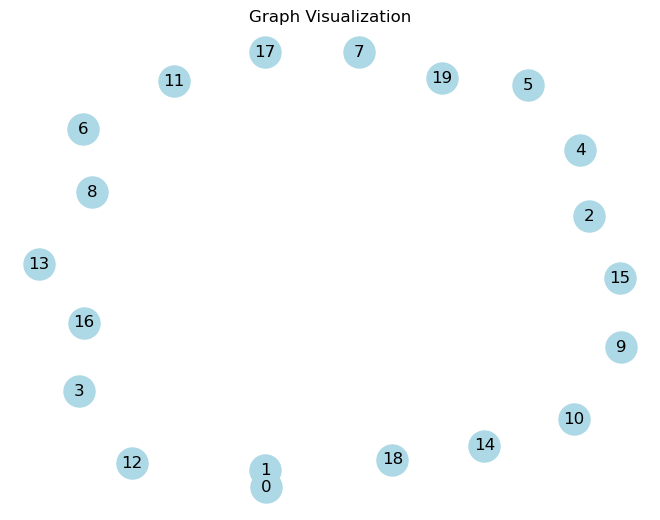

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

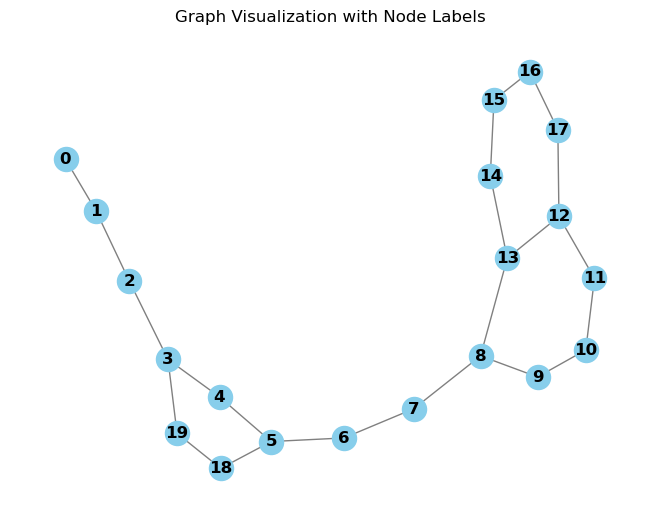

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

50001
50001


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [46]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[770, 72], edge_index=[2, 11660], edge_attr=[11660, 10], batch=[770], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [67]:
num_epochs = 25
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []


for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())
        
        epochs.append(epoch)


epoch 0
real_accuracy tensor(0.9181)
fake_accuracy tensor(0.9896)
d_loss.item() 0.28261440992355347
g_loss.item() 2.9778764247894287
real_accuracy tensor(0.9184)
fake_accuracy tensor(0.9889)
d_loss.item() 0.2891264855861664
g_loss.item() 2.797877073287964
real_accuracy tensor(0.9104)
fake_accuracy tensor(0.9944)
d_loss.item() 0.29489660263061523
g_loss.item() 2.6644973754882812
real_accuracy tensor(0.9151)
fake_accuracy tensor(1.)
d_loss.item() 0.2825811207294464
g_loss.item() 2.611189126968384
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9908)
d_loss.item() 0.2543346881866455
g_loss.item() 2.463308572769165
real_accuracy tensor(0.9175)
fake_accuracy tensor(1.)
d_loss.item() 0.2598020136356354
g_loss.item() 2.469994306564331
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9964)
d_loss.item() 0.23737606406211853
g_loss.item() 2.615002393722534
real_accuracy tensor(0.9127)
fake_accuracy tensor(0.9829)
d_loss.item() 0.30112361907958984
g_loss.item() 2.6267199516296387
real_accu

real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.26665806770324707
g_loss.item() 2.8508715629577637
real_accuracy tensor(0.9116)
fake_accuracy tensor(1.)
d_loss.item() 0.2928939461708069
g_loss.item() 2.7979891300201416
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.273562490940094
g_loss.item() 2.3930089473724365
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.31040695309638977
g_loss.item() 2.43098521232605
real_accuracy tensor(0.9105)
fake_accuracy tensor(1.)
d_loss.item() 0.3287053406238556
g_loss.item() 2.3219692707061768
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9952)
d_loss.item() 0.2411801517009735
g_loss.item() 2.644362211227417
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9984)
d_loss.item() 0.2763065695762634
g_loss.item() 2.856391429901123
real_accuracy tensor(0.9068)
fake_accuracy tensor(1.)
d_loss.item() 0.3279046416282654
g_loss.item() 2.856799364089966
real_accuracy tensor(0.9079)
fake_ac

real_accuracy tensor(0.8971)
fake_accuracy tensor(0.9933)
d_loss.item() 0.32708054780960083
g_loss.item() 2.5717108249664307
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.25581470131874084
g_loss.item() 2.6561081409454346
real_accuracy tensor(0.9139)
fake_accuracy tensor(1.)
d_loss.item() 0.26942557096481323
g_loss.item() 2.699718475341797
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.2575928270816803
g_loss.item() 2.7048840522766113
real_accuracy tensor(0.9350)
fake_accuracy tensor(1.)
d_loss.item() 0.24024850130081177
g_loss.item() 2.7036116123199463
real_accuracy tensor(0.9109)
fake_accuracy tensor(1.)
d_loss.item() 0.2885897755622864
g_loss.item() 2.7980663776397705
real_accuracy tensor(0.9428)
fake_accuracy tensor(0.9948)
d_loss.item() 0.23109886050224304
g_loss.item() 2.7816169261932373
real_accuracy tensor(0.8961)
fake_accuracy tensor(0.9987)
d_loss.item() 0.34645286202430725
g_loss.item() 2.733917713165283
real_accuracy tensor(0.9

fake_accuracy tensor(1.)
d_loss.item() 0.2984597086906433
g_loss.item() 2.8313686847686768
real_accuracy tensor(0.9084)
fake_accuracy tensor(0.9978)
d_loss.item() 0.30086657404899597
g_loss.item() 2.4789113998413086
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9946)
d_loss.item() 0.21707378327846527
g_loss.item() 2.5160584449768066
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.2460918128490448
g_loss.item() 2.413151264190674
real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.2578372359275818
g_loss.item() 2.625638723373413
real_accuracy tensor(0.9185)
fake_accuracy tensor(0.9908)
d_loss.item() 0.27940720319747925
g_loss.item() 2.7538645267486572
real_accuracy tensor(0.9079)
fake_accuracy tensor(1.)
d_loss.item() 0.2967945635318756
g_loss.item() 2.8454062938690186
real_accuracy tensor(0.9069)
fake_accuracy tensor(1.)
d_loss.item() 0.304595023393631
g_loss.item() 2.930767059326172
real_accuracy tensor(0.8965)
fake_accuracy tensor(0.9989)


real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.30220580101013184
g_loss.item() 2.3732826709747314
real_accuracy tensor(0.9291)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2764393091201782
g_loss.item() 2.4670355319976807
real_accuracy tensor(0.9135)
fake_accuracy tensor(0.9976)
d_loss.item() 0.3005012273788452
g_loss.item() 2.687286376953125
real_accuracy tensor(0.9214)
fake_accuracy tensor(1.)
d_loss.item() 0.27052241563796997
g_loss.item() 2.7080960273742676
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.2769962251186371
g_loss.item() 2.675708532333374
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.2567468285560608
g_loss.item() 2.9630424976348877
real_accuracy tensor(0.9311)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24108418822288513
g_loss.item() 2.9980807304382324
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.22830595076084137
g_loss.item() 2.907917022705078
real_accuracy tensor(0.9025

real_accuracy tensor(0.9173)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2805720567703247
g_loss.item() 2.7678139209747314
real_accuracy tensor(0.9358)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2374257743358612
g_loss.item() 2.667950391769409
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.2764832377433777
g_loss.item() 2.7481396198272705
real_accuracy tensor(0.9199)
fake_accuracy tensor(1.)
d_loss.item() 0.2648414969444275
g_loss.item() 2.713369369506836
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.24032676219940186
g_loss.item() 2.668031930923462
real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9979)
d_loss.item() 0.2466171383857727
g_loss.item() 2.7501747608184814
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.25446075201034546
g_loss.item() 2.777538776397705
real_accuracy tensor(0.9054)
fake_accuracy tensor(0.9989)
d_loss.item() 0.296222448348999
g_loss.item() 2.7297868728637695
real_accuracy tensor(0.9116

real_accuracy tensor(0.9090)
fake_accuracy tensor(0.9857)
d_loss.item() 0.2878165543079376
g_loss.item() 2.5046892166137695
real_accuracy tensor(0.9279)
fake_accuracy tensor(0.9961)
d_loss.item() 0.24103407561779022
g_loss.item() 2.556788921356201
real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.22292208671569824
g_loss.item() 2.594730854034424
real_accuracy tensor(0.9099)
fake_accuracy tensor(0.9920)
d_loss.item() 0.2859729528427124
g_loss.item() 2.751659631729126
real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.25089171528816223
g_loss.item() 2.704421043395996
real_accuracy tensor(0.9253)
fake_accuracy tensor(0.9954)
d_loss.item() 0.25371575355529785
g_loss.item() 2.8720316886901855
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9835)
d_loss.item() 0.25653278827667236
g_loss.item() 3.056556463241577
real_accuracy tensor(0.9161)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2812199890613556
g_loss.item() 3.018789529800415
real_accuracy ten

real_accuracy tensor(0.9495)
fake_accuracy tensor(1.)
d_loss.item() 0.18192589282989502
g_loss.item() 2.803718090057373
real_accuracy tensor(0.9047)
fake_accuracy tensor(1.)
d_loss.item() 0.281651109457016
g_loss.item() 2.8343265056610107
real_accuracy tensor(0.9153)
fake_accuracy tensor(1.)
d_loss.item() 0.2761734127998352
g_loss.item() 2.6168253421783447
real_accuracy tensor(0.9243)
fake_accuracy tensor(0.9970)
d_loss.item() 0.2521325647830963
g_loss.item() 2.499326705932617
real_accuracy tensor(0.9304)
fake_accuracy tensor(1.)
d_loss.item() 0.23437634110450745
g_loss.item() 2.5808141231536865
real_accuracy tensor(0.9139)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2717675566673279
g_loss.item() 2.6294562816619873
real_accuracy tensor(0.9078)
fake_accuracy tensor(1.)
d_loss.item() 0.2703836262226105
g_loss.item() 2.6971206665039062
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.2766960859298706
g_loss.item() 2.6870579719543457
real_accuracy tensor(0.9400)
fake

real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.254772424697876
g_loss.item() 2.7765650749206543
real_accuracy tensor(0.9064)
fake_accuracy tensor(1.)
d_loss.item() 0.3198813498020172
g_loss.item() 2.625847101211548
real_accuracy tensor(0.9384)
fake_accuracy tensor(1.)
d_loss.item() 0.2293023318052292
g_loss.item() 2.639216184616089
real_accuracy tensor(0.9122)
fake_accuracy tensor(1.)
d_loss.item() 0.31112346053123474
g_loss.item() 2.4676594734191895
real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.24529865384101868
g_loss.item() 2.6070501804351807
real_accuracy tensor(0.9096)
fake_accuracy tensor(1.)
d_loss.item() 0.27947914600372314
g_loss.item() 2.7657248973846436
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.24237731099128723
g_loss.item() 2.7902755737304688
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2506108582019806
g_loss.item() 2.6984341144561768
real_accuracy tensor(0.9081)
fake_a

real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.23387491703033447
g_loss.item() 2.630711793899536
real_accuracy tensor(0.9149)
fake_accuracy tensor(1.)
d_loss.item() 0.2852678894996643
g_loss.item() 2.570401906967163
real_accuracy tensor(0.9401)
fake_accuracy tensor(1.)
d_loss.item() 0.2408941090106964
g_loss.item() 2.5189919471740723
real_accuracy tensor(0.9384)
fake_accuracy tensor(0.9947)
d_loss.item() 0.24222373962402344
g_loss.item() 2.7338244915008545
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.27893972396850586
g_loss.item() 2.737201690673828
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.26381415128707886
g_loss.item() 2.8077542781829834
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9987)
d_loss.item() 0.28500744700431824
g_loss.item() 2.8403992652893066
real_accuracy tensor(0.9206)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2776206135749817
g_loss.item() 2.7970643043518066
real_accuracy tensor(0.925

real_accuracy tensor(0.9214)
fake_accuracy tensor(1.)
d_loss.item() 0.2563691735267639
g_loss.item() 2.57285737991333
real_accuracy tensor(0.9164)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2761796712875366
g_loss.item() 2.521418571472168
real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.24805733561515808
g_loss.item() 2.6028783321380615
real_accuracy tensor(0.9221)
fake_accuracy tensor(0.9976)
d_loss.item() 0.26488196849823
g_loss.item() 2.5662872791290283
real_accuracy tensor(0.9153)
fake_accuracy tensor(1.)
d_loss.item() 0.269033282995224
g_loss.item() 2.6122798919677734
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.25216197967529297
g_loss.item() 2.7074027061462402
real_accuracy tensor(0.9432)
fake_accuracy tensor(0.9960)
d_loss.item() 0.21689879894256592
g_loss.item() 2.7747833728790283
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.26619628071784973
g_loss.item() 2.7991220951080322
real_accuracy tensor(0.9376)
f

real_accuracy tensor(0.9259)
fake_accuracy tensor(1.)
d_loss.item() 0.24699291586875916
g_loss.item() 2.840648889541626
real_accuracy tensor(0.9294)
fake_accuracy tensor(1.)
d_loss.item() 0.23883908987045288
g_loss.item() 2.6779425144195557
real_accuracy tensor(0.9172)
fake_accuracy tensor(0.9944)
d_loss.item() 0.28825944662094116
g_loss.item() 2.5306644439697266
real_accuracy tensor(0.9124)
fake_accuracy tensor(1.)
d_loss.item() 0.2865029275417328
g_loss.item() 2.6024234294891357
real_accuracy tensor(0.8975)
fake_accuracy tensor(1.)
d_loss.item() 0.31511592864990234
g_loss.item() 2.508336067199707
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.2313098907470703
g_loss.item() 2.6368229389190674
real_accuracy tensor(0.9209)
fake_accuracy tensor(1.)
d_loss.item() 0.26348137855529785
g_loss.item() 2.742245674133301
real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.20970484614372253
g_loss.item() 2.878521203994751
real_accuracy tensor(0.9258)
fake_

real_accuracy tensor(0.9609)
fake_accuracy tensor(1.)
d_loss.item() 0.16644980013370514
g_loss.item() 3.135953187942505
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9970)
d_loss.item() 0.23237638175487518
g_loss.item() 3.286066770553589
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.29123103618621826
g_loss.item() 3.1668951511383057
real_accuracy tensor(0.9142)
fake_accuracy tensor(0.9946)
d_loss.item() 0.2821024954319
g_loss.item() 3.1374995708465576
real_accuracy tensor(0.9156)
fake_accuracy tensor(1.)
d_loss.item() 0.2604522109031677
g_loss.item() 2.9988551139831543
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.23946166038513184
g_loss.item() 2.4930758476257324
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23608919978141785
g_loss.item() 2.4785494804382324
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.23463968932628632
g_loss.item() 2.62573504447937
real_accuracy tensor(0.9082)


real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.28935346007347107
g_loss.item() 2.7473301887512207
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.303067147731781
g_loss.item() 2.6317360401153564
real_accuracy tensor(0.9014)
fake_accuracy tensor(1.)
d_loss.item() 0.3111268877983093
g_loss.item() 2.8291454315185547
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2534886598587036
g_loss.item() 2.67437481880188
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.24596266448497772
g_loss.item() 2.7060630321502686
real_accuracy tensor(0.8946)
fake_accuracy tensor(1.)
d_loss.item() 0.32612189650535583
g_loss.item() 2.7765660285949707
real_accuracy tensor(0.9249)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2684357762336731
g_loss.item() 2.5609874725341797
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2485561966896057
g_loss.item() 2.6485986709594727
real_accuracy tensor(0.9189)
fak

real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9935)
d_loss.item() 0.30004990100860596
g_loss.item() 2.6834843158721924
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.23743045330047607
g_loss.item() 2.622058629989624
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.27354830503463745
g_loss.item() 2.572999954223633
real_accuracy tensor(0.9331)
fake_accuracy tensor(0.9952)
d_loss.item() 0.2630130648612976
g_loss.item() 2.6776692867279053
real_accuracy tensor(0.9143)
fake_accuracy tensor(0.9973)
d_loss.item() 0.31478777527809143
g_loss.item() 2.659383535385132
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.2739459276199341
g_loss.item() 2.8862369060516357
real_accuracy tensor(0.9206)
fake_accuracy tensor(0.9950)
d_loss.item() 0.29066431522369385
g_loss.item() 2.8829152584075928
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9961)
d_loss.item() 0.20217059552669525
g_loss.item() 2.921895980834961
real_accuracy tens

real_accuracy tensor(0.9205)
fake_accuracy tensor(0.9989)
d_loss.item() 0.27081185579299927
g_loss.item() 2.4862966537475586
real_accuracy tensor(0.9394)
fake_accuracy tensor(1.)
d_loss.item() 0.23393136262893677
g_loss.item() 2.569429874420166
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.2546160817146301
g_loss.item() 2.751089572906494
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.23297803103923798
g_loss.item() 2.9315693378448486
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.26610127091407776
g_loss.item() 3.0496597290039062
real_accuracy tensor(0.8982)
fake_accuracy tensor(1.)
d_loss.item() 0.3058488965034485
g_loss.item() 3.022890329360962
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.24841231107711792
g_loss.item() 2.9315807819366455
real_accuracy tensor(0.9537)
fake_accuracy tensor(1.)
d_loss.item() 0.17704473435878754
g_loss.item() 2.7963082790374756
real_accuracy tensor(0.9236)
fake

real_accuracy tensor(0.9170)
fake_accuracy tensor(1.)
d_loss.item() 0.25067269802093506
g_loss.item() 2.856471061706543
real_accuracy tensor(0.9085)
fake_accuracy tensor(0.9873)
d_loss.item() 0.31309786438941956
g_loss.item() 2.6127374172210693
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.2487763911485672
g_loss.item() 2.9039390087127686
real_accuracy tensor(0.9439)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2194732129573822
g_loss.item() 2.7900023460388184
real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2672075629234314
g_loss.item() 2.804302930831909
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.2285841703414917
g_loss.item() 2.859189987182617
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24664700031280518
g_loss.item() 3.006553888320923
real_accuracy tensor(0.9174)
fake_accuracy tensor(0.9977)
d_loss.item() 0.27618587017059326
g_loss.item() 2.8412108421325684
real_accuracy tensor

real_accuracy tensor(0.9039)
fake_accuracy tensor(0.9977)
d_loss.item() 0.27591443061828613
g_loss.item() 2.711580991744995
real_accuracy tensor(0.9294)
fake_accuracy tensor(1.)
d_loss.item() 0.21189162135124207
g_loss.item() 2.731534004211426
real_accuracy tensor(0.9128)
fake_accuracy tensor(1.)
d_loss.item() 0.2533438801765442
g_loss.item() 2.664795160293579
real_accuracy tensor(0.9162)
fake_accuracy tensor(1.)
d_loss.item() 0.2411358654499054
g_loss.item() 2.741532325744629
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.2524457573890686
g_loss.item() 2.60840106010437
real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19361084699630737
g_loss.item() 2.701549768447876
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.21513351798057556
g_loss.item() 2.7512824535369873
real_accuracy tensor(0.9340)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2064618170261383
g_loss.item() 2.895141839981079
real_accuracy tensor(0.9088)
fak

real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.2062734067440033
g_loss.item() 2.7593533992767334
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.24385297298431396
g_loss.item() 2.869432210922241
real_accuracy tensor(0.9021)
fake_accuracy tensor(1.)
d_loss.item() 0.2947946786880493
g_loss.item() 2.929837942123413
real_accuracy tensor(0.9080)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2757246494293213
g_loss.item() 2.9341623783111572
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.2283823937177658
g_loss.item() 2.7974605560302734
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.22582478821277618
g_loss.item() 2.7494475841522217
real_accuracy tensor(0.9206)
fake_accuracy tensor(1.)
d_loss.item() 0.25141555070877075
g_loss.item() 2.680206537246704
real_accuracy tensor(0.9084)
fake_accuracy tensor(1.)
d_loss.item() 0.26138484477996826
g_loss.item() 2.7179501056671143
real_accuracy tensor(0.9330)
fake_a

real_accuracy tensor(0.9042)
fake_accuracy tensor(1.)
d_loss.item() 0.28755107522010803
g_loss.item() 2.572361946105957
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.21928195655345917
g_loss.item() 2.60245680809021
real_accuracy tensor(0.9193)
fake_accuracy tensor(0.9976)
d_loss.item() 0.26133430004119873
g_loss.item() 2.5111706256866455
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.22016224265098572
g_loss.item() 2.766653537750244
real_accuracy tensor(0.9330)
fake_accuracy tensor(1.)
d_loss.item() 0.2243126481771469
g_loss.item() 2.835009813308716
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9960)
d_loss.item() 0.2686217427253723
g_loss.item() 2.902726650238037
real_accuracy tensor(0.9224)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2680392861366272
g_loss.item() 2.8688106536865234
real_accuracy tensor(0.9433)
fake_accuracy tensor(0.9970)
d_loss.item() 0.19459158182144165
g_loss.item() 3.1009457111358643
real_accuracy tensor(0.91

real_accuracy tensor(0.9180)
fake_accuracy tensor(1.)
d_loss.item() 0.26852744817733765
g_loss.item() 2.6937711238861084
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.25088807940483093
g_loss.item() 2.3880016803741455
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.23512378334999084
g_loss.item() 2.3839688301086426
real_accuracy tensor(0.9083)
fake_accuracy tensor(1.)
d_loss.item() 0.28755706548690796
g_loss.item() 2.4090683460235596
real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.2856786251068115
g_loss.item() 2.4915924072265625
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9977)
d_loss.item() 0.20403580367565155
g_loss.item() 2.7304201126098633
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.2318515032529831
g_loss.item() 3.026636838912964
real_accuracy tensor(0.9082)
fake_accuracy tensor(0.9972)
d_loss.item() 0.3194941580295563
g_loss.item() 3.12418270111084
real_accuracy tensor(0.9358)
f

real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.21984802186489105
g_loss.item() 3.05102276802063
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.2384282350540161
g_loss.item() 2.9282925128936768
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.20819348096847534
g_loss.item() 2.7479660511016846
real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2136087417602539
g_loss.item() 2.725456953048706
real_accuracy tensor(0.9233)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23241426050662994
g_loss.item() 2.6739909648895264
real_accuracy tensor(0.9084)
fake_accuracy tensor(0.9961)
d_loss.item() 0.27195608615875244
g_loss.item() 2.5638062953948975
real_accuracy tensor(0.9016)
fake_accuracy tensor(1.)
d_loss.item() 0.2753737270832062
g_loss.item() 2.62573504447937
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.23255892097949982
g_loss.item() 2.5969021320343018
real_accuracy tensor(0.9263)

real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.272262305021286
g_loss.item() 2.4638659954071045
real_accuracy tensor(0.9136)
fake_accuracy tensor(1.)
d_loss.item() 0.2975645363330841
g_loss.item() 2.5209572315216064
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.25942519307136536
g_loss.item() 2.7951760292053223
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.27538877725601196
g_loss.item() 2.9020867347717285
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9987)
d_loss.item() 0.28669652342796326
g_loss.item() 2.9787349700927734
real_accuracy tensor(0.9171)
fake_accuracy tensor(1.)
d_loss.item() 0.2848507761955261
g_loss.item() 2.8155064582824707
real_accuracy tensor(0.9157)
fake_accuracy tensor(0.9975)
d_loss.item() 0.29861879348754883
g_loss.item() 2.786379098892212
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.2502109408378601
g_loss.item() 2.9760689735412598
real_accuracy tensor(0.9283)
f

real_accuracy tensor(0.9203)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2615610361099243
g_loss.item() 2.588804006576538
real_accuracy tensor(0.9100)
fake_accuracy tensor(1.)
d_loss.item() 0.26944637298583984
g_loss.item() 2.435012102127075
real_accuracy tensor(0.9337)
fake_accuracy tensor(0.9962)
d_loss.item() 0.23739418387413025
g_loss.item() 2.6541922092437744
real_accuracy tensor(0.9056)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2772475481033325
g_loss.item() 2.883146047592163
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9988)
d_loss.item() 0.27214515209198
g_loss.item() 2.848936080932617
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.25175410509109497
g_loss.item() 2.946514368057251
real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.23543140292167664
g_loss.item() 2.918074131011963
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.20656698942184448
g_loss.item() 3.2725088596343994
real_accuracy tensor(0.9312

real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.25803667306900024
g_loss.item() 2.743633985519409
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.21402135491371155
g_loss.item() 2.7439451217651367
real_accuracy tensor(0.9272)
fake_accuracy tensor(1.)
d_loss.item() 0.27046269178390503
g_loss.item() 2.8022243976593018
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.270955890417099
g_loss.item() 2.86211895942688
real_accuracy tensor(0.9199)
fake_accuracy tensor(1.)
d_loss.item() 0.2752447724342346
g_loss.item() 2.8927931785583496
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.27451109886169434
g_loss.item() 2.772111415863037
real_accuracy tensor(0.9131)
fake_accuracy tensor(1.)
d_loss.item() 0.3034697473049164
g_loss.item() 2.634817600250244
real_accuracy tensor(0.9218)
fake_accuracy tensor(1.)
d_loss.item() 0.2833961248397827
g_loss.item() 2.5683226585388184
real_accuracy tensor(0.9211)
fake_accuracy

real_accuracy tensor(0.9367)
fake_accuracy tensor(1.)
d_loss.item() 0.23509086668491364
g_loss.item() 2.7596867084503174
real_accuracy tensor(0.9387)
fake_accuracy tensor(0.9988)
d_loss.item() 0.260252982378006
g_loss.item() 2.7026896476745605
real_accuracy tensor(0.9300)
fake_accuracy tensor(0.9928)
d_loss.item() 0.2647390365600586
g_loss.item() 3.1024537086486816
real_accuracy tensor(0.9226)
fake_accuracy tensor(1.)
d_loss.item() 0.2625228464603424
g_loss.item() 3.1659650802612305
real_accuracy tensor(0.9072)
fake_accuracy tensor(1.)
d_loss.item() 0.31754565238952637
g_loss.item() 3.2866311073303223
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2790328562259674
g_loss.item() 3.0284030437469482
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.2782008945941925
g_loss.item() 3.0310213565826416
real_accuracy tensor(0.9141)
fake_accuracy tensor(1.)
d_loss.item() 0.2915949821472168
g_loss.item() 2.6898391246795654
real_accuracy tensor(0.9214)
fa

real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9951)
d_loss.item() 0.23386931419372559
g_loss.item() 3.1072428226470947
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.2381383329629898
g_loss.item() 3.054011821746826
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.24912458658218384
g_loss.item() 3.071946620941162
real_accuracy tensor(0.9175)
fake_accuracy tensor(1.)
d_loss.item() 0.2717413306236267
g_loss.item() 2.8994081020355225
real_accuracy tensor(0.9075)
fake_accuracy tensor(1.)
d_loss.item() 0.2795139253139496
g_loss.item() 2.7503578662872314
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9924)
d_loss.item() 0.25009816884994507
g_loss.item() 2.5506434440612793
real_accuracy tensor(0.9174)
fake_accuracy tensor(1.)
d_loss.item() 0.25951170921325684
g_loss.item() 2.5034501552581787
real_accuracy tensor(0.9144)
fake_accuracy tensor(0.9988)
d_loss.item() 0.26884740591049194
g_loss.item() 2.4897797107696533
real_accuracy tensor(0.92

real_accuracy tensor(0.9318)
fake_accuracy tensor(0.9978)
d_loss.item() 0.23614464700222015
g_loss.item() 2.781480312347412
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.2385188639163971
g_loss.item() 2.8289413452148438
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24391770362854004
g_loss.item() 2.8180248737335205
real_accuracy tensor(0.9133)
fake_accuracy tensor(1.)
d_loss.item() 0.27209869027137756
g_loss.item() 3.050703525543213
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.26457545161247253
g_loss.item() 2.8589019775390625
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.9962)
d_loss.item() 0.23222944140434265
g_loss.item() 2.9420604705810547
real_accuracy tensor(0.9202)
fake_accuracy tensor(1.)
d_loss.item() 0.26368600130081177
g_loss.item() 2.9164018630981445
real_accuracy tensor(0.9095)
fake_accuracy tensor(1.)
d_loss.item() 0.3143466114997864
g_loss.item() 2.7738583087921143
real_accuracy tensor(0.8

real_accuracy tensor(0.9223)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2804054319858551
g_loss.item() 2.439335346221924
real_accuracy tensor(0.9332)
fake_accuracy tensor(0.9975)
d_loss.item() 0.24284620583057404
g_loss.item() 2.618603229522705
real_accuracy tensor(0.9217)
fake_accuracy tensor(1.)
d_loss.item() 0.26712387800216675
g_loss.item() 2.905291795730591
real_accuracy tensor(0.9076)
fake_accuracy tensor(0.9976)
d_loss.item() 0.28249555826187134
g_loss.item() 3.0012612342834473
real_accuracy tensor(0.9383)
fake_accuracy tensor(0.9973)
d_loss.item() 0.21743449568748474
g_loss.item() 3.1962616443634033
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.22553522884845734
g_loss.item() 3.2179300785064697
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2506818175315857
g_loss.item() 3.10032057762146
real_accuracy tensor(0.9050)
fake_accuracy tensor(1.)
d_loss.item() 0.3172314167022705
g_loss.item() 2.9202880859375
real_accuracy tensor(0.

real_accuracy tensor(0.9305)
fake_accuracy tensor(1.)
d_loss.item() 0.256405234336853
g_loss.item() 2.5317728519439697
real_accuracy tensor(0.9448)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2212403565645218
g_loss.item() 2.6195991039276123
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.25604528188705444
g_loss.item() 2.793337345123291
real_accuracy tensor(0.9053)
fake_accuracy tensor(0.9922)
d_loss.item() 0.3019176721572876
g_loss.item() 2.7683632373809814
real_accuracy tensor(0.9452)
fake_accuracy tensor(1.)
d_loss.item() 0.20491984486579895
g_loss.item() 2.8873770236968994
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.2389741837978363
g_loss.item() 2.9656822681427
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.2341444194316864
g_loss.item() 3.0083370208740234
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.2790188193321228
g_loss.item() 3.020244836807251
real_accuracy tensor(0.9204)
fake_ac

real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.2627292573451996
g_loss.item() 2.8698196411132812
real_accuracy tensor(0.9068)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3175939917564392
g_loss.item() 2.813199281692505
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.30301180481910706
g_loss.item() 2.6701226234436035
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.2726530432701111
g_loss.item() 2.68853497505188
real_accuracy tensor(0.9087)
fake_accuracy tensor(1.)
d_loss.item() 0.3176979124546051
g_loss.item() 2.6411547660827637
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.21521225571632385
g_loss.item() 2.6807875633239746
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.2629668414592743
g_loss.item() 2.6232593059539795
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.2763881981372833
g_loss.item() 2.7337708473205566
real_accuracy tensor(0.9441)
fake_acc

real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.21171662211418152
g_loss.item() 3.0288350582122803
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.2031642198562622
g_loss.item() 3.228813648223877
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.23260323703289032
g_loss.item() 3.368581771850586
real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9927)
d_loss.item() 0.29062333703041077
g_loss.item() 3.037975788116455
real_accuracy tensor(0.9111)
fake_accuracy tensor(0.9969)
d_loss.item() 0.30132007598876953
g_loss.item() 3.0261082649230957
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.26121628284454346
g_loss.item() 2.7656164169311523
real_accuracy tensor(0.9162)
fake_accuracy tensor(1.)
d_loss.item() 0.26559165120124817
g_loss.item() 2.5873024463653564
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.25809162855148315
g_loss.item() 2.3223202228546143
real_accuracy tensor(0.9369)

real_accuracy tensor(0.9325)
fake_accuracy tensor(0.9954)
d_loss.item() 0.25586432218551636
g_loss.item() 2.9112024307250977
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.23312178254127502
g_loss.item() 2.8215668201446533
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.25792384147644043
g_loss.item() 2.7817130088806152
real_accuracy tensor(0.9160)
fake_accuracy tensor(1.)
d_loss.item() 0.29384273290634155
g_loss.item() 2.7726292610168457
real_accuracy tensor(0.9139)
fake_accuracy tensor(1.)
d_loss.item() 0.29330751299858093
g_loss.item() 2.58089542388916
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.30602532625198364
g_loss.item() 2.4734442234039307
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.24065285921096802
g_loss.item() 2.5064070224761963
real_accuracy tensor(0.9259)
fake_accuracy tensor(0.9961)
d_loss.item() 0.26752710342407227
g_loss.item() 2.4356603622436523
real_accuracy tensor(0.937

real_accuracy tensor(0.9098)
fake_accuracy tensor(1.)
d_loss.item() 0.28590691089630127
g_loss.item() 2.7131874561309814
real_accuracy tensor(0.9196)
fake_accuracy tensor(1.)
d_loss.item() 0.2753167450428009
g_loss.item() 2.840383291244507
real_accuracy tensor(0.9054)
fake_accuracy tensor(0.9976)
d_loss.item() 0.31546393036842346
g_loss.item() 2.7211101055145264
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.3075687289237976
g_loss.item() 2.7526779174804688
real_accuracy tensor(0.9172)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2682778239250183
g_loss.item() 2.821648120880127
real_accuracy tensor(0.9151)
fake_accuracy tensor(1.)
d_loss.item() 0.2867565155029297
g_loss.item() 2.7641916275024414
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.25921696424484253
g_loss.item() 2.796842575073242
real_accuracy tensor(0.9122)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3206597566604614
g_loss.item() 2.658346652984619
real_accuracy tensor(0.9365)


real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.2518807649612427
g_loss.item() 2.5515434741973877
real_accuracy tensor(0.9425)
fake_accuracy tensor(1.)
d_loss.item() 0.21508967876434326
g_loss.item() 2.656567335128784
real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.2584817409515381
g_loss.item() 2.8080642223358154
real_accuracy tensor(0.9284)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2288411259651184
g_loss.item() 2.9963223934173584
real_accuracy tensor(0.9136)
fake_accuracy tensor(1.)
d_loss.item() 0.29042506217956543
g_loss.item() 3.0262091159820557
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.19717061519622803
g_loss.item() 3.091437339782715
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2236257940530777
g_loss.item() 3.166018009185791
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.2224189043045044
g_loss.item() 3.0763039588928223
real_accuracy tensor(0.9361)
fak

real_accuracy tensor(0.9151)
fake_accuracy tensor(0.9989)
d_loss.item() 0.32389384508132935
g_loss.item() 2.6179001331329346
real_accuracy tensor(0.9143)
fake_accuracy tensor(0.9920)
d_loss.item() 0.3288376033306122
g_loss.item() 2.525256872177124
real_accuracy tensor(0.9186)
fake_accuracy tensor(1.)
d_loss.item() 0.2994077801704407
g_loss.item() 2.6114044189453125
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.24055644869804382
g_loss.item() 2.6684155464172363
real_accuracy tensor(0.9231)
fake_accuracy tensor(0.9972)
d_loss.item() 0.28353551030158997
g_loss.item() 2.77699875831604
real_accuracy tensor(0.9260)
fake_accuracy tensor(0.9976)
d_loss.item() 0.28695911169052124
g_loss.item() 2.742479085922241
real_accuracy tensor(0.9376)
fake_accuracy tensor(1.)
d_loss.item() 0.25259265303611755
g_loss.item() 2.9150867462158203
real_accuracy tensor(0.9267)
fake_accuracy tensor(1.)
d_loss.item() 0.28839099407196045
g_loss.item() 3.030090570449829
real_accuracy tensor(0.

real_accuracy tensor(0.9192)
fake_accuracy tensor(1.)
d_loss.item() 0.2846270203590393
g_loss.item() 2.999229669570923
real_accuracy tensor(0.9119)
fake_accuracy tensor(0.9988)
d_loss.item() 0.29164308309555054
g_loss.item() 2.874755859375
real_accuracy tensor(0.9370)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2482176125049591
g_loss.item() 2.5281906127929688
real_accuracy tensor(0.9450)
fake_accuracy tensor(1.)
d_loss.item() 0.21670910716056824
g_loss.item() 2.7426345348358154
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.29320967197418213
g_loss.item() 2.6169726848602295
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2463509440422058
g_loss.item() 2.78120756149292
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.2807614803314209
g_loss.item() 2.756065607070923
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.28032559156417847
g_loss.item() 2.743912696838379
real_accuracy tensor(0.8978)
fake

real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.20874224603176117
g_loss.item() 2.841697931289673
real_accuracy tensor(0.9291)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2324087917804718
g_loss.item() 2.9362258911132812
real_accuracy tensor(0.9160)
fake_accuracy tensor(1.)
d_loss.item() 0.26918601989746094
g_loss.item() 3.0550026893615723
real_accuracy tensor(0.9344)
fake_accuracy tensor(0.9945)
d_loss.item() 0.2383677065372467
g_loss.item() 3.0742080211639404
real_accuracy tensor(0.9043)
fake_accuracy tensor(1.)
d_loss.item() 0.32163169980049133
g_loss.item() 2.9738073348999023
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2542942762374878
g_loss.item() 2.8684465885162354
real_accuracy tensor(0.9084)
fake_accuracy tensor(0.9985)
d_loss.item() 0.30740419030189514
g_loss.item() 2.6962506771087646
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9923)
d_loss.item() 0.3055262565612793
g_loss.item() 2.5129573345184326
real_accuracy ten

real_accuracy tensor(0.9283)
fake_accuracy tensor(0.9939)
d_loss.item() 0.2669769525527954
g_loss.item() 2.611614942550659
real_accuracy tensor(0.9293)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2536785304546356
g_loss.item() 2.684215784072876
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2960945665836334
g_loss.item() 2.757035732269287
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9973)
d_loss.item() 0.23370596766471863
g_loss.item() 2.964451789855957
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.2614595890045166
g_loss.item() 3.1150424480438232
real_accuracy tensor(0.9106)
fake_accuracy tensor(0.9949)
d_loss.item() 0.31272003054618835
g_loss.item() 3.0612874031066895
real_accuracy tensor(0.9086)
fake_accuracy tensor(0.9952)
d_loss.item() 0.31073975563049316
g_loss.item() 2.9553160667419434
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9962)
d_loss.item() 0.26910537481307983
g_loss.item() 2.81210994720459
real_accuracy 

real_accuracy tensor(0.9305)
fake_accuracy tensor(0.9941)
d_loss.item() 0.2085687220096588
g_loss.item() 3.0708611011505127
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.22318309545516968
g_loss.item() 2.893808603286743
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.22960655391216278
g_loss.item() 2.884772777557373
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.22651346027851105
g_loss.item() 2.714789867401123
real_accuracy tensor(0.9171)
fake_accuracy tensor(1.)
d_loss.item() 0.25551506876945496
g_loss.item() 2.607177972793579
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.22759366035461426
g_loss.item() 2.6426966190338135
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.24219435453414917
g_loss.item() 2.768233299255371
real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2507292628288269
g_loss.item() 2.808225631713867
real_accuracy tensor(0.9239)
fak

real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9972)
d_loss.item() 0.2531752288341522
g_loss.item() 2.6171741485595703
real_accuracy tensor(0.9094)
fake_accuracy tensor(1.)
d_loss.item() 0.2894303500652313
g_loss.item() 2.7247555255889893
real_accuracy tensor(0.8817)
fake_accuracy tensor(1.)
d_loss.item() 0.3587788939476013
g_loss.item() 2.724069833755493
real_accuracy tensor(0.9330)
fake_accuracy tensor(1.)
d_loss.item() 0.2372782975435257
g_loss.item() 2.8031067848205566
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.23012840747833252
g_loss.item() 2.8349385261535645
real_accuracy tensor(0.9384)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23346799612045288
g_loss.item() 3.070866346359253
real_accuracy tensor(0.9325)
fake_accuracy tensor(1.)
d_loss.item() 0.23777084052562714
g_loss.item() 3.080775737762451
real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2707018554210663
g_loss.item() 3.0254199504852295
real_accuracy tensor(0.9285)

fake_accuracy tensor(0.9989)
d_loss.item() 0.27901241183280945
g_loss.item() 2.926276683807373
real_accuracy tensor(0.9218)
fake_accuracy tensor(1.)
d_loss.item() 0.27180349826812744
g_loss.item() 2.766111135482788
real_accuracy tensor(0.9363)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2143232524394989
g_loss.item() 2.7499043941497803
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.2264638990163803
g_loss.item() 2.801548480987549
real_accuracy tensor(0.9134)
fake_accuracy tensor(0.9988)
d_loss.item() 0.26719117164611816
g_loss.item() 2.632150173187256
real_accuracy tensor(0.9284)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25724202394485474
g_loss.item() 2.554828643798828
real_accuracy tensor(0.9307)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2234886735677719
g_loss.item() 2.84751296043396
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.2334425002336502
g_loss.item() 2.8695662021636963
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.

real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.2598368227481842
g_loss.item() 2.666693687438965
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.27105870842933655
g_loss.item() 2.705322742462158
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.22220899164676666
g_loss.item() 2.9171817302703857
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23568356037139893
g_loss.item() 2.944286823272705
real_accuracy tensor(0.9175)
fake_accuracy tensor(1.)
d_loss.item() 0.26520928740501404
g_loss.item() 3.117124080657959
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.26387858390808105
g_loss.item() 3.0222017765045166
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.22392740845680237
g_loss.item() 2.921675682067871
real_accuracy tensor(0.9189)
fake_accuracy tensor(1.)
d_loss.item() 0.2788273096084595
g_loss.item() 2.679253339767456
real_accuracy tensor(0.9217)
fake_ac

real_accuracy tensor(0.9141)
fake_accuracy tensor(1.)
d_loss.item() 0.2733294367790222
g_loss.item() 3.0516602993011475
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.222987562417984
g_loss.item() 2.967167615890503
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.22656336426734924
g_loss.item() 2.7920196056365967
real_accuracy tensor(0.9282)
fake_accuracy tensor(1.)
d_loss.item() 0.2323225438594818
g_loss.item() 2.6751859188079834
real_accuracy tensor(0.9517)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17873914539813995
g_loss.item() 2.7893035411834717
real_accuracy tensor(0.9133)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24928417801856995
g_loss.item() 2.748581886291504
real_accuracy tensor(0.9139)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2762331962585449
g_loss.item() 2.5392837524414062
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.23336663842201233
g_loss.item() 2.652608871459961
real_accuracy tensor(0.9338)

real_accuracy tensor(0.9412)
fake_accuracy tensor(1.)
d_loss.item() 0.20484113693237305
g_loss.item() 2.6158814430236816
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.23084861040115356
g_loss.item() 2.642885446548462
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.19718492031097412
g_loss.item() 2.8047943115234375
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.21496976912021637
g_loss.item() 2.9801340103149414
real_accuracy tensor(0.9290)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2231847047805786
g_loss.item() 3.115703582763672
real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.1569550633430481
g_loss.item() 3.3155677318573
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.22338274121284485
g_loss.item() 3.2404580116271973
real_accuracy tensor(0.9068)
fake_accuracy tensor(1.)
d_loss.item() 0.2919456660747528
g_loss.item() 3.0917625427246094
real_accuracy tensor(0.9395)
fake_ac

real_accuracy tensor(0.9005)
fake_accuracy tensor(0.9916)
d_loss.item() 0.3113434314727783
g_loss.item() 2.466386079788208
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.2501978278160095
g_loss.item() 2.430250406265259
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.23214077949523926
g_loss.item() 2.4352610111236572
real_accuracy tensor(0.9256)
fake_accuracy tensor(1.)
d_loss.item() 0.24048015475273132
g_loss.item() 2.6365020275115967
real_accuracy tensor(0.8822)
fake_accuracy tensor(1.)
d_loss.item() 0.3215740919113159
g_loss.item() 2.7512857913970947
epoch 2
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.20967403054237366
g_loss.item() 2.897294044494629
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.2422446310520172
g_loss.item() 3.0575332641601562
real_accuracy tensor(0.9101)
fake_accuracy tensor(1.)
d_loss.item() 0.26392102241516113
g_loss.item() 3.037086248397827
real_accuracy tensor(0.9413)

real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9987)
d_loss.item() 0.261394202709198
g_loss.item() 2.8883094787597656
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.1972767561674118
g_loss.item() 3.1030051708221436
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.2861670255661011
g_loss.item() 2.991933822631836
real_accuracy tensor(0.9111)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3123713731765747
g_loss.item() 3.2877891063690186
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2695543169975281
g_loss.item() 3.1122164726257324
real_accuracy tensor(0.9182)
fake_accuracy tensor(0.9890)
d_loss.item() 0.30829328298568726
g_loss.item() 2.865061044692993
real_accuracy tensor(0.9399)
fake_accuracy tensor(0.9989)
d_loss.item() 0.22989748418331146
g_loss.item() 2.8752150535583496
real_accuracy tensor(0.9397)
fake_accuracy tensor(0.9914)
d_loss.item() 0.24323955178260803
g_loss.item() 2.749577283859253
real_accuracy tensor(

real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.2565518915653229
g_loss.item() 2.5325934886932373
real_accuracy tensor(0.9207)
fake_accuracy tensor(0.9971)
d_loss.item() 0.28214606642723083
g_loss.item() 2.7052390575408936
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.25314879417419434
g_loss.item() 2.8895177841186523
real_accuracy tensor(0.9205)
fake_accuracy tensor(0.9974)
d_loss.item() 0.27146536111831665
g_loss.item() 3.037198781967163
real_accuracy tensor(0.9106)
fake_accuracy tensor(1.)
d_loss.item() 0.297338604927063
g_loss.item() 3.107250452041626
real_accuracy tensor(0.9435)
fake_accuracy tensor(0.9970)
d_loss.item() 0.2109786868095398
g_loss.item() 3.0863966941833496
real_accuracy tensor(0.9218)
fake_accuracy tensor(1.)
d_loss.item() 0.2536953389644623
g_loss.item() 3.1416664123535156
real_accuracy tensor(0.9190)
fake_accuracy tensor(1.)
d_loss.item() 0.26259395480155945
g_loss.item() 2.9851043224334717
real_accuracy tensor(0.9230

real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.25090473890304565
g_loss.item() 3.4282121658325195
real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.2755705714225769
g_loss.item() 3.290174961090088
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.2549354135990143
g_loss.item() 3.329846143722534
real_accuracy tensor(0.9090)
fake_accuracy tensor(1.)
d_loss.item() 0.34926989674568176
g_loss.item() 2.9205102920532227
real_accuracy tensor(0.9235)
fake_accuracy tensor(1.)
d_loss.item() 0.2809348702430725
g_loss.item() 2.7391624450683594
real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.2364560067653656
g_loss.item() 2.5306999683380127
real_accuracy tensor(0.9008)
fake_accuracy tensor(1.)
d_loss.item() 0.33227330446243286
g_loss.item() 2.3379197120666504
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.2479337751865387
g_loss.item() 2.314476251602173
real_accuracy tensor(0.9404)
fake_accura

real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.2620445787906647
g_loss.item() 2.7968461513519287
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.25363096594810486
g_loss.item() 2.8177006244659424
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.24967722594738007
g_loss.item() 2.8935444355010986
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.2221948504447937
g_loss.item() 2.8784265518188477
real_accuracy tensor(0.9299)
fake_accuracy tensor(1.)
d_loss.item() 0.24389919638633728
g_loss.item() 2.8588719367980957
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.24876737594604492
g_loss.item() 2.860994815826416
real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2726691961288452
g_loss.item() 2.8606772422790527
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.23161987960338593
g_loss.item() 2.8746392726898193
real_accuracy tensor(0.9299)
fak

real_accuracy tensor(0.9461)
fake_accuracy tensor(1.)
d_loss.item() 0.20390334725379944
g_loss.item() 2.8522703647613525
real_accuracy tensor(0.9425)
fake_accuracy tensor(1.)
d_loss.item() 0.21710549294948578
g_loss.item() 2.6773476600646973
real_accuracy tensor(0.9394)
fake_accuracy tensor(1.)
d_loss.item() 0.2286691516637802
g_loss.item() 2.792093276977539
real_accuracy tensor(0.9003)
fake_accuracy tensor(0.9944)
d_loss.item() 0.31295663118362427
g_loss.item() 2.738109827041626
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.24039164185523987
g_loss.item() 2.6383752822875977
real_accuracy tensor(0.9310)
fake_accuracy tensor(1.)
d_loss.item() 0.24684256315231323
g_loss.item() 2.626746892929077
real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.2748103439807892
g_loss.item() 2.7055318355560303
real_accuracy tensor(0.9476)
fake_accuracy tensor(1.)
d_loss.item() 0.20703370869159698
g_loss.item() 2.8022000789642334
real_accuracy tensor(0.9221)
fake

real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.20827201008796692
g_loss.item() 3.059821128845215
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23142854869365692
g_loss.item() 2.881898880004883
real_accuracy tensor(0.9192)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2546955347061157
g_loss.item() 2.646496534347534
real_accuracy tensor(0.9372)
fake_accuracy tensor(0.9972)
d_loss.item() 0.22015917301177979
g_loss.item() 2.5857415199279785
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.2581506669521332
g_loss.item() 2.674572229385376
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21767231822013855
g_loss.item() 2.8009896278381348
real_accuracy tensor(0.9280)
fake_accuracy tensor(0.9968)
d_loss.item() 0.25690585374832153
g_loss.item() 2.755573034286499
real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.25034254789352417
g_loss.item() 2.826150417327881
real_accuracy tensor

real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.26989781856536865
g_loss.item() 3.1705398559570312
real_accuracy tensor(0.9256)
fake_accuracy tensor(1.)
d_loss.item() 0.24279437959194183
g_loss.item() 3.1229145526885986
real_accuracy tensor(0.9340)
fake_accuracy tensor(0.9934)
d_loss.item() 0.2197609692811966
g_loss.item() 2.9978764057159424
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.2429145872592926
g_loss.item() 2.9346044063568115
real_accuracy tensor(0.9317)
fake_accuracy tensor(1.)
d_loss.item() 0.22702935338020325
g_loss.item() 2.684241771697998
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.2174021303653717
g_loss.item() 2.7164382934570312
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.2244141697883606
g_loss.item() 2.725099802017212
real_accuracy tensor(0.9115)
fake_accuracy tensor(1.)
d_loss.item() 0.2664131224155426
g_loss.item() 2.7296128273010254
real_accuracy tensor(0.9394)
fake_a

real_accuracy tensor(0.9208)
fake_accuracy tensor(0.9989)
d_loss.item() 0.27861320972442627
g_loss.item() 2.843965768814087
real_accuracy tensor(0.9204)
fake_accuracy tensor(0.9987)
d_loss.item() 0.28117337822914124
g_loss.item() 2.6893956661224365
real_accuracy tensor(0.9192)
fake_accuracy tensor(1.)
d_loss.item() 0.3056910037994385
g_loss.item() 2.574885845184326
real_accuracy tensor(0.9379)
fake_accuracy tensor(0.9944)
d_loss.item() 0.2671316862106323
g_loss.item() 2.5916528701782227
real_accuracy tensor(0.9147)
fake_accuracy tensor(0.9987)
d_loss.item() 0.29950958490371704
g_loss.item() 2.7261276245117188
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.27988672256469727
g_loss.item() 2.7669899463653564
real_accuracy tensor(0.9304)
fake_accuracy tensor(0.9983)
d_loss.item() 0.26180607080459595
g_loss.item() 2.893203020095825
real_accuracy tensor(0.8937)
fake_accuracy tensor(1.)
d_loss.item() 0.36732733249664307
g_loss.item() 2.811680316925049
real_accuracy tens

real_accuracy tensor(0.9224)
fake_accuracy tensor(0.9953)
d_loss.item() 0.2758123576641083
g_loss.item() 3.0310018062591553
real_accuracy tensor(0.9137)
fake_accuracy tensor(1.)
d_loss.item() 0.30088353157043457
g_loss.item() 3.1423964500427246
real_accuracy tensor(0.9286)
fake_accuracy tensor(1.)
d_loss.item() 0.245022714138031
g_loss.item() 3.091672658920288
real_accuracy tensor(0.8998)
fake_accuracy tensor(1.)
d_loss.item() 0.3389747738838196
g_loss.item() 2.9813129901885986
real_accuracy tensor(0.9230)
fake_accuracy tensor(1.)
d_loss.item() 0.27214691042900085
g_loss.item() 2.7320024967193604
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.26051977276802063
g_loss.item() 2.6482696533203125
real_accuracy tensor(0.9293)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2578834295272827
g_loss.item() 2.5925350189208984
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.2919779419898987
g_loss.item() 2.467113971710205
real_accuracy tensor(0.9262)
fak

fake_accuracy tensor(1.)
d_loss.item() 0.2259758710861206
g_loss.item() 3.1058647632598877
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.2632019519805908
g_loss.item() 3.082080125808716
real_accuracy tensor(0.9197)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24774214625358582
g_loss.item() 3.2132315635681152
real_accuracy tensor(0.9487)
fake_accuracy tensor(1.)
d_loss.item() 0.18467703461647034
g_loss.item() 3.058450698852539
real_accuracy tensor(0.9236)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2511156499385834
g_loss.item() 2.8866782188415527
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24635115265846252
g_loss.item() 2.85463285446167
real_accuracy tensor(0.9427)
fake_accuracy tensor(1.)
d_loss.item() 0.20972411334514618
g_loss.item() 2.790398597717285
real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.28097057342529297
g_loss.item() 2.628539562225342
real_accuracy tensor(0.9367)
fake_accuracy tensor(0.9975)


real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.22172358632087708
g_loss.item() 2.8040759563446045
real_accuracy tensor(0.9334)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2429180145263672
g_loss.item() 2.879654884338379
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.26863229274749756
g_loss.item() 2.8808438777923584
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9910)
d_loss.item() 0.2574218213558197
g_loss.item() 2.8980727195739746
real_accuracy tensor(0.9112)
fake_accuracy tensor(1.)
d_loss.item() 0.299892783164978
g_loss.item() 2.8281044960021973
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.2467462420463562
g_loss.item() 2.7602481842041016
real_accuracy tensor(0.9108)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2924002707004547
g_loss.item() 2.7211382389068604
real_accuracy tensor(0.9150)
fake_accuracy tensor(0.9977)
d_loss.item() 0.290604829788208
g_loss.item() 2.6880757808685303
real_accuracy tensor(0.90

real_accuracy tensor(0.9231)
fake_accuracy tensor(1.)
d_loss.item() 0.23019081354141235
g_loss.item() 2.8422465324401855
real_accuracy tensor(0.9340)
fake_accuracy tensor(0.9988)
d_loss.item() 0.21802352368831635
g_loss.item() 2.8533225059509277
real_accuracy tensor(0.9395)
fake_accuracy tensor(1.)
d_loss.item() 0.19409248232841492
g_loss.item() 2.9470179080963135
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.22976043820381165
g_loss.item() 2.9696924686431885
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.2158796191215515
g_loss.item() 3.1137924194335938
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.23810942471027374
g_loss.item() 3.1226532459259033
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.2026837319135666
g_loss.item() 3.0400936603546143
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.21819357573986053
g_loss.item() 2.9198060035705566
real_accuracy tensor(0.9205)
f

real_accuracy tensor(0.9286)
fake_accuracy tensor(0.9979)
d_loss.item() 0.23775261640548706
g_loss.item() 2.868149518966675
real_accuracy tensor(0.9158)
fake_accuracy tensor(1.)
d_loss.item() 0.2566825747489929
g_loss.item() 2.7115869522094727
real_accuracy tensor(0.9038)
fake_accuracy tensor(0.9960)
d_loss.item() 0.30525991320610046
g_loss.item() 2.5707669258117676
real_accuracy tensor(0.9267)
fake_accuracy tensor(1.)
d_loss.item() 0.22334358096122742
g_loss.item() 2.6041793823242188
real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2324894666671753
g_loss.item() 2.561098575592041
real_accuracy tensor(0.8960)
fake_accuracy tensor(1.)
d_loss.item() 0.3069259822368622
g_loss.item() 2.622617244720459
real_accuracy tensor(0.9268)
fake_accuracy tensor(0.9920)
d_loss.item() 0.25712770223617554
g_loss.item() 2.757268190383911
real_accuracy tensor(0.9135)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2540152072906494
g_loss.item() 2.877955675125122
real_accuracy tensor(

real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.25794512033462524
g_loss.item() 3.060903787612915
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.26474055647850037
g_loss.item() 2.76991605758667
real_accuracy tensor(0.9037)
fake_accuracy tensor(1.)
d_loss.item() 0.2995978891849518
g_loss.item() 2.5739481449127197
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.24163198471069336
g_loss.item() 2.433199882507324
real_accuracy tensor(0.9142)
fake_accuracy tensor(0.9962)
d_loss.item() 0.2835603356361389
g_loss.item() 2.3785789012908936
real_accuracy tensor(0.9297)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2515650689601898
g_loss.item() 2.519292116165161
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.21164274215698242
g_loss.item() 2.786966323852539
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.26297667622566223
g_loss.item() 2.8399808406829834
real_accuracy tensor(0.9118)
fake

real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22102129459381104
g_loss.item() 3.0918824672698975
real_accuracy tensor(0.9117)
fake_accuracy tensor(0.9948)
d_loss.item() 0.28571170568466187
g_loss.item() 2.794981002807617
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.2729952037334442
g_loss.item() 2.669522762298584
real_accuracy tensor(0.9395)
fake_accuracy tensor(0.9973)
d_loss.item() 0.23690453171730042
g_loss.item() 2.638921022415161
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9975)
d_loss.item() 0.24672561883926392
g_loss.item() 2.7795746326446533
real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2686843276023865
g_loss.item() 2.727436065673828
real_accuracy tensor(0.9427)
fake_accuracy tensor(0.9921)
d_loss.item() 0.21452373266220093
g_loss.item() 2.9498496055603027
real_accuracy tensor(0.9364)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2378440499305725
g_loss.item() 2.9548089504241943
real_accura

real_accuracy tensor(0.9099)
fake_accuracy tensor(1.)
d_loss.item() 0.291917085647583
g_loss.item() 3.2664175033569336
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.2200421541929245
g_loss.item() 3.2639400959014893
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.24812380969524384
g_loss.item() 3.3329737186431885
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.21542653441429138
g_loss.item() 3.1037709712982178
real_accuracy tensor(0.9110)
fake_accuracy tensor(1.)
d_loss.item() 0.3006851077079773
g_loss.item() 2.87223219871521
real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.2685787081718445
g_loss.item() 2.815237283706665
real_accuracy tensor(0.9194)
fake_accuracy tensor(1.)
d_loss.item() 0.26666489243507385
g_loss.item() 2.4636807441711426
real_accuracy tensor(0.9281)
fake_accuracy tensor(0.9959)
d_loss.item() 0.23410487174987793
g_loss.item() 2.595250368118286
real_accuracy tensor(0.9323)
fake_acc

fake_accuracy tensor(1.)
d_loss.item() 0.1920420527458191
g_loss.item() 2.762058734893799
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9990)
d_loss.item() 0.24852415919303894
g_loss.item() 2.7669103145599365
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9987)
d_loss.item() 0.240828275680542
g_loss.item() 2.824666738510132
real_accuracy tensor(0.8931)
fake_accuracy tensor(1.)
d_loss.item() 0.2588251233100891
g_loss.item() 2.7392983436584473
real_accuracy tensor(0.9217)
fake_accuracy tensor(1.)
d_loss.item() 0.2451002150774002
g_loss.item() 2.641340494155884
real_accuracy tensor(0.9163)
fake_accuracy tensor(1.)
d_loss.item() 0.24615192413330078
g_loss.item() 2.6193912029266357
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.24868366122245789
g_loss.item() 2.6632072925567627
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.21096765995025635
g_loss.item() 2.78082537651062
real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.it

real_accuracy tensor(0.9573)
fake_accuracy tensor(1.)
d_loss.item() 0.1690167784690857
g_loss.item() 2.7890772819519043
real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.25069957971572876
g_loss.item() 2.914116859436035
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.23208823800086975
g_loss.item() 2.884219169616699
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.22371743619441986
g_loss.item() 2.910083532333374
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.17439135909080505
g_loss.item() 3.127934217453003
real_accuracy tensor(0.9181)
fake_accuracy tensor(0.9953)
d_loss.item() 0.2518019676208496
g_loss.item() 3.1308417320251465
real_accuracy tensor(0.9103)
fake_accuracy tensor(0.9975)
d_loss.item() 0.26921969652175903
g_loss.item() 3.2230684757232666
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.21200017631053925
g_loss.item() 3.048492193222046
real_accuracy tensor(0.9353)
fa

real_accuracy tensor(0.8925)
fake_accuracy tensor(0.9973)
d_loss.item() 0.36255383491516113
g_loss.item() 2.65507173538208
real_accuracy tensor(0.9164)
fake_accuracy tensor(1.)
d_loss.item() 0.26914897561073303
g_loss.item() 2.7671730518341064
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.24361592531204224
g_loss.item() 2.549814462661743
real_accuracy tensor(0.9073)
fake_accuracy tensor(1.)
d_loss.item() 0.28751930594444275
g_loss.item() 2.677273750305176
real_accuracy tensor(0.9184)
fake_accuracy tensor(1.)
d_loss.item() 0.2714464068412781
g_loss.item() 2.671164035797119
real_accuracy tensor(0.9237)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2419346570968628
g_loss.item() 2.7844350337982178
real_accuracy tensor(0.9183)
fake_accuracy tensor(1.)
d_loss.item() 0.249151811003685
g_loss.item() 2.877647876739502
real_accuracy tensor(0.9225)
fake_accuracy tensor(0.9954)
d_loss.item() 0.24578386545181274
g_loss.item() 2.891646385192871
real_accuracy tensor(0.9331)
fa

real_accuracy tensor(0.9390)
fake_accuracy tensor(1.)
d_loss.item() 0.20749762654304504
g_loss.item() 3.314946413040161
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.26469215750694275
g_loss.item() 3.094118356704712
real_accuracy tensor(0.8996)
fake_accuracy tensor(0.9950)
d_loss.item() 0.31318551301956177
g_loss.item() 2.819782018661499
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.26700595021247864
g_loss.item() 2.4479424953460693
real_accuracy tensor(0.9342)
fake_accuracy tensor(0.9964)
d_loss.item() 0.24282017350196838
g_loss.item() 2.4356789588928223
real_accuracy tensor(0.9424)
fake_accuracy tensor(1.)
d_loss.item() 0.22050318121910095
g_loss.item() 2.567086935043335
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.24996554851531982
g_loss.item() 2.7733919620513916
real_accuracy tensor(0.9091)
fake_accuracy tensor(0.9944)
d_loss.item() 0.27518969774246216
g_loss.item() 3.1518843173980713
real_accuracy tensor(0.9

real_accuracy tensor(0.9285)
fake_accuracy tensor(1.)
d_loss.item() 0.22639381885528564
g_loss.item() 3.063416004180908
real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.2069045901298523
g_loss.item() 2.825559139251709
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.23626384139060974
g_loss.item() 2.779493570327759
real_accuracy tensor(0.9113)
fake_accuracy tensor(1.)
d_loss.item() 0.2716112434864044
g_loss.item() 2.5530338287353516
real_accuracy tensor(0.9483)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2089756280183792
g_loss.item() 2.620635509490967
real_accuracy tensor(0.9137)
fake_accuracy tensor(1.)
d_loss.item() 0.2538628876209259
g_loss.item() 2.8544857501983643
real_accuracy tensor(0.9359)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23938606679439545
g_loss.item() 2.912855863571167
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.22183367609977722
g_loss.item() 3.2499730587005615
real_accuracy tensor(0.9130)
fake

real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.21579071879386902
g_loss.item() 2.759596347808838
real_accuracy tensor(0.9094)
fake_accuracy tensor(1.)
d_loss.item() 0.27113670110702515
g_loss.item() 2.688819169998169
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.2355366349220276
g_loss.item() 2.703840970993042
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.24287907779216766
g_loss.item() 2.630765199661255
real_accuracy tensor(0.9074)
fake_accuracy tensor(1.)
d_loss.item() 0.2831392288208008
g_loss.item() 2.702909231185913
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.2457146793603897
g_loss.item() 2.7998263835906982
real_accuracy tensor(0.9399)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1934884488582611
g_loss.item() 3.160299777984619
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.21612565219402313
g_loss.item() 3.098435640335083
real_accuracy tensor(0.9034)
fake_accur

real_accuracy tensor(0.9434)
fake_accuracy tensor(1.)
d_loss.item() 0.2054949551820755
g_loss.item() 2.9257562160491943
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.23752662539482117
g_loss.item() 3.021716833114624
real_accuracy tensor(0.9186)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24792304635047913
g_loss.item() 3.0606515407562256
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.21635660529136658
g_loss.item() 3.24932599067688
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.22442886233329773
g_loss.item() 3.148852825164795
real_accuracy tensor(0.9338)
fake_accuracy tensor(1.)
d_loss.item() 0.20990917086601257
g_loss.item() 3.035740375518799
real_accuracy tensor(0.9259)
fake_accuracy tensor(1.)
d_loss.item() 0.23910950124263763
g_loss.item() 2.7946133613586426
real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.23565544188022614
g_loss.item() 2.8165578842163086
real_accuracy tensor(0.9344)
fake_

real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9972)
d_loss.item() 0.2665453851222992
g_loss.item() 3.0129899978637695
real_accuracy tensor(0.9102)
fake_accuracy tensor(1.)
d_loss.item() 0.2847837507724762
g_loss.item() 2.9826223850250244
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.24363821744918823
g_loss.item() 2.7961554527282715
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.24416154623031616
g_loss.item() 2.6370580196380615
real_accuracy tensor(0.9144)
fake_accuracy tensor(1.)
d_loss.item() 0.2633669674396515
g_loss.item() 2.489750623703003
real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.2490912675857544
g_loss.item() 2.4683902263641357
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.20942416787147522
g_loss.item() 2.623917579650879
real_accuracy tensor(0.9420)
fake_accuracy tensor(1.)
d_loss.item() 0.19910025596618652
g_loss.item() 2.916935443878174
real_accuracy tensor(0.9319)
fake_a

real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9965)
d_loss.item() 0.20341932773590088
g_loss.item() 2.7516002655029297
real_accuracy tensor(0.9065)
fake_accuracy tensor(0.9976)
d_loss.item() 0.3065425455570221
g_loss.item() 2.7147538661956787
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9956)
d_loss.item() 0.20699146389961243
g_loss.item() 2.7329471111297607
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9972)
d_loss.item() 0.2753251791000366
g_loss.item() 2.7801504135131836
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.21141639351844788
g_loss.item() 2.7363154888153076
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.25654280185699463
g_loss.item() 2.8411622047424316
real_accuracy tensor(0.9111)
fake_accuracy tensor(1.)
d_loss.item() 0.2873089015483856
g_loss.item() 2.9367456436157227
real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9953)
d_loss.item() 0.23936636745929718
g_loss.item() 3.0012333393096924
real_accuracy t

real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9969)
d_loss.item() 0.24540549516677856
g_loss.item() 3.0617871284484863
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.2556436061859131
g_loss.item() 2.907165288925171
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2437393218278885
g_loss.item() 2.7877161502838135
real_accuracy tensor(0.9266)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2554451823234558
g_loss.item() 2.690988540649414
real_accuracy tensor(0.9277)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2500854730606079
g_loss.item() 2.5469424724578857
real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.27015218138694763
g_loss.item() 2.507887125015259
real_accuracy tensor(0.9146)
fake_accuracy tensor(0.9977)
d_loss.item() 0.29954713582992554
g_loss.item() 2.6115267276763916
real_accuracy tensor(0.9209)
fake_accuracy tensor(0.9973)
d_loss.item() 0.27462172508239746
g_loss.item() 2.676913022994995
real_accuracy tensor

real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.23530012369155884
g_loss.item() 2.951016902923584
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.2059401422739029
g_loss.item() 3.0167453289031982
real_accuracy tensor(0.9454)
fake_accuracy tensor(1.)
d_loss.item() 0.17362385988235474
g_loss.item() 3.0298454761505127
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.18318673968315125
g_loss.item() 3.0152571201324463
real_accuracy tensor(0.9039)
fake_accuracy tensor(0.9967)
d_loss.item() 0.29196780920028687
g_loss.item() 2.9099066257476807
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.21470308303833008
g_loss.item() 2.824565887451172
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.24510638415813446
g_loss.item() 2.797496795654297
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.20189151167869568
g_loss.item() 2.726099729537964
real_accuracy tensor(0.9239)
fake

real_accuracy tensor(0.9369)
fake_accuracy tensor(0.9840)
d_loss.item() 0.28907763957977295
g_loss.item() 2.7083170413970947
real_accuracy tensor(0.9285)
fake_accuracy tensor(0.9944)
d_loss.item() 0.2919657826423645
g_loss.item() 2.735151767730713
real_accuracy tensor(0.9266)
fake_accuracy tensor(0.9950)
d_loss.item() 0.2921341061592102
g_loss.item() 2.9648818969726562
real_accuracy tensor(0.9272)
fake_accuracy tensor(0.9987)
d_loss.item() 0.27982401847839355
g_loss.item() 2.9887044429779053
real_accuracy tensor(0.9136)
fake_accuracy tensor(1.)
d_loss.item() 0.31352484226226807
g_loss.item() 2.8187358379364014
real_accuracy tensor(0.9092)
fake_accuracy tensor(1.)
d_loss.item() 0.3081796169281006
g_loss.item() 2.6266584396362305
real_accuracy tensor(0.9297)
fake_accuracy tensor(0.9973)
d_loss.item() 0.26233577728271484
g_loss.item() 2.5819318294525146
real_accuracy tensor(0.9180)
fake_accuracy tensor(0.9986)
d_loss.item() 0.292804092168808
g_loss.item() 2.619433641433716
real_accuracy t

real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9942)
d_loss.item() 0.23162081837654114
g_loss.item() 2.824098587036133
real_accuracy tensor(0.9004)
fake_accuracy tensor(1.)
d_loss.item() 0.3357197940349579
g_loss.item() 2.7694921493530273
real_accuracy tensor(0.9098)
fake_accuracy tensor(0.9989)
d_loss.item() 0.29229286313056946
g_loss.item() 2.621936559677124
real_accuracy tensor(0.9379)
fake_accuracy tensor(1.)
d_loss.item() 0.23740726709365845
g_loss.item() 2.6507861614227295
real_accuracy tensor(0.9127)
fake_accuracy tensor(1.)
d_loss.item() 0.32115358114242554
g_loss.item() 2.5422754287719727
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.26289045810699463
g_loss.item() 2.7489662170410156
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.24963977932929993
g_loss.item() 2.782907247543335
real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2607349157333374
g_loss.item() 2.7958221435546875
real_accuracy tensor(0.93

real_accuracy tensor(0.9132)
fake_accuracy tensor(1.)
d_loss.item() 0.253913015127182
g_loss.item() 3.1612842082977295
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.23299410939216614
g_loss.item() 2.7925896644592285
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.210769385099411
g_loss.item() 2.782966375350952
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.22341479361057281
g_loss.item() 2.595797061920166
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.2129632830619812
g_loss.item() 2.6577510833740234
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.18719559907913208
g_loss.item() 2.8152387142181396
real_accuracy tensor(0.9491)
fake_accuracy tensor(1.)
d_loss.item() 0.17031219601631165
g_loss.item() 2.892029285430908
real_accuracy tensor(0.9253)
fake_accuracy tensor(1.)
d_loss.item() 0.21710573136806488
g_loss.item() 3.084606885910034
real_accuracy tensor(0.9221)
fake_accurac

real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.23904560506343842
g_loss.item() 3.111903190612793
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9965)
d_loss.item() 0.2712644934654236
g_loss.item() 2.870701313018799
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.2280876338481903
g_loss.item() 2.6536407470703125
real_accuracy tensor(0.9328)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22833073139190674
g_loss.item() 2.810065984725952
real_accuracy tensor(0.9173)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26933398842811584
g_loss.item() 2.6946001052856445
real_accuracy tensor(0.9224)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24333727359771729
g_loss.item() 2.712311267852783
real_accuracy tensor(0.9200)
fake_accuracy tensor(0.9988)
d_loss.item() 0.26368439197540283
g_loss.item() 2.848052501678467
real_accuracy tensor(0.9246)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2443457841873169
g_loss.item() 2.8096492290496826
real_accuracy te

real_accuracy tensor(0.9146)
fake_accuracy tensor(1.)
d_loss.item() 0.27871769666671753
g_loss.item() 2.5417919158935547
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.2295142412185669
g_loss.item() 2.6679792404174805
real_accuracy tensor(0.9026)
fake_accuracy tensor(1.)
d_loss.item() 0.281098335981369
g_loss.item() 2.7715210914611816
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2504734992980957
g_loss.item() 2.6805548667907715
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.256252646446228
g_loss.item() 2.773855686187744
real_accuracy tensor(0.9080)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2798692584037781
g_loss.item() 2.858119249343872
real_accuracy tensor(0.9177)
fake_accuracy tensor(1.)
d_loss.item() 0.2522517442703247
g_loss.item() 2.815328598022461
real_accuracy tensor(0.9115)
fake_accuracy tensor(1.)
d_loss.item() 0.2775154113769531
g_loss.item() 2.7309730052948
real_accuracy tensor(0.9222)
fake_accuracy 

real_accuracy tensor(0.9403)
fake_accuracy tensor(0.9961)
d_loss.item() 0.2197927087545395
g_loss.item() 2.792070150375366
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2281908094882965
g_loss.item() 2.954524040222168
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.2316313087940216
g_loss.item() 2.9043049812316895
real_accuracy tensor(0.9143)
fake_accuracy tensor(0.9944)
d_loss.item() 0.2713521718978882
g_loss.item() 2.8113722801208496
real_accuracy tensor(0.9286)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2539527714252472
g_loss.item() 2.9035861492156982
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.223414346575737
g_loss.item() 3.0429913997650146
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.22165271639823914
g_loss.item() 2.945190668106079
real_accuracy tensor(0.9299)
fake_accuracy tensor(1.)
d_loss.item() 0.23035815358161926
g_loss.item() 2.9945757389068604
real_accuracy tensor(0.921

fake_accuracy tensor(1.)
d_loss.item() 0.21119742095470428
g_loss.item() 3.3891217708587646
real_accuracy tensor(0.9134)
fake_accuracy tensor(1.)
d_loss.item() 0.24630437791347504
g_loss.item() 3.5326333045959473
real_accuracy tensor(0.9385)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19198450446128845
g_loss.item() 3.2930240631103516
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.22182339429855347
g_loss.item() 3.2387948036193848
real_accuracy tensor(0.9202)
fake_accuracy tensor(1.)
d_loss.item() 0.23770654201507568
g_loss.item() 2.8180553913116455
real_accuracy tensor(0.9521)
fake_accuracy tensor(1.)
d_loss.item() 0.18172600865364075
g_loss.item() 2.697936534881592
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_loss.item() 0.2428242564201355
g_loss.item() 2.7178304195404053
real_accuracy tensor(0.9254)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24961943924427032
g_loss.item() 2.5489234924316406
real_accuracy tensor(0.9318)
fake_accuracy tensor(0.993

real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.23280486464500427
g_loss.item() 3.2422685623168945
real_accuracy tensor(0.9150)
fake_accuracy tensor(1.)
d_loss.item() 0.27407169342041016
g_loss.item() 3.125061273574829
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.209101602435112
g_loss.item() 3.095792770385742
real_accuracy tensor(0.9289)
fake_accuracy tensor(0.9987)
d_loss.item() 0.249126598238945
g_loss.item() 3.086050033569336
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.24116408824920654
g_loss.item() 2.94500470161438
real_accuracy tensor(0.9109)
fake_accuracy tensor(1.)
d_loss.item() 0.2769039571285248
g_loss.item() 2.788512945175171
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.2011488974094391
g_loss.item() 2.569092035293579
real_accuracy tensor(0.9368)
fake_accuracy tensor(1.)
d_loss.item() 0.2090865671634674
g_loss.item() 2.766838550567627
real_accuracy tensor(0.9293)
fake_accuracy 

real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.263766884803772
g_loss.item() 2.8942418098449707
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9986)
d_loss.item() 0.20808792114257812
g_loss.item() 3.1529154777526855
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22340089082717896
g_loss.item() 2.995729446411133
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.22918261587619781
g_loss.item() 3.3146843910217285
real_accuracy tensor(0.9101)
fake_accuracy tensor(1.)
d_loss.item() 0.305235356092453
g_loss.item() 3.2775611877441406
real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9960)
d_loss.item() 0.24048274755477905
g_loss.item() 3.000040292739868
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9977)
d_loss.item() 0.266059011220932
g_loss.item() 2.8448987007141113
real_accuracy tensor(0.9162)
fake_accuracy tensor(0.9971)
d_loss.item() 0.28746137022972107
g_loss.item() 2.662362575531006
real_accuracy tensor(

real_accuracy tensor(0.9063)
fake_accuracy tensor(1.)
d_loss.item() 0.27646058797836304
g_loss.item() 2.555962324142456
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.20956385135650635
g_loss.item() 2.616260528564453
real_accuracy tensor(0.9174)
fake_accuracy tensor(1.)
d_loss.item() 0.2560144066810608
g_loss.item() 2.4353184700012207
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9935)
d_loss.item() 0.243727445602417
g_loss.item() 2.6079678535461426
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_loss.item() 0.262325257062912
g_loss.item() 2.77729868888855
real_accuracy tensor(0.9159)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2492707222700119
g_loss.item() 2.8057944774627686
real_accuracy tensor(0.9334)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22202128171920776
g_loss.item() 2.9508049488067627
real_accuracy tensor(0.9375)
fake_accuracy tensor(0.9971)
d_loss.item() 0.21306926012039185
g_loss.item() 3.129378080368042
real_accuracy tensor(0.9517

fake_accuracy tensor(1.)
d_loss.item() 0.27311694622039795
g_loss.item() 2.7392265796661377
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.22150424122810364
g_loss.item() 2.894091844558716
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.26794901490211487
g_loss.item() 2.876885175704956
real_accuracy tensor(0.9110)
fake_accuracy tensor(1.)
d_loss.item() 0.27761611342430115
g_loss.item() 2.9643032550811768
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.2725598216056824
g_loss.item() 2.8317716121673584
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.26553773880004883
g_loss.item() 2.782397747039795
real_accuracy tensor(0.9450)
fake_accuracy tensor(1.)
d_loss.item() 0.20750723779201508
g_loss.item() 2.7985939979553223
real_accuracy tensor(0.9102)
fake_accuracy tensor(1.)
d_loss.item() 0.32038190960884094
g_loss.item() 2.7594809532165527
real_accuracy tensor(0.8972)
fake_accuracy tensor(1.)
d_loss.item

real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.2777074873447418
g_loss.item() 3.085265636444092
real_accuracy tensor(0.9217)
fake_accuracy tensor(1.)
d_loss.item() 0.25201964378356934
g_loss.item() 3.0329906940460205
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.23121540248394012
g_loss.item() 2.8667314052581787
real_accuracy tensor(0.9279)
fake_accuracy tensor(0.9977)
d_loss.item() 0.23471105098724365
g_loss.item() 2.702716827392578
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.23711945116519928
g_loss.item() 2.656844139099121
real_accuracy tensor(0.9323)
fake_accuracy tensor(0.9967)
d_loss.item() 0.2429763674736023
g_loss.item() 2.5713069438934326
real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.251039981842041
g_loss.item() 2.702030897140503
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.23085416853427887
g_loss.item() 2.913065195083618
real_accuracy tensor(0.9295)
fake

real_accuracy tensor(0.9316)
fake_accuracy tensor(0.9977)
d_loss.item() 0.22594498097896576
g_loss.item() 2.8411147594451904
real_accuracy tensor(0.9277)
fake_accuracy tensor(0.9988)
d_loss.item() 0.21989591419696808
g_loss.item() 2.9495272636413574
real_accuracy tensor(0.9088)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25288939476013184
g_loss.item() 2.9859893321990967
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2378329336643219
g_loss.item() 2.6895220279693604
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1843666434288025
g_loss.item() 2.935068130493164
real_accuracy tensor(0.9412)
fake_accuracy tensor(0.9969)
d_loss.item() 0.19898545742034912
g_loss.item() 3.083549737930298
real_accuracy tensor(0.9193)
fake_accuracy tensor(0.9976)
d_loss.item() 0.24589213728904724
g_loss.item() 3.108642101287842
real_accuracy tensor(0.9103)
fake_accuracy tensor(1.)
d_loss.item() 0.2543801963329315
g_loss.item() 3.256448984146118
real_accura

real_accuracy tensor(0.9104)
fake_accuracy tensor(1.)
d_loss.item() 0.27733561396598816
g_loss.item() 2.553877115249634
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22110532224178314
g_loss.item() 2.5397989749908447
real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.2570143938064575
g_loss.item() 2.590977907180786
real_accuracy tensor(0.9209)
fake_accuracy tensor(0.9976)
d_loss.item() 0.26616284251213074
g_loss.item() 2.7826437950134277
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.19694694876670837
g_loss.item() 3.027686834335327
real_accuracy tensor(0.9280)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2443951964378357
g_loss.item() 3.0270397663116455
real_accuracy tensor(0.9350)
fake_accuracy tensor(1.)
d_loss.item() 0.22349371016025543
g_loss.item() 3.2166247367858887
real_accuracy tensor(0.9217)
fake_accuracy tensor(1.)
d_loss.item() 0.26446640491485596
g_loss.item() 3.2301583290100098
real_accuracy tensor(0.91

real_accuracy tensor(0.9190)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24303682148456573
g_loss.item() 3.271043300628662
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.26826733350753784
g_loss.item() 3.130688190460205
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9988)
d_loss.item() 0.241366446018219
g_loss.item() 3.0778915882110596
real_accuracy tensor(0.9277)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2412298023700714
g_loss.item() 3.004086494445801
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.2384350597858429
g_loss.item() 2.8708958625793457
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9975)
d_loss.item() 0.23346078395843506
g_loss.item() 2.721933126449585
real_accuracy tensor(0.9232)
fake_accuracy tensor(0.9939)
d_loss.item() 0.2566353976726532
g_loss.item() 2.731673240661621
real_accuracy tensor(0.9231)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24714365601539612
g_loss.item() 2.6913890838623047
real_accuracy tens

real_accuracy tensor(0.9152)
fake_accuracy tensor(1.)
d_loss.item() 0.2662771940231323
g_loss.item() 2.720367670059204
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.23595979809761047
g_loss.item() 2.6037561893463135
real_accuracy tensor(0.9104)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2941325306892395
g_loss.item() 2.5512948036193848
real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9946)
d_loss.item() 0.2698819637298584
g_loss.item() 2.758329153060913
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.2792586088180542
g_loss.item() 2.8378002643585205
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9974)
d_loss.item() 0.23450371623039246
g_loss.item() 2.88795804977417
real_accuracy tensor(0.9074)
fake_accuracy tensor(1.)
d_loss.item() 0.29606348276138306
g_loss.item() 2.952540636062622
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.25119102001190186
g_loss.item() 2.9932241439819336
real_accuracy tensor(0.9337)


real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9975)
d_loss.item() 0.24094371497631073
g_loss.item() 2.763867139816284
real_accuracy tensor(0.9489)
fake_accuracy tensor(1.)
d_loss.item() 0.18398989737033844
g_loss.item() 2.862679958343506
real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24900341033935547
g_loss.item() 2.7383055686950684
real_accuracy tensor(0.9299)
fake_accuracy tensor(1.)
d_loss.item() 0.21275481581687927
g_loss.item() 2.929638624191284
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9973)
d_loss.item() 0.22525593638420105
g_loss.item() 2.9879801273345947
real_accuracy tensor(0.9403)
fake_accuracy tensor(1.)
d_loss.item() 0.20237194001674652
g_loss.item() 3.028249740600586
real_accuracy tensor(0.9259)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23843605816364288
g_loss.item() 3.0175108909606934
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.22308394312858582
g_loss.item() 2.985182046890259
real_accuracy tensor(

real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9932)
d_loss.item() 0.310211718082428
g_loss.item() 2.776794672012329
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9957)
d_loss.item() 0.2000962197780609
g_loss.item() 2.8858585357666016
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.24986857175827026
g_loss.item() 3.0418620109558105
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.25004667043685913
g_loss.item() 2.755786657333374
real_accuracy tensor(0.9245)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25423261523246765
g_loss.item() 2.756497621536255
real_accuracy tensor(0.9352)
fake_accuracy tensor(1.)
d_loss.item() 0.2329004406929016
g_loss.item() 2.72866153717041
real_accuracy tensor(0.9426)
fake_accuracy tensor(1.)
d_loss.item() 0.2155938297510147
g_loss.item() 2.9370276927948
real_accuracy tensor(0.9493)
fake_accuracy tensor(0.9959)
d_loss.item() 0.20461446046829224
g_loss.item() 3.0505545139312744
real_accuracy tensor(0.9317)


real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9989)
d_loss.item() 0.22463998198509216
g_loss.item() 2.896660327911377
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9960)
d_loss.item() 0.24034865200519562
g_loss.item() 2.898864984512329
real_accuracy tensor(0.9403)
fake_accuracy tensor(1.)
d_loss.item() 0.20549915730953217
g_loss.item() 2.99969744682312
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.22383832931518555
g_loss.item() 3.0639660358428955
real_accuracy tensor(0.9298)
fake_accuracy tensor(0.9975)
d_loss.item() 0.24477460980415344
g_loss.item() 2.986177682876587
real_accuracy tensor(0.9384)
fake_accuracy tensor(1.)
d_loss.item() 0.21285589039325714
g_loss.item() 3.039851665496826
real_accuracy tensor(0.9325)
fake_accuracy tensor(1.)
d_loss.item() 0.22720640897750854
g_loss.item() 2.93670916557312
real_accuracy tensor(0.9095)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2821199297904968
g_loss.item() 2.968878984451294
real_accuracy tensor(0.938

real_accuracy tensor(0.9111)
fake_accuracy tensor(1.)
d_loss.item() 0.2742096781730652
g_loss.item() 2.9953603744506836
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.22625732421875
g_loss.item() 2.88761830329895
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2570851445198059
g_loss.item() 2.9403035640716553
real_accuracy tensor(0.9336)
fake_accuracy tensor(1.)
d_loss.item() 0.23646420240402222
g_loss.item() 2.8822176456451416
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.2565787434577942
g_loss.item() 2.7020719051361084
real_accuracy tensor(0.9158)
fake_accuracy tensor(1.)
d_loss.item() 0.27460163831710815
g_loss.item() 2.6551151275634766
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9972)
d_loss.item() 0.25647735595703125
g_loss.item() 2.548678398132324
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.26154857873916626
g_loss.item() 2.8332746028900146
real_accuracy tensor(0.9407)
fake

real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9979)
d_loss.item() 0.21627072989940643
g_loss.item() 2.712493419647217
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.23459717631340027
g_loss.item() 2.7868881225585938
real_accuracy tensor(0.9449)
fake_accuracy tensor(1.)
d_loss.item() 0.1747608482837677
g_loss.item() 3.0849692821502686
real_accuracy tensor(0.9157)
fake_accuracy tensor(0.9990)
d_loss.item() 0.2558974027633667
g_loss.item() 2.9545040130615234
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.21747666597366333
g_loss.item() 3.1892242431640625
real_accuracy tensor(0.9400)
fake_accuracy tensor(0.9975)
d_loss.item() 0.19693788886070251
g_loss.item() 3.3307480812072754
real_accuracy tensor(0.9352)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19793972373008728
g_loss.item() 3.3532168865203857
real_accuracy tensor(0.9370)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20699480175971985
g_loss.item() 3.1033198833465576
real_accuracy t

real_accuracy tensor(0.9403)
fake_accuracy tensor(1.)
d_loss.item() 0.20888999104499817
g_loss.item() 2.7229392528533936
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.21230483055114746
g_loss.item() 2.7385270595550537
real_accuracy tensor(0.9088)
fake_accuracy tensor(0.9987)
d_loss.item() 0.29229798913002014
g_loss.item() 2.742051362991333
real_accuracy tensor(0.9223)
fake_accuracy tensor(0.9985)
d_loss.item() 0.24835410714149475
g_loss.item() 2.799525022506714
real_accuracy tensor(0.9131)
fake_accuracy tensor(0.9988)
d_loss.item() 0.27483609318733215
g_loss.item() 2.719411611557007
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.21857455372810364
g_loss.item() 2.8345301151275635
real_accuracy tensor(0.9098)
fake_accuracy tensor(1.)
d_loss.item() 0.29064226150512695
g_loss.item() 2.6607513427734375
real_accuracy tensor(0.9096)
fake_accuracy tensor(1.)
d_loss.item() 0.30909043550491333
g_loss.item() 2.6662051677703857
real_accuracy tensor(0.

real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.20554369688034058
g_loss.item() 2.861557960510254
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9984)
d_loss.item() 0.21138831973075867
g_loss.item() 3.0361506938934326
real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.24049341678619385
g_loss.item() 3.1560049057006836
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.2004271149635315
g_loss.item() 3.0966007709503174
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.22080232203006744
g_loss.item() 3.0836429595947266
real_accuracy tensor(0.9257)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23495879769325256
g_loss.item() 2.9056084156036377
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.234679713845253
g_loss.item() 2.750429391860962
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22906416654586792
g_loss.item() 2.7293899059295654
real_accuracy tensor(0.92

real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.26146602630615234
g_loss.item() 3.126736640930176
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.25843507051467896
g_loss.item() 3.2446086406707764
real_accuracy tensor(0.9274)
fake_accuracy tensor(0.9986)
d_loss.item() 0.26528969407081604
g_loss.item() 3.118797540664673
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.2291978895664215
g_loss.item() 3.0438730716705322
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.21194083988666534
g_loss.item() 2.89426326751709
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.2606959342956543
g_loss.item() 2.771503210067749
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.265735924243927
g_loss.item() 2.761035680770874
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.2783835232257843
g_loss.item() 2.6898765563964844
real_accuracy tensor(0.9153)
fake_accur

fake_accuracy tensor(0.9988)
d_loss.item() 0.24287977814674377
g_loss.item() 2.7531964778900146
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.23694579303264618
g_loss.item() 2.9353222846984863
real_accuracy tensor(0.9159)
fake_accuracy tensor(1.)
d_loss.item() 0.2809183895587921
g_loss.item() 2.967160940170288
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.2272573560476303
g_loss.item() 3.0944135189056396
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.21563664078712463
g_loss.item() 3.1190171241760254
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.22677084803581238
g_loss.item() 2.8765554428100586
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.21485280990600586
g_loss.item() 2.752223253250122
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2427273392677307
g_loss.item() 2.8311097621917725
real_accuracy tensor(0.9414)
fake_accuracy tensor(1.)
d_loss.i

real_accuracy tensor(0.9385)
fake_accuracy tensor(1.)
d_loss.item() 0.21250666677951813
g_loss.item() 3.067394733428955
real_accuracy tensor(0.9248)
fake_accuracy tensor(1.)
d_loss.item() 0.2540786564350128
g_loss.item() 3.0890920162200928
real_accuracy tensor(0.9370)
fake_accuracy tensor(0.9956)
d_loss.item() 0.21871691942214966
g_loss.item() 3.128615140914917
real_accuracy tensor(0.9038)
fake_accuracy tensor(0.9912)
d_loss.item() 0.29288798570632935
g_loss.item() 3.0341289043426514
real_accuracy tensor(0.9206)
fake_accuracy tensor(1.)
d_loss.item() 0.24662728607654572
g_loss.item() 2.800858736038208
real_accuracy tensor(0.9341)
fake_accuracy tensor(0.9958)
d_loss.item() 0.23142528533935547
g_loss.item() 2.6135447025299072
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9962)
d_loss.item() 0.2253754436969757
g_loss.item() 2.6221001148223877
real_accuracy tensor(0.9148)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2537982165813446
g_loss.item() 2.7043349742889404
real_accuracy tens

real_accuracy tensor(0.9343)
fake_accuracy tensor(1.)
d_loss.item() 0.2378123700618744
g_loss.item() 3.0565295219421387
real_accuracy tensor(0.9596)
fake_accuracy tensor(1.)
d_loss.item() 0.16058482229709625
g_loss.item() 3.069890022277832
real_accuracy tensor(0.9349)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2480795830488205
g_loss.item() 2.958155393600464
real_accuracy tensor(0.9146)
fake_accuracy tensor(0.9950)
d_loss.item() 0.2790745794773102
g_loss.item() 2.960550546646118
real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.28233999013900757
g_loss.item() 2.8682847023010254
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9868)
d_loss.item() 0.34152930974960327
g_loss.item() 2.6765553951263428
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9984)
d_loss.item() 0.20310987532138824
g_loss.item() 2.8762564659118652
real_accuracy tensor(0.9347)
fake_accuracy tensor(0.9972)
d_loss.item() 0.22765222191810608
g_loss.item() 2.8952136039733887
real_accuracy tens

real_accuracy tensor(0.9235)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2564871311187744
g_loss.item() 3.297624111175537
real_accuracy tensor(0.9042)
fake_accuracy tensor(1.)
d_loss.item() 0.3209106922149658
g_loss.item() 3.24991512298584
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.24637019634246826
g_loss.item() 3.0193772315979004
real_accuracy tensor(0.9388)
fake_accuracy tensor(1.)
d_loss.item() 0.214630126953125
g_loss.item() 2.7995052337646484
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.25781604647636414
g_loss.item() 2.750185966491699
real_accuracy tensor(0.9402)
fake_accuracy tensor(1.)
d_loss.item() 0.23310083150863647
g_loss.item() 2.5768239498138428
real_accuracy tensor(0.9430)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23192402720451355
g_loss.item() 2.67598295211792
real_accuracy tensor(0.9414)
fake_accuracy tensor(1.)
d_loss.item() 0.21940186619758606
g_loss.item() 2.7964928150177
real_accuracy tensor(0.9373)
fake_acc

real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.2091284990310669
g_loss.item() 2.825538396835327
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.2575625479221344
g_loss.item() 2.712970018386841
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.22204169631004333
g_loss.item() 2.832641124725342
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.20719672739505768
g_loss.item() 2.8573436737060547
real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.2313460111618042
g_loss.item() 3.0869593620300293
real_accuracy tensor(0.9480)
fake_accuracy tensor(1.)
d_loss.item() 0.17764747142791748
g_loss.item() 3.1091864109039307
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.21449515223503113
g_loss.item() 3.211768388748169
real_accuracy tensor(0.9180)
fake_accuracy tensor(0.9948)
d_loss.item() 0.2760540544986725
g_loss.item() 3.0006930828094482
real_accuracy tensor(0.9250)
fake_ac

real_accuracy tensor(0.9413)
fake_accuracy tensor(0.9952)
d_loss.item() 0.20800650119781494
g_loss.item() 3.0709874629974365
real_accuracy tensor(0.9418)
fake_accuracy tensor(1.)
d_loss.item() 0.21288955211639404
g_loss.item() 2.9602761268615723
real_accuracy tensor(0.9162)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2872057557106018
g_loss.item() 2.905384063720703
real_accuracy tensor(0.9415)
fake_accuracy tensor(0.9988)
d_loss.item() 0.21418975293636322
g_loss.item() 3.03153395652771
real_accuracy tensor(0.9152)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2736492156982422
g_loss.item() 3.080557107925415
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.2515784502029419
g_loss.item() 2.819575071334839
real_accuracy tensor(0.8956)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3319021761417389
g_loss.item() 2.5691351890563965
real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.250566691160202
g_loss.item() 2.591357469558716
real_accuracy tensor(0.9

real_accuracy tensor(0.9052)
fake_accuracy tensor(0.9985)
d_loss.item() 0.28577443957328796
g_loss.item() 2.8082942962646484
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9974)
d_loss.item() 0.23372577130794525
g_loss.item() 2.7548153400421143
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.2551442086696625
g_loss.item() 2.7566566467285156
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.2445368468761444
g_loss.item() 2.8371121883392334
real_accuracy tensor(0.9158)
fake_accuracy tensor(1.)
d_loss.item() 0.28613466024398804
g_loss.item() 2.8519480228424072
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.23869019746780396
g_loss.item() 2.980046033859253
real_accuracy tensor(0.9247)
fake_accuracy tensor(1.)
d_loss.item() 0.26378822326660156
g_loss.item() 2.912381410598755
real_accuracy tensor(0.9226)
fake_accuracy tensor(1.)
d_loss.item() 0.2535456120967865
g_loss.item() 3.0500833988189697
real_accuracy tensor(0.9044)


real_accuracy tensor(0.9277)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22255969047546387
g_loss.item() 2.8542325496673584
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.22878101468086243
g_loss.item() 2.741286277770996
real_accuracy tensor(0.9356)
fake_accuracy tensor(1.)
d_loss.item() 0.19738627970218658
g_loss.item() 2.7944247722625732
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.2215551733970642
g_loss.item() 2.829493999481201
real_accuracy tensor(0.9423)
fake_accuracy tensor(1.)
d_loss.item() 0.20592695474624634
g_loss.item() 2.89115834236145
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.24523985385894775
g_loss.item() 2.9081618785858154
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.24424885213375092
g_loss.item() 3.0815582275390625
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2538759708404541
g_loss.item() 3.010732650756836
real_accuracy tensor(0.9126)
fake_a

real_accuracy tensor(0.9419)
fake_accuracy tensor(1.)
d_loss.item() 0.22000721096992493
g_loss.item() 3.123135805130005
real_accuracy tensor(0.9285)
fake_accuracy tensor(1.)
d_loss.item() 0.24806499481201172
g_loss.item() 3.104482650756836
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.23604662716388702
g_loss.item() 3.0504000186920166
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.2768862247467041
g_loss.item() 3.004190444946289
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.23581856489181519
g_loss.item() 2.7918574810028076
real_accuracy tensor(0.9411)
fake_accuracy tensor(1.)
d_loss.item() 0.22116884589195251
g_loss.item() 2.6380436420440674
real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.22875547409057617
g_loss.item() 2.6855616569519043
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.23333553969860077
g_loss.item() 2.83290958404541
real_accuracy tensor(0.9343)
fake_accu

real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9933)
d_loss.item() 0.1937130093574524
g_loss.item() 3.1085100173950195
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.23012809455394745
g_loss.item() 3.225344657897949
real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2537686228752136
g_loss.item() 3.2601566314697266
real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9966)
d_loss.item() 0.2664177417755127
g_loss.item() 3.140397071838379
real_accuracy tensor(0.9048)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2895956337451935
g_loss.item() 2.8526573181152344
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9974)
d_loss.item() 0.18396198749542236
g_loss.item() 2.803417205810547
real_accuracy tensor(0.9001)
fake_accuracy tensor(1.)
d_loss.item() 0.30555182695388794
g_loss.item() 2.3580844402313232
real_accuracy tensor(0.9073)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2870718240737915
g_loss.item() 2.452256679534912
real_accuracy ten

real_accuracy tensor(0.9132)
fake_accuracy tensor(1.)
d_loss.item() 0.2637500464916229
g_loss.item() 2.9378037452697754
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20683646202087402
g_loss.item() 2.9555609226226807
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.20931613445281982
g_loss.item() 2.8823318481445312
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.24999085068702698
g_loss.item() 2.8506877422332764
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.23159155249595642
g_loss.item() 2.819169759750366
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.23051707446575165
g_loss.item() 2.924328565597534
real_accuracy tensor(0.9420)
fake_accuracy tensor(1.)
d_loss.item() 0.21243369579315186
g_loss.item() 2.792954921722412
real_accuracy tensor(0.9317)
fake_accuracy tensor(1.)
d_loss.item() 0.2301182746887207
g_loss.item() 2.912771224975586
real_accuracy tensor(0.9525)
fake_

real_accuracy tensor(0.9104)
fake_accuracy tensor(1.)
d_loss.item() 0.2903177738189697
g_loss.item() 2.9885926246643066
real_accuracy tensor(0.9383)
fake_accuracy tensor(1.)
d_loss.item() 0.20361649990081787
g_loss.item() 3.007317543029785
real_accuracy tensor(0.9125)
fake_accuracy tensor(1.)
d_loss.item() 0.27526646852493286
g_loss.item() 2.8724944591522217
real_accuracy tensor(0.9391)
fake_accuracy tensor(1.)
d_loss.item() 0.21779805421829224
g_loss.item() 2.766847610473633
real_accuracy tensor(0.9420)
fake_accuracy tensor(1.)
d_loss.item() 0.22129413485527039
g_loss.item() 2.7062947750091553
real_accuracy tensor(0.9013)
fake_accuracy tensor(1.)
d_loss.item() 0.3048102557659149
g_loss.item() 2.72446870803833
real_accuracy tensor(0.9078)
fake_accuracy tensor(1.)
d_loss.item() 0.28916361927986145
g_loss.item() 2.659735679626465
real_accuracy tensor(0.9370)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22291415929794312
g_loss.item() 2.7286019325256348
real_accuracy tensor(0.9280)
fake_a

real_accuracy tensor(0.9312)
fake_accuracy tensor(0.9970)
d_loss.item() 0.21277615427970886
g_loss.item() 2.6967947483062744
real_accuracy tensor(0.9210)
fake_accuracy tensor(1.)
d_loss.item() 0.2496108114719391
g_loss.item() 2.6509523391723633
real_accuracy tensor(0.9233)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2490519881248474
g_loss.item() 2.6855356693267822
real_accuracy tensor(0.9152)
fake_accuracy tensor(1.)
d_loss.item() 0.2553473114967346
g_loss.item() 2.867414951324463
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.23462042212486267
g_loss.item() 2.8534605503082275
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.2105604112148285
g_loss.item() 3.164999485015869
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9964)
d_loss.item() 0.23938095569610596
g_loss.item() 3.191908121109009
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.26630276441574097
g_loss.item() 2.9982354640960693
real_accuracy tensor(0.9139

real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.18668793141841888
g_loss.item() 3.1353371143341064
real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.24973641335964203
g_loss.item() 3.029169797897339
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.2025347650051117
g_loss.item() 3.099522829055786
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.24879810214042664
g_loss.item() 2.9528236389160156
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.24070072174072266
g_loss.item() 2.99931263923645
real_accuracy tensor(0.9439)
fake_accuracy tensor(1.)
d_loss.item() 0.18913713097572327
g_loss.item() 2.9477906227111816
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.18379105627536774
g_loss.item() 2.909832000732422
real_accuracy tensor(0.9073)
fake_accuracy tensor(1.)
d_loss.item() 0.2896583080291748
g_loss.item() 3.0044541358947754
real_accuracy tensor(0.9325)
fake_accur

real_accuracy tensor(0.9341)
fake_accuracy tensor(0.9947)
d_loss.item() 0.20789416134357452
g_loss.item() 3.06394624710083
real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.22406747937202454
g_loss.item() 3.1225063800811768
real_accuracy tensor(0.9131)
fake_accuracy tensor(0.9976)
d_loss.item() 0.25256019830703735
g_loss.item() 2.9273455142974854
real_accuracy tensor(0.9177)
fake_accuracy tensor(1.)
d_loss.item() 0.2453051209449768
g_loss.item() 2.7141361236572266
real_accuracy tensor(0.9356)
fake_accuracy tensor(1.)
d_loss.item() 0.21194753050804138
g_loss.item() 2.5935072898864746
real_accuracy tensor(0.9446)
fake_accuracy tensor(1.)
d_loss.item() 0.1933593451976776
g_loss.item() 2.7658326625823975
real_accuracy tensor(0.9102)
fake_accuracy tensor(1.)
d_loss.item() 0.2438487708568573
g_loss.item() 2.8565902709960938
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.2061394453048706
g_loss.item() 2.854063034057617
real_accuracy tensor(0.9268)
fa

fake_accuracy tensor(0.9972)
d_loss.item() 0.2113911509513855
g_loss.item() 3.2052903175354004
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.21563036739826202
g_loss.item() 3.5686306953430176
real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9974)
d_loss.item() 0.19163468480110168
g_loss.item() 3.7476108074188232
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.24794095754623413
g_loss.item() 3.750399112701416
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.2299097776412964
g_loss.item() 3.712146520614624
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2686197757720947
g_loss.item() 3.5328876972198486
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9964)
d_loss.item() 0.23166832327842712
g_loss.item() 2.9384524822235107
real_accuracy tensor(0.9255)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2152864933013916
g_loss.item() 2.850921869277954
real_accuracy tensor(0.9096)
fake_accuracy tenso

real_accuracy tensor(0.9356)
fake_accuracy tensor(1.)
d_loss.item() 0.23639598488807678
g_loss.item() 2.9143424034118652
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.2652873396873474
g_loss.item() 2.8600692749023438
real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2305227816104889
g_loss.item() 2.8877530097961426
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.24185222387313843
g_loss.item() 2.9372365474700928
real_accuracy tensor(0.9014)
fake_accuracy tensor(1.)
d_loss.item() 0.3184674382209778
g_loss.item() 2.9194726943969727
real_accuracy tensor(0.9134)
fake_accuracy tensor(1.)
d_loss.item() 0.27134498953819275
g_loss.item() 2.8593223094940186
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.25328192114830017
g_loss.item() 2.676374673843384
real_accuracy tensor(0.9272)
fake_accuracy tensor(0.9956)
d_loss.item() 0.245547816157341
g_loss.item() 2.675626039505005
real_accuracy tensor(0.9231)
fa

real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.23360425233840942
g_loss.item() 3.254873037338257
real_accuracy tensor(0.9059)
fake_accuracy tensor(1.)
d_loss.item() 0.27615487575531006
g_loss.item() 3.264005184173584
real_accuracy tensor(0.9189)
fake_accuracy tensor(1.)
d_loss.item() 0.252907395362854
g_loss.item() 3.03829288482666
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.1917000710964203
g_loss.item() 3.002591133117676
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9946)
d_loss.item() 0.15725326538085938
g_loss.item() 2.944211959838867
real_accuracy tensor(0.9383)
fake_accuracy tensor(1.)
d_loss.item() 0.20346492528915405
g_loss.item() 2.858849287033081
real_accuracy tensor(0.9452)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19359447062015533
g_loss.item() 2.968193769454956
real_accuracy tensor(0.9157)
fake_accuracy tensor(1.)
d_loss.item() 0.25115498900413513
g_loss.item() 3.02575421333313
real_accuracy tensor(0.9149)
fake_acc

real_accuracy tensor(0.9196)
fake_accuracy tensor(1.)
d_loss.item() 0.29481425881385803
g_loss.item() 2.602358341217041
real_accuracy tensor(0.9227)
fake_accuracy tensor(0.9989)
d_loss.item() 0.26402992010116577
g_loss.item() 2.665966510772705
real_accuracy tensor(0.9255)
fake_accuracy tensor(0.9974)
d_loss.item() 0.269595742225647
g_loss.item() 2.543827533721924
real_accuracy tensor(0.9179)
fake_accuracy tensor(0.9957)
d_loss.item() 0.2743714451789856
g_loss.item() 2.6983649730682373
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.21422868967056274
g_loss.item() 2.966383457183838
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.2548656463623047
g_loss.item() 2.832613229751587
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.2350410521030426
g_loss.item() 2.9158682823181152
real_accuracy tensor(0.9112)
fake_accuracy tensor(1.)
d_loss.item() 0.30445215106010437
g_loss.item() 2.890498161315918
real_accuracy tensor(0.9341)
fa

real_accuracy tensor(0.9454)
fake_accuracy tensor(1.)
d_loss.item() 0.19980886578559875
g_loss.item() 3.0786125659942627
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.29499346017837524
g_loss.item() 2.9643502235412598
real_accuracy tensor(0.9088)
fake_accuracy tensor(1.)
d_loss.item() 0.29157721996307373
g_loss.item() 2.954892873764038
real_accuracy tensor(0.9263)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26952964067459106
g_loss.item() 2.843928337097168
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.25871264934539795
g_loss.item() 2.7410080432891846
real_accuracy tensor(0.9522)
fake_accuracy tensor(1.)
d_loss.item() 0.1962028443813324
g_loss.item() 2.823906660079956
real_accuracy tensor(0.9103)
fake_accuracy tensor(1.)
d_loss.item() 0.2889441251754761
g_loss.item() 2.9000632762908936
real_accuracy tensor(0.9309)
fake_accuracy tensor(1.)
d_loss.item() 0.24085673689842224
g_loss.item() 2.8085949420928955
real_accuracy tensor(0.9069)
fake

real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.246481791138649
g_loss.item() 3.0158166885375977
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.21057415008544922
g_loss.item() 2.945883274078369
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.19188891351222992
g_loss.item() 3.004427909851074
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.20683638751506805
g_loss.item() 3.043123722076416
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.1823849081993103
g_loss.item() 3.0595645904541016
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.2327396124601364
g_loss.item() 2.9953930377960205
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.21407712996006012
g_loss.item() 3.012578248977661
real_accuracy tensor(0.9352)
fake_accuracy tensor(1.)
d_loss.item() 0.21309080719947815
g_loss.item() 3.0358142852783203
real_accuracy tensor(0.9316)
fake_accura

real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21305789053440094
g_loss.item() 3.0385031700134277
real_accuracy tensor(0.9450)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21008753776550293
g_loss.item() 2.8064496517181396
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.2673216164112091
g_loss.item() 2.8512303829193115
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.2198629230260849
g_loss.item() 2.8184409141540527
real_accuracy tensor(0.9527)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1858339011669159
g_loss.item() 2.943392276763916
real_accuracy tensor(0.9457)
fake_accuracy tensor(1.)
d_loss.item() 0.1883307844400406
g_loss.item() 3.1686267852783203
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.23918886482715607
g_loss.item() 3.257716417312622
real_accuracy tensor(0.9121)
fake_accuracy tensor(0.9951)
d_loss.item() 0.2975919842720032
g_loss.item() 3.1393120288848877
real_accuracy tensor(0.

real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.20340141654014587
g_loss.item() 2.806581735610962
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.2704210579395294
g_loss.item() 2.6554996967315674
real_accuracy tensor(0.9173)
fake_accuracy tensor(0.9978)
d_loss.item() 0.23569217324256897
g_loss.item() 2.747356414794922
real_accuracy tensor(0.9190)
fake_accuracy tensor(0.9973)
d_loss.item() 0.22238126397132874
g_loss.item() 2.877967119216919
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.20359691977500916
g_loss.item() 3.060582160949707
real_accuracy tensor(0.9410)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17777377367019653
g_loss.item() 3.1264214515686035
real_accuracy tensor(0.9457)
fake_accuracy tensor(1.)
d_loss.item() 0.15020155906677246
g_loss.item() 3.374220371246338
real_accuracy tensor(0.9155)
fake_accuracy tensor(0.9969)
d_loss.item() 0.21464096009731293
g_loss.item() 3.276036024093628
real_accuracy tensor(0.

real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2542183995246887
g_loss.item() 2.7288637161254883
real_accuracy tensor(0.9460)
fake_accuracy tensor(0.9973)
d_loss.item() 0.211190864443779
g_loss.item() 2.865604877471924
real_accuracy tensor(0.9457)
fake_accuracy tensor(1.)
d_loss.item() 0.19935177266597748
g_loss.item() 2.9591963291168213
real_accuracy tensor(0.9518)
fake_accuracy tensor(1.)
d_loss.item() 0.1746283322572708
g_loss.item() 3.211646556854248
real_accuracy tensor(0.9172)
fake_accuracy tensor(1.)
d_loss.item() 0.26676589250564575
g_loss.item() 3.4276373386383057
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.18981483578681946
g_loss.item() 3.3591551780700684
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.22782781720161438
g_loss.item() 3.280945301055908
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24488092958927155
g_loss.item() 3.183807611465454
real_accuracy tensor(0.9442)
fak

real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.22457918524742126
g_loss.item() 3.0924837589263916
real_accuracy tensor(0.9210)
fake_accuracy tensor(1.)
d_loss.item() 0.2703976035118103
g_loss.item() 3.317948579788208
real_accuracy tensor(0.9160)
fake_accuracy tensor(1.)
d_loss.item() 0.2673627734184265
g_loss.item() 3.1576437950134277
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.21565309166908264
g_loss.item() 3.0489847660064697
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.22202780842781067
g_loss.item() 2.9107980728149414
real_accuracy tensor(0.9206)
fake_accuracy tensor(0.9936)
d_loss.item() 0.2429501712322235
g_loss.item() 2.7194056510925293
real_accuracy tensor(0.9252)
fake_accuracy tensor(1.)
d_loss.item() 0.21195271611213684
g_loss.item() 2.664604425430298
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.22193029522895813
g_loss.item() 2.6445553302764893
real_accuracy tensor(0.9174)
fake

fake_accuracy tensor(1.)
d_loss.item() 0.24716629087924957
g_loss.item() 3.081125020980835
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.20669472217559814
g_loss.item() 3.0513978004455566
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.1742457151412964
g_loss.item() 3.094984531402588
real_accuracy tensor(0.9393)
fake_accuracy tensor(1.)
d_loss.item() 0.18244194984436035
g_loss.item() 3.197330951690674
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.20317155122756958
g_loss.item() 3.135878801345825
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.1798783838748932
g_loss.item() 2.986907720565796
real_accuracy tensor(0.9172)
fake_accuracy tensor(0.9961)
d_loss.item() 0.23720137774944305
g_loss.item() 2.8965981006622314
real_accuracy tensor(0.9232)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2224290668964386
g_loss.item() 2.723393678665161
real_accuracy tensor(0.9111)
fake_accuracy tensor(0.9988)
d_lo

real_accuracy tensor(0.9418)
fake_accuracy tensor(1.)
d_loss.item() 0.2189638912677765
g_loss.item() 2.929229259490967
real_accuracy tensor(0.9267)
fake_accuracy tensor(0.9986)
d_loss.item() 0.26894739270210266
g_loss.item() 2.9977469444274902
real_accuracy tensor(0.9062)
fake_accuracy tensor(0.9971)
d_loss.item() 0.3041292726993561
g_loss.item() 3.194071054458618
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2573390603065491
g_loss.item() 2.846724510192871
real_accuracy tensor(0.9301)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2598220109939575
g_loss.item() 2.9872312545776367
real_accuracy tensor(0.9096)
fake_accuracy tensor(1.)
d_loss.item() 0.3294942378997803
g_loss.item() 2.8829076290130615
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2796640396118164
g_loss.item() 2.8201980590820312
real_accuracy tensor(0.9338)
fake_accuracy tensor(1.)
d_loss.item() 0.24345120787620544
g_loss.item() 2.8254506587982178
real_accuracy tensor(0.94

real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.22472131252288818
g_loss.item() 2.984745502471924
real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.1924150288105011
g_loss.item() 2.76969313621521
real_accuracy tensor(0.9522)
fake_accuracy tensor(1.)
d_loss.item() 0.18095920979976654
g_loss.item() 2.810324192047119
real_accuracy tensor(0.9098)
fake_accuracy tensor(1.)
d_loss.item() 0.2598230540752411
g_loss.item() 2.8352229595184326
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.1917073130607605
g_loss.item() 2.811629295349121
real_accuracy tensor(0.9184)
fake_accuracy tensor(0.9972)
d_loss.item() 0.26098740100860596
g_loss.item() 2.885921001434326
real_accuracy tensor(0.9414)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18939854204654694
g_loss.item() 3.054328680038452
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.23518799245357513
g_loss.item() 2.9806010723114014
real_accuracy tensor(0.9298)
fake_

real_accuracy tensor(0.9090)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3111708462238312
g_loss.item() 2.7375760078430176
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.26409438252449036
g_loss.item() 2.7094061374664307
real_accuracy tensor(0.9210)
fake_accuracy tensor(1.)
d_loss.item() 0.2546361982822418
g_loss.item() 2.8089137077331543
real_accuracy tensor(0.9161)
fake_accuracy tensor(1.)
d_loss.item() 0.25927186012268066
g_loss.item() 2.91593337059021
real_accuracy tensor(0.9100)
fake_accuracy tensor(1.)
d_loss.item() 0.2743762135505676
g_loss.item() 2.8020734786987305
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9973)
d_loss.item() 0.28249862790107727
g_loss.item() 2.7755937576293945
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9969)
d_loss.item() 0.21666131913661957
g_loss.item() 2.8853554725646973
real_accuracy tensor(0.9216)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2755207419395447
g_loss.item() 2.9760165214538574
real_accuracy tensor(0

real_accuracy tensor(0.9095)
fake_accuracy tensor(0.9974)
d_loss.item() 0.329917848110199
g_loss.item() 2.6063218116760254
real_accuracy tensor(0.9140)
fake_accuracy tensor(1.)
d_loss.item() 0.28727078437805176
g_loss.item() 2.597567319869995
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20869338512420654
g_loss.item() 2.5601134300231934
real_accuracy tensor(0.9307)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2535610496997833
g_loss.item() 2.7541041374206543
real_accuracy tensor(0.9426)
fake_accuracy tensor(1.)
d_loss.item() 0.22328194975852966
g_loss.item() 2.9462430477142334
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.24570372700691223
g_loss.item() 3.1789846420288086
real_accuracy tensor(0.9401)
fake_accuracy tensor(1.)
d_loss.item() 0.23704713582992554
g_loss.item() 3.1082072257995605
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.24470698833465576
g_loss.item() 3.337824583053589
real_accuracy tensor(0.92

real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.24351909756660461
g_loss.item() 2.69358229637146
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9975)
d_loss.item() 0.244043231010437
g_loss.item() 2.7682347297668457
real_accuracy tensor(0.9151)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2579265832901001
g_loss.item() 2.803905725479126
real_accuracy tensor(0.9147)
fake_accuracy tensor(1.)
d_loss.item() 0.257700651884079
g_loss.item() 2.8845298290252686
real_accuracy tensor(0.9277)
fake_accuracy tensor(1.)
d_loss.item() 0.22768843173980713
g_loss.item() 2.8653697967529297
real_accuracy tensor(0.9299)
fake_accuracy tensor(1.)
d_loss.item() 0.21330662071704865
g_loss.item() 2.9255969524383545
real_accuracy tensor(0.9400)
fake_accuracy tensor(1.)
d_loss.item() 0.19365116953849792
g_loss.item() 3.0804834365844727
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.2645833492279053
g_loss.item() 2.9415102005004883
real_accuracy tensor(0.9450)
fake

real_accuracy tensor(0.9154)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2915842831134796
g_loss.item() 2.9097189903259277
real_accuracy tensor(0.9383)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2236054539680481
g_loss.item() 2.992224931716919
real_accuracy tensor(0.9423)
fake_accuracy tensor(1.)
d_loss.item() 0.20623213052749634
g_loss.item() 2.9826772212982178
real_accuracy tensor(0.9208)
fake_accuracy tensor(0.9989)
d_loss.item() 0.26597949862480164
g_loss.item() 2.9301772117614746
real_accuracy tensor(0.9156)
fake_accuracy tensor(0.9989)
d_loss.item() 0.27307042479515076
g_loss.item() 2.9370803833007812
real_accuracy tensor(0.9575)
fake_accuracy tensor(0.9950)
d_loss.item() 0.16792558133602142
g_loss.item() 3.02374005317688
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.22026260197162628
g_loss.item() 2.9171836376190186
real_accuracy tensor(0.9146)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26244407892227173
g_loss.item() 3.1298716068267822
real_accuracy

real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.213535338640213
g_loss.item() 2.98726487159729
real_accuracy tensor(0.9350)
fake_accuracy tensor(0.9958)
d_loss.item() 0.23219770193099976
g_loss.item() 2.842850923538208
real_accuracy tensor(0.9456)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18896058201789856
g_loss.item() 2.9473824501037598
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2836540639400482
g_loss.item() 2.69138240814209
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.22897109389305115
g_loss.item() 2.831470251083374
real_accuracy tensor(0.9393)
fake_accuracy tensor(1.)
d_loss.item() 0.2136203944683075
g_loss.item() 2.933480739593506
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2610624432563782
g_loss.item() 2.910818576812744
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.23403477668762207
g_loss.item() 2.8505866527557373
real_accuracy tensor(0.9287)


real_accuracy tensor(0.9123)
fake_accuracy tensor(0.9971)
d_loss.item() 0.28463810682296753
g_loss.item() 3.0441293716430664
real_accuracy tensor(0.9141)
fake_accuracy tensor(1.)
d_loss.item() 0.2679937779903412
g_loss.item() 2.7478108406066895
real_accuracy tensor(0.9259)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2347165048122406
g_loss.item() 2.663315773010254
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.1906527876853943
g_loss.item() 2.7012863159179688
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.22657927870750427
g_loss.item() 2.759577751159668
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.22431734204292297
g_loss.item() 2.863050937652588
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.24727894365787506
g_loss.item() 2.9014341831207275
real_accuracy tensor(0.9371)
fake_accuracy tensor(1.)
d_loss.item() 0.21100445091724396
g_loss.item() 3.207988977432251
real_accuracy tensor(0.9357)
fa

fake_accuracy tensor(1.)
d_loss.item() 0.22348815202713013
g_loss.item() 2.9904303550720215
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.23610509932041168
g_loss.item() 2.8656303882598877
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.2298886477947235
g_loss.item() 2.9497828483581543
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25165680050849915
g_loss.item() 2.722689390182495
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9972)
d_loss.item() 0.19775936007499695
g_loss.item() 2.6658711433410645
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.23259596526622772
g_loss.item() 3.056412935256958
real_accuracy tensor(0.9395)
fake_accuracy tensor(0.9960)
d_loss.item() 0.22198094427585602
g_loss.item() 3.2861032485961914
real_accuracy tensor(0.9155)
fake_accuracy tensor(1.)
d_loss.item() 0.2716895639896393
g_loss.item() 3.2088072299957275
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)

real_accuracy tensor(0.9573)
fake_accuracy tensor(1.)
d_loss.item() 0.16423821449279785
g_loss.item() 2.806162118911743
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19880497455596924
g_loss.item() 3.0117101669311523
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.2059592604637146
g_loss.item() 3.1798853874206543
real_accuracy tensor(0.9125)
fake_accuracy tensor(1.)
d_loss.item() 0.2684408128261566
g_loss.item() 3.1806061267852783
real_accuracy tensor(0.9362)
fake_accuracy tensor(1.)
d_loss.item() 0.2138221561908722
g_loss.item() 3.1000514030456543
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.21979311108589172
g_loss.item() 3.4429943561553955
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.18233080208301544
g_loss.item() 3.6171610355377197
real_accuracy tensor(0.9362)
fake_accuracy tensor(1.)
d_loss.item() 0.2099875509738922
g_loss.item() 3.4296300411224365
real_accuracy tensor(0.9306)
fake

real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.24442818760871887
g_loss.item() 2.803917407989502
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.24379923939704895
g_loss.item() 3.0286879539489746
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.2586294710636139
g_loss.item() 2.9345195293426514
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.24684065580368042
g_loss.item() 3.1083717346191406
real_accuracy tensor(0.9024)
fake_accuracy tensor(1.)
d_loss.item() 0.32270580530166626
g_loss.item() 2.790181875228882
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.23399068415164948
g_loss.item() 2.939114570617676
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.19235621392726898
g_loss.item() 2.882361888885498
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.2407265603542328
g_loss.item() 2.8358922004699707
real_accuracy tensor(0.9097)
fake_accu

real_accuracy tensor(0.9260)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2416524887084961
g_loss.item() 2.7341532707214355
real_accuracy tensor(0.9439)
fake_accuracy tensor(1.)
d_loss.item() 0.22153738141059875
g_loss.item() 2.7923569679260254
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.22120177745819092
g_loss.item() 2.9881012439727783
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.22308868169784546
g_loss.item() 3.343337297439575
real_accuracy tensor(0.9248)
fake_accuracy tensor(1.)
d_loss.item() 0.25679194927215576
g_loss.item() 3.314894676208496
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.230821430683136
g_loss.item() 3.6304967403411865
real_accuracy tensor(0.9455)
fake_accuracy tensor(1.)
d_loss.item() 0.19257403910160065
g_loss.item() 3.673600673675537
real_accuracy tensor(0.9053)
fake_accuracy tensor(1.)
d_loss.item() 0.3419717252254486
g_loss.item() 3.082995653152466
real_accuracy tensor(0.9318)
fake_ac

real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.20454353094100952
g_loss.item() 2.7180213928222656
real_accuracy tensor(0.9450)
fake_accuracy tensor(1.)
d_loss.item() 0.18308067321777344
g_loss.item() 2.939350128173828
real_accuracy tensor(0.9229)
fake_accuracy tensor(1.)
d_loss.item() 0.18837988376617432
g_loss.item() 3.369189977645874
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.18564604222774506
g_loss.item() 3.429952383041382
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.21446192264556885
g_loss.item() 3.5480480194091797
real_accuracy tensor(0.9122)
fake_accuracy tensor(0.9941)
d_loss.item() 0.2587721347808838
g_loss.item() 3.305290937423706
real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.220181405544281
g_loss.item() 3.146270990371704
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.22626878321170807
g_loss.item() 3.082406997680664
real_accuracy tensor(0.9290)
fake_acc

real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.25789985060691833
g_loss.item() 2.9825599193573
real_accuracy tensor(0.9379)
fake_accuracy tensor(1.)
d_loss.item() 0.21803945302963257
g_loss.item() 3.165327548980713
real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.2611931264400482
g_loss.item() 3.1844358444213867
real_accuracy tensor(0.9483)
fake_accuracy tensor(1.)
d_loss.item() 0.1903550624847412
g_loss.item() 3.168111801147461
real_accuracy tensor(0.9367)
fake_accuracy tensor(1.)
d_loss.item() 0.23049378395080566
g_loss.item() 3.1419825553894043
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.2991693913936615
g_loss.item() 3.0538501739501953
real_accuracy tensor(0.9091)
fake_accuracy tensor(1.)
d_loss.item() 0.28407973051071167
g_loss.item() 2.8125481605529785
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.20091912150382996
g_loss.item() 2.729071855545044
real_accuracy tensor(0.9239)
fake_accurac

real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.19746941328048706
g_loss.item() 3.3488972187042236
real_accuracy tensor(0.9367)
fake_accuracy tensor(0.9975)
d_loss.item() 0.20174098014831543
g_loss.item() 3.086049795150757
real_accuracy tensor(0.9340)
fake_accuracy tensor(1.)
d_loss.item() 0.19686447083950043
g_loss.item() 2.977764844894409
real_accuracy tensor(0.9426)
fake_accuracy tensor(1.)
d_loss.item() 0.1761566400527954
g_loss.item() 2.9282331466674805
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.17193861305713654
g_loss.item() 2.8696084022521973
real_accuracy tensor(0.9504)
fake_accuracy tensor(1.)
d_loss.item() 0.15255117416381836
g_loss.item() 3.0790064334869385
real_accuracy tensor(0.9263)
fake_accuracy tensor(0.9976)
d_loss.item() 0.22627609968185425
g_loss.item() 2.8098411560058594
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1724989116191864
g_loss.item() 3.094465970993042
real_accuracy tensor(0.93

real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.21882596611976624
g_loss.item() 3.194460153579712
real_accuracy tensor(0.9420)
fake_accuracy tensor(1.)
d_loss.item() 0.19243213534355164
g_loss.item() 3.207501173019409
real_accuracy tensor(0.9506)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19343528151512146
g_loss.item() 3.117781639099121
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.21931511163711548
g_loss.item() 3.1856939792633057
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.21801388263702393
g_loss.item() 3.1140520572662354
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9965)
d_loss.item() 0.22391851246356964
g_loss.item() 2.9659759998321533
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2231120765209198
g_loss.item() 2.6805343627929688
real_accuracy tensor(0.9396)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20384839177131653
g_loss.item() 3.065333604812622
real_accuracy tensor(

real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.20078012347221375
g_loss.item() 3.213000535964966
real_accuracy tensor(0.9336)
fake_accuracy tensor(0.9974)
d_loss.item() 0.24988265335559845
g_loss.item() 3.548902988433838
real_accuracy tensor(0.9407)
fake_accuracy tensor(1.)
d_loss.item() 0.2248515784740448
g_loss.item() 3.7608649730682373
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.25991371273994446
g_loss.item() 3.579798936843872
real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.2155960202217102
g_loss.item() 3.571441888809204
real_accuracy tensor(0.9356)
fake_accuracy tensor(1.)
d_loss.item() 0.23502905666828156
g_loss.item() 3.262078046798706
real_accuracy tensor(0.9050)
fake_accuracy tensor(1.)
d_loss.item() 0.3200628459453583
g_loss.item() 2.9179859161376953
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.24713459610939026
g_loss.item() 2.5601255893707275
real_accuracy tensor(0.9342)
fake_ac

real_accuracy tensor(0.9361)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20411139726638794
g_loss.item() 2.9012086391448975
real_accuracy tensor(0.9217)
fake_accuracy tensor(1.)
d_loss.item() 0.24246636033058167
g_loss.item() 2.806928873062134
real_accuracy tensor(0.9285)
fake_accuracy tensor(0.9949)
d_loss.item() 0.22415553033351898
g_loss.item() 2.875382423400879
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.24496200680732727
g_loss.item() 2.6780269145965576
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.1949268877506256
g_loss.item() 2.899773597717285
real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.20024938881397247
g_loss.item() 3.1529839038848877
real_accuracy tensor(0.9150)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24825061857700348
g_loss.item() 3.054978132247925
real_accuracy tensor(0.9371)
fake_accuracy tensor(1.)
d_loss.item() 0.19987300038337708
g_loss.item() 2.894984483718872
real_accuracy tensor(0.904

real_accuracy tensor(0.9384)
fake_accuracy tensor(1.)
d_loss.item() 0.22311413288116455
g_loss.item() 2.8574585914611816
real_accuracy tensor(0.9304)
fake_accuracy tensor(1.)
d_loss.item() 0.21044376492500305
g_loss.item() 3.178807497024536
real_accuracy tensor(0.9083)
fake_accuracy tensor(1.)
d_loss.item() 0.27439889311790466
g_loss.item() 3.164186954498291
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.15623372793197632
g_loss.item() 3.0749168395996094
real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.23171967267990112
g_loss.item() 3.270012378692627
real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.21512483060359955
g_loss.item() 3.232163429260254
real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.24017108976840973
g_loss.item() 3.115464448928833
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9958)
d_loss.item() 0.18594259023666382
g_loss.item() 3.181023120880127
real_accuracy tensor(0.9126)
fake_

real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.2239011824131012
g_loss.item() 2.895312547683716
real_accuracy tensor(0.8991)
fake_accuracy tensor(0.9954)
d_loss.item() 0.27852320671081543
g_loss.item() 3.0558207035064697
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9924)
d_loss.item() 0.25459980964660645
g_loss.item() 3.0775861740112305
real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.21931420266628265
g_loss.item() 2.836965799331665
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.2184188961982727
g_loss.item() 2.8179080486297607
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.1989617943763733
g_loss.item() 3.1128063201904297
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.17631292343139648
g_loss.item() 3.1123645305633545
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.20082628726959229
g_loss.item() 3.3367083072662354
real_accuracy tensor(0.9330)


real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.24532151222229004
g_loss.item() 2.758376121520996
real_accuracy tensor(0.9212)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2530636489391327
g_loss.item() 2.888719081878662
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.1786152720451355
g_loss.item() 2.9972097873687744
real_accuracy tensor(0.9114)
fake_accuracy tensor(0.9974)
d_loss.item() 0.259159654378891
g_loss.item() 2.871431350708008
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.1907048523426056
g_loss.item() 2.9886362552642822
real_accuracy tensor(0.9370)
fake_accuracy tensor(1.)
d_loss.item() 0.1795511692762375
g_loss.item() 3.0627784729003906
real_accuracy tensor(0.9377)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19866019487380981
g_loss.item() 3.152146577835083
real_accuracy tensor(0.9183)
fake_accuracy tensor(1.)
d_loss.item() 0.21644699573516846
g_loss.item() 3.200545072555542
real_accuracy tensor(0.9480)
fa

real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.22901557385921478
g_loss.item() 3.1564226150512695
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.22231993079185486
g_loss.item() 3.3560853004455566
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.2582159638404846
g_loss.item() 3.3839104175567627
real_accuracy tensor(0.9259)
fake_accuracy tensor(1.)
d_loss.item() 0.25158390402793884
g_loss.item() 3.375447988510132
real_accuracy tensor(0.9425)
fake_accuracy tensor(1.)
d_loss.item() 0.2005382776260376
g_loss.item() 3.185541868209839
real_accuracy tensor(0.9214)
fake_accuracy tensor(1.)
d_loss.item() 0.2651311159133911
g_loss.item() 2.9365243911743164
real_accuracy tensor(0.9354)
fake_accuracy tensor(1.)
d_loss.item() 0.22615009546279907
g_loss.item() 2.8187363147735596
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.2752601206302643
g_loss.item() 2.8192129135131836
real_accuracy tensor(0.9130)
fake_accu

real_accuracy tensor(0.9394)
fake_accuracy tensor(1.)
d_loss.item() 0.24003729224205017
g_loss.item() 2.879769802093506
real_accuracy tensor(0.9281)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24536582827568054
g_loss.item() 3.1135900020599365
real_accuracy tensor(0.9450)
fake_accuracy tensor(0.9959)
d_loss.item() 0.20405326783657074
g_loss.item() 3.3489110469818115
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.2442415952682495
g_loss.item() 3.3286893367767334
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.2031765580177307
g_loss.item() 3.405043363571167
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9925)
d_loss.item() 0.2295091450214386
g_loss.item() 3.5399672985076904
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.26404210925102234
g_loss.item() 3.1396632194519043
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.22562122344970703
g_loss.item() 2.9345715045928955
real_accuracy tensor(0.91

real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9986)
d_loss.item() 0.26072537899017334
g_loss.item() 2.6513075828552246
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1967090368270874
g_loss.item() 2.9654195308685303
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.21804866194725037
g_loss.item() 3.1283044815063477
real_accuracy tensor(0.9443)
fake_accuracy tensor(1.)
d_loss.item() 0.1659351885318756
g_loss.item() 3.220529794692993
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.21448349952697754
g_loss.item() 3.3355462551116943
real_accuracy tensor(0.9159)
fake_accuracy tensor(0.9977)
d_loss.item() 0.243876114487648
g_loss.item() 3.2906198501586914
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.20771001279354095
g_loss.item() 3.1792891025543213
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.20187850296497345
g_loss.item() 3.027191400527954
real_accuracy tensor(0.918

real_accuracy tensor(0.9430)
fake_accuracy tensor(1.)
d_loss.item() 0.1770380139350891
g_loss.item() 3.132366895675659
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.20131583511829376
g_loss.item() 3.0878219604492188
real_accuracy tensor(0.9387)
fake_accuracy tensor(0.9972)
d_loss.item() 0.20172721147537231
g_loss.item() 3.1209754943847656
real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.20452238619327545
g_loss.item() 3.339014768600464
real_accuracy tensor(0.9385)
fake_accuracy tensor(1.)
d_loss.item() 0.2036951184272766
g_loss.item() 3.159877061843872
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.21772401034832
g_loss.item() 3.0666470527648926
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.19397899508476257
g_loss.item() 2.9396889209747314
real_accuracy tensor(0.9256)
fake_accuracy tensor(1.)
d_loss.item() 0.2419339120388031
g_loss.item() 2.90584135055542
real_accuracy tensor(0.9234)
fake_accur

real_accuracy tensor(0.9165)
fake_accuracy tensor(1.)
d_loss.item() 0.2866421639919281
g_loss.item() 2.8147287368774414
real_accuracy tensor(0.9385)
fake_accuracy tensor(1.)
d_loss.item() 0.20482474565505981
g_loss.item() 2.868778944015503
real_accuracy tensor(0.9266)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2582058906555176
g_loss.item() 2.49464750289917
real_accuracy tensor(0.9443)
fake_accuracy tensor(1.)
d_loss.item() 0.23250162601470947
g_loss.item() 2.8352420330047607
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.2215695083141327
g_loss.item() 3.075479745864868
real_accuracy tensor(0.9152)
fake_accuracy tensor(1.)
d_loss.item() 0.2909840941429138
g_loss.item() 2.967318296432495
real_accuracy tensor(0.9080)
fake_accuracy tensor(1.)
d_loss.item() 0.28381186723709106
g_loss.item() 3.305713176727295
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.21167080104351044
g_loss.item() 3.1317198276519775
real_accuracy tensor(0.9258)
fake_accu

real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.21690469980239868
g_loss.item() 3.044464111328125
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2134491503238678
g_loss.item() 3.063079833984375
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.23612099885940552
g_loss.item() 3.096447467803955
real_accuracy tensor(0.9315)
fake_accuracy tensor(1.)
d_loss.item() 0.25566065311431885
g_loss.item() 3.053980588912964
real_accuracy tensor(0.9183)
fake_accuracy tensor(1.)
d_loss.item() 0.26334354281425476
g_loss.item() 3.016294240951538
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.29296568036079407
g_loss.item() 2.7811851501464844
real_accuracy tensor(0.9407)
fake_accuracy tensor(1.)
d_loss.item() 0.22574692964553833
g_loss.item() 2.813497543334961
real_accuracy tensor(0.9430)
fake_accuracy tensor(1.)
d_loss.item() 0.20711424946784973
g_loss.item() 2.8122081756591797
real_accuracy tensor(0.9256)
fake_a

real_accuracy tensor(0.9352)
fake_accuracy tensor(1.)
d_loss.item() 0.23251910507678986
g_loss.item() 2.754342555999756
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2547811269760132
g_loss.item() 2.7640860080718994
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.24144333600997925
g_loss.item() 2.719119071960449
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.2288593053817749
g_loss.item() 2.8346242904663086
real_accuracy tensor(0.9223)
fake_accuracy tensor(0.9979)
d_loss.item() 0.24334123730659485
g_loss.item() 2.9469926357269287
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9981)
d_loss.item() 0.20104844868183136
g_loss.item() 3.084717273712158
real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.20263491570949554
g_loss.item() 3.1012840270996094
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.19519886374473572
g_loss.item() 3.1154186725616455
real_accuracy tensor(0.94

real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2566507160663605
g_loss.item() 2.5933849811553955
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.2073967456817627
g_loss.item() 2.8250880241394043
real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2141195684671402
g_loss.item() 2.9889039993286133
real_accuracy tensor(0.9177)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24945876002311707
g_loss.item() 3.1453921794891357
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.21134042739868164
g_loss.item() 3.302293062210083
real_accuracy tensor(0.9325)
fake_accuracy tensor(1.)
d_loss.item() 0.19576364755630493
g_loss.item() 3.535757064819336
real_accuracy tensor(0.9132)
fake_accuracy tensor(1.)
d_loss.item() 0.25003451108932495
g_loss.item() 3.20754075050354
real_accuracy tensor(0.9357)
fake_accuracy tensor(1.)
d_loss.item() 0.18776705861091614
g_loss.item() 3.2242162227630615
real_accuracy tensor(0.9265)
fa

real_accuracy tensor(0.9338)
fake_accuracy tensor(1.)
d_loss.item() 0.1757073700428009
g_loss.item() 3.2746119499206543
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.17038261890411377
g_loss.item() 3.3159725666046143
real_accuracy tensor(0.8811)
fake_accuracy tensor(1.)
d_loss.item() 0.24083834886550903
g_loss.item() 3.220595598220825
real_accuracy tensor(0.9148)
fake_accuracy tensor(0.9971)
d_loss.item() 0.23216566443443298
g_loss.item() 2.845667839050293
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.2243303656578064
g_loss.item() 2.8171000480651855
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.21019646525382996
g_loss.item() 2.993109941482544
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.20086999237537384
g_loss.item() 2.884229898452759
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9966)
d_loss.item() 0.26707255840301514
g_loss.item() 2.81400728225708
real_accuracy tensor(0.9129)
fak

real_accuracy tensor(0.9059)
fake_accuracy tensor(1.)
d_loss.item() 0.2575146555900574
g_loss.item() 2.9270195960998535
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2220238745212555
g_loss.item() 2.836716413497925
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.1737070083618164
g_loss.item() 2.9389877319335938
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2275523692369461
g_loss.item() 2.9951131343841553
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2187313735485077
g_loss.item() 2.9506847858428955
real_accuracy tensor(0.9340)
fake_accuracy tensor(1.)
d_loss.item() 0.21972793340682983
g_loss.item() 2.9220666885375977
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.15774652361869812
g_loss.item() 3.073138475418091
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.21828627586364746
g_loss.item() 3.109741449356079
real_accuracy tensor(0.9404)
fak

real_accuracy tensor(0.9127)
fake_accuracy tensor(1.)
d_loss.item() 0.2576756477355957
g_loss.item() 2.8738362789154053
real_accuracy tensor(0.9155)
fake_accuracy tensor(0.9963)
d_loss.item() 0.26890018582344055
g_loss.item() 2.8557612895965576
real_accuracy tensor(0.9123)
fake_accuracy tensor(0.9986)
d_loss.item() 0.26280391216278076
g_loss.item() 2.801258087158203
real_accuracy tensor(0.9172)
fake_accuracy tensor(0.9986)
d_loss.item() 0.26195523142814636
g_loss.item() 2.8108975887298584
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.21399278938770294
g_loss.item() 2.8328018188476562
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.20586687326431274
g_loss.item() 2.7573392391204834
real_accuracy tensor(0.9195)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24541392922401428
g_loss.item() 3.0186781883239746
real_accuracy tensor(0.9178)
fake_accuracy tensor(1.)
d_loss.item() 0.26451587677001953
g_loss.item() 2.952409505844116
real_accuracy tenso

real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.20544350147247314
g_loss.item() 2.88535475730896
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.23424698412418365
g_loss.item() 2.9984843730926514
real_accuracy tensor(0.9479)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1994282305240631
g_loss.item() 2.840745210647583
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.24360916018486023
g_loss.item() 3.017888069152832
real_accuracy tensor(0.9310)
fake_accuracy tensor(1.)
d_loss.item() 0.21849185228347778
g_loss.item() 3.216614246368408
real_accuracy tensor(0.9527)
fake_accuracy tensor(1.)
d_loss.item() 0.1652638167142868
g_loss.item() 3.368837356567383
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.24435214698314667
g_loss.item() 3.5508930683135986
real_accuracy tensor(0.9345)
fake_accuracy tensor(0.9962)
d_loss.item() 0.23561175167560577
g_loss.item() 3.0755255222320557
real_accuracy tensor(0.9091)
fak

real_accuracy tensor(0.9147)
fake_accuracy tensor(1.)
d_loss.item() 0.2862909436225891
g_loss.item() 3.1268227100372314
real_accuracy tensor(0.9192)
fake_accuracy tensor(0.9975)
d_loss.item() 0.287263959646225
g_loss.item() 2.8793704509735107
real_accuracy tensor(0.9219)
fake_accuracy tensor(1.)
d_loss.item() 0.29305994510650635
g_loss.item() 2.612175226211548
real_accuracy tensor(0.9252)
fake_accuracy tensor(1.)
d_loss.item() 0.24227313697338104
g_loss.item() 2.7961676120758057
real_accuracy tensor(0.9286)
fake_accuracy tensor(1.)
d_loss.item() 0.23123285174369812
g_loss.item() 2.7833800315856934
real_accuracy tensor(0.9500)
fake_accuracy tensor(0.9984)
d_loss.item() 0.19036176800727844
g_loss.item() 2.709697723388672
real_accuracy tensor(0.9304)
fake_accuracy tensor(1.)
d_loss.item() 0.21718326210975647
g_loss.item() 2.905907392501831
real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20688796043395996
g_loss.item() 3.1229255199432373
real_accuracy tensor(0.923

real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9949)
d_loss.item() 0.2530022859573364
g_loss.item() 2.850879669189453
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.23129472136497498
g_loss.item() 3.0573971271514893
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.2273128628730774
g_loss.item() 3.052215337753296
real_accuracy tensor(0.9313)
fake_accuracy tensor(1.)
d_loss.item() 0.24999354779720306
g_loss.item() 3.1977624893188477
real_accuracy tensor(0.9330)
fake_accuracy tensor(1.)
d_loss.item() 0.23990492522716522
g_loss.item() 3.295051336288452
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.2347196638584137
g_loss.item() 3.2396984100341797
real_accuracy tensor(0.9537)
fake_accuracy tensor(1.)
d_loss.item() 0.1795700192451477
g_loss.item() 3.254786491394043
real_accuracy tensor(0.9218)
fake_accuracy tensor(1.)
d_loss.item() 0.2618640661239624
g_loss.item() 3.197976589202881
real_accuracy tensor(0.9438)
fake_accu

real_accuracy tensor(0.9476)
fake_accuracy tensor(1.)
d_loss.item() 0.15352857112884521
g_loss.item() 3.4434781074523926
real_accuracy tensor(0.9313)
fake_accuracy tensor(0.9968)
d_loss.item() 0.19304288923740387
g_loss.item() 3.5303397178649902
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.20651070773601532
g_loss.item() 3.4428281784057617
real_accuracy tensor(0.9576)
fake_accuracy tensor(1.)
d_loss.item() 0.13252916932106018
g_loss.item() 3.297316551208496
real_accuracy tensor(0.9199)
fake_accuracy tensor(0.9974)
d_loss.item() 0.21973931789398193
g_loss.item() 3.241316080093384
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.20840007066726685
g_loss.item() 3.026156187057495
real_accuracy tensor(0.9400)
fake_accuracy tensor(1.)
d_loss.item() 0.1694229543209076
g_loss.item() 3.0520379543304443
real_accuracy tensor(0.9201)
fake_accuracy tensor(0.9947)
d_loss.item() 0.23193155229091644
g_loss.item() 2.827791690826416
real_accuracy tensor(0.93

real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.1785299926996231
g_loss.item() 3.473844051361084
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.21986627578735352
g_loss.item() 3.4130828380584717
real_accuracy tensor(0.9049)
fake_accuracy tensor(0.9955)
d_loss.item() 0.2721216082572937
g_loss.item() 3.1463253498077393
real_accuracy tensor(0.9412)
fake_accuracy tensor(1.)
d_loss.item() 0.17214272916316986
g_loss.item() 3.045783042907715
real_accuracy tensor(0.9437)
fake_accuracy tensor(1.)
d_loss.item() 0.1777903139591217
g_loss.item() 2.888775587081909
real_accuracy tensor(0.9157)
fake_accuracy tensor(0.9973)
d_loss.item() 0.25789886713027954
g_loss.item() 2.6501336097717285
real_accuracy tensor(0.9229)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2455984205007553
g_loss.item() 2.650010824203491
real_accuracy tensor(0.9454)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1879224330186844
g_loss.item() 2.967719078063965
real_accuracy tensor(0.928

real_accuracy tensor(0.9390)
fake_accuracy tensor(1.)
d_loss.item() 0.20493072271347046
g_loss.item() 2.7884833812713623
real_accuracy tensor(0.9357)
fake_accuracy tensor(1.)
d_loss.item() 0.19436480104923248
g_loss.item() 2.966189384460449
real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.19178669154644012
g_loss.item() 2.9774811267852783
real_accuracy tensor(0.9363)
fake_accuracy tensor(0.9990)
d_loss.item() 0.19444620609283447
g_loss.item() 3.0340821743011475
real_accuracy tensor(0.9164)
fake_accuracy tensor(1.)
d_loss.item() 0.23752282559871674
g_loss.item() 2.9703338146209717
real_accuracy tensor(0.9436)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1909555345773697
g_loss.item() 3.025022029876709
real_accuracy tensor(0.9243)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23955035209655762
g_loss.item() 3.0463995933532715
real_accuracy tensor(0.9187)
fake_accuracy tensor(1.)
d_loss.item() 0.2361827790737152
g_loss.item() 3.182330846786499
real_accuracy tensor(0.94

real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.2291213721036911
g_loss.item() 2.75740122795105
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.22160068154335022
g_loss.item() 2.6187031269073486
real_accuracy tensor(0.9081)
fake_accuracy tensor(1.)
d_loss.item() 0.2604237496852875
g_loss.item() 2.66019344329834
real_accuracy tensor(0.9298)
fake_accuracy tensor(0.9952)
d_loss.item() 0.2373521327972412
g_loss.item() 2.774160623550415
real_accuracy tensor(0.9385)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2101268321275711
g_loss.item() 2.936823844909668
real_accuracy tensor(0.9009)
fake_accuracy tensor(1.)
d_loss.item() 0.25791049003601074
g_loss.item() 3.134953260421753
real_accuracy tensor(0.9347)
fake_accuracy tensor(0.9963)
d_loss.item() 0.21553725004196167
g_loss.item() 3.2853920459747314
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9974)
d_loss.item() 0.24495914578437805
g_loss.item() 3.142530679702759
real_accuracy tensor(0.9077)

real_accuracy tensor(0.9274)
fake_accuracy tensor(0.9924)
d_loss.item() 0.23656629025936127
g_loss.item() 2.793414831161499
real_accuracy tensor(0.9372)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20444616675376892
g_loss.item() 2.8684070110321045
real_accuracy tensor(0.9102)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2536022365093231
g_loss.item() 2.8676905632019043
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.239008367061615
g_loss.item() 2.7943315505981445
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.2249973714351654
g_loss.item() 2.9617085456848145
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.19970932602882385
g_loss.item() 3.2162435054779053
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.230170339345932
g_loss.item() 3.183487892150879
real_accuracy tensor(0.9178)
fake_accuracy tensor(1.)
d_loss.item() 0.2674250304698944
g_loss.item() 3.092223882675171
real_accuracy tensor(0.9384)
f

real_accuracy tensor(0.9226)
fake_accuracy tensor(1.)
d_loss.item() 0.2263391613960266
g_loss.item() 3.3944547176361084
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9975)
d_loss.item() 0.15461492538452148
g_loss.item() 3.314671516418457
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24475814402103424
g_loss.item() 3.1836674213409424
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.2196091115474701
g_loss.item() 3.236076593399048
real_accuracy tensor(0.9324)
fake_accuracy tensor(1.)
d_loss.item() 0.2369791567325592
g_loss.item() 3.0059163570404053
real_accuracy tensor(0.9207)
fake_accuracy tensor(0.9953)
d_loss.item() 0.2624247670173645
g_loss.item() 3.1821537017822266
real_accuracy tensor(0.9296)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22876785695552826
g_loss.item() 2.968851089477539
real_accuracy tensor(0.9076)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2870588004589081
g_loss.item() 2.775860071182251
real_accuracy tensor(

real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.18035295605659485
g_loss.item() 3.3119335174560547
real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.27023473381996155
g_loss.item() 3.2136971950531006
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.3007603883743286
g_loss.item() 3.1233017444610596
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.2681097388267517
g_loss.item() 2.9331133365631104
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.24919167160987854
g_loss.item() 2.7845094203948975
real_accuracy tensor(0.9294)
fake_accuracy tensor(1.)
d_loss.item() 0.25533077120780945
g_loss.item() 2.711266279220581
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.24324020743370056
g_loss.item() 2.7437000274658203
real_accuracy tensor(0.9248)
fake_accuracy tensor(1.)
d_loss.item() 0.2605248987674713
g_loss.item() 2.545056104660034
real_accuracy tensor(0.9297)
fake_acc

real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.2162557989358902
g_loss.item() 2.9937961101531982
real_accuracy tensor(0.9376)
fake_accuracy tensor(1.)
d_loss.item() 0.223281130194664
g_loss.item() 3.1033682823181152
real_accuracy tensor(0.9249)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2356177121400833
g_loss.item() 3.2745471000671387
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.2367372065782547
g_loss.item() 3.107949733734131
real_accuracy tensor(0.9014)
fake_accuracy tensor(1.)
d_loss.item() 0.29714012145996094
g_loss.item() 2.857780933380127
real_accuracy tensor(0.9379)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2102062851190567
g_loss.item() 2.7513437271118164
real_accuracy tensor(0.9447)
fake_accuracy tensor(1.)
d_loss.item() 0.1991111934185028
g_loss.item() 2.7092230319976807
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2287050187587738
g_loss.item() 2.8211724758148193
real_accuracy tensor(0.9359)
fake_

real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.2225954532623291
g_loss.item() 2.841961145401001
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.20355182886123657
g_loss.item() 2.905766725540161
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.22979938983917236
g_loss.item() 2.758692979812622
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.260046124458313
g_loss.item() 2.843508243560791
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.1996142566204071
g_loss.item() 2.8690762519836426
real_accuracy tensor(0.9146)
fake_accuracy tensor(1.)
d_loss.item() 0.2781558930873871
g_loss.item() 2.8865740299224854
real_accuracy tensor(0.9404)
fake_accuracy tensor(0.9973)
d_loss.item() 0.19929534196853638
g_loss.item() 3.254666328430176
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.2329246997833252
g_loss.item() 2.9015440940856934
real_accuracy tensor(0.9246)
fake_accur

real_accuracy tensor(0.9340)
fake_accuracy tensor(0.9977)
d_loss.item() 0.22014525532722473
g_loss.item() 2.92366623878479
real_accuracy tensor(0.9159)
fake_accuracy tensor(0.9974)
d_loss.item() 0.26354169845581055
g_loss.item() 2.847811222076416
real_accuracy tensor(0.9336)
fake_accuracy tensor(1.)
d_loss.item() 0.21513821184635162
g_loss.item() 3.008319854736328
real_accuracy tensor(0.9185)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25127357244491577
g_loss.item() 2.8846681118011475
real_accuracy tensor(0.9294)
fake_accuracy tensor(1.)
d_loss.item() 0.23037615418434143
g_loss.item() 2.941298007965088
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.2145131230354309
g_loss.item() 2.897096872329712
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.20269834995269775
g_loss.item() 3.0594146251678467
real_accuracy tensor(0.9283)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22147896885871887
g_loss.item() 3.082247018814087
real_accuracy tensor(0.9

real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.20853090286254883
g_loss.item() 2.9680936336517334
real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.2041441947221756
g_loss.item() 2.8803844451904297
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2519018054008484
g_loss.item() 2.709975481033325
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.21205243468284607
g_loss.item() 2.9604861736297607
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.21352916955947876
g_loss.item() 3.07116961479187
real_accuracy tensor(0.9447)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19286595284938812
g_loss.item() 3.2546255588531494
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.22757023572921753
g_loss.item() 3.1854751110076904
real_accuracy tensor(0.9147)
fake_accuracy tensor(1.)
d_loss.item() 0.2577465772628784
g_loss.item() 3.331502914428711
real_accuracy tensor(0.9231)
fa

real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.2388128638267517
g_loss.item() 3.028902292251587
real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.2223694622516632
g_loss.item() 3.080333709716797
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.2520636320114136
g_loss.item() 2.9704744815826416
real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.24299509823322296
g_loss.item() 2.8638556003570557
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.2071835994720459
g_loss.item() 2.805086374282837
real_accuracy tensor(0.9315)
fake_accuracy tensor(1.)
d_loss.item() 0.22607704997062683
g_loss.item() 2.7989342212677
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.20771928131580353
g_loss.item() 3.1543612480163574
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.19493204355239868
g_loss.item() 2.92427396774292
real_accuracy tensor(0.9317)
fake_accuracy t

real_accuracy tensor(0.9150)
fake_accuracy tensor(1.)
d_loss.item() 0.29037708044052124
g_loss.item() 2.827745199203491
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.27375805377960205
g_loss.item() 2.7899703979492188
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.2699589729309082
g_loss.item() 2.729457378387451
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.26434552669525146
g_loss.item() 2.7708873748779297
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.23750054836273193
g_loss.item() 2.826615810394287
real_accuracy tensor(0.9219)
fake_accuracy tensor(1.)
d_loss.item() 0.25034040212631226
g_loss.item() 2.7886006832122803
real_accuracy tensor(0.9392)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20066918432712555
g_loss.item() 2.9786555767059326
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.22426234185695648
g_loss.item() 3.0654454231262207
real_accuracy tensor(0.9278)
fak

real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.23397132754325867
g_loss.item() 3.2802233695983887
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.26141566038131714
g_loss.item() 3.043713331222534
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.25111058354377747
g_loss.item() 2.6553688049316406
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.2171180248260498
g_loss.item() 2.7334799766540527
real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2529795169830322
g_loss.item() 2.5908753871917725
real_accuracy tensor(0.9167)
fake_accuracy tensor(1.)
d_loss.item() 0.3009174168109894
g_loss.item() 2.5594613552093506
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.22331282496452332
g_loss.item() 3.0651400089263916
real_accuracy tensor(0.9395)
fake_accuracy tensor(1.)
d_loss.item() 0.22166553139686584
g_loss.item() 3.01247239112854
real_accuracy tensor(0.9261)
fake_

real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1806613802909851
g_loss.item() 3.238690137863159
real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.23673969507217407
g_loss.item() 3.177994966506958
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.2337501049041748
g_loss.item() 3.0207629203796387
real_accuracy tensor(0.9065)
fake_accuracy tensor(1.)
d_loss.item() 0.30717933177948
g_loss.item() 2.915975332260132
real_accuracy tensor(0.9368)
fake_accuracy tensor(1.)
d_loss.item() 0.232134610414505
g_loss.item() 2.74772310256958
real_accuracy tensor(0.9247)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2660152316093445
g_loss.item() 2.648984670639038
real_accuracy tensor(0.9156)
fake_accuracy tensor(0.9976)
d_loss.item() 0.29469653964042664
g_loss.item() 2.6789021492004395
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9967)
d_loss.item() 0.19953149557113647
g_loss.item() 2.7949180603027344
real_accuracy tensor(0.9255)
f

real_accuracy tensor(0.9339)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19658584892749786
g_loss.item() 2.8830626010894775
real_accuracy tensor(0.9490)
fake_accuracy tensor(1.)
d_loss.item() 0.20014289021492004
g_loss.item() 2.7322216033935547
real_accuracy tensor(0.9019)
fake_accuracy tensor(0.9933)
d_loss.item() 0.275399774312973
g_loss.item() 3.0120067596435547
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.18711410462856293
g_loss.item() 2.971658229827881
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.1802542805671692
g_loss.item() 2.9998939037323
real_accuracy tensor(0.9377)
fake_accuracy tensor(1.)
d_loss.item() 0.19795385003089905
g_loss.item() 3.2336690425872803
real_accuracy tensor(0.9164)
fake_accuracy tensor(1.)
d_loss.item() 0.2442314624786377
g_loss.item() 3.0853490829467773
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.22989487648010254
g_loss.item() 2.8692386150360107
real_accuracy tensor(0.9079)
fak

real_accuracy tensor(0.8989)
fake_accuracy tensor(1.)
d_loss.item() 0.27897191047668457
g_loss.item() 3.0831284523010254
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.19143685698509216
g_loss.item() 3.0377590656280518
real_accuracy tensor(0.9454)
fake_accuracy tensor(1.)
d_loss.item() 0.1727767288684845
g_loss.item() 2.998208999633789
real_accuracy tensor(0.9506)
fake_accuracy tensor(1.)
d_loss.item() 0.1785031110048294
g_loss.item() 3.0618534088134766
real_accuracy tensor(0.9086)
fake_accuracy tensor(1.)
d_loss.item() 0.24818982183933258
g_loss.item() 2.9620554447174072
real_accuracy tensor(0.9256)
fake_accuracy tensor(1.)
d_loss.item() 0.23424823582172394
g_loss.item() 2.8591434955596924
real_accuracy tensor(0.9341)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19734635949134827
g_loss.item() 3.0504202842712402
real_accuracy tensor(0.9189)
fake_accuracy tensor(1.)
d_loss.item() 0.24515308439731598
g_loss.item() 2.9545633792877197
real_accuracy tensor(0.9358)
fa

real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.20343121886253357
g_loss.item() 3.157181978225708
real_accuracy tensor(0.9454)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17663735151290894
g_loss.item() 3.151872158050537
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.17769181728363037
g_loss.item() 3.3719708919525146
real_accuracy tensor(0.9239)
fake_accuracy tensor(0.9904)
d_loss.item() 0.21779653429985046
g_loss.item() 3.2952356338500977
real_accuracy tensor(0.9461)
fake_accuracy tensor(0.9989)
d_loss.item() 0.16010020673274994
g_loss.item() 3.3324553966522217
real_accuracy tensor(0.9174)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22539743781089783
g_loss.item() 3.089061975479126
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.20700469613075256
g_loss.item() 2.9726438522338867
real_accuracy tensor(0.9329)
fake_accuracy tensor(0.9938)
d_loss.item() 0.2236919403076172
g_loss.item() 2.81317400932312
real_accuracy tens

real_accuracy tensor(0.9089)
fake_accuracy tensor(1.)
d_loss.item() 0.23559525609016418
g_loss.item() 2.679777145385742
real_accuracy tensor(0.9221)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2262991964817047
g_loss.item() 2.6197147369384766
real_accuracy tensor(0.9250)
fake_accuracy tensor(0.9964)
d_loss.item() 0.24313506484031677
g_loss.item() 2.506995677947998
real_accuracy tensor(0.9371)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1957404613494873
g_loss.item() 2.8698246479034424
real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.1954280436038971
g_loss.item() 3.098952531814575
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.18078561127185822
g_loss.item() 3.3526053428649902
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.20881284773349762
g_loss.item() 3.3931844234466553
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.16593962907791138
g_loss.item() 3.640763998031616
real_accuracy tensor(0.9311

real_accuracy tensor(0.9395)
fake_accuracy tensor(0.9975)
d_loss.item() 0.18667396903038025
g_loss.item() 3.157266616821289
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.18332929909229279
g_loss.item() 3.200796127319336
real_accuracy tensor(0.9130)
fake_accuracy tensor(1.)
d_loss.item() 0.220363050699234
g_loss.item() 3.0790421962738037
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.20108740031719208
g_loss.item() 2.9193713665008545
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.18591733276844025
g_loss.item() 3.0185205936431885
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.2152094841003418
g_loss.item() 2.833556652069092
real_accuracy tensor(0.9108)
fake_accuracy tensor(1.)
d_loss.item() 0.21527725458145142
g_loss.item() 3.0515222549438477
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.17972949147224426
g_loss.item() 3.1522164344787598
real_accuracy tensor(0.9258)
fake_

real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.2009068876504898
g_loss.item() 3.0790586471557617
real_accuracy tensor(0.9194)
fake_accuracy tensor(1.)
d_loss.item() 0.2298874408006668
g_loss.item() 3.109041929244995
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.2377016395330429
g_loss.item() 3.0360074043273926
real_accuracy tensor(0.9174)
fake_accuracy tensor(1.)
d_loss.item() 0.21351291239261627
g_loss.item() 3.1657369136810303
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17822173237800598
g_loss.item() 3.1459126472473145
real_accuracy tensor(0.9331)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2018028199672699
g_loss.item() 3.1695125102996826
real_accuracy tensor(0.9354)
fake_accuracy tensor(1.)
d_loss.item() 0.1851617693901062
g_loss.item() 3.2906851768493652
real_accuracy tensor(0.9400)
fake_accuracy tensor(1.)
d_loss.item() 0.18291732668876648
g_loss.item() 3.159557580947876
real_accuracy tensor(0.9365)
fa

real_accuracy tensor(0.9220)
fake_accuracy tensor(1.)
d_loss.item() 0.2715935707092285
g_loss.item() 2.5759754180908203
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.19170042872428894
g_loss.item() 2.8435845375061035
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.21306893229484558
g_loss.item() 3.073256015777588
real_accuracy tensor(0.9253)
fake_accuracy tensor(1.)
d_loss.item() 0.25176072120666504
g_loss.item() 3.287132740020752
real_accuracy tensor(0.9292)
fake_accuracy tensor(1.)
d_loss.item() 0.23388442397117615
g_loss.item() 3.4942705631256104
real_accuracy tensor(0.9070)
fake_accuracy tensor(1.)
d_loss.item() 0.2944618761539459
g_loss.item() 3.2102627754211426
real_accuracy tensor(0.9354)
fake_accuracy tensor(1.)
d_loss.item() 0.21374505758285522
g_loss.item() 3.112295627593994
real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.22256672382354736
g_loss.item() 2.9511027336120605
real_accuracy tensor(0.9193)
fake_acc

real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.2476770132780075
g_loss.item() 3.0429999828338623
real_accuracy tensor(0.9335)
fake_accuracy tensor(0.9960)
d_loss.item() 0.21589258313179016
g_loss.item() 3.1070382595062256
real_accuracy tensor(0.9207)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24933284521102905
g_loss.item() 3.0469462871551514
real_accuracy tensor(0.9284)
fake_accuracy tensor(1.)
d_loss.item() 0.2548482120037079
g_loss.item() 2.879669189453125
real_accuracy tensor(0.9145)
fake_accuracy tensor(1.)
d_loss.item() 0.2578790783882141
g_loss.item() 2.9024534225463867
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2751067280769348
g_loss.item() 2.8593664169311523
real_accuracy tensor(0.9216)
fake_accuracy tensor(1.)
d_loss.item() 0.2379762977361679
g_loss.item() 2.878521203994751
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.20795628428459167
g_loss.item() 2.7280545234680176
real_accuracy tensor(0.9577

real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1882292628288269
g_loss.item() 2.752986192703247
real_accuracy tensor(0.9309)
fake_accuracy tensor(1.)
d_loss.item() 0.21594762802124023
g_loss.item() 2.7948174476623535
real_accuracy tensor(0.9469)
fake_accuracy tensor(1.)
d_loss.item() 0.16840961575508118
g_loss.item() 3.1047754287719727
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.20897427201271057
g_loss.item() 3.3296773433685303
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.22161054611206055
g_loss.item() 3.393423080444336
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.17733550071716309
g_loss.item() 3.5368289947509766
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.2066493034362793
g_loss.item() 3.4141716957092285
real_accuracy tensor(0.9454)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17190994322299957
g_loss.item() 3.3482327461242676
real_accuracy tensor(0.9376)

real_accuracy tensor(0.9214)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23133690655231476
g_loss.item() 3.4316792488098145
real_accuracy tensor(0.9318)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20177924633026123
g_loss.item() 3.099501132965088
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.1998419463634491
g_loss.item() 2.942620038986206
real_accuracy tensor(0.9463)
fake_accuracy tensor(1.)
d_loss.item() 0.1961129903793335
g_loss.item() 2.932488441467285
real_accuracy tensor(0.9545)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14361555874347687
g_loss.item() 3.1305510997772217
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)
d_loss.item() 0.23905804753303528
g_loss.item() 2.859517812728882
real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.230231374502182
g_loss.item() 3.1059043407440186
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2362840175628662
g_loss.item() 2.883944272994995
real_accuracy tensor(0.937

real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17432650923728943
g_loss.item() 3.2341561317443848
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.1696787327528
g_loss.item() 3.0569891929626465
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.2154058814048767
g_loss.item() 3.276806354522705
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.18402262032032013
g_loss.item() 3.138406753540039
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.1500469446182251
g_loss.item() 3.245854377746582
real_accuracy tensor(0.9310)
fake_accuracy tensor(1.)
d_loss.item() 0.19274941086769104
g_loss.item() 3.248246669769287
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.16509725153446198
g_loss.item() 3.545417308807373
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.1849142462015152
g_loss.item() 3.472264051437378
real_accuracy tensor(0.9306)
fake_accurac

real_accuracy tensor(0.9449)
fake_accuracy tensor(0.9979)
d_loss.item() 0.19875717163085938
g_loss.item() 2.8706250190734863
real_accuracy tensor(0.9502)
fake_accuracy tensor(0.9974)
d_loss.item() 0.18630222976207733
g_loss.item() 3.0556998252868652
real_accuracy tensor(0.9336)
fake_accuracy tensor(0.9986)
d_loss.item() 0.211803138256073
g_loss.item() 3.122382640838623
real_accuracy tensor(0.9234)
fake_accuracy tensor(1.)
d_loss.item() 0.22935789823532104
g_loss.item() 2.9174892902374268
real_accuracy tensor(0.9108)
fake_accuracy tensor(0.9988)
d_loss.item() 0.27520161867141724
g_loss.item() 2.8330578804016113
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.2320496141910553
g_loss.item() 2.7545244693756104
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.2352275848388672
g_loss.item() 2.723832845687866
real_accuracy tensor(0.9434)
fake_accuracy tensor(1.)
d_loss.item() 0.1944039911031723
g_loss.item() 3.009270191192627
real_accuracy tensor(0.9

real_accuracy tensor(0.9294)
fake_accuracy tensor(1.)
d_loss.item() 0.2327100932598114
g_loss.item() 2.7457849979400635
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9986)
d_loss.item() 0.21957728266716003
g_loss.item() 2.757615089416504
real_accuracy tensor(0.9371)
fake_accuracy tensor(0.9989)
d_loss.item() 0.21661366522312164
g_loss.item() 3.011404037475586
real_accuracy tensor(0.9483)
fake_accuracy tensor(1.)
d_loss.item() 0.17819838225841522
g_loss.item() 3.2500264644622803
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.2481708973646164
g_loss.item() 3.2464990615844727
real_accuracy tensor(0.9282)
fake_accuracy tensor(1.)
d_loss.item() 0.24241286516189575
g_loss.item() 3.1948490142822266
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.22705192863941193
g_loss.item() 3.059861421585083
real_accuracy tensor(0.9322)
fake_accuracy tensor(0.9976)
d_loss.item() 0.23296336829662323
g_loss.item() 3.1445422172546387
real_accuracy tensor(0.92

real_accuracy tensor(0.9440)
fake_accuracy tensor(1.)
d_loss.item() 0.18758490681648254
g_loss.item() 3.2818198204040527
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.21619191765785217
g_loss.item() 3.399446487426758
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.20147499442100525
g_loss.item() 3.4574098587036133
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9960)
d_loss.item() 0.20174601674079895
g_loss.item() 3.1824445724487305
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.2309308648109436
g_loss.item() 2.9183309078216553
real_accuracy tensor(0.9273)
fake_accuracy tensor(0.9960)
d_loss.item() 0.20428630709648132
g_loss.item() 2.9814486503601074
real_accuracy tensor(0.9131)
fake_accuracy tensor(1.)
d_loss.item() 0.22915062308311462
g_loss.item() 2.882535934448242
real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.2231253683567047
g_loss.item() 2.8174397945404053
real_accuracy tensor(0.9340)

real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.1968066394329071
g_loss.item() 3.220004081726074
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.21785227954387665
g_loss.item() 3.2250921726226807
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.22202439606189728
g_loss.item() 3.132948398590088
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.20837518572807312
g_loss.item() 3.0390241146087646
real_accuracy tensor(0.9097)
fake_accuracy tensor(1.)
d_loss.item() 0.2844160795211792
g_loss.item() 2.987900495529175
real_accuracy tensor(0.9270)
fake_accuracy tensor(0.9976)
d_loss.item() 0.22778421640396118
g_loss.item() 2.8425748348236084
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.23998430371284485
g_loss.item() 2.8096163272857666
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.22627723217010498
g_loss.item() 2.7389447689056396
real_accuracy tensor(0.9352)
fake

real_accuracy tensor(0.9319)
fake_accuracy tensor(1.)
d_loss.item() 0.21710148453712463
g_loss.item() 3.1910595893859863
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.23172354698181152
g_loss.item() 3.002960205078125
real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.22754856944084167
g_loss.item() 2.9448935985565186
real_accuracy tensor(0.9343)
fake_accuracy tensor(1.)
d_loss.item() 0.21737220883369446
g_loss.item() 2.8026580810546875
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.22676175832748413
g_loss.item() 2.8382792472839355
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.21255068480968475
g_loss.item() 2.9007911682128906
real_accuracy tensor(0.9139)
fake_accuracy tensor(1.)
d_loss.item() 0.2754059433937073
g_loss.item() 2.78729510307312
real_accuracy tensor(0.9284)
fake_accuracy tensor(1.)
d_loss.item() 0.24671882390975952
g_loss.item() 2.990755796432495
real_accuracy tensor(0.9480)
fake_acc

real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.23679496347904205
g_loss.item() 3.0357627868652344
real_accuracy tensor(0.9229)
fake_accuracy tensor(0.9984)
d_loss.item() 0.2337283045053482
g_loss.item() 2.829254388809204
real_accuracy tensor(0.9060)
fake_accuracy tensor(1.)
d_loss.item() 0.24835339188575745
g_loss.item() 2.7865519523620605
real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.1996256411075592
g_loss.item() 2.710911989212036
real_accuracy tensor(0.9131)
fake_accuracy tensor(0.9966)
d_loss.item() 0.23011977970600128
g_loss.item() 2.816526174545288
real_accuracy tensor(0.9432)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1723051369190216
g_loss.item() 2.987123727798462
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.20899957418441772
g_loss.item() 2.9286015033721924
real_accuracy tensor(0.9337)
fake_accuracy tensor(0.9974)
d_loss.item() 0.15292827785015106
g_loss.item() 3.291958808898926
real_accuracy tensor(0.9

real_accuracy tensor(0.9460)
fake_accuracy tensor(1.)
d_loss.item() 0.1951303631067276
g_loss.item() 3.348189353942871
real_accuracy tensor(0.9259)
fake_accuracy tensor(1.)
d_loss.item() 0.21944084763526917
g_loss.item() 3.338320732116699
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.2426668405532837
g_loss.item() 3.290921688079834
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.20763736963272095
g_loss.item() 3.0413246154785156
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.2509362995624542
g_loss.item() 3.0440778732299805
real_accuracy tensor(0.9107)
fake_accuracy tensor(1.)
d_loss.item() 0.2694413363933563
g_loss.item() 2.8288943767547607
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.24427932500839233
g_loss.item() 2.586601495742798
real_accuracy tensor(0.9405)
fake_accuracy tensor(0.9965)
d_loss.item() 0.19925308227539062
g_loss.item() 2.7847089767456055
real_accuracy tensor(0.9189)
fake_ac

real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.22443130612373352
g_loss.item() 2.77473521232605
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.2061893790960312
g_loss.item() 2.70831036567688
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.23662903904914856
g_loss.item() 2.8080174922943115
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.1739296317100525
g_loss.item() 3.1321334838867188
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.24049007892608643
g_loss.item() 3.2878899574279785
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.2125542163848877
g_loss.item() 3.22513484954834
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.23400598764419556
g_loss.item() 3.3676655292510986
real_accuracy tensor(0.9465)
fake_accuracy tensor(1.)
d_loss.item() 0.18647734820842743
g_loss.item() 3.2424097061157227
real_accuracy tensor(0.9233)
fake_accurac

real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2277563512325287
g_loss.item() 3.3229732513427734
real_accuracy tensor(0.9230)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2379148006439209
g_loss.item() 3.234678030014038
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.22032299637794495
g_loss.item() 2.918238401412964
real_accuracy tensor(0.9104)
fake_accuracy tensor(1.)
d_loss.item() 0.2703284025192261
g_loss.item() 2.764700174331665
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19247767329216003
g_loss.item() 2.6218788623809814
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.17409926652908325
g_loss.item() 2.9954562187194824
real_accuracy tensor(0.9509)
fake_accuracy tensor(0.9970)
d_loss.item() 0.18250952661037445
g_loss.item() 3.0121655464172363
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2181510627269745
g_loss.item() 3.032055139541626
real_accuracy tensor

real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.28101328015327454
g_loss.item() 2.760932445526123
real_accuracy tensor(0.9340)
fake_accuracy tensor(1.)
d_loss.item() 0.22861415147781372
g_loss.item() 2.926189422607422
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.23749710619449615
g_loss.item() 3.264892339706421
real_accuracy tensor(0.9229)
fake_accuracy tensor(1.)
d_loss.item() 0.2704976499080658
g_loss.item() 3.18701171875
real_accuracy tensor(0.9313)
fake_accuracy tensor(1.)
d_loss.item() 0.21440385282039642
g_loss.item() 3.260207414627075
real_accuracy tensor(0.9563)
fake_accuracy tensor(1.)
d_loss.item() 0.16829955577850342
g_loss.item() 3.2143280506134033
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.22290267050266266
g_loss.item() 3.1941256523132324
real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.25132033228874207
g_loss.item() 3.0961296558380127
real_accuracy tensor(0.9443)
fake_accuracy

real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.2658208906650543
g_loss.item() 2.877908945083618
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.1868901252746582
g_loss.item() 3.0343666076660156
real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.23518122732639313
g_loss.item() 3.1852757930755615
real_accuracy tensor(0.9097)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2693748474121094
g_loss.item() 3.154195785522461
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.2565501928329468
g_loss.item() 3.1255135536193848
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.22894194722175598
g_loss.item() 2.9951276779174805
real_accuracy tensor(0.9248)
fake_accuracy tensor(1.)
d_loss.item() 0.2490992248058319
g_loss.item() 2.847766160964966
real_accuracy tensor(0.9196)
fake_accuracy tensor(1.)
d_loss.item() 0.2503218650817871
g_loss.item() 3.0035693645477295
real_accuracy tensor(0.9241)
fake_acc

real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.22271722555160522
g_loss.item() 2.963794231414795
real_accuracy tensor(0.9207)
fake_accuracy tensor(1.)
d_loss.item() 0.2470567226409912
g_loss.item() 3.060943126678467
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.20980870723724365
g_loss.item() 3.1771068572998047
real_accuracy tensor(0.9182)
fake_accuracy tensor(1.)
d_loss.item() 0.23555003106594086
g_loss.item() 3.335024833679199
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.20938220620155334
g_loss.item() 3.2637526988983154
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.19972039759159088
g_loss.item() 3.451164484024048
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.16829881072044373
g_loss.item() 3.589137554168701
real_accuracy tensor(0.9130)
fake_accuracy tensor(1.)
d_loss.item() 0.21847860515117645
g_loss.item() 3.2503132820129395
real_accuracy tensor(0.9403)
fake_accu

real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.21482136845588684
g_loss.item() 3.0710067749023438
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.22807848453521729
g_loss.item() 3.289655923843384
real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.17556358873844147
g_loss.item() 3.405761480331421
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.23000431060791016
g_loss.item() 3.282825231552124
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.19830185174942017
g_loss.item() 3.153289318084717
real_accuracy tensor(0.9385)
fake_accuracy tensor(1.)
d_loss.item() 0.22627489268779755
g_loss.item() 3.0900375843048096
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.21456453204154968
g_loss.item() 3.0611371994018555
real_accuracy tensor(0.9354)
fake_accuracy tensor(1.)
d_loss.item() 0.25886428356170654
g_loss.item() 2.9223616123199463
real_accuracy tensor(0.8985)
fake_ac

real_accuracy tensor(0.9418)
fake_accuracy tensor(1.)
d_loss.item() 0.1824275702238083
g_loss.item() 3.4610402584075928
real_accuracy tensor(0.9183)
fake_accuracy tensor(0.9986)
d_loss.item() 0.28326416015625
g_loss.item() 3.3360977172851562
real_accuracy tensor(0.9295)
fake_accuracy tensor(0.9962)
d_loss.item() 0.22294247150421143
g_loss.item() 3.5859739780426025
real_accuracy tensor(0.9165)
fake_accuracy tensor(1.)
d_loss.item() 0.2561558485031128
g_loss.item() 3.230067491531372
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.2378845512866974
g_loss.item() 2.913626194000244
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.2684573829174042
g_loss.item() 2.607029676437378
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.22743231058120728
g_loss.item() 2.7549102306365967
real_accuracy tensor(0.9268)
fake_accuracy tensor(1.)
d_loss.item() 0.24875108897686005
g_loss.item() 2.692385196685791
real_accuracy tensor(0.9331)
fake_a

real_accuracy tensor(0.9213)
fake_accuracy tensor(1.)
d_loss.item() 0.23499822616577148
g_loss.item() 2.7729392051696777
real_accuracy tensor(0.9060)
fake_accuracy tensor(1.)
d_loss.item() 0.26972371339797974
g_loss.item() 2.701725959777832
real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9969)
d_loss.item() 0.21238407492637634
g_loss.item() 2.7627992630004883
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.2334991693496704
g_loss.item() 2.781822681427002
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9986)
d_loss.item() 0.24981746077537537
g_loss.item() 2.835263729095459
real_accuracy tensor(0.9160)
fake_accuracy tensor(0.9987)
d_loss.item() 0.25902292132377625
g_loss.item() 3.156473159790039
real_accuracy tensor(0.9213)
fake_accuracy tensor(0.9989)
d_loss.item() 0.25387483835220337
g_loss.item() 3.170985698699951
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.23223170638084412
g_loss.item() 3.180161476135254
real_accuracy tensor(0.

real_accuracy tensor(0.9362)
fake_accuracy tensor(0.9974)
d_loss.item() 0.19367115199565887
g_loss.item() 3.1684300899505615
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.1950521469116211
g_loss.item() 3.3973875045776367
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.1913861185312271
g_loss.item() 3.266672134399414
real_accuracy tensor(0.9456)
fake_accuracy tensor(0.9978)
d_loss.item() 0.17301985621452332
g_loss.item() 3.1241681575775146
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.19207213819026947
g_loss.item() 3.1309194564819336
real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.20840157568454742
g_loss.item() 3.2626595497131348
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.25547105073928833
g_loss.item() 3.152050256729126
real_accuracy tensor(0.9062)
fake_accuracy tensor(1.)
d_loss.item() 0.25102153420448303
g_loss.item() 2.87882924079895
real_accuracy tensor(0.9301)
f

real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.21712173521518707
g_loss.item() 2.8329896926879883
real_accuracy tensor(0.9507)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1845148205757141
g_loss.item() 2.772270679473877
real_accuracy tensor(0.9167)
fake_accuracy tensor(1.)
d_loss.item() 0.22457145154476166
g_loss.item() 2.734833240509033
real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.1986038088798523
g_loss.item() 2.8182077407836914
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.172688826918602
g_loss.item() 3.3025407791137695
real_accuracy tensor(0.9102)
fake_accuracy tensor(1.)
d_loss.item() 0.21473583579063416
g_loss.item() 3.477449417114258
real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.18016552925109863
g_loss.item() 3.3731865882873535
real_accuracy tensor(0.9300)
fake_accuracy tensor(0.9971)
d_loss.item() 0.2037239670753479
g_loss.item() 3.2777538299560547
real_accuracy tensor(0.9343)
fak

real_accuracy tensor(0.9350)
fake_accuracy tensor(1.)
d_loss.item() 0.19301995635032654
g_loss.item() 2.8147151470184326
real_accuracy tensor(0.9455)
fake_accuracy tensor(1.)
d_loss.item() 0.19322939217090607
g_loss.item() 2.9463582038879395
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.19796991348266602
g_loss.item() 3.036546468734741
real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.2493855357170105
g_loss.item() 2.98636794090271
real_accuracy tensor(0.9185)
fake_accuracy tensor(1.)
d_loss.item() 0.22283867001533508
g_loss.item() 2.9394009113311768
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.1756199598312378
g_loss.item() 2.797358274459839
real_accuracy tensor(0.9461)
fake_accuracy tensor(1.)
d_loss.item() 0.1705806851387024
g_loss.item() 3.138376474380493
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9958)
d_loss.item() 0.1619071513414383
g_loss.item() 3.317481756210327
real_accuracy tensor(0.9232)
fake_accu

real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.18981242179870605
g_loss.item() 3.529498815536499
real_accuracy tensor(0.9379)
fake_accuracy tensor(1.)
d_loss.item() 0.17227520048618317
g_loss.item() 3.4162487983703613
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.21954622864723206
g_loss.item() 3.112971544265747
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9940)
d_loss.item() 0.22680440545082092
g_loss.item() 3.2057297229766846
real_accuracy tensor(0.9391)
fake_accuracy tensor(1.)
d_loss.item() 0.17989835143089294
g_loss.item() 3.0149922370910645
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9973)
d_loss.item() 0.16182896494865417
g_loss.item() 2.9147326946258545
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20418865978717804
g_loss.item() 2.9101226329803467
real_accuracy tensor(0.9460)
fake_accuracy tensor(1.)
d_loss.item() 0.1698494404554367
g_loss.item() 2.9921252727508545
real_accuracy tensor(0.

real_accuracy tensor(0.9299)
fake_accuracy tensor(1.)
d_loss.item() 0.2341747283935547
g_loss.item() 3.5378434658050537
real_accuracy tensor(0.9391)
fake_accuracy tensor(1.)
d_loss.item() 0.22182926535606384
g_loss.item() 3.234483242034912
real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9971)
d_loss.item() 0.2732042670249939
g_loss.item() 3.3039276599884033
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9961)
d_loss.item() 0.16580215096473694
g_loss.item() 3.072228193283081
real_accuracy tensor(0.9397)
fake_accuracy tensor(1.)
d_loss.item() 0.20860151946544647
g_loss.item() 2.908133029937744
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.23725740611553192
g_loss.item() 2.8588364124298096
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.20794036984443665
g_loss.item() 2.7897729873657227
real_accuracy tensor(0.9167)
fake_accuracy tensor(1.)
d_loss.item() 0.27677297592163086
g_loss.item() 2.679492712020874
real_accuracy tensor(0.9398)
f

real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.22033286094665527
g_loss.item() 3.0926501750946045
real_accuracy tensor(0.9331)
fake_accuracy tensor(0.9975)
d_loss.item() 0.23606252670288086
g_loss.item() 3.3170218467712402
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.22961866855621338
g_loss.item() 3.359330892562866
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.21818411350250244
g_loss.item() 3.1557207107543945
real_accuracy tensor(0.9433)
fake_accuracy tensor(0.9966)
d_loss.item() 0.18976736068725586
g_loss.item() 3.5463438034057617
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.2107378989458084
g_loss.item() 3.5151538848876953
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.22141143679618835
g_loss.item() 3.2775871753692627
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.22103269398212433
g_loss.item() 3.10001540184021
real_accuracy tensor(0.9261)

real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2027530074119568
g_loss.item() 3.259511947631836
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.20621973276138306
g_loss.item() 3.4254183769226074
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.23216819763183594
g_loss.item() 3.2562942504882812
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.16941297054290771
g_loss.item() 3.2413995265960693
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.22900111973285675
g_loss.item() 3.091857433319092
real_accuracy tensor(0.9125)
fake_accuracy tensor(0.9988)
d_loss.item() 0.25437280535697937
g_loss.item() 2.899104118347168
real_accuracy tensor(0.9436)
fake_accuracy tensor(0.9954)
d_loss.item() 0.22717654705047607
g_loss.item() 2.5148768424987793
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.228202223777771
g_loss.item() 2.776914358139038
real_accuracy tensor(0.9156

real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.13611915707588196
g_loss.item() 3.4842567443847656
real_accuracy tensor(0.9180)
fake_accuracy tensor(1.)
d_loss.item() 0.19469846785068512
g_loss.item() 3.3204634189605713
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.21039533615112305
g_loss.item() 3.128593683242798
real_accuracy tensor(0.9154)
fake_accuracy tensor(1.)
d_loss.item() 0.20512476563453674
g_loss.item() 3.126891851425171
real_accuracy tensor(0.9328)
fake_accuracy tensor(1.)
d_loss.item() 0.19184288382530212
g_loss.item() 2.91624116897583
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.1628420352935791
g_loss.item() 2.9852712154388428
real_accuracy tensor(0.9346)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1919974684715271
g_loss.item() 2.8321566581726074
real_accuracy tensor(0.9115)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22537191212177277
g_loss.item() 3.0844359397888184
real_accuracy tensor(0.9370)
f

real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.19017621874809265
g_loss.item() 3.293572425842285
real_accuracy tensor(0.9396)
fake_accuracy tensor(1.)
d_loss.item() 0.20806756615638733
g_loss.item() 3.191676616668701
real_accuracy tensor(0.9390)
fake_accuracy tensor(1.)
d_loss.item() 0.21089985966682434
g_loss.item() 3.243021011352539
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.22830456495285034
g_loss.item() 3.189457416534424
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.19268976151943207
g_loss.item() 3.311638116836548
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.20889776945114136
g_loss.item() 3.5271077156066895
real_accuracy tensor(0.9417)
fake_accuracy tensor(1.)
d_loss.item() 0.18487846851348877
g_loss.item() 3.292612314224243
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.2145334929227829
g_loss.item() 3.0220212936401367
real_accuracy tensor(0.9259)
fake_accur

real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.18966370820999146
g_loss.item() 3.141716480255127
real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.28553301095962524
g_loss.item() 2.868670701980591
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19510063529014587
g_loss.item() 3.0707077980041504
real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2078552097082138
g_loss.item() 3.045715808868408
real_accuracy tensor(0.9330)
fake_accuracy tensor(0.9976)
d_loss.item() 0.23562756180763245
g_loss.item() 3.094221353530884
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.21036888659000397
g_loss.item() 3.2441062927246094
real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.26955533027648926
g_loss.item() 3.2866435050964355
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.2520446181297302
g_loss.item() 3.1871540546417236
real_accuracy tensor(0.934

real_accuracy tensor(0.9291)
fake_accuracy tensor(0.9989)
d_loss.item() 0.19606101512908936
g_loss.item() 3.121044874191284
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.1768832802772522
g_loss.item() 3.1868934631347656
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9964)
d_loss.item() 0.19954505562782288
g_loss.item() 2.897188425064087
real_accuracy tensor(0.9273)
fake_accuracy tensor(0.9962)
d_loss.item() 0.20763054490089417
g_loss.item() 3.195939540863037
real_accuracy tensor(0.9402)
fake_accuracy tensor(1.)
d_loss.item() 0.1979409158229828
g_loss.item() 3.0488393306732178
real_accuracy tensor(0.9253)
fake_accuracy tensor(0.9899)
d_loss.item() 0.22200173139572144
g_loss.item() 3.1897640228271484
real_accuracy tensor(0.8975)
fake_accuracy tensor(1.)
d_loss.item() 0.27614742517471313
g_loss.item() 3.0697104930877686
real_accuracy tensor(0.9210)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2365911304950714
g_loss.item() 2.981032609939575
real_accuracy tenso

real_accuracy tensor(0.9163)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22907871007919312
g_loss.item() 2.794339179992676
real_accuracy tensor(0.9244)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2210548222064972
g_loss.item() 2.8214569091796875
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.1763446033000946
g_loss.item() 2.91148042678833
real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.18422535061836243
g_loss.item() 3.10954213142395
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.17832061648368835
g_loss.item() 3.447951078414917
real_accuracy tensor(0.9319)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18363258242607117
g_loss.item() 3.415158271789551
real_accuracy tensor(0.9565)
fake_accuracy tensor(1.)
d_loss.item() 0.13415899872779846
g_loss.item() 3.4736082553863525
real_accuracy tensor(0.9367)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16234150528907776
g_loss.item() 3.4913485050201416
real_accuracy tensor(0.95

real_accuracy tensor(0.9395)
fake_accuracy tensor(1.)
d_loss.item() 0.21529018878936768
g_loss.item() 3.1085803508758545
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.2339474856853485
g_loss.item() 3.422147035598755
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.20261457562446594
g_loss.item() 3.296278953552246
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.22818565368652344
g_loss.item() 3.2518131732940674
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.2774791419506073
g_loss.item() 3.191344738006592
real_accuracy tensor(0.9275)
fake_accuracy tensor(0.9961)
d_loss.item() 0.23223738372325897
g_loss.item() 3.0518088340759277
real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9974)
d_loss.item() 0.17763906717300415
g_loss.item() 2.866563320159912
real_accuracy tensor(0.9292)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22869206964969635
g_loss.item() 2.679952621459961
real_accuracy tensor(0.9058

real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.23029784858226776
g_loss.item() 2.7456247806549072
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.162374347448349
g_loss.item() 2.808915853500366
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.20472384989261627
g_loss.item() 2.767024040222168
real_accuracy tensor(0.9075)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23477977514266968
g_loss.item() 2.955106735229492
real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.1735566258430481
g_loss.item() 3.116886615753174
real_accuracy tensor(0.9439)
fake_accuracy tensor(1.)
d_loss.item() 0.19617798924446106
g_loss.item() 3.1936254501342773
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23280459642410278
g_loss.item() 3.495936155319214
real_accuracy tensor(0.9347)
fake_accuracy tensor(0.9984)
d_loss.item() 0.19215674698352814
g_loss.item() 3.495739459991455
real_accuracy tensor(0.9367)


real_accuracy tensor(0.9104)
fake_accuracy tensor(1.)
d_loss.item() 0.24986432492733002
g_loss.item() 3.2389557361602783
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.23076854646205902
g_loss.item() 3.1769583225250244
real_accuracy tensor(0.9226)
fake_accuracy tensor(1.)
d_loss.item() 0.21945622563362122
g_loss.item() 3.37274432182312
real_accuracy tensor(0.9153)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22512924671173096
g_loss.item() 3.194514513015747
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9988)
d_loss.item() 0.21605920791625977
g_loss.item() 2.9050052165985107
real_accuracy tensor(0.9341)
fake_accuracy tensor(1.)
d_loss.item() 0.18901297450065613
g_loss.item() 2.985506296157837
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.19409790635108948
g_loss.item() 3.0482821464538574
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.1731054186820984
g_loss.item() 2.964841604232788
real_accuracy tensor(0.9331)
f

real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.20619244873523712
g_loss.item() 3.358640670776367
real_accuracy tensor(0.9495)
fake_accuracy tensor(1.)
d_loss.item() 0.1525036245584488
g_loss.item() 3.378476142883301
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.1385660171508789
g_loss.item() 3.335702657699585
real_accuracy tensor(0.9203)
fake_accuracy tensor(1.)
d_loss.item() 0.21550263464450836
g_loss.item() 3.21502947807312
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.18248018622398376
g_loss.item() 3.3667891025543213
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.1963769942522049
g_loss.item() 3.0580060482025146
real_accuracy tensor(0.9376)
fake_accuracy tensor(1.)
d_loss.item() 0.17318470776081085
g_loss.item() 2.963236093521118
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.1904587745666504
g_loss.item() 2.8666632175445557
real_accuracy tensor(0.9474)
fake_accuracy

real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.2675800323486328
g_loss.item() 3.075148105621338
real_accuracy tensor(0.9507)
fake_accuracy tensor(0.9975)
d_loss.item() 0.17414377629756927
g_loss.item() 3.084859609603882
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.19834986329078674
g_loss.item() 3.1315135955810547
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9976)
d_loss.item() 0.21037307381629944
g_loss.item() 2.889071464538574
real_accuracy tensor(0.9437)
fake_accuracy tensor(1.)
d_loss.item() 0.18830209970474243
g_loss.item() 2.809297800064087
real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22982379794120789
g_loss.item() 2.9248194694519043
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20795631408691406
g_loss.item() 2.9185965061187744
real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9953)
d_loss.item() 0.17633983492851257
g_loss.item() 3.038156747817993
real_accuracy tens

real_accuracy tensor(0.9292)
fake_accuracy tensor(1.)
d_loss.item() 0.2404477447271347
g_loss.item() 2.9033069610595703
real_accuracy tensor(0.9403)
fake_accuracy tensor(1.)
d_loss.item() 0.20189470052719116
g_loss.item() 3.0608832836151123
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2463473677635193
g_loss.item() 3.1820056438446045
real_accuracy tensor(0.9304)
fake_accuracy tensor(1.)
d_loss.item() 0.18351590633392334
g_loss.item() 3.233281135559082
real_accuracy tensor(0.9362)
fake_accuracy tensor(1.)
d_loss.item() 0.20342984795570374
g_loss.item() 3.030787944793701
real_accuracy tensor(0.9338)
fake_accuracy tensor(1.)
d_loss.item() 0.22330743074417114
g_loss.item() 2.9977500438690186
real_accuracy tensor(0.9077)
fake_accuracy tensor(1.)
d_loss.item() 0.2581108510494232
g_loss.item() 3.2273457050323486
real_accuracy tensor(0.9055)
fake_accuracy tensor(1.)
d_loss.item() 0.2632724642753601
g_loss.item() 2.984821081161499
real_accuracy tensor(0.9323)
fake_accur

real_accuracy tensor(0.9057)
fake_accuracy tensor(1.)
d_loss.item() 0.2331925332546234
g_loss.item() 3.0558669567108154
real_accuracy tensor(0.9320)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19792628288269043
g_loss.item() 3.07348370552063
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.20472759008407593
g_loss.item() 2.961777925491333
real_accuracy tensor(0.9194)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26484978199005127
g_loss.item() 2.860445499420166
real_accuracy tensor(0.9070)
fake_accuracy tensor(1.)
d_loss.item() 0.24747386574745178
g_loss.item() 2.801591157913208
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18581366539001465
g_loss.item() 3.035166025161743
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.23340462148189545
g_loss.item() 2.9463067054748535
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.21886307001113892
g_loss.item() 3.220853090286255
real_accuracy tensor(0.9101)

real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.17138318717479706
g_loss.item() 3.6279525756835938
real_accuracy tensor(0.9234)
fake_accuracy tensor(1.)
d_loss.item() 0.2011633813381195
g_loss.item() 3.457399606704712
real_accuracy tensor(0.9276)
fake_accuracy tensor(0.9968)
d_loss.item() 0.17345058917999268
g_loss.item() 3.49303936958313
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.21364286541938782
g_loss.item() 3.1507186889648438
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.16946732997894287
g_loss.item() 3.206449270248413
real_accuracy tensor(0.9207)
fake_accuracy tensor(0.9964)
d_loss.item() 0.1901623010635376
g_loss.item() 2.9631900787353516
real_accuracy tensor(0.9246)
fake_accuracy tensor(1.)
d_loss.item() 0.2235112190246582
g_loss.item() 2.8673083782196045
real_accuracy tensor(0.9561)
fake_accuracy tensor(1.)
d_loss.item() 0.15054957568645477
g_loss.item() 2.9332854747772217
real_accuracy tensor(0.9302)
fa

real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.2685852646827698
g_loss.item() 3.0936245918273926
real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.25656378269195557
g_loss.item() 3.23930025100708
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.23255029320716858
g_loss.item() 2.991077184677124
real_accuracy tensor(0.9523)
fake_accuracy tensor(1.)
d_loss.item() 0.1690211296081543
g_loss.item() 3.0975892543792725
real_accuracy tensor(0.9390)
fake_accuracy tensor(1.)
d_loss.item() 0.1823015809059143
g_loss.item() 3.379995584487915
real_accuracy tensor(0.9084)
fake_accuracy tensor(1.)
d_loss.item() 0.27355268597602844
g_loss.item() 3.282881021499634
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.1983547806739807
g_loss.item() 3.028472661972046
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.2100314199924469
g_loss.item() 2.837301254272461
real_accuracy tensor(0.9256)
fake_accuracy t

real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9987)
d_loss.item() 0.24827703833580017
g_loss.item() 2.852468490600586
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.18652774393558502
g_loss.item() 3.0192482471466064
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9947)
d_loss.item() 0.2316569983959198
g_loss.item() 2.944312810897827
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2686881721019745
g_loss.item() 2.7009246349334717
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9986)
d_loss.item() 0.27421942353248596
g_loss.item() 2.754417896270752
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9987)
d_loss.item() 0.25032323598861694
g_loss.item() 2.9417107105255127
real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.24596932530403137
g_loss.item() 3.0703864097595215
real_accuracy tensor(0.9062)
fake_accuracy tensor(1.)
d_loss.item() 0.2849888205528259
g_loss.item() 3.01790452003479
real_accuracy tensor

real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.1765381395816803
g_loss.item() 2.974637508392334
real_accuracy tensor(0.9284)
fake_accuracy tensor(1.)
d_loss.item() 0.21023958921432495
g_loss.item() 2.901949405670166
real_accuracy tensor(0.9368)
fake_accuracy tensor(1.)
d_loss.item() 0.18307378888130188
g_loss.item() 3.3506548404693604
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.1772388070821762
g_loss.item() 3.7722973823547363
real_accuracy tensor(0.9211)
fake_accuracy tensor(1.)
d_loss.item() 0.2066926807165146
g_loss.item() 3.5468289852142334
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.17216940224170685
g_loss.item() 3.5106773376464844
real_accuracy tensor(0.9255)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1856987327337265
g_loss.item() 3.3106629848480225
real_accuracy tensor(0.9264)
fake_accuracy tensor(0.9913)
d_loss.item() 0.22221891582012177
g_loss.item() 3.276279926300049
real_accuracy tensor(0.9595)
fa

real_accuracy tensor(0.9123)
fake_accuracy tensor(1.)
d_loss.item() 0.2547968626022339
g_loss.item() 2.709878444671631
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.20359279215335846
g_loss.item() 2.830183982849121
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.17083194851875305
g_loss.item() 2.964916229248047
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.23074981570243835
g_loss.item() 3.2553915977478027
real_accuracy tensor(0.9484)
fake_accuracy tensor(1.)
d_loss.item() 0.1399567723274231
g_loss.item() 3.7073099613189697
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.2087603360414505
g_loss.item() 4.1595563888549805
real_accuracy tensor(0.9006)
fake_accuracy tensor(1.)
d_loss.item() 0.277069091796875
g_loss.item() 3.847898244857788
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.19643177092075348
g_loss.item() 3.4665236473083496
real_accuracy tensor(0.9527)
fake_accurac

real_accuracy tensor(0.9110)
fake_accuracy tensor(0.9974)
d_loss.item() 0.3229178488254547
g_loss.item() 3.2393152713775635
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.22026434540748596
g_loss.item() 3.4234867095947266
real_accuracy tensor(0.9153)
fake_accuracy tensor(1.)
d_loss.item() 0.27125173807144165
g_loss.item() 2.871239185333252
real_accuracy tensor(0.9234)
fake_accuracy tensor(1.)
d_loss.item() 0.25266754627227783
g_loss.item() 2.723339319229126
real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.22888614237308502
g_loss.item() 2.557969808578491
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.2241089642047882
g_loss.item() 2.8648386001586914
real_accuracy tensor(0.9208)
fake_accuracy tensor(0.9985)
d_loss.item() 0.23682208359241486
g_loss.item() 3.020181655883789
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.21656042337417603
g_loss.item() 3.2630865573883057
real_accuracy tensor(0.9247)
f

real_accuracy tensor(0.9310)
fake_accuracy tensor(1.)
d_loss.item() 0.19675666093826294
g_loss.item() 3.110898733139038
real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.20094919204711914
g_loss.item() 3.2364466190338135
real_accuracy tensor(0.9461)
fake_accuracy tensor(1.)
d_loss.item() 0.1524493545293808
g_loss.item() 3.187413215637207
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.1782630980014801
g_loss.item() 3.0263350009918213
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.15852327644824982
g_loss.item() 3.2646894454956055
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.2285098284482956
g_loss.item() 2.9849348068237305
real_accuracy tensor(0.9332)
fake_accuracy tensor(1.)
d_loss.item() 0.16442960500717163
g_loss.item() 3.175273895263672
real_accuracy tensor(0.9250)
fake_accuracy tensor(1.)
d_loss.item() 0.21085740625858307
g_loss.item() 2.888302803039551
real_accuracy tensor(0.9429)
fake_accur

fake_accuracy tensor(1.)
d_loss.item() 0.1828990876674652
g_loss.item() 3.2877724170684814
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.18826434016227722
g_loss.item() 3.548215389251709
real_accuracy tensor(0.9036)
fake_accuracy tensor(1.)
d_loss.item() 0.25962039828300476
g_loss.item() 3.3307888507843018
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.18254828453063965
g_loss.item() 3.4299368858337402
real_accuracy tensor(0.9363)
fake_accuracy tensor(0.9945)
d_loss.item() 0.18516896665096283
g_loss.item() 3.088254690170288
real_accuracy tensor(0.9289)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1840372383594513
g_loss.item() 3.2061781883239746
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9971)
d_loss.item() 0.14441701769828796
g_loss.item() 3.3481407165527344
real_accuracy tensor(0.9566)
fake_accuracy tensor(1.)
d_loss.item() 0.13852077722549438
g_loss.item() 3.1455652713775635
real_accuracy tensor(0.9456)
fake_accuracy tensor(0.9

real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.22607533633708954
g_loss.item() 3.2382469177246094
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.2245732545852661
g_loss.item() 3.2185940742492676
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.2640305161476135
g_loss.item() 3.242328405380249
real_accuracy tensor(0.9189)
fake_accuracy tensor(1.)
d_loss.item() 0.2624654769897461
g_loss.item() 3.115978479385376
real_accuracy tensor(0.9432)
fake_accuracy tensor(1.)
d_loss.item() 0.2201426923274994
g_loss.item() 2.8214213848114014
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.2535403072834015
g_loss.item() 2.836259126663208
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9971)
d_loss.item() 0.23414789140224457
g_loss.item() 2.833312511444092
real_accuracy tensor(0.9119)
fake_accuracy tensor(1.)
d_loss.item() 0.30152326822280884
g_loss.item() 2.723900318145752
real_accuracy tensor(0.9389)
fake_accu

real_accuracy tensor(0.9404)
fake_accuracy tensor(1.)
d_loss.item() 0.17991648614406586
g_loss.item() 2.801223039627075
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2224092334508896
g_loss.item() 2.821603775024414
real_accuracy tensor(0.9416)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17051875591278076
g_loss.item() 3.038160562515259
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.17540889978408813
g_loss.item() 3.01924467086792
real_accuracy tensor(0.9329)
fake_accuracy tensor(1.)
d_loss.item() 0.18628853559494019
g_loss.item() 3.1666011810302734
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.17705038189888
g_loss.item() 3.470853090286255
real_accuracy tensor(0.9401)
fake_accuracy tensor(1.)
d_loss.item() 0.1783968061208725
g_loss.item() 3.415189504623413
real_accuracy tensor(0.9090)
fake_accuracy tensor(1.)
d_loss.item() 0.24832184612751007
g_loss.item() 3.3502373695373535
real_accuracy tensor(0.9293)
fake_ac

real_accuracy tensor(0.9318)
fake_accuracy tensor(1.)
d_loss.item() 0.2543843984603882
g_loss.item() 2.8872060775756836
real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.2549699544906616
g_loss.item() 2.9509665966033936
real_accuracy tensor(0.9441)
fake_accuracy tensor(1.)
d_loss.item() 0.19947165250778198
g_loss.item() 3.109938859939575
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.22507119178771973
g_loss.item() 3.076073169708252
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.23307357728481293
g_loss.item() 3.1024742126464844
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.20890012383460999
g_loss.item() 3.1222777366638184
real_accuracy tensor(0.9454)
fake_accuracy tensor(1.)
d_loss.item() 0.18211141228675842
g_loss.item() 3.032762050628662
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.17967358231544495
g_loss.item() 3.166364908218384
real_accuracy tensor(0.9315)
fake_accu

real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.1717187464237213
g_loss.item() 3.316073417663574
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.20524699985980988
g_loss.item() 3.3108127117156982
real_accuracy tensor(0.9195)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24055299162864685
g_loss.item() 2.9735915660858154
real_accuracy tensor(0.9309)
fake_accuracy tensor(1.)
d_loss.item() 0.20020878314971924
g_loss.item() 3.223992109298706
real_accuracy tensor(0.9432)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1890598088502884
g_loss.item() 3.0904104709625244
real_accuracy tensor(0.9371)
fake_accuracy tensor(1.)
d_loss.item() 0.18228140473365784
g_loss.item() 3.1634864807128906
real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.19092191755771637
g_loss.item() 3.064459800720215
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.20573624968528748
g_loss.item() 2.9682533740997314
real_accuracy tensor(0.9395)


real_accuracy tensor(0.9166)
fake_accuracy tensor(1.)
d_loss.item() 0.24993857741355896
g_loss.item() 3.017918586730957
real_accuracy tensor(0.9134)
fake_accuracy tensor(1.)
d_loss.item() 0.2795303165912628
g_loss.item() 2.5923235416412354
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.19722765684127808
g_loss.item() 2.8120527267456055
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.24118289351463318
g_loss.item() 2.752859354019165
real_accuracy tensor(0.9156)
fake_accuracy tensor(1.)
d_loss.item() 0.2521768808364868
g_loss.item() 2.875810384750366
real_accuracy tensor(0.9203)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24005579948425293
g_loss.item() 2.8488245010375977
real_accuracy tensor(0.9325)
fake_accuracy tensor(1.)
d_loss.item() 0.20820994675159454
g_loss.item() 3.038132905960083
real_accuracy tensor(0.9357)
fake_accuracy tensor(1.)
d_loss.item() 0.216797336935997
g_loss.item() 3.1691462993621826
real_accuracy tensor(0.9391)
fake_ac

real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.2081654667854309
g_loss.item() 2.996224880218506
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.23102770745754242
g_loss.item() 3.0111286640167236
real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9962)
d_loss.item() 0.15543881058692932
g_loss.item() 3.35429310798645
real_accuracy tensor(0.8956)
fake_accuracy tensor(0.9976)
d_loss.item() 0.28899437189102173
g_loss.item() 3.0691912174224854
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.27008920907974243
g_loss.item() 2.6771254539489746
real_accuracy tensor(0.9303)
fake_accuracy tensor(1.)
d_loss.item() 0.24236971139907837
g_loss.item() 3.062138795852661
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.1830429583787918
g_loss.item() 3.1288115978240967
real_accuracy tensor(0.9494)
fake_accuracy tensor(1.)
d_loss.item() 0.19820202887058258
g_loss.item() 3.0931365489959717
real_accuracy tensor(0.9150)
f

real_accuracy tensor(0.9222)
fake_accuracy tensor(0.9948)
d_loss.item() 0.19028274714946747
g_loss.item() 3.400045394897461
real_accuracy tensor(0.9184)
fake_accuracy tensor(1.)
d_loss.item() 0.20705336332321167
g_loss.item() 3.3881545066833496
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.17761267721652985
g_loss.item() 3.2863199710845947
real_accuracy tensor(0.9158)
fake_accuracy tensor(0.9929)
d_loss.item() 0.23247122764587402
g_loss.item() 3.1804070472717285
real_accuracy tensor(0.9403)
fake_accuracy tensor(1.)
d_loss.item() 0.16363492608070374
g_loss.item() 3.226924419403076
real_accuracy tensor(0.9247)
fake_accuracy tensor(1.)
d_loss.item() 0.2123633325099945
g_loss.item() 3.087235927581787
real_accuracy tensor(0.9430)
fake_accuracy tensor(1.)
d_loss.item() 0.17465683817863464
g_loss.item() 2.9718964099884033
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.1790464222431183
g_loss.item() 3.0669901371002197
real_accuracy tensor(0.9256)


real_accuracy tensor(0.9371)
fake_accuracy tensor(0.9929)
d_loss.item() 0.22380521893501282
g_loss.item() 3.073991298675537
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.21075576543807983
g_loss.item() 3.1899030208587646
real_accuracy tensor(0.9564)
fake_accuracy tensor(1.)
d_loss.item() 0.1701871156692505
g_loss.item() 3.4422550201416016
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.25251927971839905
g_loss.item() 3.3408191204071045
real_accuracy tensor(0.9205)
fake_accuracy tensor(1.)
d_loss.item() 0.2653409242630005
g_loss.item() 3.5544731616973877
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.24990078806877136
g_loss.item() 3.4238555431365967
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.23112495243549347
g_loss.item() 3.1781718730926514
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.18146124482154846
g_loss.item() 3.1076207160949707
real_accuracy tensor(0.9242)
fa

real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9990)
d_loss.item() 0.16648748517036438
g_loss.item() 3.250302791595459
real_accuracy tensor(0.9527)
fake_accuracy tensor(1.)
d_loss.item() 0.15619373321533203
g_loss.item() 3.016505002975464
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.2137206345796585
g_loss.item() 2.803518533706665
real_accuracy tensor(0.9487)
fake_accuracy tensor(1.)
d_loss.item() 0.1723710298538208
g_loss.item() 3.1251819133758545
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9989)
d_loss.item() 0.21077781915664673
g_loss.item() 3.0740818977355957
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.17757010459899902
g_loss.item() 3.066798448562622
real_accuracy tensor(0.9428)
fake_accuracy tensor(0.9955)
d_loss.item() 0.18044227361679077
g_loss.item() 3.1595206260681152
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.1985558569431305
g_loss.item() 3.39394474029541
real_accuracy tensor(0.9315)


real_accuracy tensor(0.9178)
fake_accuracy tensor(1.)
d_loss.item() 0.24822261929512024
g_loss.item() 2.661547899246216
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20089250802993774
g_loss.item() 2.7579357624053955
real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.17725995182991028
g_loss.item() 3.060288906097412
real_accuracy tensor(0.9165)
fake_accuracy tensor(1.)
d_loss.item() 0.19291868805885315
g_loss.item() 3.3103854656219482
real_accuracy tensor(0.9259)
fake_accuracy tensor(1.)
d_loss.item() 0.18641823530197144
g_loss.item() 3.0394461154937744
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.1442176103591919
g_loss.item() 3.3514997959136963
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1754639595746994
g_loss.item() 3.253857374191284
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.1988322138786316
g_loss.item() 3.100313901901245
real_accuracy tensor(0.9388)
fa

real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.2242184579372406
g_loss.item() 3.584256172180176
real_accuracy tensor(0.9277)
fake_accuracy tensor(1.)
d_loss.item() 0.248518705368042
g_loss.item() 3.347987174987793
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.2667403221130371
g_loss.item() 2.8673360347747803
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.230056494474411
g_loss.item() 2.722932815551758
real_accuracy tensor(0.9479)
fake_accuracy tensor(1.)
d_loss.item() 0.2041621059179306
g_loss.item() 2.741237163543701
real_accuracy tensor(0.9590)
fake_accuracy tensor(1.)
d_loss.item() 0.15733295679092407
g_loss.item() 3.0055031776428223
real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.2513349652290344
g_loss.item() 3.064537763595581
real_accuracy tensor(0.9253)
fake_accuracy tensor(1.)
d_loss.item() 0.24041679501533508
g_loss.item() 3.199549436569214
real_accuracy tensor(0.9157)
fake_accuracy ten

real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9967)
d_loss.item() 0.11061368882656097
g_loss.item() 3.3439624309539795
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.17728662490844727
g_loss.item() 3.170919179916382
real_accuracy tensor(0.9315)
fake_accuracy tensor(1.)
d_loss.item() 0.19302275776863098
g_loss.item() 3.3026318550109863
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.16496795415878296
g_loss.item() 3.484036445617676
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.18682289123535156
g_loss.item() 3.5095674991607666
real_accuracy tensor(0.9231)
fake_accuracy tensor(1.)
d_loss.item() 0.19763296842575073
g_loss.item() 3.3611998558044434
real_accuracy tensor(0.9191)
fake_accuracy tensor(1.)
d_loss.item() 0.19898861646652222
g_loss.item() 2.977264404296875
real_accuracy tensor(0.9251)
fake_accuracy tensor(1.)
d_loss.item() 0.19456839561462402
g_loss.item() 2.8833842277526855
real_accuracy tensor(0.9366)
fa

real_accuracy tensor(0.9056)
fake_accuracy tensor(1.)
d_loss.item() 0.26947569847106934
g_loss.item() 3.058098554611206
real_accuracy tensor(0.9302)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2187717705965042
g_loss.item() 2.894974708557129
real_accuracy tensor(0.9346)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23682492971420288
g_loss.item() 2.808617115020752
real_accuracy tensor(0.9106)
fake_accuracy tensor(1.)
d_loss.item() 0.2946513295173645
g_loss.item() 2.6794850826263428
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.1953001320362091
g_loss.item() 3.119032859802246
real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.20068982243537903
g_loss.item() 3.254030704498291
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.22153621912002563
g_loss.item() 3.1145806312561035
real_accuracy tensor(0.9376)
fake_accuracy tensor(1.)
d_loss.item() 0.19850890338420868
g_loss.item() 3.498178720474243
real_accuracy tensor(0.9153)
fake

real_accuracy tensor(0.9344)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19160676002502441
g_loss.item() 3.0540060997009277
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.1902167797088623
g_loss.item() 3.1746256351470947
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.21735231578350067
g_loss.item() 3.099656581878662
real_accuracy tensor(0.9224)
fake_accuracy tensor(1.)
d_loss.item() 0.2001502811908722
g_loss.item() 3.1382155418395996
real_accuracy tensor(0.9255)
fake_accuracy tensor(0.9933)
d_loss.item() 0.23373021185398102
g_loss.item() 3.0805916786193848
real_accuracy tensor(0.9213)
fake_accuracy tensor(1.)
d_loss.item() 0.21990983188152313
g_loss.item() 2.9852144718170166
real_accuracy tensor(0.9437)
fake_accuracy tensor(1.)
d_loss.item() 0.17796647548675537
g_loss.item() 3.1741623878479004
real_accuracy tensor(0.9130)
fake_accuracy tensor(1.)
d_loss.item() 0.24762989580631256
g_loss.item() 2.876800775527954
real_accuracy tensor(0.9401)

real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.1785423457622528
g_loss.item() 2.9003031253814697
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.22779437899589539
g_loss.item() 2.8369743824005127
real_accuracy tensor(0.9126)
fake_accuracy tensor(1.)
d_loss.item() 0.22761744260787964
g_loss.item() 3.159489393234253
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.2177848368883133
g_loss.item() 3.239563226699829
real_accuracy tensor(0.9352)
fake_accuracy tensor(1.)
d_loss.item() 0.17839498817920685
g_loss.item() 3.3979296684265137
real_accuracy tensor(0.9294)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22100712358951569
g_loss.item() 3.2849998474121094
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.17709322273731232
g_loss.item() 3.518711805343628
real_accuracy tensor(0.9096)
fake_accuracy tensor(1.)
d_loss.item() 0.23109690845012665
g_loss.item() 3.2439398765563965
real_accuracy tensor(0.9215)
fake

fake_accuracy tensor(1.)
d_loss.item() 0.2077207863330841
g_loss.item() 2.8968751430511475
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.20568591356277466
g_loss.item() 2.805990219116211
real_accuracy tensor(0.9320)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1876717060804367
g_loss.item() 2.8803558349609375
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9952)
d_loss.item() 0.22059741616249084
g_loss.item() 2.9849789142608643
real_accuracy tensor(0.9273)
fake_accuracy tensor(1.)
d_loss.item() 0.2143731713294983
g_loss.item() 2.982494354248047
real_accuracy tensor(0.9266)
fake_accuracy tensor(1.)
d_loss.item() 0.2327619045972824
g_loss.item() 3.059692621231079
real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.2134164273738861
g_loss.item() 3.043745756149292
real_accuracy tensor(0.9164)
fake_accuracy tensor(1.)
d_loss.item() 0.24277207255363464
g_loss.item() 3.2215631008148193
real_accuracy tensor(0.9194)
fake_accuracy tensor(1.)
d_loss.i

real_accuracy tensor(0.9434)
fake_accuracy tensor(1.)
d_loss.item() 0.17541328072547913
g_loss.item() 3.2418839931488037
real_accuracy tensor(0.9517)
fake_accuracy tensor(1.)
d_loss.item() 0.18092632293701172
g_loss.item() 3.1579067707061768
real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.13081926107406616
g_loss.item() 3.197213888168335
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9989)
d_loss.item() 0.18489190936088562
g_loss.item() 2.9372646808624268
real_accuracy tensor(0.9187)
fake_accuracy tensor(1.)
d_loss.item() 0.20155268907546997
g_loss.item() 3.248296022415161
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.19270138442516327
g_loss.item() 3.260601282119751
real_accuracy tensor(0.9439)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14143869280815125
g_loss.item() 3.536327362060547
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9975)
d_loss.item() 0.17543065547943115
g_loss.item() 3.361450433731079
real_accuracy tensor(0.91

real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.18922872841358185
g_loss.item() 3.1534955501556396
real_accuracy tensor(0.9333)
fake_accuracy tensor(0.9985)
d_loss.item() 0.20951169729232788
g_loss.item() 2.8420724868774414
real_accuracy tensor(0.9352)
fake_accuracy tensor(1.)
d_loss.item() 0.2274988293647766
g_loss.item() 2.82389497756958
real_accuracy tensor(0.9135)
fake_accuracy tensor(1.)
d_loss.item() 0.2504608929157257
g_loss.item() 2.9553589820861816
real_accuracy tensor(0.9126)
fake_accuracy tensor(1.)
d_loss.item() 0.27093854546546936
g_loss.item() 2.8453145027160645
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.21051491796970367
g_loss.item() 3.1072797775268555
real_accuracy tensor(0.9439)
fake_accuracy tensor(1.)
d_loss.item() 0.1824098527431488
g_loss.item() 3.0783376693725586
real_accuracy tensor(0.9184)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2327074408531189
g_loss.item() 3.2007017135620117
real_accuracy tensor(0.9124)
f

real_accuracy tensor(0.9199)
fake_accuracy tensor(0.9963)
d_loss.item() 0.21885401010513306
g_loss.item() 3.4857003688812256
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.16834485530853271
g_loss.item() 3.3620824813842773
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.20664891600608826
g_loss.item() 3.1903135776519775
real_accuracy tensor(0.9135)
fake_accuracy tensor(1.)
d_loss.item() 0.23996010422706604
g_loss.item() 2.886920690536499
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.20125609636306763
g_loss.item() 2.7964658737182617
real_accuracy tensor(0.9235)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2289472371339798
g_loss.item() 2.9396145343780518
real_accuracy tensor(0.9239)
fake_accuracy tensor(1.)
d_loss.item() 0.21387185156345367
g_loss.item() 3.0266335010528564
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.216166153550148
g_loss.item() 3.0871479511260986
real_accuracy tensor(0.9337)

real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.2016388177871704
g_loss.item() 3.0050907135009766
real_accuracy tensor(0.9116)
fake_accuracy tensor(1.)
d_loss.item() 0.2674025297164917
g_loss.item() 2.7549166679382324
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.21118281781673431
g_loss.item() 2.688781261444092
real_accuracy tensor(0.9434)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1965557187795639
g_loss.item() 2.930112361907959
real_accuracy tensor(0.9194)
fake_accuracy tensor(1.)
d_loss.item() 0.2628459930419922
g_loss.item() 2.8681037425994873
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.21702243387699127
g_loss.item() 3.0148444175720215
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.20253562927246094
g_loss.item() 3.368636131286621
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.22594228386878967
g_loss.item() 3.1866507530212402
real_accuracy tensor(0.9373)
fake_a

real_accuracy tensor(0.9208)
fake_accuracy tensor(1.)
d_loss.item() 0.19531884789466858
g_loss.item() 3.248011350631714
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.21334326267242432
g_loss.item() 3.261183738708496
real_accuracy tensor(0.9269)
fake_accuracy tensor(1.)
d_loss.item() 0.20968496799468994
g_loss.item() 3.1747891902923584
real_accuracy tensor(0.9407)
fake_accuracy tensor(1.)
d_loss.item() 0.19350528717041016
g_loss.item() 3.014549970626831
real_accuracy tensor(0.9174)
fake_accuracy tensor(1.)
d_loss.item() 0.25114259123802185
g_loss.item() 2.9572322368621826
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.1938612014055252
g_loss.item() 3.04888653755188
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.24204584956169128
g_loss.item() 3.0019164085388184
real_accuracy tensor(0.9234)
fake_accuracy tensor(1.)
d_loss.item() 0.23091208934783936
g_loss.item() 2.757901668548584
real_accuracy tensor(0.9425)
fake_accur

real_accuracy tensor(0.9251)
fake_accuracy tensor(1.)
d_loss.item() 0.2348993569612503
g_loss.item() 3.232825994491577
real_accuracy tensor(0.9315)
fake_accuracy tensor(1.)
d_loss.item() 0.1829472780227661
g_loss.item() 3.494539260864258
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9985)
d_loss.item() 0.12797300517559052
g_loss.item() 3.5793843269348145
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.1744830310344696
g_loss.item() 3.5696611404418945
real_accuracy tensor(0.9366)
fake_accuracy tensor(1.)
d_loss.item() 0.19294792413711548
g_loss.item() 3.5950002670288086
real_accuracy tensor(0.9534)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15190216898918152
g_loss.item() 3.2097132205963135
real_accuracy tensor(0.9241)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19877879321575165
g_loss.item() 3.3321404457092285
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.19863814115524292
g_loss.item() 3.2356154918670654
real_accuracy tensor(0.92

real_accuracy tensor(0.9362)
fake_accuracy tensor(1.)
d_loss.item() 0.23315131664276123
g_loss.item() 3.358635663986206
real_accuracy tensor(0.9188)
fake_accuracy tensor(1.)
d_loss.item() 0.26110631227493286
g_loss.item() 3.3750319480895996
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.24493400752544403
g_loss.item() 3.342331886291504
real_accuracy tensor(0.9265)
fake_accuracy tensor(1.)
d_loss.item() 0.23760287463665009
g_loss.item() 3.2729320526123047
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.2483190894126892
g_loss.item() 3.1211817264556885
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.22515301406383514
g_loss.item() 2.7315330505371094
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.2193671464920044
g_loss.item() 2.8075387477874756
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9973)
d_loss.item() 0.19942836463451385
g_loss.item() 2.922445774078369
real_accuracy tensor(0.9380)
fake

real_accuracy tensor(0.9611)
fake_accuracy tensor(1.)
d_loss.item() 0.14194336533546448
g_loss.item() 3.0021042823791504
real_accuracy tensor(0.9330)
fake_accuracy tensor(1.)
d_loss.item() 0.1788884699344635
g_loss.item() 3.1269736289978027
real_accuracy tensor(0.9186)
fake_accuracy tensor(0.9988)
d_loss.item() 0.21265161037445068
g_loss.item() 3.127290964126587
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.2014772593975067
g_loss.item() 2.8706295490264893
real_accuracy tensor(0.9150)
fake_accuracy tensor(1.)
d_loss.item() 0.2133212387561798
g_loss.item() 2.9379351139068604
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.20773950219154358
g_loss.item() 2.859006881713867
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.21014352142810822
g_loss.item() 3.0563805103302
real_accuracy tensor(0.9231)
fake_accuracy tensor(1.)
d_loss.item() 0.21490338444709778
g_loss.item() 2.789902925491333
real_accuracy tensor(0.9358)
fake_acc

real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.23965546488761902
g_loss.item() 2.930440664291382
real_accuracy tensor(0.9523)
fake_accuracy tensor(1.)
d_loss.item() 0.1883423626422882
g_loss.item() 3.01761794090271
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.2257993519306183
g_loss.item() 3.1255128383636475
real_accuracy tensor(0.9281)
fake_accuracy tensor(1.)
d_loss.item() 0.1984323412179947
g_loss.item() 3.3265328407287598
real_accuracy tensor(0.9282)
fake_accuracy tensor(1.)
d_loss.item() 0.216435506939888
g_loss.item() 3.131270408630371
real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.20952631533145905
g_loss.item() 3.172637701034546
real_accuracy tensor(0.9350)
fake_accuracy tensor(0.9962)
d_loss.item() 0.2007640302181244
g_loss.item() 3.196955680847168
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.2313825637102127
g_loss.item() 3.354769229888916
real_accuracy tensor(0.9068)
fake_accuracy

real_accuracy tensor(0.9379)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19783349335193634
g_loss.item() 3.1622040271759033
real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.19263213872909546
g_loss.item() 3.124772310256958
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.19373252987861633
g_loss.item() 3.20116925239563
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.19755667448043823
g_loss.item() 3.2073676586151123
real_accuracy tensor(0.9059)
fake_accuracy tensor(1.)
d_loss.item() 0.23024287819862366
g_loss.item() 3.0383801460266113
real_accuracy tensor(0.9358)
fake_accuracy tensor(1.)
d_loss.item() 0.17258840799331665
g_loss.item() 3.0401952266693115
real_accuracy tensor(0.9254)
fake_accuracy tensor(0.9962)
d_loss.item() 0.2178812474012375
g_loss.item() 2.8639304637908936
real_accuracy tensor(0.9448)
fake_accuracy tensor(1.)
d_loss.item() 0.18848299980163574
g_loss.item() 3.000401020050049
real_accuracy tensor(0.9624)


real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.1942027062177658
g_loss.item() 3.500420331954956
real_accuracy tensor(0.9341)
fake_accuracy tensor(1.)
d_loss.item() 0.18697044253349304
g_loss.item() 3.3283610343933105
real_accuracy tensor(0.9306)
fake_accuracy tensor(1.)
d_loss.item() 0.21483653783798218
g_loss.item() 3.1667699813842773
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.1976466178894043
g_loss.item() 3.1744158267974854
real_accuracy tensor(0.9375)
fake_accuracy tensor(1.)
d_loss.item() 0.19692376255989075
g_loss.item() 3.128394365310669
real_accuracy tensor(0.9368)
fake_accuracy tensor(0.9986)
d_loss.item() 0.19619633257389069
g_loss.item() 3.1159560680389404
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9988)
d_loss.item() 0.22078965604305267
g_loss.item() 2.814983606338501
real_accuracy tensor(0.9539)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18147635459899902
g_loss.item() 2.9718620777130127
real_accuracy tensor(0.95

real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.210117906332016
g_loss.item() 3.192756414413452
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.22339898347854614
g_loss.item() 3.094970226287842
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.23916372656822205
g_loss.item() 3.0882344245910645
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.22208890318870544
g_loss.item() 2.910062789916992
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2217271327972412
g_loss.item() 2.930501699447632
real_accuracy tensor(0.9079)
fake_accuracy tensor(0.9986)
d_loss.item() 0.27468597888946533
g_loss.item() 2.652153491973877
real_accuracy tensor(0.9379)
fake_accuracy tensor(1.)
d_loss.item() 0.21677687764167786
g_loss.item() 2.90472412109375
real_accuracy tensor(0.9536)
fake_accuracy tensor(1.)
d_loss.item() 0.16912201046943665
g_loss.item() 3.110079765319824
real_accuracy tensor(0.9330)
fake_a

real_accuracy tensor(0.9428)
fake_accuracy tensor(1.)
d_loss.item() 0.140445739030838
g_loss.item() 3.327505588531494
real_accuracy tensor(0.9537)
fake_accuracy tensor(1.)
d_loss.item() 0.14585165679454803
g_loss.item() 2.9944567680358887
real_accuracy tensor(0.9308)
fake_accuracy tensor(1.)
d_loss.item() 0.20683711767196655
g_loss.item() 2.9484987258911133
real_accuracy tensor(0.9525)
fake_accuracy tensor(1.)
d_loss.item() 0.1407536268234253
g_loss.item() 3.2020657062530518
real_accuracy tensor(0.9356)
fake_accuracy tensor(1.)
d_loss.item() 0.15303760766983032
g_loss.item() 3.5655922889709473
real_accuracy tensor(0.9325)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18108394742012024
g_loss.item() 3.455472230911255
real_accuracy tensor(0.9072)
fake_accuracy tensor(1.)
d_loss.item() 0.1985221803188324
g_loss.item() 3.7027976512908936
real_accuracy tensor(0.9220)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1893998384475708
g_loss.item() 3.5119638442993164
real_accuracy tensor(0.9341)
fa

real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.2082647830247879
g_loss.item() 3.2646141052246094
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.19605082273483276
g_loss.item() 3.3352301120758057
real_accuracy tensor(0.9136)
fake_accuracy tensor(1.)
d_loss.item() 0.24187028408050537
g_loss.item() 3.0830202102661133
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.18464316427707672
g_loss.item() 3.1461329460144043
real_accuracy tensor(0.9317)
fake_accuracy tensor(1.)
d_loss.item() 0.18370449542999268
g_loss.item() 3.502652168273926
real_accuracy tensor(0.9391)
fake_accuracy tensor(1.)
d_loss.item() 0.20919133722782135
g_loss.item() 3.0567572116851807
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.19979459047317505
g_loss.item() 3.3477609157562256
real_accuracy tensor(0.9028)
fake_accuracy tensor(0.9978)
d_loss.item() 0.28032413125038147
g_loss.item() 3.0016913414001465
real_accuracy tensor(0.9224)
f

real_accuracy tensor(0.9263)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2402089238166809
g_loss.item() 3.318312644958496
real_accuracy tensor(0.9194)
fake_accuracy tensor(1.)
d_loss.item() 0.26671379804611206
g_loss.item() 3.607196807861328
real_accuracy tensor(0.9153)
fake_accuracy tensor(1.)
d_loss.item() 0.2632156312465668
g_loss.item() 3.589182138442993
real_accuracy tensor(0.9228)
fake_accuracy tensor(1.)
d_loss.item() 0.23945005238056183
g_loss.item() 3.4568326473236084
real_accuracy tensor(0.9302)
fake_accuracy tensor(1.)
d_loss.item() 0.21206408739089966
g_loss.item() 3.2913930416107178
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.21687904000282288
g_loss.item() 2.9183754920959473
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.18838617205619812
g_loss.item() 2.837658166885376
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.1788187026977539
g_loss.item() 2.853994369506836
real_accuracy tensor(0.9425)
fake_ac

real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.1888774186372757
g_loss.item() 3.463102340698242
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.23464569449424744
g_loss.item() 3.182145357131958
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9977)
d_loss.item() 0.19933490455150604
g_loss.item() 3.5566048622131348
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.18066102266311646
g_loss.item() 3.3267877101898193
real_accuracy tensor(0.9123)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2735132873058319
g_loss.item() 3.0553109645843506
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9975)
d_loss.item() 0.19318023324012756
g_loss.item() 2.9870378971099854
real_accuracy tensor(0.9354)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2371734082698822
g_loss.item() 3.000643730163574
real_accuracy tensor(0.9282)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22775429487228394
g_loss.item() 3.267728805541992
real_accuracy tenso

real_accuracy tensor(0.9602)
fake_accuracy tensor(1.)
d_loss.item() 0.17322008311748505
g_loss.item() 2.9943900108337402
real_accuracy tensor(0.9667)
fake_accuracy tensor(1.)
d_loss.item() 0.15597201883792877
g_loss.item() 3.0010931491851807
real_accuracy tensor(0.9434)
fake_accuracy tensor(1.)
d_loss.item() 0.21069560945034027
g_loss.item() 2.953171968460083
real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.21109318733215332
g_loss.item() 3.045727014541626
real_accuracy tensor(0.9121)
fake_accuracy tensor(1.)
d_loss.item() 0.1856522113084793
g_loss.item() 3.286301374435425
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.19309325516223907
g_loss.item() 3.3348233699798584
real_accuracy tensor(0.9184)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1875065267086029
g_loss.item() 3.117603302001953
real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.1701078861951828
g_loss.item() 3.3454015254974365
real_accuracy tensor(0.9452)
fake_a

real_accuracy tensor(0.9226)
fake_accuracy tensor(1.)
d_loss.item() 0.23609600961208344
g_loss.item() 3.258666753768921
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.1877613514661789
g_loss.item() 3.4123077392578125
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9977)
d_loss.item() 0.24681860208511353
g_loss.item() 3.0236570835113525
real_accuracy tensor(0.9446)
fake_accuracy tensor(0.9978)
d_loss.item() 0.18936145305633545
g_loss.item() 2.925779104232788
real_accuracy tensor(0.9332)
fake_accuracy tensor(0.9978)
d_loss.item() 0.21073681116104126
g_loss.item() 2.995847225189209
real_accuracy tensor(0.8970)
fake_accuracy tensor(0.9908)
d_loss.item() 0.28372520208358765
g_loss.item() 2.7150044441223145
real_accuracy tensor(0.9463)
fake_accuracy tensor(1.)
d_loss.item() 0.19134211540222168
g_loss.item() 2.8063910007476807
real_accuracy tensor(0.9031)
fake_accuracy tensor(0.9945)
d_loss.item() 0.2786453664302826
g_loss.item() 2.896852731704712
real_accuracy tens

real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.24397076666355133
g_loss.item() 3.2895309925079346
real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.2795088291168213
g_loss.item() 3.4365017414093018
real_accuracy tensor(0.9163)
fake_accuracy tensor(0.9989)
d_loss.item() 0.28820833563804626
g_loss.item() 3.3465282917022705
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.20962943136692047
g_loss.item() 3.4767439365386963
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.21759626269340515
g_loss.item() 3.549142837524414
real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.19645430147647858
g_loss.item() 3.168919324874878
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.15395937860012054
g_loss.item() 3.1270077228546143
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1564420908689499
g_loss.item() 3.0788373947143555
real_accuracy tensor(0.9402)

real_accuracy tensor(0.9254)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2251284122467041
g_loss.item() 3.0207202434539795
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.2038191705942154
g_loss.item() 3.1972227096557617
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.23326246440410614
g_loss.item() 3.4479563236236572
real_accuracy tensor(0.9470)
fake_accuracy tensor(1.)
d_loss.item() 0.16339276731014252
g_loss.item() 3.461775541305542
real_accuracy tensor(0.9190)
fake_accuracy tensor(1.)
d_loss.item() 0.23753564059734344
g_loss.item() 3.466761589050293
real_accuracy tensor(0.9190)
fake_accuracy tensor(1.)
d_loss.item() 0.23852446675300598
g_loss.item() 3.1321651935577393
real_accuracy tensor(0.9374)
fake_accuracy tensor(0.9932)
d_loss.item() 0.23310844600200653
g_loss.item() 3.021416187286377
real_accuracy tensor(0.9343)
fake_accuracy tensor(1.)
d_loss.item() 0.19408081471920013
g_loss.item() 3.3787901401519775
real_accuracy tensor(0.9341)


real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.2034202516078949
g_loss.item() 2.771497964859009
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2405744045972824
g_loss.item() 2.630521535873413
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.22871042788028717
g_loss.item() 2.730530023574829
real_accuracy tensor(0.9424)
fake_accuracy tensor(1.)
d_loss.item() 0.20404323935508728
g_loss.item() 3.098353624343872
real_accuracy tensor(0.9383)
fake_accuracy tensor(1.)
d_loss.item() 0.18344831466674805
g_loss.item() 3.34293794631958
real_accuracy tensor(0.9244)
fake_accuracy tensor(1.)
d_loss.item() 0.20432022213935852
g_loss.item() 3.432558536529541
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.1951906681060791
g_loss.item() 3.7404792308807373
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.16737066209316254
g_loss.item() 3.8814005851745605
real_accuracy tensor(0.9410)
fake_accu

real_accuracy tensor(0.9567)
fake_accuracy tensor(1.)
d_loss.item() 0.15853740274906158
g_loss.item() 3.6048619747161865
real_accuracy tensor(0.9632)
fake_accuracy tensor(1.)
d_loss.item() 0.18034139275550842
g_loss.item() 3.165456533432007
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.2483729124069214
g_loss.item() 3.1454570293426514
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.22104251384735107
g_loss.item() 3.1687569618225098
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.2005874663591385
g_loss.item() 3.2450826168060303
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9968)
d_loss.item() 0.2304559051990509
g_loss.item() 3.055619478225708
real_accuracy tensor(0.9543)
fake_accuracy tensor(1.)
d_loss.item() 0.13132324814796448
g_loss.item() 3.5003228187561035
real_accuracy tensor(0.9432)
fake_accuracy tensor(1.)
d_loss.item() 0.17442214488983154
g_loss.item() 3.529789447784424
real_accuracy tensor(0.9346)
fake_

real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.1796717345714569
g_loss.item() 3.2477223873138428
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.2565610408782959
g_loss.item() 3.264148712158203
real_accuracy tensor(0.9269)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2051359862089157
g_loss.item() 3.3096299171447754
real_accuracy tensor(0.9223)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2289920449256897
g_loss.item() 3.1268627643585205
real_accuracy tensor(0.9445)
fake_accuracy tensor(1.)
d_loss.item() 0.18055331707000732
g_loss.item() 3.23728346824646
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1683615893125534
g_loss.item() 3.223942279815674
real_accuracy tensor(0.9541)
fake_accuracy tensor(1.)
d_loss.item() 0.18808867037296295
g_loss.item() 3.093026638031006
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.21957942843437195
g_loss.item() 3.042259454727173
real_accuracy tensor(0.9472)
fa

real_accuracy tensor(0.9264)
fake_accuracy tensor(1.)
d_loss.item() 0.18286466598510742
g_loss.item() 3.263439655303955
real_accuracy tensor(0.9108)
fake_accuracy tensor(0.9968)
d_loss.item() 0.24736323952674866
g_loss.item() 3.1281211376190186
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1647009551525116
g_loss.item() 3.4363222122192383
real_accuracy tensor(0.9377)
fake_accuracy tensor(1.)
d_loss.item() 0.16888518631458282
g_loss.item() 3.180469274520874
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1366313397884369
g_loss.item() 3.221081018447876
real_accuracy tensor(0.9274)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20584718883037567
g_loss.item() 3.370769739151001
real_accuracy tensor(0.9204)
fake_accuracy tensor(1.)
d_loss.item() 0.2138870656490326
g_loss.item() 3.0836451053619385
real_accuracy tensor(0.9097)
fake_accuracy tensor(1.)
d_loss.item() 0.26552313566207886
g_loss.item() 3.0903947353363037
real_accuracy tensor(0.

real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9957)
d_loss.item() 0.18732380867004395
g_loss.item() 3.2715957164764404
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.20273682475090027
g_loss.item() 3.397047758102417
real_accuracy tensor(0.9247)
fake_accuracy tensor(1.)
d_loss.item() 0.2145788073539734
g_loss.item() 3.721385955810547
real_accuracy tensor(0.8972)
fake_accuracy tensor(1.)
d_loss.item() 0.2935473918914795
g_loss.item() 3.588890552520752
real_accuracy tensor(0.8995)
fake_accuracy tensor(1.)
d_loss.item() 0.2871982753276825
g_loss.item() 3.0229458808898926
real_accuracy tensor(0.9344)
fake_accuracy tensor(1.)
d_loss.item() 0.19820216298103333
g_loss.item() 2.840122699737549
real_accuracy tensor(0.9289)
fake_accuracy tensor(0.9977)
d_loss.item() 0.20678433775901794
g_loss.item() 2.686086654663086
real_accuracy tensor(0.9354)
fake_accuracy tensor(1.)
d_loss.item() 0.19608713686466217
g_loss.item() 2.659680128097534
real_accuracy tensor(0.9301)
fake

real_accuracy tensor(0.9386)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19361497461795807
g_loss.item() 3.373687744140625
real_accuracy tensor(0.9234)
fake_accuracy tensor(1.)
d_loss.item() 0.20308564603328705
g_loss.item() 3.285107374191284
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.18990236520767212
g_loss.item() 3.1789863109588623
real_accuracy tensor(0.9157)
fake_accuracy tensor(1.)
d_loss.item() 0.2368721067905426
g_loss.item() 3.228222608566284
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.20313894748687744
g_loss.item() 3.202805519104004
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.18923132121562958
g_loss.item() 3.172362804412842
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.1622038632631302
g_loss.item() 3.280449867248535
real_accuracy tensor(0.9463)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15901489555835724
g_loss.item() 3.250391721725464
real_accuracy tensor(0.9420)
fake

real_accuracy tensor(0.9253)
fake_accuracy tensor(1.)
d_loss.item() 0.24060052633285522
g_loss.item() 2.9177751541137695
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.22049051523208618
g_loss.item() 2.8950917720794678
real_accuracy tensor(0.9251)
fake_accuracy tensor(1.)
d_loss.item() 0.24151527881622314
g_loss.item() 3.163625478744507
real_accuracy tensor(0.9260)
fake_accuracy tensor(1.)
d_loss.item() 0.237093985080719
g_loss.item() 3.2769954204559326
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.19022804498672485
g_loss.item() 3.3694231510162354
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.20921583473682404
g_loss.item() 3.482135772705078
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.17295092344284058
g_loss.item() 3.5020391941070557
real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.22126032412052155
g_loss.item() 3.2281999588012695
real_accuracy tensor(0.9244)
fake_ac

fake_accuracy tensor(0.9988)
d_loss.item() 0.1643398106098175
g_loss.item() 3.378000259399414
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15555566549301147
g_loss.item() 3.344665050506592
real_accuracy tensor(0.9581)
fake_accuracy tensor(1.)
d_loss.item() 0.14131982624530792
g_loss.item() 3.269559621810913
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.1906558871269226
g_loss.item() 2.9630331993103027
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.19619417190551758
g_loss.item() 3.0443551540374756
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1924947053194046
g_loss.item() 3.013195514678955
real_accuracy tensor(0.9323)
fake_accuracy tensor(0.9985)
d_loss.item() 0.18698924779891968
g_loss.item() 3.06550931930542
real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.17083637416362762
g_loss.item() 3.0977933406829834
real_accuracy tensor(0.9236)
fake_accuracy tensor(1.)


real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.19107678532600403
g_loss.item() 3.232182264328003
real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.22353440523147583
g_loss.item() 3.2562246322631836
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.20916222035884857
g_loss.item() 3.284663677215576
real_accuracy tensor(0.9453)
fake_accuracy tensor(0.9955)
d_loss.item() 0.17890098690986633
g_loss.item() 3.144930601119995
real_accuracy tensor(0.9195)
fake_accuracy tensor(1.)
d_loss.item() 0.2362818419933319
g_loss.item() 3.176867961883545
real_accuracy tensor(0.9171)
fake_accuracy tensor(1.)
d_loss.item() 0.22182905673980713
g_loss.item() 3.0285561084747314
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.22420643270015717
g_loss.item() 2.8164284229278564
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 0.2130129635334015
g_loss.item() 3.089519500732422
real_accuracy tensor(0.9435)
fake_a

real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16246256232261658
g_loss.item() 3.3546905517578125
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9939)
d_loss.item() 0.15458159148693085
g_loss.item() 3.6862454414367676
real_accuracy tensor(0.9410)
fake_accuracy tensor(0.9917)
d_loss.item() 0.23445913195610046
g_loss.item() 3.2776169776916504
real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.16611045598983765
g_loss.item() 3.5361056327819824
real_accuracy tensor(0.9598)
fake_accuracy tensor(1.)
d_loss.item() 0.14334902167320251
g_loss.item() 3.6116318702697754
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.20960018038749695
g_loss.item() 3.3760461807250977
real_accuracy tensor(0.9557)
fake_accuracy tensor(1.)
d_loss.item() 0.14080756902694702
g_loss.item() 3.7226736545562744
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.1988816112279892
g_loss.item() 3.461446523666382
real_accuracy tensor(0

real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.20926102995872498
g_loss.item() 2.946047067642212
real_accuracy tensor(0.9297)
fake_accuracy tensor(1.)
d_loss.item() 0.22018182277679443
g_loss.item() 2.9375596046447754
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.21726764738559723
g_loss.item() 3.029137372970581
real_accuracy tensor(0.9461)
fake_accuracy tensor(1.)
d_loss.item() 0.1915009617805481
g_loss.item() 3.085984945297241
real_accuracy tensor(0.9337)
fake_accuracy tensor(1.)
d_loss.item() 0.19050633907318115
g_loss.item() 3.3123278617858887
real_accuracy tensor(0.9400)
fake_accuracy tensor(1.)
d_loss.item() 0.19439475238323212
g_loss.item() 3.3419699668884277
real_accuracy tensor(0.9071)
fake_accuracy tensor(1.)
d_loss.item() 0.2697131931781769
g_loss.item() 3.3254811763763428
real_accuracy tensor(0.9198)
fake_accuracy tensor(1.)
d_loss.item() 0.2530488967895508
g_loss.item() 3.117215394973755
real_accuracy tensor(0.9351)
fake_accur

real_accuracy tensor(0.9521)
fake_accuracy tensor(1.)
d_loss.item() 0.14865317940711975
g_loss.item() 3.3416521549224854
real_accuracy tensor(0.9526)
fake_accuracy tensor(1.)
d_loss.item() 0.1686187982559204
g_loss.item() 3.182713031768799
real_accuracy tensor(0.9366)
fake_accuracy tensor(1.)
d_loss.item() 0.19311675429344177
g_loss.item() 3.0715956687927246
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1250734180212021
g_loss.item() 3.3516886234283447
real_accuracy tensor(0.9399)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17336629331111908
g_loss.item() 3.3061912059783936
real_accuracy tensor(0.9390)
fake_accuracy tensor(1.)
d_loss.item() 0.1759202480316162
g_loss.item() 3.2786176204681396
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.19566679000854492
g_loss.item() 3.337475299835205
real_accuracy tensor(0.9451)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13896852731704712
g_loss.item() 3.3194680213928223
real_accuracy tensor(0.93

real_accuracy tensor(0.9538)
fake_accuracy tensor(1.)
d_loss.item() 0.14387142658233643
g_loss.item() 3.3028676509857178
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.15316221117973328
g_loss.item() 3.4499073028564453
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.2069714516401291
g_loss.item() 3.2222282886505127
real_accuracy tensor(0.9327)
fake_accuracy tensor(1.)
d_loss.item() 0.20595139265060425
g_loss.item() 3.384308099746704
real_accuracy tensor(0.9447)
fake_accuracy tensor(1.)
d_loss.item() 0.17856739461421967
g_loss.item() 3.323749542236328
real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.19693154096603394
g_loss.item() 3.197556495666504
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.22898222506046295
g_loss.item() 2.9568769931793213
real_accuracy tensor(0.9096)
fake_accuracy tensor(0.9987)
d_loss.item() 0.26889583468437195
g_loss.item() 2.994297504425049
real_accuracy tensor(0.9263)
fake

real_accuracy tensor(0.9172)
fake_accuracy tensor(1.)
d_loss.item() 0.20986944437026978
g_loss.item() 3.0398237705230713
real_accuracy tensor(0.9378)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19348382949829102
g_loss.item() 2.9262442588806152
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.1810011863708496
g_loss.item() 2.7445225715637207
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.15631528198719025
g_loss.item() 3.1492555141448975
real_accuracy tensor(0.9471)
fake_accuracy tensor(0.9980)
d_loss.item() 0.18848055601119995
g_loss.item() 3.1686203479766846
real_accuracy tensor(0.9522)
fake_accuracy tensor(1.)
d_loss.item() 0.16566026210784912
g_loss.item() 3.3660480976104736
real_accuracy tensor(0.9444)
fake_accuracy tensor(1.)
d_loss.item() 0.1883842647075653
g_loss.item() 3.4852969646453857
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.2002551555633545
g_loss.item() 3.826850652694702
real_accuracy tensor(0.9163)

fake_accuracy tensor(1.)
d_loss.item() 0.20734551548957825
g_loss.item() 3.0935044288635254
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16692069172859192
g_loss.item() 3.1867947578430176
real_accuracy tensor(0.9213)
fake_accuracy tensor(1.)
d_loss.item() 0.20376421511173248
g_loss.item() 3.1989777088165283
real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.18833480775356293
g_loss.item() 2.998703718185425
real_accuracy tensor(0.9469)
fake_accuracy tensor(1.)
d_loss.item() 0.17390099167823792
g_loss.item() 3.253425121307373
real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.21620361506938934
g_loss.item() 3.254957675933838
real_accuracy tensor(0.9288)
fake_accuracy tensor(1.)
d_loss.item() 0.20377862453460693
g_loss.item() 3.252607822418213
real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.2169749140739441
g_loss.item() 3.0666344165802
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item

real_accuracy tensor(0.9202)
fake_accuracy tensor(0.9960)
d_loss.item() 0.27415046095848083
g_loss.item() 2.922348737716675
real_accuracy tensor(0.9316)
fake_accuracy tensor(1.)
d_loss.item() 0.2202284336090088
g_loss.item() 3.1103298664093018
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.17208057641983032
g_loss.item() 3.4477226734161377
real_accuracy tensor(0.9111)
fake_accuracy tensor(1.)
d_loss.item() 0.21328410506248474
g_loss.item() 3.440683603286743
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.17819847166538239
g_loss.item() 3.345358371734619
real_accuracy tensor(0.9215)
fake_accuracy tensor(1.)
d_loss.item() 0.21167738735675812
g_loss.item() 3.3214564323425293
real_accuracy tensor(0.9035)
fake_accuracy tensor(1.)
d_loss.item() 0.25787219405174255
g_loss.item() 3.069247245788574
real_accuracy tensor(0.9452)
fake_accuracy tensor(1.)
d_loss.item() 0.1523561179637909
g_loss.item() 3.198629379272461
real_accuracy tensor(0.9708)
fake_a

real_accuracy tensor(0.9495)
fake_accuracy tensor(1.)
d_loss.item() 0.1614214926958084
g_loss.item() 3.3735830783843994
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.1895836442708969
g_loss.item() 2.9611008167266846
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9934)
d_loss.item() 0.18128123879432678
g_loss.item() 2.835552930831909
real_accuracy tensor(0.9519)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1894468069076538
g_loss.item() 2.751336097717285
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9889)
d_loss.item() 0.18494082987308502
g_loss.item() 2.985687494277954
real_accuracy tensor(0.9515)
fake_accuracy tensor(1.)
d_loss.item() 0.16635313630104065
g_loss.item() 3.296353816986084
real_accuracy tensor(0.9394)
fake_accuracy tensor(1.)
d_loss.item() 0.16438375413417816
g_loss.item() 3.502946615219116
real_accuracy tensor(0.9219)
fake_accuracy tensor(1.)
d_loss.item() 0.19549639523029327
g_loss.item() 3.629380702972412
real_accuracy tensor(0.9493)


real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9969)
d_loss.item() 0.23640961945056915
g_loss.item() 3.2740895748138428
real_accuracy tensor(0.9414)
fake_accuracy tensor(1.)
d_loss.item() 0.20002785325050354
g_loss.item() 3.1974239349365234
real_accuracy tensor(0.9105)
fake_accuracy tensor(1.)
d_loss.item() 0.26587042212486267
g_loss.item() 2.857780933380127
real_accuracy tensor(0.9528)
fake_accuracy tensor(1.)
d_loss.item() 0.16976049542427063
g_loss.item() 3.15971302986145
real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.192723348736763
g_loss.item() 3.0667364597320557
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.2221696376800537
g_loss.item() 3.3221359252929688
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.19422543048858643
g_loss.item() 3.2439074516296387
real_accuracy tensor(0.9280)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20262949168682098
g_loss.item() 3.4688351154327393
real_accuracy tensor(0.9362)
f

real_accuracy tensor(0.9498)
fake_accuracy tensor(0.9984)
d_loss.item() 0.14607176184654236
g_loss.item() 3.4640536308288574
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.15066570043563843
g_loss.item() 3.173008680343628
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.15863290429115295
g_loss.item() 3.130305528640747
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13676393032073975
g_loss.item() 3.1485085487365723
real_accuracy tensor(0.9577)
fake_accuracy tensor(1.)
d_loss.item() 0.1178445965051651
g_loss.item() 3.4025001525878906
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.1929117888212204
g_loss.item() 3.356142997741699
real_accuracy tensor(0.9304)
fake_accuracy tensor(1.)
d_loss.item() 0.14611680805683136
g_loss.item() 3.6678903102874756
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.15130499005317688
g_loss.item() 3.5880324840545654
real_accuracy tensor(0.9465)


real_accuracy tensor(0.9029)
fake_accuracy tensor(0.9976)
d_loss.item() 0.27622169256210327
g_loss.item() 3.0211546421051025
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.21974718570709229
g_loss.item() 3.138068437576294
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9943)
d_loss.item() 0.22844219207763672
g_loss.item() 3.3928420543670654
real_accuracy tensor(0.9332)
fake_accuracy tensor(0.9988)
d_loss.item() 0.201494961977005
g_loss.item() 3.4624106884002686
real_accuracy tensor(0.9376)
fake_accuracy tensor(1.)
d_loss.item() 0.20318105816841125
g_loss.item() 3.555521249771118
real_accuracy tensor(0.9261)
fake_accuracy tensor(0.9974)
d_loss.item() 0.24280129373073578
g_loss.item() 3.2941668033599854
real_accuracy tensor(0.9445)
fake_accuracy tensor(1.)
d_loss.item() 0.18934598565101624
g_loss.item() 3.3294365406036377
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.15622563660144806
g_loss.item() 3.3467369079589844
real_accuracy tensor

real_accuracy tensor(0.9235)
fake_accuracy tensor(1.)
d_loss.item() 0.19685739278793335
g_loss.item() 3.574174404144287
real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.18655772507190704
g_loss.item() 3.6389787197113037
real_accuracy tensor(0.9120)
fake_accuracy tensor(1.)
d_loss.item() 0.2420637011528015
g_loss.item() 3.4801595211029053
real_accuracy tensor(0.9437)
fake_accuracy tensor(1.)
d_loss.item() 0.18569549918174744
g_loss.item() 3.2558774948120117
real_accuracy tensor(0.9204)
fake_accuracy tensor(0.9988)
d_loss.item() 0.23720687627792358
g_loss.item() 3.277552604675293
real_accuracy tensor(0.9250)
fake_accuracy tensor(0.9968)
d_loss.item() 0.22919616103172302
g_loss.item() 3.543928384780884
real_accuracy tensor(0.9555)
fake_accuracy tensor(1.)
d_loss.item() 0.1603657454252243
g_loss.item() 3.404391050338745
real_accuracy tensor(0.9442)
fake_accuracy tensor(1.)
d_loss.item() 0.15973059833049774
g_loss.item() 3.3891255855560303
real_accuracy tensor(0.9459)
f

real_accuracy tensor(0.9458)
fake_accuracy tensor(1.)
d_loss.item() 0.1859828680753708
g_loss.item() 3.1522271633148193
real_accuracy tensor(0.9355)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1888759732246399
g_loss.item() 3.3426976203918457
real_accuracy tensor(0.9447)
fake_accuracy tensor(1.)
d_loss.item() 0.1484699249267578
g_loss.item() 3.6826791763305664
real_accuracy tensor(0.9402)
fake_accuracy tensor(0.9989)
d_loss.item() 0.18645979464054108
g_loss.item() 3.4028797149658203
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.2396232783794403
g_loss.item() 3.179804563522339
real_accuracy tensor(0.9151)
fake_accuracy tensor(1.)
d_loss.item() 0.2611694931983948
g_loss.item() 2.8268842697143555
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.16657470166683197
g_loss.item() 3.127638578414917
real_accuracy tensor(0.9173)
fake_accuracy tensor(1.)
d_loss.item() 0.26047566533088684
g_loss.item() 2.936020851135254
real_accuracy tensor(0.9048)
fak

real_accuracy tensor(0.9590)
fake_accuracy tensor(1.)
d_loss.item() 0.19194617867469788
g_loss.item() 2.9414291381835938
real_accuracy tensor(0.9397)
fake_accuracy tensor(0.9971)
d_loss.item() 0.23096898198127747
g_loss.item() 3.0362093448638916
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.2283640205860138
g_loss.item() 3.184828042984009
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18296265602111816
g_loss.item() 3.427175760269165
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9938)
d_loss.item() 0.18420469760894775
g_loss.item() 3.421339273452759
real_accuracy tensor(0.9516)
fake_accuracy tensor(1.)
d_loss.item() 0.15863452851772308
g_loss.item() 3.3466484546661377
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.17807415127754211
g_loss.item() 3.3050057888031006
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.1842065453529358
g_loss.item() 3.481387138366699
real_accuracy tensor(0.949

real_accuracy tensor(0.9469)
fake_accuracy tensor(0.9942)
d_loss.item() 0.16924917697906494
g_loss.item() 3.468632698059082
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.17118526995182037
g_loss.item() 3.7167294025421143
real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9973)
d_loss.item() 0.18218864500522614
g_loss.item() 3.4891743659973145
real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.17917148768901825
g_loss.item() 3.446192741394043
real_accuracy tensor(0.9575)
fake_accuracy tensor(1.)
d_loss.item() 0.1515219807624817
g_loss.item() 3.300473690032959
real_accuracy tensor(0.9475)
fake_accuracy tensor(0.9976)
d_loss.item() 0.17367735505104065
g_loss.item() 3.0791172981262207
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1611320972442627
g_loss.item() 2.965609550476074
real_accuracy tensor(0.9371)
fake_accuracy tensor(1.)
d_loss.item() 0.2308601438999176
g_loss.item() 3.0019919872283936
real_accuracy tensor(0.

real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.2098323404788971
g_loss.item() 3.771340847015381
real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.2285759150981903
g_loss.item() 3.69974684715271
real_accuracy tensor(0.9210)
fake_accuracy tensor(0.9961)
d_loss.item() 0.2735835909843445
g_loss.item() 3.6030192375183105
real_accuracy tensor(0.9406)
fake_accuracy tensor(1.)
d_loss.item() 0.19937613606452942
g_loss.item() 3.493957042694092
real_accuracy tensor(0.9147)
fake_accuracy tensor(1.)
d_loss.item() 0.30189353227615356
g_loss.item() 3.1700570583343506
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.2174159288406372
g_loss.item() 2.931635856628418
real_accuracy tensor(0.9276)
fake_accuracy tensor(1.)
d_loss.item() 0.22829002141952515
g_loss.item() 2.790393829345703
real_accuracy tensor(0.9307)
fake_accuracy tensor(1.)
d_loss.item() 0.2367066740989685
g_loss.item() 2.69877290725708
real_accuracy tensor(0.9251)
fake_accurac

d_loss.item() 0.18182320892810822
g_loss.item() 3.171752691268921
real_accuracy tensor(0.9575)
fake_accuracy tensor(1.)
d_loss.item() 0.17976868152618408
g_loss.item() 2.747373580932617
real_accuracy tensor(0.9469)
fake_accuracy tensor(1.)
d_loss.item() 0.21735063195228577
g_loss.item() 2.83434796333313
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.1338834911584854
g_loss.item() 3.4898223876953125
real_accuracy tensor(0.9384)
fake_accuracy tensor(1.)
d_loss.item() 0.17098000645637512
g_loss.item() 3.4812400341033936
real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.1394111067056656
g_loss.item() 3.4789516925811768
real_accuracy tensor(0.9380)
fake_accuracy tensor(1.)
d_loss.item() 0.14435766637325287
g_loss.item() 3.7608680725097656
real_accuracy tensor(0.9389)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16175077855587006
g_loss.item() 3.6515848636627197
real_accuracy tensor(0.9247)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17980968952178

real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.21474680304527283
g_loss.item() 3.2723398208618164
real_accuracy tensor(0.9345)
fake_accuracy tensor(0.9989)
d_loss.item() 0.23400366306304932
g_loss.item() 3.086806297302246
real_accuracy tensor(0.9500)
fake_accuracy tensor(1.)
d_loss.item() 0.1805516630411148
g_loss.item() 3.0316696166992188
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9978)
d_loss.item() 0.20834414660930634
g_loss.item() 2.9042627811431885
real_accuracy tensor(0.9444)
fake_accuracy tensor(1.)
d_loss.item() 0.22073349356651306
g_loss.item() 2.991237163543701
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.19163775444030762
g_loss.item() 3.301121473312378
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.22870656847953796
g_loss.item() 3.1672935485839844
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.11609459668397903
g_loss.item() 3.677361011505127
real_accuracy tensor(0.9544)


real_accuracy tensor(0.9490)
fake_accuracy tensor(1.)
d_loss.item() 0.18463623523712158
g_loss.item() 3.493842124938965
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9955)
d_loss.item() 0.20655059814453125
g_loss.item() 3.4300596714019775
real_accuracy tensor(0.9332)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2250317633152008
g_loss.item() 3.0995230674743652
real_accuracy tensor(0.9104)
fake_accuracy tensor(1.)
d_loss.item() 0.24145042896270752
g_loss.item() 3.3375391960144043
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.16593420505523682
g_loss.item() 3.1700830459594727
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2017940878868103
g_loss.item() 2.86712646484375
real_accuracy tensor(0.9461)
fake_accuracy tensor(1.)
d_loss.item() 0.19347721338272095
g_loss.item() 3.0272300243377686
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.19344255328178406
g_loss.item() 2.997488021850586
real_accuracy tensor(0.969

real_accuracy tensor(0.9407)
fake_accuracy tensor(1.)
d_loss.item() 0.19665320217609406
g_loss.item() 3.2182042598724365
real_accuracy tensor(0.9491)
fake_accuracy tensor(1.)
d_loss.item() 0.15660525858402252
g_loss.item() 3.2676286697387695
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9973)
d_loss.item() 0.21484380960464478
g_loss.item() 3.0939536094665527
real_accuracy tensor(0.9430)
fake_accuracy tensor(1.)
d_loss.item() 0.18365684151649475
g_loss.item() 3.222980260848999
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15793272852897644
g_loss.item() 3.166538953781128
real_accuracy tensor(0.9459)
fake_accuracy tensor(1.)
d_loss.item() 0.1347975730895996
g_loss.item() 3.5119762420654297
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.1888192892074585
g_loss.item() 3.407336473464966
real_accuracy tensor(0.9388)
fake_accuracy tensor(0.9986)
d_loss.item() 0.16672314703464508
g_loss.item() 3.5180039405822754
real_accuracy tensor(0.91

real_accuracy tensor(0.9261)
fake_accuracy tensor(1.)
d_loss.item() 0.20122990012168884
g_loss.item() 3.3735110759735107
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.15287663042545319
g_loss.item() 3.4149680137634277
real_accuracy tensor(0.9126)
fake_accuracy tensor(1.)
d_loss.item() 0.22290858626365662
g_loss.item() 3.330946207046509
real_accuracy tensor(0.9426)
fake_accuracy tensor(1.)
d_loss.item() 0.22371241450309753
g_loss.item() 2.788090467453003
real_accuracy tensor(0.9311)
fake_accuracy tensor(1.)
d_loss.item() 0.1870746612548828
g_loss.item() 3.1509881019592285
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_loss.item() 0.23122617602348328
g_loss.item() 3.1310036182403564
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9985)
d_loss.item() 0.20938418805599213
g_loss.item() 3.039438486099243
real_accuracy tensor(0.9312)
fake_accuracy tensor(0.9987)
d_loss.item() 0.23786625266075134
g_loss.item() 2.8264567852020264
real_accuracy tensor(0.9397)

real_accuracy tensor(0.9488)
fake_accuracy tensor(1.)
d_loss.item() 0.1841973066329956
g_loss.item() 3.1949853897094727
real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1717413365840912
g_loss.item() 3.1165952682495117
real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9956)
d_loss.item() 0.19029243290424347
g_loss.item() 3.0864083766937256
real_accuracy tensor(0.9678)
fake_accuracy tensor(1.)
d_loss.item() 0.13529610633850098
g_loss.item() 3.519488573074341
real_accuracy tensor(0.9413)
fake_accuracy tensor(1.)
d_loss.item() 0.18783478438854218
g_loss.item() 3.5905330181121826
real_accuracy tensor(0.9554)
fake_accuracy tensor(1.)
d_loss.item() 0.16395056247711182
g_loss.item() 3.6005311012268066
real_accuracy tensor(0.9478)
fake_accuracy tensor(0.9970)
d_loss.item() 0.19363608956336975
g_loss.item() 3.494077682495117
real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.1364062875509262
g_loss.item() 3.4011502265930176
real_accuracy tensor(0.96

real_accuracy tensor(0.9244)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2107742875814438
g_loss.item() 2.8201656341552734
real_accuracy tensor(0.9394)
fake_accuracy tensor(1.)
d_loss.item() 0.22245657444000244
g_loss.item() 2.877300500869751
real_accuracy tensor(0.9345)
fake_accuracy tensor(0.9964)
d_loss.item() 0.24155540764331818
g_loss.item() 2.833350419998169
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.19355210661888123
g_loss.item() 2.7388670444488525
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.15575236082077026
g_loss.item() 3.2403573989868164
real_accuracy tensor(0.9189)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2290952503681183
g_loss.item() 3.373134136199951
real_accuracy tensor(0.9389)
fake_accuracy tensor(1.)
d_loss.item() 0.2152816206216812
g_loss.item() 3.4105474948883057
real_accuracy tensor(0.9330)
fake_accuracy tensor(1.)
d_loss.item() 0.20121684670448303
g_loss.item() 3.472177505493164
real_accuracy tensor(0.9288

real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9965)
d_loss.item() 0.19985106587409973
g_loss.item() 2.9701015949249268
real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.1864754855632782
g_loss.item() 2.9290401935577393
real_accuracy tensor(0.9574)
fake_accuracy tensor(1.)
d_loss.item() 0.16008944809436798
g_loss.item() 3.127479314804077
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.22969770431518555
g_loss.item() 3.0211517810821533
real_accuracy tensor(0.9326)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18713463842868805
g_loss.item() 3.206376552581787
real_accuracy tensor(0.9279)
fake_accuracy tensor(1.)
d_loss.item() 0.1725764125585556
g_loss.item() 3.3601536750793457
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.18242964148521423
g_loss.item() 3.425734758377075
real_accuracy tensor(0.9308)
fake_accuracy tensor(0.9984)
d_loss.item() 0.165451318025589
g_loss.item() 3.4978740215301514
real_accuracy tensor(0.9387

real_accuracy tensor(0.9132)
fake_accuracy tensor(1.)
d_loss.item() 0.2182888388633728
g_loss.item() 3.3510801792144775
real_accuracy tensor(0.9339)
fake_accuracy tensor(1.)
d_loss.item() 0.1779557764530182
g_loss.item() 3.182617425918579
real_accuracy tensor(0.9371)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1851472556591034
g_loss.item() 3.2900891304016113
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9938)
d_loss.item() 0.19580283761024475
g_loss.item() 3.157231330871582
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.20398542284965515
g_loss.item() 3.0381228923797607
real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1815628707408905
g_loss.item() 2.9957704544067383
real_accuracy tensor(0.9249)
fake_accuracy tensor(0.9977)
d_loss.item() 0.23282203078269958
g_loss.item() 3.052757740020752
real_accuracy tensor(0.9375)
fake_accuracy tensor(1.)
d_loss.item() 0.17969673871994019
g_loss.item() 3.152517318725586
real_accuracy tensor(0.9

real_accuracy tensor(0.9356)
fake_accuracy tensor(0.9962)
d_loss.item() 0.19772306084632874
g_loss.item() 3.3252816200256348
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9952)
d_loss.item() 0.20384129881858826
g_loss.item() 2.8748528957366943
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1803390085697174
g_loss.item() 2.8951003551483154
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9972)
d_loss.item() 0.18641144037246704
g_loss.item() 2.8912789821624756
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.16972103714942932
g_loss.item() 3.340524911880493
real_accuracy tensor(0.9493)
fake_accuracy tensor(1.)
d_loss.item() 0.17849841713905334
g_loss.item() 3.2392656803131104
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.1924898773431778
g_loss.item() 3.5201499462127686
real_accuracy tensor(0.9398)
fake_accuracy tensor(1.)
d_loss.item() 0.19841130077838898
g_loss.item() 3.4387004375457764
real_accuracy tenso

real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9974)
d_loss.item() 0.24177983403205872
g_loss.item() 3.0951473712921143
real_accuracy tensor(0.9770)
fake_accuracy tensor(1.)
d_loss.item() 0.0907139927148819
g_loss.item() 3.4525723457336426
real_accuracy tensor(0.9654)
fake_accuracy tensor(1.)
d_loss.item() 0.11908218264579773
g_loss.item() 3.4652175903320312
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17695151269435883
g_loss.item() 3.2776846885681152
real_accuracy tensor(0.9325)
fake_accuracy tensor(0.9974)
d_loss.item() 0.18038614094257355
g_loss.item() 3.4290897846221924
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1598329246044159
g_loss.item() 3.3217575550079346
real_accuracy tensor(0.9497)
fake_accuracy tensor(1.)
d_loss.item() 0.15703749656677246
g_loss.item() 3.4824557304382324
real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.20476005971431732
g_loss.item() 3.2021286487579346
real_accuracy tens

real_accuracy tensor(0.9405)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20388324558734894
g_loss.item() 2.959005355834961
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9990)
d_loss.item() 0.20397840440273285
g_loss.item() 3.0301008224487305
real_accuracy tensor(0.9031)
fake_accuracy tensor(1.)
d_loss.item() 0.2459440529346466
g_loss.item() 3.3510406017303467
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.17590460181236267
g_loss.item() 3.2977819442749023
real_accuracy tensor(0.9471)
fake_accuracy tensor(1.)
d_loss.item() 0.15126030147075653
g_loss.item() 3.45540452003479
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.25399744510650635
g_loss.item() 3.3865842819213867
real_accuracy tensor(0.9437)
fake_accuracy tensor(1.)
d_loss.item() 0.1768711805343628
g_loss.item() 3.3501083850860596
real_accuracy tensor(0.9578)
fake_accuracy tensor(1.)
d_loss.item() 0.15707045793533325
g_loss.item() 3.159017562866211
real_accuracy tensor(0.9398)
f

real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9990)
d_loss.item() 0.1728104054927826
g_loss.item() 3.152820348739624
real_accuracy tensor(0.9573)
fake_accuracy tensor(1.)
d_loss.item() 0.17245273292064667
g_loss.item() 3.5242483615875244
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.20395596325397491
g_loss.item() 3.513789653778076
real_accuracy tensor(0.9467)
fake_accuracy tensor(1.)
d_loss.item() 0.16778650879859924
g_loss.item() 3.6335668563842773
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.1536465287208557
g_loss.item() 3.5110366344451904
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.13512635231018066
g_loss.item() 3.5458433628082275
real_accuracy tensor(0.9555)
fake_accuracy tensor(1.)
d_loss.item() 0.16597872972488403
g_loss.item() 3.2961056232452393
real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.20079101622104645
g_loss.item() 3.244647741317749
real_accuracy tensor(0.9433)
fake

real_accuracy tensor(0.9493)
fake_accuracy tensor(0.9973)
d_loss.item() 0.19350279867649078
g_loss.item() 3.2403643131256104
real_accuracy tensor(0.9463)
fake_accuracy tensor(1.)
d_loss.item() 0.14231541752815247
g_loss.item() 3.6080644130706787
real_accuracy tensor(0.9200)
fake_accuracy tensor(1.)
d_loss.item() 0.21702776849269867
g_loss.item() 3.6616103649139404
real_accuracy tensor(0.9464)
fake_accuracy tensor(1.)
d_loss.item() 0.17407186329364777
g_loss.item() 3.446218252182007
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.18866074085235596
g_loss.item() 3.500540256500244
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.21320733428001404
g_loss.item() 3.549482822418213
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2154751867055893
g_loss.item() 3.1585609912872314
real_accuracy tensor(0.9432)
fake_accuracy tensor(0.9949)
d_loss.item() 0.2150457799434662
g_loss.item() 3.109951972961426
real_accuracy tensor(0.946

real_accuracy tensor(0.9507)
fake_accuracy tensor(1.)
d_loss.item() 0.15820910036563873
g_loss.item() 3.508411407470703
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14721067249774933
g_loss.item() 3.708706855773926
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.16395197808742523
g_loss.item() 3.4517290592193604
real_accuracy tensor(0.9387)
fake_accuracy tensor(1.)
d_loss.item() 0.17789053916931152
g_loss.item() 3.4377505779266357
real_accuracy tensor(0.9524)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14917835593223572
g_loss.item() 3.4496800899505615
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.10552738606929779
g_loss.item() 3.478686809539795
real_accuracy tensor(0.9472)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14438234269618988
g_loss.item() 3.340794086456299
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9944)
d_loss.item() 0.12952350080013275
g_loss.item() 3.364575147628784
real_accuracy tensor(

real_accuracy tensor(0.9342)
fake_accuracy tensor(1.)
d_loss.item() 0.16952478885650635
g_loss.item() 3.5934793949127197
real_accuracy tensor(0.9378)
fake_accuracy tensor(1.)
d_loss.item() 0.16260865330696106
g_loss.item() 3.542659044265747
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9958)
d_loss.item() 0.1703495979309082
g_loss.item() 3.4421191215515137
real_accuracy tensor(0.9429)
fake_accuracy tensor(0.9920)
d_loss.item() 0.1663965880870819
g_loss.item() 3.446345567703247
real_accuracy tensor(0.9057)
fake_accuracy tensor(0.9930)
d_loss.item() 0.2319667637348175
g_loss.item() 3.382736921310425
real_accuracy tensor(0.9288)
fake_accuracy tensor(0.9925)
d_loss.item() 0.22980374097824097
g_loss.item() 3.1552343368530273
real_accuracy tensor(0.9406)
fake_accuracy tensor(0.9958)
d_loss.item() 0.18461576104164124
g_loss.item() 3.1980268955230713
real_accuracy tensor(0.9232)
fake_accuracy tensor(1.)
d_loss.item() 0.19617779552936554
g_loss.item() 3.0260748863220215
real_accuracy tens

real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.2404954433441162
g_loss.item() 2.8285815715789795
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.16687993705272675
g_loss.item() 3.1608777046203613
real_accuracy tensor(0.9196)
fake_accuracy tensor(0.9943)
d_loss.item() 0.24418413639068604
g_loss.item() 3.122314929962158
real_accuracy tensor(0.9034)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2988535165786743
g_loss.item() 3.3556952476501465
real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.19333335757255554
g_loss.item() 3.404888868331909
real_accuracy tensor(0.9338)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21369706094264984
g_loss.item() 3.3701300621032715
real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.21897576749324799
g_loss.item() 3.3137052059173584
real_accuracy tensor(0.9438)
fake_accuracy tensor(0.9923)
d_loss.item() 0.19802719354629517
g_loss.item() 3.105443000793457
real_accuracy tensor(

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15847383439540863
g_loss.item() 3.1210451126098633
real_accuracy tensor(0.9521)
fake_accuracy tensor(1.)
d_loss.item() 0.23172836005687714
g_loss.item() 3.0773746967315674
real_accuracy tensor(0.9554)
fake_accuracy tensor(1.)
d_loss.item() 0.1719878911972046
g_loss.item() 3.3294599056243896
real_accuracy tensor(0.9458)
fake_accuracy tensor(1.)
d_loss.item() 0.18861925601959229
g_loss.item() 3.608839750289917
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.17474950850009918
g_loss.item() 3.5393080711364746
real_accuracy tensor(0.9524)
fake_accuracy tensor(1.)
d_loss.item() 0.1500476896762848
g_loss.item() 3.6410186290740967
real_accuracy tensor(0.9541)
fake_accuracy tensor(1.)
d_loss.item() 0.15842336416244507
g_loss.item() 3.4602558612823486
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.1352374255657196
g_loss.item() 3.3343844413757324
real_accuracy tensor(0.9665)
fak

real_accuracy tensor(0.9213)
fake_accuracy tensor(1.)
d_loss.item() 0.2388947606086731
g_loss.item() 3.277395725250244
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2330964207649231
g_loss.item() 3.077432632446289
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1789683699607849
g_loss.item() 3.084702491760254
real_accuracy tensor(0.9432)
fake_accuracy tensor(0.9963)
d_loss.item() 0.23134541511535645
g_loss.item() 2.548558235168457
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9950)
d_loss.item() 0.2155543863773346
g_loss.item() 2.734636068344116
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9947)
d_loss.item() 0.21932551264762878
g_loss.item() 2.758457660675049
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.18680480122566223
g_loss.item() 3.1044869422912598
real_accuracy tensor(0.9373)
fake_accuracy tensor(1.)
d_loss.item() 0.20703476667404175
g_loss.item() 3.2876124382019043
real_accuracy tensor(0

real_accuracy tensor(0.9410)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20552122592926025
g_loss.item() 3.5341453552246094
real_accuracy tensor(0.9715)
fake_accuracy tensor(1.)
d_loss.item() 0.11485783755779266
g_loss.item() 3.3862247467041016
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9975)
d_loss.item() 0.12333744764328003
g_loss.item() 3.230909824371338
real_accuracy tensor(0.9499)
fake_accuracy tensor(1.)
d_loss.item() 0.154071643948555
g_loss.item() 3.163163900375366
real_accuracy tensor(0.9747)
fake_accuracy tensor(0.9843)
d_loss.item() 0.13200482726097107
g_loss.item() 3.1778345108032227
real_accuracy tensor(0.9581)
fake_accuracy tensor(1.)
d_loss.item() 0.1364031732082367
g_loss.item() 3.3212056159973145
real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9809)
d_loss.item() 0.189368337392807
g_loss.item() 3.2715580463409424
real_accuracy tensor(0.9700)
fake_accuracy tensor(1.)
d_loss.item() 0.11027052998542786
g_loss.item() 3.704895257949829
real_accuracy tensor(0.9

real_accuracy tensor(0.9422)
fake_accuracy tensor(1.)
d_loss.item() 0.17758174240589142
g_loss.item() 3.2865068912506104
real_accuracy tensor(0.9418)
fake_accuracy tensor(0.9893)
d_loss.item() 0.23314842581748962
g_loss.item() 3.09512996673584
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.19224438071250916
g_loss.item() 3.129915714263916
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.15117864310741425
g_loss.item() 3.1807849407196045
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17059326171875
g_loss.item() 3.4510557651519775
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.20856057107448578
g_loss.item() 3.439875602722168
real_accuracy tensor(0.9409)
fake_accuracy tensor(1.)
d_loss.item() 0.19040262699127197
g_loss.item() 3.2141873836517334
real_accuracy tensor(0.9494)
fake_accuracy tensor(1.)
d_loss.item() 0.16533318161964417
g_loss.item() 3.338012933731079
real_accuracy tensor(0.9535)
fak

real_accuracy tensor(0.9482)
fake_accuracy tensor(1.)
d_loss.item() 0.17613022029399872
g_loss.item() 2.8825125694274902
real_accuracy tensor(0.9440)
fake_accuracy tensor(0.9836)
d_loss.item() 0.23258504271507263
g_loss.item() 2.589120626449585
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9772)
d_loss.item() 0.20710986852645874
g_loss.item() 2.849618911743164
real_accuracy tensor(0.9192)
fake_accuracy tensor(1.)
d_loss.item() 0.20696952939033508
g_loss.item() 3.1169791221618652
real_accuracy tensor(0.9363)
fake_accuracy tensor(1.)
d_loss.item() 0.18628162145614624
g_loss.item() 3.163886547088623
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.15221889317035675
g_loss.item() 3.514493227005005
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2085498571395874
g_loss.item() 3.4721755981445312
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.item() 0.19189195334911346
g_loss.item() 3.456033706665039
real_accuracy tensor(0.9223)
f

real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18217915296554565
g_loss.item() 3.377439022064209
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9987)
d_loss.item() 0.22930878400802612
g_loss.item() 3.5972092151641846
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9968)
d_loss.item() 0.1767454445362091
g_loss.item() 3.6249778270721436
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1563938409090042
g_loss.item() 3.9456326961517334
real_accuracy tensor(0.9486)
fake_accuracy tensor(0.9935)
d_loss.item() 0.196401447057724
g_loss.item() 3.629586696624756
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9988)
d_loss.item() 0.167303666472435
g_loss.item() 3.495856523513794
real_accuracy tensor(0.9436)
fake_accuracy tensor(0.9958)
d_loss.item() 0.20804037153720856
g_loss.item() 3.397677421569824
real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1884206384420395
g_loss.item() 3.344531774520874
real_accurac

real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13825586438179016
g_loss.item() 3.217007875442505
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.1741509884595871
g_loss.item() 3.0536954402923584
real_accuracy tensor(0.9392)
fake_accuracy tensor(1.)
d_loss.item() 0.19100618362426758
g_loss.item() 3.1562066078186035
real_accuracy tensor(0.9477)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19407124817371368
g_loss.item() 3.0131404399871826
real_accuracy tensor(0.9333)
fake_accuracy tensor(1.)
d_loss.item() 0.2256239652633667
g_loss.item() 3.015970230102539
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.20305092632770538
g_loss.item() 3.0117669105529785
real_accuracy tensor(0.9475)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1957777440547943
g_loss.item() 3.112089157104492
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9984)
d_loss.item() 0.20270796120166779
g_loss.item() 2.960712194442749
real_accuracy tensor(0.

real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.1568165123462677
g_loss.item() 3.1089744567871094
real_accuracy tensor(0.9540)
fake_accuracy tensor(1.)
d_loss.item() 0.16564057767391205
g_loss.item() 3.0529110431671143
real_accuracy tensor(0.9482)
fake_accuracy tensor(1.)
d_loss.item() 0.17685092985630035
g_loss.item() 3.013798236846924
real_accuracy tensor(0.9452)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17834289371967316
g_loss.item() 3.2927911281585693
real_accuracy tensor(0.9543)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15536561608314514
g_loss.item() 3.3632771968841553
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1379903256893158
g_loss.item() 3.425006151199341
real_accuracy tensor(0.9396)
fake_accuracy tensor(0.9930)
d_loss.item() 0.18219946324825287
g_loss.item() 3.5110340118408203
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.19505305588245392
g_loss.item() 3.641190767288208
real_accuracy tensor(

real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15219780802726746
g_loss.item() 3.1163129806518555
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.1415817141532898
g_loss.item() 2.9896085262298584
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9985)
d_loss.item() 0.12132080644369125
g_loss.item() 3.2900638580322266
real_accuracy tensor(0.9531)
fake_accuracy tensor(1.)
d_loss.item() 0.15444758534431458
g_loss.item() 3.302576780319214
real_accuracy tensor(0.9563)
fake_accuracy tensor(1.)
d_loss.item() 0.14792664349079132
g_loss.item() 3.4778425693511963
real_accuracy tensor(0.9374)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2134917974472046
g_loss.item() 3.415623426437378
real_accuracy tensor(0.9508)
fake_accuracy tensor(1.)
d_loss.item() 0.15240508317947388
g_loss.item() 3.4777512550354004
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1213209480047226
g_loss.item() 3.338707208633423
real_accuracy tensor(0

real_accuracy tensor(0.9529)
fake_accuracy tensor(0.9945)
d_loss.item() 0.18512529134750366
g_loss.item() 3.2115824222564697
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9891)
d_loss.item() 0.21002605557441711
g_loss.item() 3.3681468963623047
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9990)
d_loss.item() 0.18668168783187866
g_loss.item() 3.5075571537017822
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.21675269305706024
g_loss.item() 3.6833136081695557
real_accuracy tensor(0.9458)
fake_accuracy tensor(1.)
d_loss.item() 0.1659255027770996
g_loss.item() 3.677964448928833
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.15827400982379913
g_loss.item() 3.7721505165100098
real_accuracy tensor(0.9353)
fake_accuracy tensor(1.)
d_loss.item() 0.1829301118850708
g_loss.item() 3.6354634761810303
real_accuracy tensor(0.9325)
fake_accuracy tensor(1.)
d_loss.item() 0.2174215465784073
g_loss.item() 3.791630744934082
real_accuracy tensor(0.94

real_accuracy tensor(0.9331)
fake_accuracy tensor(1.)
d_loss.item() 0.18416418135166168
g_loss.item() 3.426030397415161
real_accuracy tensor(0.9272)
fake_accuracy tensor(1.)
d_loss.item() 0.17203381657600403
g_loss.item() 3.7178943157196045
real_accuracy tensor(0.9314)
fake_accuracy tensor(1.)
d_loss.item() 0.17463219165802002
g_loss.item() 3.673562526702881
real_accuracy tensor(0.9293)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19865873456001282
g_loss.item() 3.5408074855804443
real_accuracy tensor(0.9476)
fake_accuracy tensor(1.)
d_loss.item() 0.15898418426513672
g_loss.item() 3.4524974822998047
real_accuracy tensor(0.9243)
fake_accuracy tensor(1.)
d_loss.item() 0.22873441874980927
g_loss.item() 3.139873504638672
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15701457858085632
g_loss.item() 2.9612643718719482
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.20695936679840088
g_loss.item() 2.9352619647979736
real_accuracy tensor(0.9657

real_accuracy tensor(0.9390)
fake_accuracy tensor(0.9915)
d_loss.item() 0.24112562835216522
g_loss.item() 3.498589515686035
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9911)
d_loss.item() 0.19085492193698883
g_loss.item() 3.477069139480591
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9989)
d_loss.item() 0.16726428270339966
g_loss.item() 3.22890305519104
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9744)
d_loss.item() 0.18345864117145538
g_loss.item() 3.047255516052246
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9856)
d_loss.item() 0.1904517412185669
g_loss.item() 3.021742105484009
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17429114878177643
g_loss.item() 2.9684669971466064
real_accuracy tensor(0.9578)
fake_accuracy tensor(0.9931)
d_loss.item() 0.1745310127735138
g_loss.item() 3.0669429302215576
real_accuracy tensor(0.9461)
fake_accuracy tensor(0.9879)
d_loss.item() 0.23879921436309814
g_loss.item() 2.8186280727386475
real_acc

real_accuracy tensor(0.9319)
fake_accuracy tensor(0.9970)
d_loss.item() 0.23243704438209534
g_loss.item() 3.0073459148406982
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9964)
d_loss.item() 0.1653066873550415
g_loss.item() 3.040592670440674
real_accuracy tensor(0.9580)
fake_accuracy tensor(1.)
d_loss.item() 0.14964675903320312
g_loss.item() 3.331662178039551
real_accuracy tensor(0.9497)
fake_accuracy tensor(0.9956)
d_loss.item() 0.19845575094223022
g_loss.item() 3.165191411972046
real_accuracy tensor(0.9296)
fake_accuracy tensor(1.)
d_loss.item() 0.22627708315849304
g_loss.item() 3.2002005577087402
real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.20021162927150726
g_loss.item() 3.3236794471740723
real_accuracy tensor(0.9428)
fake_accuracy tensor(1.)
d_loss.item() 0.21258987486362457
g_loss.item() 3.413301706314087
real_accuracy tensor(0.9525)
fake_accuracy tensor(1.)
d_loss.item() 0.17079439759254456
g_loss.item() 3.32055926322937
real_accuracy tensor(0.9455

real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.19054195284843445
g_loss.item() 3.531681537628174
real_accuracy tensor(0.9446)
fake_accuracy tensor(1.)
d_loss.item() 0.1858334243297577
g_loss.item() 3.38796329498291
real_accuracy tensor(0.9531)
fake_accuracy tensor(1.)
d_loss.item() 0.13931044936180115
g_loss.item() 3.689519166946411
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9967)
d_loss.item() 0.241552472114563
g_loss.item() 3.4116275310516357
real_accuracy tensor(0.9425)
fake_accuracy tensor(0.9977)
d_loss.item() 0.18881824612617493
g_loss.item() 3.4821200370788574
real_accuracy tensor(0.9459)
fake_accuracy tensor(0.9967)
d_loss.item() 0.17261922359466553
g_loss.item() 3.3285577297210693
real_accuracy tensor(0.9646)
fake_accuracy tensor(1.)
d_loss.item() 0.1477280557155609
g_loss.item() 3.268188953399658
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.15758809447288513
g_loss.item() 3.2431206703186035
real_accuracy tensor(0.9746)


real_accuracy tensor(0.9212)
fake_accuracy tensor(1.)
d_loss.item() 0.19481295347213745
g_loss.item() 3.116971015930176
real_accuracy tensor(0.9289)
fake_accuracy tensor(1.)
d_loss.item() 0.24266648292541504
g_loss.item() 2.8862950801849365
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9984)
d_loss.item() 0.197232186794281
g_loss.item() 2.8518433570861816
real_accuracy tensor(0.9515)
fake_accuracy tensor(1.)
d_loss.item() 0.2145339995622635
g_loss.item() 2.7215635776519775
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2234388291835785
g_loss.item() 2.644207715988159
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20027412474155426
g_loss.item() 2.728647470474243
real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9973)
d_loss.item() 0.22553841769695282
g_loss.item() 2.940642833709717
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9984)
d_loss.item() 0.20076841115951538
g_loss.item() 3.1810295581817627
real_accuracy tensor

real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9925)
d_loss.item() 0.1761750727891922
g_loss.item() 3.223022937774658
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9823)
d_loss.item() 0.19312821328639984
g_loss.item() 3.2365875244140625
real_accuracy tensor(0.9689)
fake_accuracy tensor(1.)
d_loss.item() 0.1306321620941162
g_loss.item() 3.302626848220825
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9821)
d_loss.item() 0.17084525525569916
g_loss.item() 3.377295732498169
real_accuracy tensor(0.9589)
fake_accuracy tensor(1.)
d_loss.item() 0.1366085708141327
g_loss.item() 3.4232397079467773
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1455623209476471
g_loss.item() 3.637129306793213
real_accuracy tensor(0.9503)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16221021115779877
g_loss.item() 3.693894386291504
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.14754633605480194
g_loss.item() 3.488647699356079
real_accuracy tensor(0

real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15336394309997559
g_loss.item() 3.0262532234191895
real_accuracy tensor(0.9502)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17923063039779663
g_loss.item() 3.0155515670776367
real_accuracy tensor(0.9618)
fake_accuracy tensor(1.)
d_loss.item() 0.13984766602516174
g_loss.item() 3.2592785358428955
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9966)
d_loss.item() 0.17970770597457886
g_loss.item() 3.2315664291381836
real_accuracy tensor(0.9349)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17172688245773315
g_loss.item() 3.561075210571289
real_accuracy tensor(0.9256)
fake_accuracy tensor(1.)
d_loss.item() 0.19224369525909424
g_loss.item() 3.396090269088745
real_accuracy tensor(0.9321)
fake_accuracy tensor(1.)
d_loss.item() 0.1880132555961609
g_loss.item() 3.5614211559295654
real_accuracy tensor(0.9589)
fake_accuracy tensor(1.)
d_loss.item() 0.14598271250724792
g_loss.item() 3.2472758293151855
real_accuracy tenso

real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9794)
d_loss.item() 0.1998070478439331
g_loss.item() 2.957618236541748
real_accuracy tensor(0.9339)
fake_accuracy tensor(0.9914)
d_loss.item() 0.2593354284763336
g_loss.item() 3.115239143371582
real_accuracy tensor(0.9416)
fake_accuracy tensor(1.)
d_loss.item() 0.17333680391311646
g_loss.item() 3.397996425628662
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.18759188055992126
g_loss.item() 3.4947903156280518
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.19520726799964905
g_loss.item() 3.771059274673462
real_accuracy tensor(0.9326)
fake_accuracy tensor(1.)
d_loss.item() 0.1983967423439026
g_loss.item() 3.6103641986846924
real_accuracy tensor(0.9221)
fake_accuracy tensor(1.)
d_loss.item() 0.23821169137954712
g_loss.item() 3.3216042518615723
real_accuracy tensor(0.9489)
fake_accuracy tensor(1.)
d_loss.item() 0.18132464587688446
g_loss.item() 3.2122058868408203
real_accuracy tensor(0.9542)
fa

real_accuracy tensor(0.9527)
fake_accuracy tensor(0.9943)
d_loss.item() 0.18621017038822174
g_loss.item() 3.3218672275543213
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9931)
d_loss.item() 0.1745736300945282
g_loss.item() 3.4649643898010254
real_accuracy tensor(0.9488)
fake_accuracy tensor(0.9972)
d_loss.item() 0.18086223304271698
g_loss.item() 3.4512813091278076
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9945)
d_loss.item() 0.15562617778778076
g_loss.item() 3.34184193611145
real_accuracy tensor(0.9533)
fake_accuracy tensor(0.9964)
d_loss.item() 0.1711398959159851
g_loss.item() 3.419804334640503
real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13886487483978271
g_loss.item() 3.6285173892974854
real_accuracy tensor(0.9573)
fake_accuracy tensor(1.)
d_loss.item() 0.15019738674163818
g_loss.item() 3.6812877655029297
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.17355720698833466
g_loss.item() 3.5530431270599365
real_accuracy

real_accuracy tensor(0.9359)
fake_accuracy tensor(0.9898)
d_loss.item() 0.22245854139328003
g_loss.item() 3.1583821773529053
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9931)
d_loss.item() 0.17035087943077087
g_loss.item() 2.994598627090454
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.18678314983844757
g_loss.item() 3.1709327697753906
real_accuracy tensor(0.9408)
fake_accuracy tensor(1.)
d_loss.item() 0.2166958600282669
g_loss.item() 2.979414701461792
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20696116983890533
g_loss.item() 3.1538591384887695
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9922)
d_loss.item() 0.16747820377349854
g_loss.item() 3.1770920753479004
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.2170984447002411
g_loss.item() 3.060300588607788
real_accuracy tensor(0.9483)
fake_accuracy tensor(0.9939)
d_loss.item() 0.23525813221931458
g_loss.item() 3.0409064292907715
real_accuracy ten

real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.15481573343276978
g_loss.item() 3.123034715652466
real_accuracy tensor(0.9496)
fake_accuracy tensor(1.)
d_loss.item() 0.21287906169891357
g_loss.item() 3.051527738571167
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17832404375076294
g_loss.item() 3.1090149879455566
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.16182240843772888
g_loss.item() 3.071859359741211
real_accuracy tensor(0.9287)
fake_accuracy tensor(1.)
d_loss.item() 0.20191310346126556
g_loss.item() 3.4362268447875977
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.2020174115896225
g_loss.item() 3.379340171813965
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.1384289413690567
g_loss.item() 3.322545289993286
real_accuracy tensor(0.9608)
fake_accuracy tensor(1.)
d_loss.item() 0.142429918050766
g_loss.item() 3.4113306999206543
real_accuracy tensor(0.9460)
fake_acc

real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9959)
d_loss.item() 0.13357797265052795
g_loss.item() 3.5865895748138428
real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9931)
d_loss.item() 0.18140128254890442
g_loss.item() 3.634448289871216
real_accuracy tensor(0.9538)
fake_accuracy tensor(1.)
d_loss.item() 0.15252606570720673
g_loss.item() 3.8240644931793213
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.1563275009393692
g_loss.item() 3.8948349952697754
real_accuracy tensor(0.9401)
fake_accuracy tensor(1.)
d_loss.item() 0.2084551900625229
g_loss.item() 3.618546962738037
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1521993726491928
g_loss.item() 3.518662452697754
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18662536144256592
g_loss.item() 3.077392101287842
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9990)
d_loss.item() 0.17478761076927185
g_loss.item() 2.8996667861938477
real_accuracy tenso

real_accuracy tensor(0.9490)
fake_accuracy tensor(1.)
d_loss.item() 0.1958337277173996
g_loss.item() 3.060676097869873
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19365036487579346
g_loss.item() 2.9686081409454346
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9657)
d_loss.item() 0.20236027240753174
g_loss.item() 3.0959794521331787
real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9933)
d_loss.item() 0.2014797031879425
g_loss.item() 3.1459169387817383
real_accuracy tensor(0.9436)
fake_accuracy tensor(0.9888)
d_loss.item() 0.21752342581748962
g_loss.item() 3.412644147872925
real_accuracy tensor(0.9684)
fake_accuracy tensor(1.)
d_loss.item() 0.12638795375823975
g_loss.item() 3.7031421661376953
real_accuracy tensor(0.9361)
fake_accuracy tensor(0.9975)
d_loss.item() 0.23816892504692078
g_loss.item() 3.9012787342071533
real_accuracy tensor(0.9133)
fake_accuracy tensor(0.9978)
d_loss.item() 0.26808738708496094
g_loss.item() 3.7994282245635986
real_accurac

real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.12630359828472137
g_loss.item() 3.516469717025757
real_accuracy tensor(0.9463)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16888797283172607
g_loss.item() 3.4576926231384277
real_accuracy tensor(0.9546)
fake_accuracy tensor(1.)
d_loss.item() 0.1452815979719162
g_loss.item() 3.4372706413269043
real_accuracy tensor(0.9386)
fake_accuracy tensor(1.)
d_loss.item() 0.20065021514892578
g_loss.item() 3.245565891265869
real_accuracy tensor(0.9582)
fake_accuracy tensor(1.)
d_loss.item() 0.14766377210617065
g_loss.item() 3.2698705196380615
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.126489520072937
g_loss.item() 3.0013835430145264
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9946)
d_loss.item() 0.16383451223373413
g_loss.item() 2.984654188156128
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9974)
d_loss.item() 0.16483813524246216
g_loss.item() 3.017451286315918
real_accuracy tensor(0.9608

real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9970)
d_loss.item() 0.17956161499023438
g_loss.item() 3.257103443145752
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1405942738056183
g_loss.item() 3.5231103897094727
real_accuracy tensor(0.9511)
fake_accuracy tensor(0.9951)
d_loss.item() 0.19939744472503662
g_loss.item() 3.4717912673950195
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16744548082351685
g_loss.item() 3.5104899406433105
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9946)
d_loss.item() 0.1404413878917694
g_loss.item() 3.288348913192749
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9728)
d_loss.item() 0.16675692796707153
g_loss.item() 3.2479143142700195
real_accuracy tensor(0.9557)
fake_accuracy tensor(0.9808)
d_loss.item() 0.2090059518814087
g_loss.item() 3.364184856414795
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9977)
d_loss.item() 0.20371191203594208
g_loss.item() 3.517702579498291
real_ac

real_accuracy tensor(0.9519)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17393982410430908
g_loss.item() 3.505716323852539
real_accuracy tensor(0.9562)
fake_accuracy tensor(1.)
d_loss.item() 0.16927289962768555
g_loss.item() 3.370274782180786
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1469612866640091
g_loss.item() 3.42044997215271
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9821)
d_loss.item() 0.16507744789123535
g_loss.item() 3.1989800930023193
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9918)
d_loss.item() 0.1674981713294983
g_loss.item() 3.1420345306396484
real_accuracy tensor(0.9546)
fake_accuracy tensor(0.9876)
d_loss.item() 0.1940402239561081
g_loss.item() 3.160231590270996
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9909)
d_loss.item() 0.19975289702415466
g_loss.item() 3.186415672302246
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9985)
d_loss.item() 0.17046743631362915
g_loss.item() 3.663203477859497
real_accuracy 

real_accuracy tensor(0.9629)
fake_accuracy tensor(1.)
d_loss.item() 0.15988010168075562
g_loss.item() 2.9810633659362793
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9867)
d_loss.item() 0.19209903478622437
g_loss.item() 2.996216058731079
real_accuracy tensor(0.9451)
fake_accuracy tensor(1.)
d_loss.item() 0.19986361265182495
g_loss.item() 3.1284749507904053
real_accuracy tensor(0.9603)
fake_accuracy tensor(1.)
d_loss.item() 0.13841462135314941
g_loss.item() 3.224642038345337
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.15758617222309113
g_loss.item() 3.4115564823150635
real_accuracy tensor(0.9433)
fake_accuracy tensor(1.)
d_loss.item() 0.18048399686813354
g_loss.item() 3.4956507682800293
real_accuracy tensor(0.9274)
fake_accuracy tensor(1.)
d_loss.item() 0.24200761318206787
g_loss.item() 3.312870979309082
real_accuracy tensor(0.9412)
fake_accuracy tensor(0.9966)
d_loss.item() 0.19985011219978333
g_loss.item() 3.265305280685425
real_accuracy tensor(0.9389)

real_accuracy tensor(0.9565)
fake_accuracy tensor(1.)
d_loss.item() 0.16964149475097656
g_loss.item() 3.2036619186401367
real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.21569222211837769
g_loss.item() 3.2792158126831055
real_accuracy tensor(0.9598)
fake_accuracy tensor(1.)
d_loss.item() 0.15731273591518402
g_loss.item() 3.3769338130950928
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.17405232787132263
g_loss.item() 3.446028709411621
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13042864203453064
g_loss.item() 3.3514227867126465
real_accuracy tensor(0.9657)
fake_accuracy tensor(1.)
d_loss.item() 0.14522117376327515
g_loss.item() 3.1617813110351562
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9961)
d_loss.item() 0.172281876206398
g_loss.item() 3.1780529022216797
real_accuracy tensor(0.9630)
fake_accuracy tensor(1.)
d_loss.item() 0.13879287242889404
g_loss.item() 3.376737356185913
real_accuracy tensor(0.9512)

real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14939723908901215
g_loss.item() 3.0160326957702637
real_accuracy tensor(0.9644)
fake_accuracy tensor(0.9984)
d_loss.item() 0.15801697969436646
g_loss.item() 2.822014331817627
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9986)
d_loss.item() 0.17500394582748413
g_loss.item() 3.0388545989990234
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10538257658481598
g_loss.item() 3.292808771133423
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.13879308104515076
g_loss.item() 3.4239444732666016
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1615256816148758
g_loss.item() 3.508558511734009
real_accuracy tensor(0.9648)
fake_accuracy tensor(1.)
d_loss.item() 0.15089157223701477
g_loss.item() 3.655522584915161
real_accuracy tensor(0.9640)
fake_accuracy tensor(1.)
d_loss.item() 0.14210882782936096
g_loss.item() 3.989187717437744
real_accuracy tens

real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9964)
d_loss.item() 0.15673454105854034
g_loss.item() 3.1938014030456543
real_accuracy tensor(0.9396)
fake_accuracy tensor(0.9967)
d_loss.item() 0.23356583714485168
g_loss.item() 3.069991111755371
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.19557441771030426
g_loss.item() 3.292229413986206
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15989434719085693
g_loss.item() 2.96127986907959
real_accuracy tensor(0.9449)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22522951662540436
g_loss.item() 2.8624048233032227
real_accuracy tensor(0.9478)
fake_accuracy tensor(0.9961)
d_loss.item() 0.20419104397296906
g_loss.item() 3.111668825149536
real_accuracy tensor(0.9679)
fake_accuracy tensor(1.)
d_loss.item() 0.15578210353851318
g_loss.item() 3.0708730220794678
real_accuracy tensor(0.9274)
fake_accuracy tensor(0.9796)
d_loss.item() 0.2742975056171417
g_loss.item() 3.1597084999084473
real_accuracy 

real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9875)
d_loss.item() 0.17163681983947754
g_loss.item() 2.8587560653686523
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9926)
d_loss.item() 0.1796109974384308
g_loss.item() 2.829868793487549
real_accuracy tensor(0.9450)
fake_accuracy tensor(1.)
d_loss.item() 0.18080754578113556
g_loss.item() 3.162081718444824
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1440441608428955
g_loss.item() 3.4186370372772217
real_accuracy tensor(0.9632)
fake_accuracy tensor(1.)
d_loss.item() 0.1322263926267624
g_loss.item() 3.3711960315704346
real_accuracy tensor(0.9503)
fake_accuracy tensor(1.)
d_loss.item() 0.15856468677520752
g_loss.item() 3.536348819732666
real_accuracy tensor(0.9585)
fake_accuracy tensor(1.)
d_loss.item() 0.1411348134279251
g_loss.item() 3.679590940475464
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9945)
d_loss.item() 0.16619805991649628
g_loss.item() 3.6770870685577393
real_accuracy tensor(0.9

real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9845)
d_loss.item() 0.19518935680389404
g_loss.item() 2.8778791427612305
real_accuracy tensor(0.9603)
fake_accuracy tensor(0.9927)
d_loss.item() 0.17404547333717346
g_loss.item() 2.950619697570801
real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9964)
d_loss.item() 0.16381806135177612
g_loss.item() 3.0679142475128174
real_accuracy tensor(0.9528)
fake_accuracy tensor(0.9949)
d_loss.item() 0.18794755637645721
g_loss.item() 3.14501690864563
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9942)
d_loss.item() 0.17245030403137207
g_loss.item() 3.312849760055542
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9785)
d_loss.item() 0.20654255151748657
g_loss.item() 3.3905768394470215
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9941)
d_loss.item() 0.18594051897525787
g_loss.item() 3.66953182220459
real_accuracy tensor(0.9592)
fake_accuracy tensor(1.)
d_loss.item() 0.1449141949415207
g_loss.item() 3.7534472942352295
real_accura

real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18719488382339478
g_loss.item() 3.101992130279541
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9911)
d_loss.item() 0.16679027676582336
g_loss.item() 3.5698459148406982
real_accuracy tensor(0.9507)
fake_accuracy tensor(0.9989)
d_loss.item() 0.20846617221832275
g_loss.item() 3.5223336219787598
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9966)
d_loss.item() 0.14628159999847412
g_loss.item() 3.510815143585205
real_accuracy tensor(0.9445)
fake_accuracy tensor(1.)
d_loss.item() 0.21779899299144745
g_loss.item() 3.480963706970215
real_accuracy tensor(0.9588)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15830665826797485
g_loss.item() 3.595733880996704
real_accuracy tensor(0.9404)
fake_accuracy tensor(0.9846)
d_loss.item() 0.258670449256897
g_loss.item() 3.427652597427368
real_accuracy tensor(0.9508)
fake_accuracy tensor(0.9907)
d_loss.item() 0.20822152495384216
g_loss.item() 3.3933017253875732
real_accura

real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.223192498087883
g_loss.item() 3.412506580352783
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.14665818214416504
g_loss.item() 3.3084216117858887
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1983489692211151
g_loss.item() 3.1713948249816895
real_accuracy tensor(0.9527)
fake_accuracy tensor(1.)
d_loss.item() 0.17017263174057007
g_loss.item() 3.053757429122925
real_accuracy tensor(0.9598)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16430823504924774
g_loss.item() 3.1862711906433105
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9937)
d_loss.item() 0.16877499222755432
g_loss.item() 3.106973886489868
real_accuracy tensor(0.9626)
fake_accuracy tensor(1.)
d_loss.item() 0.15528260171413422
g_loss.item() 3.208094596862793
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9942)
d_loss.item() 0.18381768465042114
g_loss.item() 3.2585055828094482
real_accuracy tensor(0.

real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16814503073692322
g_loss.item() 3.2862324714660645
real_accuracy tensor(0.9578)
fake_accuracy tensor(1.)
d_loss.item() 0.1603667140007019
g_loss.item() 3.20942759513855
real_accuracy tensor(0.9488)
fake_accuracy tensor(1.)
d_loss.item() 0.2023889124393463
g_loss.item() 3.1734983921051025
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9961)
d_loss.item() 0.17177709937095642
g_loss.item() 3.203920364379883
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17212119698524475
g_loss.item() 3.0861971378326416
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9964)
d_loss.item() 0.1814434826374054
g_loss.item() 3.0414764881134033
real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21836893260478973
g_loss.item() 3.1471590995788574
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9924)
d_loss.item() 0.17519396543502808
g_loss.item() 3.161961793899536
real_accuracy t

real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.1238950788974762
g_loss.item() 3.6328814029693604
real_accuracy tensor(0.9578)
fake_accuracy tensor(1.)
d_loss.item() 0.1509675681591034
g_loss.item() 3.8253579139709473
real_accuracy tensor(0.9727)
fake_accuracy tensor(0.9987)
d_loss.item() 0.09686370193958282
g_loss.item() 3.8991100788116455
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9978)
d_loss.item() 0.13790619373321533
g_loss.item() 3.732652187347412
real_accuracy tensor(0.9593)
fake_accuracy tensor(1.)
d_loss.item() 0.1461162269115448
g_loss.item() 3.815380573272705
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16640160977840424
g_loss.item() 3.59792160987854
real_accuracy tensor(0.9658)
fake_accuracy tensor(1.)
d_loss.item() 0.13949206471443176
g_loss.item() 3.4633030891418457
real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9786)
d_loss.item() 0.1467689871788025
g_loss.item() 3.454951047897339
real_accuracy tensor(0.95

real_accuracy tensor(0.9523)
fake_accuracy tensor(1.)
d_loss.item() 0.14806246757507324
g_loss.item() 3.6153717041015625
real_accuracy tensor(0.9768)
fake_accuracy tensor(1.)
d_loss.item() 0.10743476450443268
g_loss.item() 3.56748104095459
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.11998739838600159
g_loss.item() 3.593672513961792
real_accuracy tensor(0.9676)
fake_accuracy tensor(1.)
d_loss.item() 0.13916850090026855
g_loss.item() 3.463174343109131
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18420638144016266
g_loss.item() 3.460397481918335
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1684405654668808
g_loss.item() 3.2867140769958496
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9926)
d_loss.item() 0.18072271347045898
g_loss.item() 3.263090133666992
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.15195992588996887
g_loss.item() 3.1822097301483154
real_accuracy tensor(0.9580

real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9945)
d_loss.item() 0.20268438756465912
g_loss.item() 3.618462085723877
real_accuracy tensor(0.9522)
fake_accuracy tensor(0.9952)
d_loss.item() 0.18032537400722504
g_loss.item() 3.7040088176727295
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17423154413700104
g_loss.item() 3.5006766319274902
real_accuracy tensor(0.9766)
fake_accuracy tensor(1.)
d_loss.item() 0.12521213293075562
g_loss.item() 3.435091495513916
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20298290252685547
g_loss.item() 3.1610019207000732
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9973)
d_loss.item() 0.16929659247398376
g_loss.item() 3.008728265762329
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9516)
d_loss.item() 0.24851171672344208
g_loss.item() 2.7992913722991943
real_accuracy tensor(0.9490)
fake_accuracy tensor(0.9964)
d_loss.item() 0.20736193656921387
g_loss.item() 3.145737886428833
real_acc

real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.12471148371696472
g_loss.item() 3.660194158554077
real_accuracy tensor(0.9506)
fake_accuracy tensor(1.)
d_loss.item() 0.16084614396095276
g_loss.item() 3.6613359451293945
real_accuracy tensor(0.9613)
fake_accuracy tensor(1.)
d_loss.item() 0.13364830613136292
g_loss.item() 3.5628678798675537
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9915)
d_loss.item() 0.139670729637146
g_loss.item() 3.3772222995758057
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9922)
d_loss.item() 0.16697290539741516
g_loss.item() 3.3954946994781494
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9928)
d_loss.item() 0.16602036356925964
g_loss.item() 3.2717435359954834
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.12146645039319992
g_loss.item() 3.417518377304077
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15135420858860016
g_loss.item() 3.291440725326538
real_accuracy tensor(

real_accuracy tensor(0.9494)
fake_accuracy tensor(0.9902)
d_loss.item() 0.17674864828586578
g_loss.item() 3.0136215686798096
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9904)
d_loss.item() 0.1721784472465515
g_loss.item() 2.898261308670044
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9950)
d_loss.item() 0.14953471720218658
g_loss.item() 2.940643548965454
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13069714605808258
g_loss.item() 3.153778076171875
real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17451532185077667
g_loss.item() 3.185789108276367
real_accuracy tensor(0.9611)
fake_accuracy tensor(0.9719)
d_loss.item() 0.18555915355682373
g_loss.item() 3.3592569828033447
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9978)
d_loss.item() 0.152078315615654
g_loss.item() 3.6041719913482666
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13664878904819489
g_loss.item() 3.876753807067871
real_acc

real_accuracy tensor(0.9555)
fake_accuracy tensor(0.9964)
d_loss.item() 0.18963971734046936
g_loss.item() 3.2836661338806152
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9977)
d_loss.item() 0.21324563026428223
g_loss.item() 2.844458818435669
real_accuracy tensor(0.9482)
fake_accuracy tensor(1.)
d_loss.item() 0.20911100506782532
g_loss.item() 2.810666084289551
real_accuracy tensor(0.9508)
fake_accuracy tensor(0.9960)
d_loss.item() 0.2027968168258667
g_loss.item() 2.783818244934082
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.1498381346464157
g_loss.item() 3.0922796726226807
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9889)
d_loss.item() 0.22073370218276978
g_loss.item() 2.9049952030181885
real_accuracy tensor(0.9726)
fake_accuracy tensor(1.)
d_loss.item() 0.12021397054195404
g_loss.item() 3.3282461166381836
real_accuracy tensor(0.9542)
fake_accuracy tensor(1.)
d_loss.item() 0.1574501395225525
g_loss.item() 3.5584499835968018
real_accuracy tensor(0

real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9858)
d_loss.item() 0.18524406850337982
g_loss.item() 3.123605728149414
real_accuracy tensor(0.9681)
fake_accuracy tensor(1.)
d_loss.item() 0.12041211128234863
g_loss.item() 3.580341100692749
real_accuracy tensor(0.9545)
fake_accuracy tensor(1.)
d_loss.item() 0.15357786417007446
g_loss.item() 3.801335096359253
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.1259235143661499
g_loss.item() 3.9851644039154053
real_accuracy tensor(0.9442)
fake_accuracy tensor(1.)
d_loss.item() 0.18266141414642334
g_loss.item() 3.774594306945801
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.1656164824962616
g_loss.item() 3.7459356784820557
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12852843105793
g_loss.item() 3.6643972396850586
real_accuracy tensor(0.9534)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16555066406726837
g_loss.item() 3.590891122817993
real_accuracy tensor(0.9635)
f

real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1330268532037735
g_loss.item() 3.4837663173675537
real_accuracy tensor(0.9399)
fake_accuracy tensor(0.9976)
d_loss.item() 0.19734013080596924
g_loss.item() 3.7317702770233154
real_accuracy tensor(0.9524)
fake_accuracy tensor(1.)
d_loss.item() 0.1630266010761261
g_loss.item() 3.571099281311035
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.17386701703071594
g_loss.item() 3.525949001312256
real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9988)
d_loss.item() 0.19729205965995789
g_loss.item() 3.4249982833862305
real_accuracy tensor(0.9453)
fake_accuracy tensor(1.)
d_loss.item() 0.19640949368476868
g_loss.item() 3.424898386001587
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9890)
d_loss.item() 0.1714801788330078
g_loss.item() 3.114074230194092
real_accuracy tensor(0.9494)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20174825191497803
g_loss.item() 3.208482503890991
real_accuracy tensor

real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12780122458934784
g_loss.item() 3.6908552646636963
real_accuracy tensor(0.9592)
fake_accuracy tensor(1.)
d_loss.item() 0.16474352777004242
g_loss.item() 3.6266846656799316
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9972)
d_loss.item() 0.14188867807388306
g_loss.item() 3.6250016689300537
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9835)
d_loss.item() 0.14209342002868652
g_loss.item() 3.559933662414551
real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1881382018327713
g_loss.item() 3.4153623580932617
real_accuracy tensor(0.9613)
fake_accuracy tensor(1.)
d_loss.item() 0.1416981816291809
g_loss.item() 3.347667694091797
real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15002916753292084
g_loss.item() 3.327054500579834
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9949)
d_loss.item() 0.13741657137870789
g_loss.item() 3.2961814403533936
real_accuracy

real_accuracy tensor(0.9747)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11198338866233826
g_loss.item() 4.1302080154418945
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.13176393508911133
g_loss.item() 4.2869744300842285
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9985)
d_loss.item() 0.12097630649805069
g_loss.item() 4.136430263519287
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.1723080575466156
g_loss.item() 3.968276262283325
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9955)
d_loss.item() 0.15872277319431305
g_loss.item() 3.856877565383911
real_accuracy tensor(0.9604)
fake_accuracy tensor(1.)
d_loss.item() 0.1318640112876892
g_loss.item() 3.6696765422821045
real_accuracy tensor(0.9655)
fake_accuracy tensor(1.)
d_loss.item() 0.1230393648147583
g_loss.item() 3.2298929691314697
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9657)
d_loss.item() 0.20195060968399048
g_loss.item() 2.9349417686462402
real_accuracy tensor(0

real_accuracy tensor(0.9516)
fake_accuracy tensor(1.)
d_loss.item() 0.1895771324634552
g_loss.item() 3.8106284141540527
real_accuracy tensor(0.9383)
fake_accuracy tensor(1.)
d_loss.item() 0.21343190968036652
g_loss.item() 3.636413812637329
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16146330535411835
g_loss.item() 3.742341995239258
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.17409232258796692
g_loss.item() 3.6494030952453613
real_accuracy tensor(0.9512)
fake_accuracy tensor(0.9978)
d_loss.item() 0.19426050782203674
g_loss.item() 3.322237014770508
real_accuracy tensor(0.9498)
fake_accuracy tensor(0.9938)
d_loss.item() 0.21378383040428162
g_loss.item() 2.9925076961517334
real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9929)
d_loss.item() 0.2024795413017273
g_loss.item() 2.957156181335449
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9861)
d_loss.item() 0.18850412964820862
g_loss.item() 2.777467727661133
real_accuracy tenso

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13338899612426758
g_loss.item() 3.262132167816162
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1630810797214508
g_loss.item() 3.2957799434661865
real_accuracy tensor(0.9426)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17974252998828888
g_loss.item() 3.3566107749938965
real_accuracy tensor(0.9672)
fake_accuracy tensor(1.)
d_loss.item() 0.11310967803001404
g_loss.item() 3.5983312129974365
real_accuracy tensor(0.9566)
fake_accuracy tensor(1.)
d_loss.item() 0.14744436740875244
g_loss.item() 3.3462166786193848
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12938067317008972
g_loss.item() 3.4639275074005127
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9870)
d_loss.item() 0.15602926909923553
g_loss.item() 3.2178690433502197
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13504905998706818
g_loss.item() 3.3132212162017822
real_accur

real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9943)
d_loss.item() 0.17364215850830078
g_loss.item() 2.9910545349121094
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16489213705062866
g_loss.item() 2.9675133228302
real_accuracy tensor(0.9493)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1870897263288498
g_loss.item() 2.862973213195801
real_accuracy tensor(0.9462)
fake_accuracy tensor(0.9936)
d_loss.item() 0.21203991770744324
g_loss.item() 2.9663825035095215
real_accuracy tensor(0.9627)
fake_accuracy tensor(0.9971)
d_loss.item() 0.17372563481330872
g_loss.item() 3.161564350128174
real_accuracy tensor(0.9438)
fake_accuracy tensor(1.)
d_loss.item() 0.1958228349685669
g_loss.item() 3.199946880340576
real_accuracy tensor(0.9462)
fake_accuracy tensor(1.)
d_loss.item() 0.15399537980556488
g_loss.item() 3.538764715194702
real_accuracy tensor(0.9287)
fake_accuracy tensor(0.9970)
d_loss.item() 0.24032346904277802
g_loss.item() 3.2900664806365967
real_accuracy ten

real_accuracy tensor(0.9430)
fake_accuracy tensor(1.)
d_loss.item() 0.23073029518127441
g_loss.item() 3.210583209991455
real_accuracy tensor(0.9481)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1920495331287384
g_loss.item() 3.3411874771118164
real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9841)
d_loss.item() 0.21028383076190948
g_loss.item() 3.165506601333618
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9943)
d_loss.item() 0.15623514354228973
g_loss.item() 3.461812734603882
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9974)
d_loss.item() 0.18935099244117737
g_loss.item() 3.5701653957366943
real_accuracy tensor(0.9491)
fake_accuracy tensor(1.)
d_loss.item() 0.19575190544128418
g_loss.item() 3.442410469055176
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.19623267650604248
g_loss.item() 3.276411533355713
real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9767)
d_loss.item() 0.21556900441646576
g_loss.item() 3.1935927867889404
real_accuracy tens

real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.18629786372184753
g_loss.item() 3.201040506362915
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17191478610038757
g_loss.item() 3.1032137870788574
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9952)
d_loss.item() 0.147914856672287
g_loss.item() 3.2118561267852783
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1814860701560974
g_loss.item() 3.0976619720458984
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9880)
d_loss.item() 0.16675865650177002
g_loss.item() 3.4986250400543213
real_accuracy tensor(0.9555)
fake_accuracy tensor(1.)
d_loss.item() 0.16820111870765686
g_loss.item() 3.4586379528045654
real_accuracy tensor(0.9684)
fake_accuracy tensor(1.)
d_loss.item() 0.13188613951206207
g_loss.item() 3.756415605545044
real_accuracy tensor(0.9434)
fake_accuracy tensor(0.9978)
d_loss.item() 0.22262194752693176
g_loss.item() 3.5156450271606445
real_accuracy ten

real_accuracy tensor(0.9534)
fake_accuracy tensor(0.9976)
d_loss.item() 0.16083185374736786
g_loss.item() 3.533473014831543
real_accuracy tensor(0.9582)
fake_accuracy tensor(1.)
d_loss.item() 0.1491655558347702
g_loss.item() 3.559096574783325
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9913)
d_loss.item() 0.1728261113166809
g_loss.item() 3.310763359069824
real_accuracy tensor(0.9409)
fake_accuracy tensor(0.9966)
d_loss.item() 0.20249003171920776
g_loss.item() 3.2850146293640137
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9957)
d_loss.item() 0.1474534571170807
g_loss.item() 3.1308107376098633
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9803)
d_loss.item() 0.16331245005130768
g_loss.item() 3.0624265670776367
real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15175411105155945
g_loss.item() 3.3619701862335205
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9972)
d_loss.item() 0.18578054010868073
g_loss.item() 3.3542683124542236
real_accur

real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9986)
d_loss.item() 0.17030254006385803
g_loss.item() 3.3396735191345215
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17029181122779846
g_loss.item() 3.450498104095459
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9989)
d_loss.item() 0.16617223620414734
g_loss.item() 3.7033519744873047
real_accuracy tensor(0.9826)
fake_accuracy tensor(1.)
d_loss.item() 0.10192307829856873
g_loss.item() 3.5901577472686768
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9943)
d_loss.item() 0.15090781450271606
g_loss.item() 3.6658899784088135
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9985)
d_loss.item() 0.19641774892807007
g_loss.item() 3.526013135910034
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9978)
d_loss.item() 0.18369987607002258
g_loss.item() 3.5551297664642334
real_accuracy tensor(0.9408)
fake_accuracy tensor(0.9976)
d_loss.item() 0.21638691425323486
g_loss.item() 3.544165849685669
real_ac

real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9977)
d_loss.item() 0.176626518368721
g_loss.item() 3.8090755939483643
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9951)
d_loss.item() 0.17484979331493378
g_loss.item() 3.6522960662841797
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1576366424560547
g_loss.item() 3.3034019470214844
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13919684290885925
g_loss.item() 3.0320351123809814
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9988)
d_loss.item() 0.141954243183136
g_loss.item() 3.028334379196167
real_accuracy tensor(0.9405)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20237982273101807
g_loss.item() 2.906777858734131
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9928)
d_loss.item() 0.1498369425535202
g_loss.item() 2.881474733352661
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9734)
d_loss.item() 0.21263137459754944
g_loss.item() 3.2562105655670166
real_accu

real_accuracy tensor(0.9443)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17701110243797302
g_loss.item() 3.324901819229126
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9945)
d_loss.item() 0.14425954222679138
g_loss.item() 3.3107731342315674
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13512516021728516
g_loss.item() 3.5361123085021973
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1394895762205124
g_loss.item() 3.3851802349090576
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.1519353687763214
g_loss.item() 3.3605470657348633
real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9990)
d_loss.item() 0.15927426517009735
g_loss.item() 3.5743556022644043
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9950)
d_loss.item() 0.16995297372341156
g_loss.item() 3.4266178607940674
real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9972)
d_loss.item() 0.15521389245986938
g_loss.item() 3.3360321521759033
real_ac

real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9819)
d_loss.item() 0.2174849659204483
g_loss.item() 2.8725361824035645
real_accuracy tensor(0.9506)
fake_accuracy tensor(0.9960)
d_loss.item() 0.18661433458328247
g_loss.item() 2.9391677379608154
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9934)
d_loss.item() 0.17107859253883362
g_loss.item() 3.03214955329895
real_accuracy tensor(0.9382)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21560132503509521
g_loss.item() 3.2364776134490967
real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.1724107712507248
g_loss.item() 3.5160608291625977
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9952)
d_loss.item() 0.13980652391910553
g_loss.item() 3.6413087844848633
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9965)
d_loss.item() 0.18689700961112976
g_loss.item() 3.5411205291748047
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14632347226142883
g_loss.item() 3.5429890155792236
real_acc

real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.17384734749794006
g_loss.item() 3.5664174556732178
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9908)
d_loss.item() 0.1907503604888916
g_loss.item() 3.459827423095703
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9941)
d_loss.item() 0.15928171575069427
g_loss.item() 3.477815866470337
real_accuracy tensor(0.9497)
fake_accuracy tensor(0.9945)
d_loss.item() 0.2053571343421936
g_loss.item() 3.4370906352996826
real_accuracy tensor(0.9498)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18312296271324158
g_loss.item() 3.4929680824279785
real_accuracy tensor(0.9561)
fake_accuracy tensor(1.)
d_loss.item() 0.16034671664237976
g_loss.item() 3.3789849281311035
real_accuracy tensor(0.9600)
fake_accuracy tensor(1.)
d_loss.item() 0.15325790643692017
g_loss.item() 3.2454710006713867
real_accuracy tensor(0.9482)
fake_accuracy tensor(0.9743)
d_loss.item() 0.22384020686149597
g_loss.item() 3.0335419178009033
real_accuracy te

real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9973)
d_loss.item() 0.12829133868217468
g_loss.item() 3.4317541122436523
real_accuracy tensor(0.9696)
fake_accuracy tensor(1.)
d_loss.item() 0.1099066287279129
g_loss.item() 3.630565881729126
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18434752523899078
g_loss.item() 3.354414463043213
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9952)
d_loss.item() 0.1683064103126526
g_loss.item() 3.4015183448791504
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9827)
d_loss.item() 0.17418810725212097
g_loss.item() 3.2906336784362793
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13154242932796478
g_loss.item() 3.5584075450897217
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14069317281246185
g_loss.item() 3.688007116317749
real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17815102636814117
g_loss.item() 3.587059259414673
real_accur

real_accuracy tensor(0.9628)
fake_accuracy tensor(1.)
d_loss.item() 0.14808963239192963
g_loss.item() 3.6230335235595703
real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16043314337730408
g_loss.item() 3.5068304538726807
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9866)
d_loss.item() 0.18102692067623138
g_loss.item() 3.075815439224243
real_accuracy tensor(0.9549)
fake_accuracy tensor(1.)
d_loss.item() 0.1594301462173462
g_loss.item() 3.3675477504730225
real_accuracy tensor(0.9524)
fake_accuracy tensor(1.)
d_loss.item() 0.1805415153503418
g_loss.item() 3.171896457672119
real_accuracy tensor(0.9480)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20923057198524475
g_loss.item() 3.0572450160980225
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9986)
d_loss.item() 0.16120144724845886
g_loss.item() 3.193138360977173
real_accuracy tensor(0.9491)
fake_accuracy tensor(1.)
d_loss.item() 0.18062031269073486
g_loss.item() 3.5391197204589844
real_accuracy tensor(

real_accuracy tensor(0.9533)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17932888865470886
g_loss.item() 3.2822608947753906
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9885)
d_loss.item() 0.14371712505817413
g_loss.item() 3.2432801723480225
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9900)
d_loss.item() 0.16360999643802643
g_loss.item() 3.227627754211426
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1460230052471161
g_loss.item() 3.27982759475708
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.1311371922492981
g_loss.item() 3.352186679840088
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13650576770305634
g_loss.item() 3.5350735187530518
real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1764349490404129
g_loss.item() 3.4557905197143555
real_accuracy tensor(0.9673)
fake_accuracy tensor(1.)
d_loss.item() 0.1301085352897644
g_loss.item() 3.587642192840576
real_accuracy ten

real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9942)
d_loss.item() 0.14779365062713623
g_loss.item() 3.9849679470062256
real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.20296064019203186
g_loss.item() 3.9435136318206787
real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9933)
d_loss.item() 0.15120965242385864
g_loss.item() 3.675938129425049
real_accuracy tensor(0.9482)
fake_accuracy tensor(1.)
d_loss.item() 0.16989989578723907
g_loss.item() 3.4968535900115967
real_accuracy tensor(0.9736)
fake_accuracy tensor(1.)
d_loss.item() 0.1041681319475174
g_loss.item() 3.1896495819091797
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9884)
d_loss.item() 0.15882423520088196
g_loss.item() 2.885465383529663
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9793)
d_loss.item() 0.17713046073913574
g_loss.item() 2.8870229721069336
real_accuracy tensor(0.9450)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1724853664636612
g_loss.item() 3.0702357292175293
real_accuracy te

real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1816234290599823
g_loss.item() 3.7448277473449707
real_accuracy tensor(0.9545)
fake_accuracy tensor(1.)
d_loss.item() 0.17841413617134094
g_loss.item() 3.6975510120391846
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9975)
d_loss.item() 0.15275007486343384
g_loss.item() 3.714752435684204
real_accuracy tensor(0.9309)
fake_accuracy tensor(0.9885)
d_loss.item() 0.2584558129310608
g_loss.item() 3.363983631134033
real_accuracy tensor(0.9485)
fake_accuracy tensor(0.9944)
d_loss.item() 0.2212373912334442
g_loss.item() 3.2799313068389893
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14764419198036194
g_loss.item() 3.1134696006774902
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9932)
d_loss.item() 0.1742759793996811
g_loss.item() 3.1830453872680664
real_accuracy tensor(0.9552)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18157806992530823
g_loss.item() 3.267514705657959
real_accura

real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18212664127349854
g_loss.item() 3.211944103240967
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9933)
d_loss.item() 0.17275288701057434
g_loss.item() 3.124739646911621
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17361606657505035
g_loss.item() 3.2648231983184814
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9830)
d_loss.item() 0.16888298094272614
g_loss.item() 3.1551365852355957
real_accuracy tensor(0.9627)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15774096548557281
g_loss.item() 3.3823318481445312
real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9985)
d_loss.item() 0.16440443694591522
g_loss.item() 3.7348875999450684
real_accuracy tensor(0.9546)
fake_accuracy tensor(1.)
d_loss.item() 0.15840692818164825
g_loss.item() 3.7197978496551514
real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.11495181918144226
g_loss.item() 3.778979778289795
real_accura

real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13876312971115112
g_loss.item() 3.6899518966674805
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15528655052185059
g_loss.item() 3.552079916000366
real_accuracy tensor(0.9556)
fake_accuracy tensor(1.)
d_loss.item() 0.1517203450202942
g_loss.item() 3.7593817710876465
real_accuracy tensor(0.9621)
fake_accuracy tensor(1.)
d_loss.item() 0.13769270479679108
g_loss.item() 3.6543917655944824
real_accuracy tensor(0.9565)
fake_accuracy tensor(1.)
d_loss.item() 0.13664904236793518
g_loss.item() 3.418071985244751
real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1736251413822174
g_loss.item() 3.3516170978546143
real_accuracy tensor(0.9427)
fake_accuracy tensor(0.9968)
d_loss.item() 0.19091954827308655
g_loss.item() 3.0159621238708496
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9975)
d_loss.item() 0.12189050018787384
g_loss.item() 3.0617878437042236
real_accuracy te

real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13730674982070923
g_loss.item() 3.523616313934326
real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12028168141841888
g_loss.item() 3.384601354598999
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9986)
d_loss.item() 0.16190919280052185
g_loss.item() 3.126469850540161
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15023702383041382
g_loss.item() 3.176407814025879
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16432207822799683
g_loss.item() 3.0784060955047607
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9896)
d_loss.item() 0.18345963954925537
g_loss.item() 3.145658493041992
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9908)
d_loss.item() 0.11716435849666595
g_loss.item() 3.416581869125366
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9960)
d_loss.item() 0.17084163427352905
g_loss.item() 3.355942487716675
real_ac

real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9817)
d_loss.item() 0.1845966875553131
g_loss.item() 3.164232015609741
real_accuracy tensor(0.9534)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17853495478630066
g_loss.item() 3.3677709102630615
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9912)
d_loss.item() 0.20919974148273468
g_loss.item() 2.972256660461426
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9912)
d_loss.item() 0.20040956139564514
g_loss.item() 3.022341012954712
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.1946469396352768
g_loss.item() 2.9878134727478027
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9972)
d_loss.item() 0.15896400809288025
g_loss.item() 3.0556063652038574
real_accuracy tensor(0.9818)
fake_accuracy tensor(1.)
d_loss.item() 0.1022191271185875
g_loss.item() 3.372223377227783
real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9954)
d_loss.item() 0.13930240273475647
g_loss.item() 3.3674838542938232
real_accuracy t

real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9963)
d_loss.item() 0.13272647559642792
g_loss.item() 3.3818671703338623
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1513320654630661
g_loss.item() 3.5231738090515137
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9859)
d_loss.item() 0.14547312259674072
g_loss.item() 3.840501308441162
real_accuracy tensor(0.9640)
fake_accuracy tensor(1.)
d_loss.item() 0.11311846971511841
g_loss.item() 4.0592780113220215
real_accuracy tensor(0.9548)
fake_accuracy tensor(0.9905)
d_loss.item() 0.18125440180301666
g_loss.item() 4.139854907989502
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2004970908164978
g_loss.item() 4.0699849128723145
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9943)
d_loss.item() 0.12151368707418442
g_loss.item() 4.187012195587158
real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9879)
d_loss.item() 0.16621218621730804
g_loss.item() 3.8160481452941895
real_accu

real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9947)
d_loss.item() 0.21617288887500763
g_loss.item() 3.1927826404571533
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9930)
d_loss.item() 0.17438194155693054
g_loss.item() 3.120363235473633
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1499679684638977
g_loss.item() 3.266064167022705
real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15924784541130066
g_loss.item() 3.5572378635406494
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9980)
d_loss.item() 0.17900094389915466
g_loss.item() 3.4302022457122803
real_accuracy tensor(0.9625)
fake_accuracy tensor(1.)
d_loss.item() 0.16537582874298096
g_loss.item() 3.5107858180999756
real_accuracy tensor(0.9592)
fake_accuracy tensor(1.)
d_loss.item() 0.17302349209785461
g_loss.item() 3.6623213291168213
real_accuracy tensor(0.9423)
fake_accuracy tensor(0.9973)
d_loss.item() 0.222427636384964
g_loss.item() 3.4839069843292236
real_accuracy

real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14247527718544006
g_loss.item() 3.239624261856079
real_accuracy tensor(0.9798)
fake_accuracy tensor(0.9952)
d_loss.item() 0.10967329144477844
g_loss.item() 3.335754871368408
real_accuracy tensor(0.9636)
fake_accuracy tensor(1.)
d_loss.item() 0.15872034430503845
g_loss.item() 3.3993825912475586
real_accuracy tensor(0.9632)
fake_accuracy tensor(1.)
d_loss.item() 0.14794769883155823
g_loss.item() 3.6473357677459717
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9951)
d_loss.item() 0.14283090829849243
g_loss.item() 3.5292177200317383
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9963)
d_loss.item() 0.16202881932258606
g_loss.item() 3.6621899604797363
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13716265559196472
g_loss.item() 3.7511637210845947
real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12703123688697815
g_loss.item() 3.743471622467041
real_accura

real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9892)
d_loss.item() 0.13722757995128632
g_loss.item() 3.4035897254943848
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9870)
d_loss.item() 0.14958231151103973
g_loss.item() 3.4134342670440674
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12047083675861359
g_loss.item() 3.498682975769043
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1415095031261444
g_loss.item() 3.6456215381622314
real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9975)
d_loss.item() 0.12634900212287903
g_loss.item() 3.722069263458252
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9961)
d_loss.item() 0.14512136578559875
g_loss.item() 3.5745773315429688
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9964)
d_loss.item() 0.10645966231822968
g_loss.item() 3.686101198196411
real_accuracy tensor(0.9600)
fake_accuracy tensor(1.)
d_loss.item() 0.14471760392189026
g_loss.item() 3.635108232498169
real_accu

real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9974)
d_loss.item() 0.16515128314495087
g_loss.item() 3.7121052742004395
real_accuracy tensor(0.9384)
fake_accuracy tensor(0.9987)
d_loss.item() 0.21434764564037323
g_loss.item() 3.5620017051696777
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9908)
d_loss.item() 0.18230076134204865
g_loss.item() 3.362290382385254
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9968)
d_loss.item() 0.1552475094795227
g_loss.item() 3.2675509452819824
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15218865871429443
g_loss.item() 3.427875518798828
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18939127027988434
g_loss.item() 3.1198229789733887
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9895)
d_loss.item() 0.15702879428863525
g_loss.item() 3.158207654953003
real_accuracy tensor(0.9530)
fake_accuracy tensor(1.)
d_loss.item() 0.1905200332403183
g_loss.item() 3.292041778564453
real_accur

real_accuracy tensor(0.9686)
fake_accuracy tensor(0.9929)
d_loss.item() 0.14770369231700897
g_loss.item() 3.226855516433716
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1623508483171463
g_loss.item() 3.205820322036743
real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.1463383138179779
g_loss.item() 3.2115845680236816
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12324602901935577
g_loss.item() 3.1572511196136475
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1586296558380127
g_loss.item() 3.2403790950775146
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9798)
d_loss.item() 0.1795501410961151
g_loss.item() 3.1741390228271484
real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.174194797873497
g_loss.item() 3.3703935146331787
real_accuracy tensor(0.9693)
fake_accuracy tensor(1.)
d_loss.item() 0.13277646899223328
g_loss.item() 3.5894951820373535
real_accuracy tensor

real_accuracy tensor(0.9630)
fake_accuracy tensor(1.)
d_loss.item() 0.1440829038619995
g_loss.item() 3.4294614791870117
real_accuracy tensor(0.9464)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1931689977645874
g_loss.item() 3.169978380203247
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1606273502111435
g_loss.item() 2.993828296661377
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9990)
d_loss.item() 0.1439899206161499
g_loss.item() 3.133908987045288
real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9987)
d_loss.item() 0.169107586145401
g_loss.item() 3.088209629058838
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9901)
d_loss.item() 0.16200637817382812
g_loss.item() 3.3047287464141846
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1407029628753662
g_loss.item() 3.658514976501465
real_accuracy tensor(0.9514)
fake_accuracy tensor(1.)
d_loss.item() 0.16714723408222198
g_loss.item() 3.9658234119415283
real_accuracy tensor

real_accuracy tensor(0.9741)
fake_accuracy tensor(1.)
d_loss.item() 0.09085603058338165
g_loss.item() 4.252567768096924
real_accuracy tensor(0.9583)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14321061968803406
g_loss.item() 4.119248867034912
real_accuracy tensor(0.9443)
fake_accuracy tensor(0.9989)
d_loss.item() 0.18809078633785248
g_loss.item() 3.7425928115844727
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15316739678382874
g_loss.item() 3.5712227821350098
real_accuracy tensor(0.9638)
fake_accuracy tensor(1.)
d_loss.item() 0.1364516317844391
g_loss.item() 3.3828318119049072
real_accuracy tensor(0.9598)
fake_accuracy tensor(0.9915)
d_loss.item() 0.15858975052833557
g_loss.item() 3.220989227294922
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9955)
d_loss.item() 0.16909822821617126
g_loss.item() 2.9115121364593506
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9967)
d_loss.item() 0.15359413623809814
g_loss.item() 3.0485308170318604
real_accurac

real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9980)
d_loss.item() 0.10956622660160065
g_loss.item() 3.2332756519317627
real_accuracy tensor(0.9686)
fake_accuracy tensor(0.9958)
d_loss.item() 0.13861048221588135
g_loss.item() 3.1754469871520996
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9944)
d_loss.item() 0.1732611507177353
g_loss.item() 3.204761028289795
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9991)
d_loss.item() 0.15288451313972473
g_loss.item() 3.331836700439453
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9882)
d_loss.item() 0.16517479717731476
g_loss.item() 3.444836139678955
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9972)
d_loss.item() 0.18267661333084106
g_loss.item() 3.5968527793884277
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.1872791349887848
g_loss.item() 3.4572134017944336
real_accuracy tensor(0.9433)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2136518955230713
g_loss.item() 3.1756608486175537
real_accur

real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9973)
d_loss.item() 0.11668464541435242
g_loss.item() 3.398392915725708
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9899)
d_loss.item() 0.14784188568592072
g_loss.item() 3.3454225063323975
real_accuracy tensor(0.9468)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1942371279001236
g_loss.item() 3.5492520332336426
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9957)
d_loss.item() 0.1663416028022766
g_loss.item() 3.4403011798858643
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9930)
d_loss.item() 0.1520204395055771
g_loss.item() 3.4250965118408203
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9817)
d_loss.item() 0.17590761184692383
g_loss.item() 3.3483784198760986
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1812240332365036
g_loss.item() 3.6607725620269775
real_accuracy tensor(0.9727)
fake_accuracy tensor(0.9930)
d_loss.item() 0.11902594566345215
g_loss.item() 3.584528923034668
real_a

real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1254051923751831
g_loss.item() 3.3432037830352783
real_accuracy tensor(0.9778)
fake_accuracy tensor(0.9929)
d_loss.item() 0.11893443763256073
g_loss.item() 3.4569170475006104
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9968)
d_loss.item() 0.1129748597741127
g_loss.item() 3.7904226779937744
real_accuracy tensor(0.9668)
fake_accuracy tensor(0.9918)
d_loss.item() 0.14003103971481323
g_loss.item() 3.639788866043091
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.11913992464542389
g_loss.item() 3.785309076309204
real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9826)
d_loss.item() 0.18596109747886658
g_loss.item() 3.761249303817749
real_accuracy tensor(0.9492)
fake_accuracy tensor(0.9946)
d_loss.item() 0.18242943286895752
g_loss.item() 3.727844476699829
real_accuracy tensor(0.9610)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1479865461587906
g_loss.item() 3.647832155227661
real_accurac

real_accuracy tensor(0.9572)
fake_accuracy tensor(1.)
d_loss.item() 0.17174884676933289
g_loss.item() 3.0482356548309326
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9938)
d_loss.item() 0.16692285239696503
g_loss.item() 3.1705002784729004
real_accuracy tensor(0.9655)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14459790289402008
g_loss.item() 3.426154851913452
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13798756897449493
g_loss.item() 3.536724328994751
real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20383696258068085
g_loss.item() 3.5291085243225098
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15152402222156525
g_loss.item() 3.691714286804199
real_accuracy tensor(0.9517)
fake_accuracy tensor(1.)
d_loss.item() 0.18308410048484802
g_loss.item() 3.476741075515747
real_accuracy tensor(0.9519)
fake_accuracy tensor(0.9952)
d_loss.item() 0.20229801535606384
g_loss.item() 3.4396791458129883
real_accurac

real_accuracy tensor(0.9617)
fake_accuracy tensor(1.)
d_loss.item() 0.1472906619310379
g_loss.item() 3.387688159942627
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.13119375705718994
g_loss.item() 3.5931758880615234
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.11477762460708618
g_loss.item() 3.5846662521362305
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9946)
d_loss.item() 0.1833493411540985
g_loss.item() 3.550626516342163
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16505375504493713
g_loss.item() 3.6620986461639404
real_accuracy tensor(0.9555)
fake_accuracy tensor(0.9880)
d_loss.item() 0.16448289155960083
g_loss.item() 3.457228422164917
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9989)
d_loss.item() 0.143686905503273
g_loss.item() 3.6440093517303467
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14545169472694397
g_loss.item() 3.371295213699341
real_accuracy tensor

real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9935)
d_loss.item() 0.12956026196479797
g_loss.item() 3.49613618850708
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.13611669838428497
g_loss.item() 3.531202793121338
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9892)
d_loss.item() 0.13168154656887054
g_loss.item() 3.5187957286834717
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.12862426042556763
g_loss.item() 3.739454507827759
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12593244016170502
g_loss.item() 3.669818639755249
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9961)
d_loss.item() 0.12005125731229782
g_loss.item() 3.4914114475250244
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9979)
d_loss.item() 0.14091449975967407
g_loss.item() 3.4618003368377686
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9934)
d_loss.item() 0.11787320673465729
g_loss.item() 3.5394084453582764
real_accuracy

real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1399688571691513
g_loss.item() 3.446678400039673
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1590401977300644
g_loss.item() 3.447525978088379
real_accuracy tensor(0.9469)
fake_accuracy tensor(0.9962)
d_loss.item() 0.19628585875034332
g_loss.item() 3.323441505432129
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9856)
d_loss.item() 0.1776900589466095
g_loss.item() 3.3598036766052246
real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1265309602022171
g_loss.item() 3.281362771987915
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13419079780578613
g_loss.item() 3.3942172527313232
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12727898359298706
g_loss.item() 3.316439390182495
real_accuracy tensor(0.9451)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18705615401268005
g_loss.item() 3.2332422733306885
real_accu

real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9881)
d_loss.item() 0.16028130054473877
g_loss.item() 3.158651351928711
real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9884)
d_loss.item() 0.178602933883667
g_loss.item() 3.130866050720215
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15186898410320282
g_loss.item() 3.1170268058776855
real_accuracy tensor(0.9583)
fake_accuracy tensor(0.9964)
d_loss.item() 0.17254728078842163
g_loss.item() 3.07368803024292
real_accuracy tensor(0.9557)
fake_accuracy tensor(0.9924)
d_loss.item() 0.1893622875213623
g_loss.item() 3.140148878097534
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9890)
d_loss.item() 0.16617469489574432
g_loss.item() 3.240671396255493
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16084149479866028
g_loss.item() 3.233274459838867
real_accuracy tensor(0.9443)
fake_accuracy tensor(0.9965)
d_loss.item() 0.21074220538139343
g_loss.item() 3.3789680004119873
real_accur

real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9960)
d_loss.item() 0.13703219592571259
g_loss.item() 3.354912519454956
real_accuracy tensor(0.9547)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18710249662399292
g_loss.item() 3.1867258548736572
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9878)
d_loss.item() 0.1969560831785202
g_loss.item() 2.9128761291503906
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1293039321899414
g_loss.item() 3.230076313018799
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.14219124615192413
g_loss.item() 3.162667751312256
real_accuracy tensor(0.9682)
fake_accuracy tensor(1.)
d_loss.item() 0.12753653526306152
g_loss.item() 3.34468412399292
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9947)
d_loss.item() 0.13672871887683868
g_loss.item() 3.4557406902313232
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12173949182033539
g_loss.item() 3.737370491027832
real_accuracy te

real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9985)
d_loss.item() 0.09816871583461761
g_loss.item() 3.62943172454834
real_accuracy tensor(0.9783)
fake_accuracy tensor(1.)
d_loss.item() 0.09728904813528061
g_loss.item() 3.610398292541504
real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9970)
d_loss.item() 0.14283475279808044
g_loss.item() 3.675520420074463
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11957317590713501
g_loss.item() 3.573981523513794
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9971)
d_loss.item() 0.1369813233613968
g_loss.item() 3.5084540843963623
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14136284589767456
g_loss.item() 3.420623540878296
real_accuracy tensor(0.9525)
fake_accuracy tensor(0.9933)
d_loss.item() 0.17297641932964325
g_loss.item() 3.38681960105896
real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9866)
d_loss.item() 0.15369483828544617
g_loss.item() 3.3106157779693604
real_accuracy

real_accuracy tensor(0.9862)
fake_accuracy tensor(0.9989)
d_loss.item() 0.08242063224315643
g_loss.item() 3.649305582046509
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9856)
d_loss.item() 0.16009557247161865
g_loss.item() 3.6503584384918213
real_accuracy tensor(0.9613)
fake_accuracy tensor(1.)
d_loss.item() 0.14517854154109955
g_loss.item() 4.208046913146973
real_accuracy tensor(0.9442)
fake_accuracy tensor(1.)
d_loss.item() 0.19178427755832672
g_loss.item() 4.194007396697998
real_accuracy tensor(0.9598)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1240658164024353
g_loss.item() 4.097175598144531
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9963)
d_loss.item() 0.18625827133655548
g_loss.item() 3.8492016792297363
real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9936)
d_loss.item() 0.16635358333587646
g_loss.item() 3.445239543914795
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9989)
d_loss.item() 0.16289395093917847
g_loss.item() 3.183225154876709
real_accuracy t

real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9979)
d_loss.item() 0.15195465087890625
g_loss.item() 3.696716785430908
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.1316727101802826
g_loss.item() 3.566878080368042
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9737)
d_loss.item() 0.17476125061511993
g_loss.item() 3.317387104034424
real_accuracy tensor(0.9636)
fake_accuracy tensor(1.)
d_loss.item() 0.14990469813346863
g_loss.item() 3.3471944332122803
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9883)
d_loss.item() 0.14376503229141235
g_loss.item() 3.367387056350708
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9870)
d_loss.item() 0.13638022541999817
g_loss.item() 3.317291259765625
real_accuracy tensor(0.9512)
fake_accuracy tensor(0.9971)
d_loss.item() 0.19318774342536926
g_loss.item() 3.412583589553833
real_accuracy tensor(0.9628)
fake_accuracy tensor(1.)
d_loss.item() 0.1428261697292328
g_loss.item() 3.3631322383880615
real_accuracy tensor

real_accuracy tensor(0.9514)
fake_accuracy tensor(0.9978)
d_loss.item() 0.188249409198761
g_loss.item() 3.2553606033325195
real_accuracy tensor(0.9768)
fake_accuracy tensor(0.9937)
d_loss.item() 0.1322105973958969
g_loss.item() 3.2459328174591064
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15573319792747498
g_loss.item() 3.270542621612549
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15091264247894287
g_loss.item() 3.2697761058807373
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9870)
d_loss.item() 0.15577717125415802
g_loss.item() 3.3279073238372803
real_accuracy tensor(0.9447)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2013988047838211
g_loss.item() 3.555466413497925
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9908)
d_loss.item() 0.17806047201156616
g_loss.item() 3.534147262573242
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9915)
d_loss.item() 0.1501484215259552
g_loss.item() 3.5744285583496094
real_acc

real_accuracy tensor(0.9685)
fake_accuracy tensor(1.)
d_loss.item() 0.12756609916687012
g_loss.item() 3.622718334197998
real_accuracy tensor(0.9610)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15122181177139282
g_loss.item() 3.707132339477539
real_accuracy tensor(0.9699)
fake_accuracy tensor(1.)
d_loss.item() 0.1166161596775055
g_loss.item() 3.655240058898926
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13661688566207886
g_loss.item() 3.632775068283081
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9941)
d_loss.item() 0.15747714042663574
g_loss.item() 3.568319082260132
real_accuracy tensor(0.9763)
fake_accuracy tensor(0.9908)
d_loss.item() 0.11722484230995178
g_loss.item() 3.5158166885375977
real_accuracy tensor(0.9751)
fake_accuracy tensor(0.9953)
d_loss.item() 0.12176616489887238
g_loss.item() 3.477074384689331
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1512376368045807
g_loss.item() 3.529649257659912
real_accuracy ten

real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9958)
d_loss.item() 0.12523680925369263
g_loss.item() 3.460817575454712
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9932)
d_loss.item() 0.15932032465934753
g_loss.item() 3.5259547233581543
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14523687958717346
g_loss.item() 3.7943639755249023
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13377687335014343
g_loss.item() 3.6425464153289795
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9986)
d_loss.item() 0.17401376366615295
g_loss.item() 3.658052921295166
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.14033538103103638
g_loss.item() 3.6638238430023193
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12015961110591888
g_loss.item() 3.3142712116241455
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9976)
d_loss.item() 0.13168247044086456
g_loss.item() 3.4465651512145996
real_a

real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9923)
d_loss.item() 0.12694916129112244
g_loss.item() 3.3695502281188965
real_accuracy tensor(0.9522)
fake_accuracy tensor(0.9961)
d_loss.item() 0.17552374303340912
g_loss.item() 3.3070290088653564
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9939)
d_loss.item() 0.1441991627216339
g_loss.item() 3.358020305633545
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1566179096698761
g_loss.item() 3.397026538848877
real_accuracy tensor(0.9559)
fake_accuracy tensor(1.)
d_loss.item() 0.1562768816947937
g_loss.item() 3.5016133785247803
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9900)
d_loss.item() 0.14073188602924347
g_loss.item() 3.3960447311401367
real_accuracy tensor(0.9598)
fake_accuracy tensor(1.)
d_loss.item() 0.1552770435810089
g_loss.item() 3.506654977798462
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9940)
d_loss.item() 0.13046905398368835
g_loss.item() 3.513363838195801
real_accuracy te

real_accuracy tensor(0.9693)
fake_accuracy tensor(0.9984)
d_loss.item() 0.13998277485370636
g_loss.item() 3.3599767684936523
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9835)
d_loss.item() 0.16848719120025635
g_loss.item() 3.388632297515869
real_accuracy tensor(0.9619)
fake_accuracy tensor(1.)
d_loss.item() 0.15274935960769653
g_loss.item() 3.395662546157837
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9958)
d_loss.item() 0.15739138424396515
g_loss.item() 3.3832836151123047
real_accuracy tensor(0.9580)
fake_accuracy tensor(1.)
d_loss.item() 0.1535787284374237
g_loss.item() 3.4443366527557373
real_accuracy tensor(0.9618)
fake_accuracy tensor(1.)
d_loss.item() 0.14828380942344666
g_loss.item() 3.3419196605682373
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1284535825252533
g_loss.item() 3.2568554878234863
real_accuracy tensor(0.9742)
fake_accuracy tensor(1.)
d_loss.item() 0.12404628098011017
g_loss.item() 3.2887890338897705
real_accuracy tensor

real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1669224500656128
g_loss.item() 3.8164050579071045
real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13869692385196686
g_loss.item() 3.531033754348755
real_accuracy tensor(0.9757)
fake_accuracy tensor(0.9927)
d_loss.item() 0.12568314373493195
g_loss.item() 3.37626314163208
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9954)
d_loss.item() 0.13281205296516418
g_loss.item() 3.264225482940674
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12855428457260132
g_loss.item() 3.2031476497650146
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1347302943468094
g_loss.item() 3.249542713165283
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16303615272045135
g_loss.item() 3.250636339187622
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9965)
d_loss.item() 0.15825262665748596
g_loss.item() 3.2906832695007324
real_acc

real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9892)
d_loss.item() 0.16882291436195374
g_loss.item() 3.4216740131378174
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9861)
d_loss.item() 0.1563553363084793
g_loss.item() 3.381638765335083
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18038679659366608
g_loss.item() 3.298279047012329
real_accuracy tensor(0.9575)
fake_accuracy tensor(0.9923)
d_loss.item() 0.176033616065979
g_loss.item() 3.3734586238861084
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1615842878818512
g_loss.item() 3.46988844871521
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9966)
d_loss.item() 0.16504812240600586
g_loss.item() 3.504713296890259
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.14864768087863922
g_loss.item() 3.4773917198181152
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9964)
d_loss.item() 0.18005062639713287
g_loss.item() 3.4360642433166504
real_accuracy

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9842)
d_loss.item() 0.16631776094436646
g_loss.item() 3.5748002529144287
real_accuracy tensor(0.9499)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1923871487379074
g_loss.item() 3.525519609451294
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9910)
d_loss.item() 0.2104540765285492
g_loss.item() 3.333693742752075
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9876)
d_loss.item() 0.14856550097465515
g_loss.item() 3.310441255569458
real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9930)
d_loss.item() 0.23525798320770264
g_loss.item() 3.071889877319336
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1530633121728897
g_loss.item() 3.016744375228882
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9961)
d_loss.item() 0.141074538230896
g_loss.item() 3.0116171836853027
real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9940)
d_loss.item() 0.15684567391872406
g_loss.item() 3.073888063430786
real_accura

real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1442117691040039
g_loss.item() 3.0384204387664795
real_accuracy tensor(0.9856)
fake_accuracy tensor(0.9924)
d_loss.item() 0.09404154121875763
g_loss.item() 3.176593780517578
real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9913)
d_loss.item() 0.13024121522903442
g_loss.item() 3.3469772338867188
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9821)
d_loss.item() 0.16015705466270447
g_loss.item() 3.636218309402466
real_accuracy tensor(0.9817)
fake_accuracy tensor(0.9988)
d_loss.item() 0.08285646885633469
g_loss.item() 4.197982311248779
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13733558356761932
g_loss.item() 4.478985786437988
real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.1215657889842987
g_loss.item() 4.612482070922852
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9950)
d_loss.item() 0.16772599518299103
g_loss.item() 4.459179878234863
real_accurac

real_accuracy tensor(0.9673)
fake_accuracy tensor(1.)
d_loss.item() 0.1470070630311966
g_loss.item() 3.3661646842956543
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14389002323150635
g_loss.item() 3.3511931896209717
real_accuracy tensor(0.9664)
fake_accuracy tensor(1.)
d_loss.item() 0.13694758713245392
g_loss.item() 3.49275279045105
real_accuracy tensor(0.9747)
fake_accuracy tensor(0.9912)
d_loss.item() 0.1355348527431488
g_loss.item() 3.342029571533203
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1128612831234932
g_loss.item() 3.740180492401123
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13923615217208862
g_loss.item() 3.7178215980529785
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11604642868041992
g_loss.item() 3.8860011100769043
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9974)
d_loss.item() 0.12814249098300934
g_loss.item() 3.766990900039673
real_accuracy te

real_accuracy tensor(0.9399)
fake_accuracy tensor(1.)
d_loss.item() 0.21005618572235107
g_loss.item() 3.7591142654418945
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20167620480060577
g_loss.item() 3.4285755157470703
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9883)
d_loss.item() 0.19611307978630066
g_loss.item() 3.1444103717803955
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1844404935836792
g_loss.item() 2.9394805431365967
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9873)
d_loss.item() 0.17013880610466003
g_loss.item() 2.8002567291259766
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9922)
d_loss.item() 0.1611642986536026
g_loss.item() 2.9880945682525635
real_accuracy tensor(0.9627)
fake_accuracy tensor(1.)
d_loss.item() 0.1728270947933197
g_loss.item() 3.1909093856811523
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9940)
d_loss.item() 0.18502217531204224
g_loss.item() 3.2807226181030273
real_accura

real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11746001243591309
g_loss.item() 3.989692449569702
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9928)
d_loss.item() 0.1485491394996643
g_loss.item() 4.018401145935059
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11248305439949036
g_loss.item() 4.0306477546691895
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9880)
d_loss.item() 0.1566103994846344
g_loss.item() 3.8387629985809326
real_accuracy tensor(0.9740)
fake_accuracy tensor(0.9916)
d_loss.item() 0.11096562445163727
g_loss.item() 3.7594876289367676
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9946)
d_loss.item() 0.14929714798927307
g_loss.item() 3.700303077697754
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1268743872642517
g_loss.item() 3.5719714164733887
real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9880)
d_loss.item() 0.16262643039226532
g_loss.item() 3.32778263092041
real_acc

real_accuracy tensor(0.9475)
fake_accuracy tensor(0.9945)
d_loss.item() 0.17934201657772064
g_loss.item() 3.123173236846924
real_accuracy tensor(0.9784)
fake_accuracy tensor(0.9882)
d_loss.item() 0.14309529960155487
g_loss.item() 3.179440498352051
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1605839729309082
g_loss.item() 3.486720561981201
real_accuracy tensor(0.9708)
fake_accuracy tensor(1.)
d_loss.item() 0.1276785284280777
g_loss.item() 3.588447332382202
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1582576036453247
g_loss.item() 3.8667306900024414
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9953)
d_loss.item() 0.15546701848506927
g_loss.item() 3.9977986812591553
real_accuracy tensor(0.9641)
fake_accuracy tensor(1.)
d_loss.item() 0.1419660747051239
g_loss.item() 4.010060787200928
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9974)
d_loss.item() 0.19101771712303162
g_loss.item() 3.6483142375946045
real_accuracy ten

real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9972)
d_loss.item() 0.12692764401435852
g_loss.item() 3.4148471355438232
real_accuracy tensor(0.9578)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15385499596595764
g_loss.item() 3.5979228019714355
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9922)
d_loss.item() 0.15953566133975983
g_loss.item() 3.541466474533081
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9965)
d_loss.item() 0.16026486456394196
g_loss.item() 3.572624683380127
real_accuracy tensor(0.9688)
fake_accuracy tensor(1.)
d_loss.item() 0.1469368040561676
g_loss.item() 3.414472818374634
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9918)
d_loss.item() 0.15553975105285645
g_loss.item() 3.2955572605133057
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15564097464084625
g_loss.item() 3.448167562484741
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9897)
d_loss.item() 0.16392169892787933
g_loss.item() 3.3028457164764404
real_accu

real_accuracy tensor(0.9815)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1069711297750473
g_loss.item() 3.279144763946533
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9953)
d_loss.item() 0.15271303057670593
g_loss.item() 3.5028631687164307
real_accuracy tensor(0.9513)
fake_accuracy tensor(1.)
d_loss.item() 0.21004422008991241
g_loss.item() 3.759104013442993
real_accuracy tensor(0.9739)
fake_accuracy tensor(0.9956)
d_loss.item() 0.12078516185283661
g_loss.item() 3.679983615875244
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9936)
d_loss.item() 0.25026935338974
g_loss.item() 3.576475143432617
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1500212848186493
g_loss.item() 3.6979925632476807
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9955)
d_loss.item() 0.15290583670139313
g_loss.item() 3.5591254234313965
real_accuracy tensor(0.9796)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10156688094139099
g_loss.item() 3.604477643966675
real_accuracy 

real_accuracy tensor(0.9668)
fake_accuracy tensor(0.9920)
d_loss.item() 0.15353135764598846
g_loss.item() 3.619638442993164
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9955)
d_loss.item() 0.13169246912002563
g_loss.item() 3.825974941253662
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1491614431142807
g_loss.item() 3.857895851135254
real_accuracy tensor(0.9493)
fake_accuracy tensor(0.9891)
d_loss.item() 0.17854835093021393
g_loss.item() 3.8286783695220947
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12817631661891937
g_loss.item() 3.794126272201538
real_accuracy tensor(0.9611)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14405548572540283
g_loss.item() 3.730111598968506
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13748256862163544
g_loss.item() 3.6604177951812744
real_accuracy tensor(0.9815)
fake_accuracy tensor(0.9882)
d_loss.item() 0.10089927911758423
g_loss.item() 3.3388237953186035
real_a

real_accuracy tensor(0.9491)
fake_accuracy tensor(0.9817)
d_loss.item() 0.20529597997665405
g_loss.item() 3.753278970718384
real_accuracy tensor(0.9750)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11045178771018982
g_loss.item() 3.9097421169281006
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15702195465564728
g_loss.item() 3.806978702545166
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9890)
d_loss.item() 0.13574403524398804
g_loss.item() 3.6497833728790283
real_accuracy tensor(0.9777)
fake_accuracy tensor(1.)
d_loss.item() 0.09587885439395905
g_loss.item() 3.617595911026001
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9971)
d_loss.item() 0.1205005943775177
g_loss.item() 3.5452005863189697
real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9942)
d_loss.item() 0.11918526142835617
g_loss.item() 3.4953291416168213
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9871)
d_loss.item() 0.1513959765434265
g_loss.item() 3.3833401203155518
real_accu

real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9972)
d_loss.item() 0.16070985794067383
g_loss.item() 3.0598084926605225
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9990)
d_loss.item() 0.14749982953071594
g_loss.item() 3.2080864906311035
real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9913)
d_loss.item() 0.1338486671447754
g_loss.item() 3.312589406967163
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9973)
d_loss.item() 0.15630550682544708
g_loss.item() 3.5553371906280518
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.9989)
d_loss.item() 0.19501011073589325
g_loss.item() 3.5576090812683105
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9952)
d_loss.item() 0.1859874427318573
g_loss.item() 3.4266865253448486
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15453092753887177
g_loss.item() 3.480733871459961
real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1563258022069931
g_loss.item() 3.4808411598205566
real_

real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1564980149269104
g_loss.item() 3.4660537242889404
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9979)
d_loss.item() 0.17583155632019043
g_loss.item() 3.488290309906006
real_accuracy tensor(0.9777)
fake_accuracy tensor(0.9979)
d_loss.item() 0.10406334698200226
g_loss.item() 3.5227813720703125
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9876)
d_loss.item() 0.16845294833183289
g_loss.item() 3.559715509414673
real_accuracy tensor(0.9787)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0838807076215744
g_loss.item() 3.70605731010437
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13074661791324615
g_loss.item() 3.6190223693847656
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9924)
d_loss.item() 0.12242358922958374
g_loss.item() 3.7830007076263428
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.1130901426076889
g_loss.item() 3.908519983291626
real_accurac

real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9945)
d_loss.item() 0.10546280443668365
g_loss.item() 4.4036970138549805
real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.11589723080396652
g_loss.item() 4.666126251220703
real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1846488118171692
g_loss.item() 4.549748420715332
real_accuracy tensor(0.9317)
fake_accuracy tensor(0.9948)
d_loss.item() 0.27232950925827026
g_loss.item() 4.216041564941406
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9974)
d_loss.item() 0.14542223513126373
g_loss.item() 3.823268175125122
real_accuracy tensor(0.9578)
fake_accuracy tensor(0.9986)
d_loss.item() 0.16534066200256348
g_loss.item() 3.3771615028381348
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9954)
d_loss.item() 0.13224349915981293
g_loss.item() 2.9086103439331055
real_accuracy tensor(0.9603)
fake_accuracy tensor(0.9798)
d_loss.item() 0.18738040328025818
g_loss.item() 2.6005969047546387
real_accu

real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13945573568344116
g_loss.item() 3.3761377334594727
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9958)
d_loss.item() 0.16662713885307312
g_loss.item() 3.3349685668945312
real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1720219999551773
g_loss.item() 3.3806114196777344
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9972)
d_loss.item() 0.13410581648349762
g_loss.item() 3.4273383617401123
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9989)
d_loss.item() 0.18358010053634644
g_loss.item() 3.317838668823242
real_accuracy tensor(0.9759)
fake_accuracy tensor(0.9903)
d_loss.item() 0.13718627393245697
g_loss.item() 3.337813138961792
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9866)
d_loss.item() 0.15386082231998444
g_loss.item() 3.3239548206329346
real_accuracy tensor(0.9588)
fake_accuracy tensor(0.9986)
d_loss.item() 0.17024806141853333
g_loss.item() 3.596097230911255
real

real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9896)
d_loss.item() 0.18396702408790588
g_loss.item() 3.435027599334717
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9943)
d_loss.item() 0.17687834799289703
g_loss.item() 3.4754750728607178
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19176813960075378
g_loss.item() 3.4759914875030518
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9965)
d_loss.item() 0.18397921323776245
g_loss.item() 3.4636130332946777
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18330742418766022
g_loss.item() 3.1853864192962646
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9931)
d_loss.item() 0.15931665897369385
g_loss.item() 3.2138516902923584
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.15492922067642212
g_loss.item() 3.2453882694244385
real_accuracy tensor(0.9509)
fake_accuracy tensor(0.9971)
d_loss.item() 0.19037123024463654
g_loss.item() 3.185393810272217
real_a

real_accuracy tensor(0.9800)
fake_accuracy tensor(0.9975)
d_loss.item() 0.10248847305774689
g_loss.item() 3.068708658218384
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1422910988330841
g_loss.item() 3.093836545944214
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15998491644859314
g_loss.item() 3.244039297103882
real_accuracy tensor(0.9742)
fake_accuracy tensor(0.9916)
d_loss.item() 0.12599116563796997
g_loss.item() 3.448521375656128
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9931)
d_loss.item() 0.15143123269081116
g_loss.item() 3.685974359512329
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9891)
d_loss.item() 0.18544867634773254
g_loss.item() 3.8579928874969482
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9921)
d_loss.item() 0.17964275181293488
g_loss.item() 4.127051830291748
real_accuracy tensor(0.9453)
fake_accuracy tensor(0.9947)
d_loss.item() 0.20364853739738464
g_loss.item() 4.03719425201416
real_accu

real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9946)
d_loss.item() 0.12413810938596725
g_loss.item() 4.079816818237305
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15790706872940063
g_loss.item() 4.12939453125
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1391967535018921
g_loss.item() 4.1821746826171875
real_accuracy tensor(0.9501)
fake_accuracy tensor(0.9985)
d_loss.item() 0.192106693983078
g_loss.item() 3.8726887702941895
real_accuracy tensor(0.9470)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18054594099521637
g_loss.item() 3.68202543258667
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9892)
d_loss.item() 0.15477557480335236
g_loss.item() 3.2899227142333984
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9829)
d_loss.item() 0.15535563230514526
g_loss.item() 3.090684175491333
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14819419384002686
g_loss.item() 3.224949836730957
real_accuracy

real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9936)
d_loss.item() 0.17380228638648987
g_loss.item() 3.5209264755249023
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9980)
d_loss.item() 0.15654873847961426
g_loss.item() 3.4818766117095947
real_accuracy tensor(0.9744)
fake_accuracy tensor(0.9926)
d_loss.item() 0.12171876430511475
g_loss.item() 3.434180736541748
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9937)
d_loss.item() 0.16117654740810394
g_loss.item() 3.4405975341796875
real_accuracy tensor(0.9552)
fake_accuracy tensor(0.9927)
d_loss.item() 0.17378348112106323
g_loss.item() 3.337345838546753
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15935999155044556
g_loss.item() 3.4531054496765137
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1683950424194336
g_loss.item() 3.3088841438293457
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9882)
d_loss.item() 0.15370036661624908
g_loss.item() 3.256631374359131
real

real_accuracy tensor(0.9737)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10801826417446136
g_loss.item() 3.8998286724090576
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14777348935604095
g_loss.item() 3.9897003173828125
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9936)
d_loss.item() 0.12613943219184875
g_loss.item() 3.9292454719543457
real_accuracy tensor(0.9832)
fake_accuracy tensor(0.9916)
d_loss.item() 0.10301955044269562
g_loss.item() 3.9359028339385986
real_accuracy tensor(0.9797)
fake_accuracy tensor(0.9987)
d_loss.item() 0.09787546098232269
g_loss.item() 4.034327507019043
real_accuracy tensor(0.9571)
fake_accuracy tensor(1.)
d_loss.item() 0.15858639776706696
g_loss.item() 4.009530544281006
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9884)
d_loss.item() 0.1593829244375229
g_loss.item() 3.8339908123016357
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9971)
d_loss.item() 0.1541498452425003
g_loss.item() 3.6489362716674805
real_acc

real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9923)
d_loss.item() 0.1598721295595169
g_loss.item() 3.6520705223083496
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14148327708244324
g_loss.item() 3.6144216060638428
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9972)
d_loss.item() 0.14074724912643433
g_loss.item() 3.793717384338379
real_accuracy tensor(0.9598)
fake_accuracy tensor(0.9972)
d_loss.item() 0.15583594143390656
g_loss.item() 3.6982645988464355
real_accuracy tensor(0.9750)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12268580496311188
g_loss.item() 3.3263635635375977
real_accuracy tensor(0.9564)
fake_accuracy tensor(1.)
d_loss.item() 0.15874947607517242
g_loss.item() 3.5408763885498047
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9975)
d_loss.item() 0.10947735607624054
g_loss.item() 3.4750940799713135
real_accuracy tensor(0.9590)
fake_accuracy tensor(1.)
d_loss.item() 0.13683390617370605
g_loss.item() 3.4114818572998047
real_accur

real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1546529233455658
g_loss.item() 3.2779393196105957
real_accuracy tensor(0.9679)
fake_accuracy tensor(1.)
d_loss.item() 0.1409030556678772
g_loss.item() 3.4788222312927246
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9927)
d_loss.item() 0.15749098360538483
g_loss.item() 3.513855218887329
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9971)
d_loss.item() 0.17869742214679718
g_loss.item() 3.5283873081207275
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9967)
d_loss.item() 0.14808642864227295
g_loss.item() 3.592207670211792
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9908)
d_loss.item() 0.12353478372097015
g_loss.item() 3.509761095046997
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9961)
d_loss.item() 0.16568055748939514
g_loss.item() 3.5395922660827637
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9931)
d_loss.item() 0.14673425257205963
g_loss.item() 3.511695623397827
real_accur

real_accuracy tensor(0.9662)
fake_accuracy tensor(1.)
d_loss.item() 0.13124316930770874
g_loss.item() 3.555525541305542
real_accuracy tensor(0.9758)
fake_accuracy tensor(0.9945)
d_loss.item() 0.10841141641139984
g_loss.item() 3.7865705490112305
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9884)
d_loss.item() 0.1330144703388214
g_loss.item() 4.0165605545043945
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9864)
d_loss.item() 0.17821457982063293
g_loss.item() 4.004486560821533
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9962)
d_loss.item() 0.11703473329544067
g_loss.item() 4.1290411949157715
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1305297613143921
g_loss.item() 4.011246204376221
real_accuracy tensor(0.9524)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1894957572221756
g_loss.item() 3.9406044483184814
real_accuracy tensor(0.9622)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1410248577594757
g_loss.item() 3.619072437286377
real_accurac

real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1312936693429947
g_loss.item() 3.614192247390747
real_accuracy tensor(0.9765)
fake_accuracy tensor(0.9990)
d_loss.item() 0.10650239139795303
g_loss.item() 3.6135902404785156
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15592727065086365
g_loss.item() 3.5223991870880127
real_accuracy tensor(0.9566)
fake_accuracy tensor(1.)
d_loss.item() 0.18359924852848053
g_loss.item() 3.438122510910034
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9925)
d_loss.item() 0.17158344388008118
g_loss.item() 3.3705406188964844
real_accuracy tensor(0.9787)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11661435663700104
g_loss.item() 3.332425594329834
real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9936)
d_loss.item() 0.13559198379516602
g_loss.item() 3.3324368000030518
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9906)
d_loss.item() 0.1825692057609558
g_loss.item() 3.3755311965942383
real_accu

real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9960)
d_loss.item() 0.11182217299938202
g_loss.item() 3.415238380432129
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9954)
d_loss.item() 0.1566164344549179
g_loss.item() 3.534259557723999
real_accuracy tensor(0.9795)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10310010612010956
g_loss.item() 3.6086535453796387
real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18070091307163239
g_loss.item() 3.5740485191345215
real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9840)
d_loss.item() 0.15418016910552979
g_loss.item() 3.567348003387451
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9952)
d_loss.item() 0.16869516670703888
g_loss.item() 3.8172800540924072
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14618690311908722
g_loss.item() 3.7169480323791504
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9966)
d_loss.item() 0.14060580730438232
g_loss.item() 3.6291277408599854
real

real_accuracy tensor(0.9777)
fake_accuracy tensor(0.9976)
d_loss.item() 0.09406119585037231
g_loss.item() 3.5153496265411377
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9955)
d_loss.item() 0.11176690459251404
g_loss.item() 3.5392963886260986
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12797856330871582
g_loss.item() 3.5121066570281982
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9967)
d_loss.item() 0.09933434426784515
g_loss.item() 3.8078367710113525
real_accuracy tensor(0.9759)
fake_accuracy tensor(0.9932)
d_loss.item() 0.11884041130542755
g_loss.item() 3.8420379161834717
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9967)
d_loss.item() 0.1577894687652588
g_loss.item() 3.8987672328948975
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9961)
d_loss.item() 0.14659099280834198
g_loss.item() 3.757424831390381
real_accuracy tensor(0.9592)
fake_accuracy tensor(1.)
d_loss.item() 0.1465567648410797
g_loss.item() 3.739952564239502
real_acc

real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9939)
d_loss.item() 0.1597081422805786
g_loss.item() 3.2208776473999023
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9961)
d_loss.item() 0.13786284625530243
g_loss.item() 3.4076881408691406
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1767207533121109
g_loss.item() 3.4196617603302
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14846694469451904
g_loss.item() 3.5700080394744873
real_accuracy tensor(0.9669)
fake_accuracy tensor(1.)
d_loss.item() 0.1453637331724167
g_loss.item() 3.784829616546631
real_accuracy tensor(0.9528)
fake_accuracy tensor(0.9886)
d_loss.item() 0.20301051437854767
g_loss.item() 3.578157901763916
real_accuracy tensor(0.9556)
fake_accuracy tensor(0.9977)
d_loss.item() 0.17698408663272858
g_loss.item() 3.7970809936523438
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9915)
d_loss.item() 0.14179377257823944
g_loss.item() 3.3930740356445312
real_accurac

real_accuracy tensor(0.9541)
fake_accuracy tensor(1.)
d_loss.item() 0.1770380437374115
g_loss.item() 3.3567421436309814
real_accuracy tensor(0.9603)
fake_accuracy tensor(0.9975)
d_loss.item() 0.15926434099674225
g_loss.item() 3.2536985874176025
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9922)
d_loss.item() 0.16286875307559967
g_loss.item() 3.5280818939208984
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9950)
d_loss.item() 0.15830670297145844
g_loss.item() 3.488819122314453
real_accuracy tensor(0.9642)
fake_accuracy tensor(1.)
d_loss.item() 0.14299774169921875
g_loss.item() 3.481921672821045
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13161611557006836
g_loss.item() 3.5511388778686523
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1636125147342682
g_loss.item() 3.494892120361328
real_accuracy tensor(0.9489)
fake_accuracy tensor(0.9935)
d_loss.item() 0.19402673840522766
g_loss.item() 3.4319140911102295
real_accuracy

real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1442168802022934
g_loss.item() 3.406238555908203
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1097576916217804
g_loss.item() 3.586700677871704
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9937)
d_loss.item() 0.13001897931098938
g_loss.item() 3.6492810249328613
real_accuracy tensor(0.9761)
fake_accuracy tensor(1.)
d_loss.item() 0.10099992901086807
g_loss.item() 3.8260397911071777
real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10609482228755951
g_loss.item() 3.9135582447052
real_accuracy tensor(0.9730)
fake_accuracy tensor(1.)
d_loss.item() 0.1149369403719902
g_loss.item() 3.9089763164520264
real_accuracy tensor(0.9755)
fake_accuracy tensor(1.)
d_loss.item() 0.10534045845270157
g_loss.item() 3.9140822887420654
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21389733254909515
g_loss.item() 3.7384698390960693
real_accuracy tensor

real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9910)
d_loss.item() 0.16505371034145355
g_loss.item() 3.469761371612549
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9924)
d_loss.item() 0.15965081751346588
g_loss.item() 3.4129080772399902
real_accuracy tensor(0.9493)
fake_accuracy tensor(1.)
d_loss.item() 0.21205370128154755
g_loss.item() 3.1646673679351807
real_accuracy tensor(0.9664)
fake_accuracy tensor(1.)
d_loss.item() 0.15689323842525482
g_loss.item() 3.12791109085083
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9906)
d_loss.item() 0.15090662240982056
g_loss.item() 3.2038800716400146
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9978)
d_loss.item() 0.16830721497535706
g_loss.item() 3.255336046218872
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9926)
d_loss.item() 0.15643087029457092
g_loss.item() 3.5738167762756348
real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9964)
d_loss.item() 0.16676625609397888
g_loss.item() 3.6836440563201904
real_accurac

real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1334325671195984
g_loss.item() 3.250549793243408
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9935)
d_loss.item() 0.19662564992904663
g_loss.item() 3.157813549041748
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9937)
d_loss.item() 0.16304424405097961
g_loss.item() 3.253124952316284
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9941)
d_loss.item() 0.14530886709690094
g_loss.item() 3.3643782138824463
real_accuracy tensor(0.9655)
fake_accuracy tensor(0.9932)
d_loss.item() 0.1526196002960205
g_loss.item() 3.5701448917388916
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14582957327365875
g_loss.item() 3.87984037399292
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9962)
d_loss.item() 0.14349769055843353
g_loss.item() 3.8639023303985596
real_accuracy tensor(0.9740)
fake_accuracy tensor(1.)
d_loss.item() 0.11201777309179306
g_loss.item() 4.063459396362305
real_accurac

real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9928)
d_loss.item() 0.14131635427474976
g_loss.item() 3.3458917140960693
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9953)
d_loss.item() 0.13418659567832947
g_loss.item() 3.317814588546753
real_accuracy tensor(0.9540)
fake_accuracy tensor(1.)
d_loss.item() 0.15626370906829834
g_loss.item() 3.3378381729125977
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13738135993480682
g_loss.item() 3.3261830806732178
real_accuracy tensor(0.9506)
fake_accuracy tensor(0.9929)
d_loss.item() 0.17108194530010223
g_loss.item() 3.2813916206359863
real_accuracy tensor(0.9749)
fake_accuracy tensor(0.9936)
d_loss.item() 0.11109711229801178
g_loss.item() 3.542509078979492
real_accuracy tensor(0.9655)
fake_accuracy tensor(0.9953)
d_loss.item() 0.13481712341308594
g_loss.item() 3.613534927368164
real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9941)
d_loss.item() 0.11690029501914978
g_loss.item() 3.7584896087646484
real_ac

real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9915)
d_loss.item() 0.15039077401161194
g_loss.item() 3.80808162689209
real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9954)
d_loss.item() 0.11189348250627518
g_loss.item() 3.7562437057495117
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13709720969200134
g_loss.item() 3.7949419021606445
real_accuracy tensor(0.9627)
fake_accuracy tensor(1.)
d_loss.item() 0.13006052374839783
g_loss.item() 3.7015743255615234
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9973)
d_loss.item() 0.15750743448734283
g_loss.item() 3.45115065574646
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9954)
d_loss.item() 0.14628465473651886
g_loss.item() 3.3637619018554688
real_accuracy tensor(0.9697)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1177513599395752
g_loss.item() 3.228658676147461
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13177557289600372
g_loss.item() 3.3367273807525635
real_accur

real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1529742330312729
g_loss.item() 3.785470724105835
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1465546190738678
g_loss.item() 3.6521706581115723
real_accuracy tensor(0.9581)
fake_accuracy tensor(1.)
d_loss.item() 0.14756321907043457
g_loss.item() 3.352116584777832
real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9952)
d_loss.item() 0.11207377910614014
g_loss.item() 3.160616874694824
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9916)
d_loss.item() 0.14727650582790375
g_loss.item() 3.1093358993530273
real_accuracy tensor(0.9762)
fake_accuracy tensor(0.9962)
d_loss.item() 0.12167149782180786
g_loss.item() 3.3211591243743896
real_accuracy tensor(0.9752)
fake_accuracy tensor(0.9877)
d_loss.item() 0.14420956373214722
g_loss.item() 3.303846597671509
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9937)
d_loss.item() 0.18311676383018494
g_loss.item() 3.6472837924957275
real_accur

real_accuracy tensor(0.9614)
fake_accuracy tensor(1.)
d_loss.item() 0.17413899302482605
g_loss.item() 3.3254809379577637
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9972)
d_loss.item() 0.16402527689933777
g_loss.item() 3.277508497238159
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9952)
d_loss.item() 0.16343370079994202
g_loss.item() 3.345775842666626
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9985)
d_loss.item() 0.13886889815330505
g_loss.item() 3.5181081295013428
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9898)
d_loss.item() 0.15287905931472778
g_loss.item() 3.5404655933380127
real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9916)
d_loss.item() 0.1368544101715088
g_loss.item() 3.851940870285034
real_accuracy tensor(0.9609)
fake_accuracy tensor(0.9959)
d_loss.item() 0.16532756388187408
g_loss.item() 4.024039268493652
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1611054539680481
g_loss.item() 4.045392990112305
real_accura

real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9974)
d_loss.item() 0.16367647051811218
g_loss.item() 3.6523756980895996
real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15391401946544647
g_loss.item() 3.6000335216522217
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9958)
d_loss.item() 0.15286505222320557
g_loss.item() 3.4219563007354736
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9931)
d_loss.item() 0.1626882553100586
g_loss.item() 3.32959246635437
real_accuracy tensor(0.9508)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17021185159683228
g_loss.item() 3.370508909225464
real_accuracy tensor(0.9687)
fake_accuracy tensor(1.)
d_loss.item() 0.1271200180053711
g_loss.item() 3.269307851791382
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1318015605211258
g_loss.item() 3.200854539871216
real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9970)
d_loss.item() 0.16184966266155243
g_loss.item() 3.2209525108337402
real_accurac

real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9960)
d_loss.item() 0.16990524530410767
g_loss.item() 3.6796040534973145
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1372150182723999
g_loss.item() 3.5845746994018555
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11837802827358246
g_loss.item() 3.57393217086792
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9937)
d_loss.item() 0.1273607462644577
g_loss.item() 3.5506176948547363
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9989)
d_loss.item() 0.15924499928951263
g_loss.item() 3.4992098808288574
real_accuracy tensor(0.9583)
fake_accuracy tensor(0.9939)
d_loss.item() 0.1637476533651352
g_loss.item() 3.418473720550537
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9952)
d_loss.item() 0.1120840311050415
g_loss.item() 3.4176762104034424
real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9964)
d_loss.item() 0.14529569447040558
g_loss.item() 3.4532670974731445
real_ac

real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1611620932817459
g_loss.item() 3.4729204177856445
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9964)
d_loss.item() 0.15765927731990814
g_loss.item() 3.57244873046875
real_accuracy tensor(0.9474)
fake_accuracy tensor(0.9945)
d_loss.item() 0.20374758541584015
g_loss.item() 3.470741033554077
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9945)
d_loss.item() 0.1300903707742691
g_loss.item() 3.808762311935425
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13309480249881744
g_loss.item() 3.512946605682373
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16545400023460388
g_loss.item() 3.5126404762268066
real_accuracy tensor(0.9727)
fake_accuracy tensor(1.)
d_loss.item() 0.12033770233392715
g_loss.item() 3.8004019260406494
real_accuracy tensor(0.9552)
fake_accuracy tensor(0.9974)
d_loss.item() 0.19424040615558624
g_loss.item() 3.504662275314331
real_accurac

real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17181795835494995
g_loss.item() 3.930793285369873
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1455787867307663
g_loss.item() 3.78446888923645
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9924)
d_loss.item() 0.15686063468456268
g_loss.item() 3.5896692276000977
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15271897614002228
g_loss.item() 3.472146987915039
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12774793803691864
g_loss.item() 3.3193564414978027
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9928)
d_loss.item() 0.15683382749557495
g_loss.item() 3.2191455364227295
real_accuracy tensor(0.9696)
fake_accuracy tensor(1.)
d_loss.item() 0.139022096991539
g_loss.item() 3.2786080837249756
real_accuracy tensor(0.9751)
fake_accuracy tensor(0.9977)
d_loss.item() 0.12320592999458313
g_loss.item() 3.391522169113159
real_accurac

real_accuracy tensor(0.9531)
fake_accuracy tensor(0.9975)
d_loss.item() 0.17798632383346558
g_loss.item() 3.664360284805298
real_accuracy tensor(0.9511)
fake_accuracy tensor(0.9976)
d_loss.item() 0.20153550803661346
g_loss.item() 3.523954391479492
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9978)
d_loss.item() 0.13356032967567444
g_loss.item() 3.329101085662842
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9920)
d_loss.item() 0.14052055776119232
g_loss.item() 3.1662650108337402
real_accuracy tensor(0.9497)
fake_accuracy tensor(0.9985)
d_loss.item() 0.20130547881126404
g_loss.item() 3.2650585174560547
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9908)
d_loss.item() 0.17689156532287598
g_loss.item() 3.2047770023345947
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16223865747451782
g_loss.item() 3.384901285171509
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9980)
d_loss.item() 0.14632824063301086
g_loss.item() 3.464977979660034
real_

real_accuracy tensor(0.9622)
fake_accuracy tensor(0.9962)
d_loss.item() 0.15714232623577118
g_loss.item() 3.323650360107422
real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13686764240264893
g_loss.item() 3.346325635910034
real_accuracy tensor(0.9746)
fake_accuracy tensor(0.9949)
d_loss.item() 0.11823053658008575
g_loss.item() 3.471344470977783
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13714589178562164
g_loss.item() 3.500079870223999
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9960)
d_loss.item() 0.11772412061691284
g_loss.item() 3.5287132263183594
real_accuracy tensor(0.9744)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1009887233376503
g_loss.item() 3.7532455921173096
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1174405962228775
g_loss.item() 3.6133837699890137
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11569054424762726
g_loss.item() 3.6865217685699463
real_a

real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9880)
d_loss.item() 0.1576811671257019
g_loss.item() 3.4872989654541016
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13292445242404938
g_loss.item() 3.357496976852417
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12064877152442932
g_loss.item() 3.3498647212982178
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14439177513122559
g_loss.item() 3.2464964389801025
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9917)
d_loss.item() 0.1396980583667755
g_loss.item() 3.3672330379486084
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9903)
d_loss.item() 0.1450611650943756
g_loss.item() 3.431586742401123
real_accuracy tensor(0.9592)
fake_accuracy tensor(0.9927)
d_loss.item() 0.16368144750595093
g_loss.item() 3.638761520385742
real_accuracy tensor(0.9649)
fake_accuracy tensor(1.)
d_loss.item() 0.14160063862800598
g_loss.item() 3.644752264022827
real_accura

real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1325940489768982
g_loss.item() 3.7591567039489746
real_accuracy tensor(0.9484)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20031628012657166
g_loss.item() 3.743286609649658
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9919)
d_loss.item() 0.14811676740646362
g_loss.item() 3.5672807693481445
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9929)
d_loss.item() 0.14576703310012817
g_loss.item() 3.4030299186706543
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9938)
d_loss.item() 0.171218141913414
g_loss.item() 3.380068302154541
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9940)
d_loss.item() 0.12519854307174683
g_loss.item() 3.463299036026001
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1331767737865448
g_loss.item() 3.448235511779785
real_accuracy tensor(0.9728)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12496637552976608
g_loss.item() 3.651157855987549
real_accu

real_accuracy tensor(0.9521)
fake_accuracy tensor(0.9844)
d_loss.item() 0.20502328872680664
g_loss.item() 3.4647371768951416
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17112967371940613
g_loss.item() 3.6478941440582275
real_accuracy tensor(0.9504)
fake_accuracy tensor(0.9928)
d_loss.item() 0.21930772066116333
g_loss.item() 3.642904043197632
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16741764545440674
g_loss.item() 3.435701608657837
real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12519901990890503
g_loss.item() 3.382063865661621
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9929)
d_loss.item() 0.16255447268486023
g_loss.item() 3.3901994228363037
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9961)
d_loss.item() 0.175592303276062
g_loss.item() 3.3937668800354004
real_accuracy tensor(0.9784)
fake_accuracy tensor(0.9935)
d_loss.item() 0.1103830561041832
g_loss.item() 3.35392427444458
real_acc

real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9935)
d_loss.item() 0.1350458264350891
g_loss.item() 3.4688162803649902
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9892)
d_loss.item() 0.1565319299697876
g_loss.item() 3.6321752071380615
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14591439068317413
g_loss.item() 3.879603147506714
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9957)
d_loss.item() 0.11925403028726578
g_loss.item() 3.9446861743927
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14093303680419922
g_loss.item() 3.959778070449829
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1416972428560257
g_loss.item() 3.9156973361968994
real_accuracy tensor(0.9505)
fake_accuracy tensor(0.9977)
d_loss.item() 0.18636628985404968
g_loss.item() 3.768475294113159
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9928)
d_loss.item() 0.13108494877815247
g_loss.item() 3.6290204524993896
real_accu

real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1270122528076172
g_loss.item() 3.8297572135925293
real_accuracy tensor(0.9527)
fake_accuracy tensor(0.9964)
d_loss.item() 0.17072758078575134
g_loss.item() 3.735431432723999
real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9985)
d_loss.item() 0.12361513078212738
g_loss.item() 3.6950480937957764
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9974)
d_loss.item() 0.13165372610092163
g_loss.item() 3.80059552192688
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9990)
d_loss.item() 0.14618070423603058
g_loss.item() 3.544748544692993
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9803)
d_loss.item() 0.13442498445510864
g_loss.item() 3.4713454246520996
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9956)
d_loss.item() 0.12613222002983093
g_loss.item() 3.5472822189331055
real_accuracy tensor(0.9519)
fake_accuracy tensor(0.9920)
d_loss.item() 0.16514678299427032
g_loss.item() 3.5051958560943604
real_

real_accuracy tensor(0.9690)
fake_accuracy tensor(1.)
d_loss.item() 0.12586143612861633
g_loss.item() 3.3716018199920654
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9928)
d_loss.item() 0.15552553534507751
g_loss.item() 3.3234150409698486
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9880)
d_loss.item() 0.21672123670578003
g_loss.item() 3.3917226791381836
real_accuracy tensor(0.9598)
fake_accuracy tensor(0.9935)
d_loss.item() 0.15846873819828033
g_loss.item() 3.3467884063720703
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9967)
d_loss.item() 0.12252893298864365
g_loss.item() 3.5980308055877686
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16797807812690735
g_loss.item() 3.579643726348877
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9901)
d_loss.item() 0.182184100151062
g_loss.item() 3.520740509033203
real_accuracy tensor(0.9640)
fake_accuracy tensor(1.)
d_loss.item() 0.14410844445228577
g_loss.item() 3.55808424949646
real_accuracy 

real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9934)
d_loss.item() 0.1413014531135559
g_loss.item() 3.093205451965332
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9940)
d_loss.item() 0.13975365459918976
g_loss.item() 3.1640777587890625
real_accuracy tensor(0.9735)
fake_accuracy tensor(0.9919)
d_loss.item() 0.14531725645065308
g_loss.item() 3.2721197605133057
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17295007407665253
g_loss.item() 3.567084312438965
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9873)
d_loss.item() 0.20143385231494904
g_loss.item() 3.7416200637817383
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14940591156482697
g_loss.item() 3.8552756309509277
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9954)
d_loss.item() 0.18980012834072113
g_loss.item() 3.801621913909912
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9944)
d_loss.item() 0.19033613801002502
g_loss.item() 3.792196750640869
real_

real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9984)
d_loss.item() 0.13285112380981445
g_loss.item() 3.7667593955993652
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10407251119613647
g_loss.item() 3.923959970474243
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9877)
d_loss.item() 0.16289079189300537
g_loss.item() 3.6873457431793213
real_accuracy tensor(0.9522)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1834610402584076
g_loss.item() 3.4398910999298096
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9933)
d_loss.item() 0.138533815741539
g_loss.item() 3.507002592086792
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9937)
d_loss.item() 0.1192484125494957
g_loss.item() 3.4702494144439697
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9926)
d_loss.item() 0.14065144956111908
g_loss.item() 3.4569950103759766
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10470086336135864
g_loss.item() 3.5589351654052734
real_a

real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1297910362482071
g_loss.item() 3.4770359992980957
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9957)
d_loss.item() 0.1334524154663086
g_loss.item() 3.5559487342834473
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14200478792190552
g_loss.item() 3.6826822757720947
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9928)
d_loss.item() 0.13359250128269196
g_loss.item() 3.675002098083496
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1576039046049118
g_loss.item() 3.668365240097046
real_accuracy tensor(0.9592)
fake_accuracy tensor(0.9989)
d_loss.item() 0.155569389462471
g_loss.item() 3.512538194656372
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1327701359987259
g_loss.item() 3.3670132160186768
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9939)
d_loss.item() 0.15014050900936127
g_loss.item() 3.3608109951019287
real_accu

real_accuracy tensor(0.9790)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10008227825164795
g_loss.item() 3.887982130050659
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9927)
d_loss.item() 0.19946785271167755
g_loss.item() 3.9711647033691406
real_accuracy tensor(0.9670)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14460565149784088
g_loss.item() 3.9625632762908936
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9929)
d_loss.item() 0.17457078397274017
g_loss.item() 3.7260639667510986
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9958)
d_loss.item() 0.1638639271259308
g_loss.item() 3.6436049938201904
real_accuracy tensor(0.9747)
fake_accuracy tensor(0.9959)
d_loss.item() 0.11536099016666412
g_loss.item() 3.6388230323791504
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9915)
d_loss.item() 0.164528489112854
g_loss.item() 3.5003931522369385
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9925)
d_loss.item() 0.12643194198608398
g_loss.item() 3.503650188446045
real_

real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9932)
d_loss.item() 0.17202752828598022
g_loss.item() 3.399298667907715
real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.12682977318763733
g_loss.item() 3.5927863121032715
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11993689835071564
g_loss.item() 3.3787434101104736
real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.1335875391960144
g_loss.item() 3.477858543395996
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13361331820487976
g_loss.item() 3.484633207321167
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9906)
d_loss.item() 0.1597938984632492
g_loss.item() 3.4157347679138184
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9974)
d_loss.item() 0.12803113460540771
g_loss.item() 3.677516460418701
real_accuracy tensor(0.9737)
fake_accuracy tensor(0.9956)
d_loss.item() 0.11093858629465103
g_loss.item() 3.7884371280670166
real_accuracy 

real_accuracy tensor(0.9478)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18497136235237122
g_loss.item() 3.7036542892456055
real_accuracy tensor(0.9583)
fake_accuracy tensor(0.9959)
d_loss.item() 0.14819888770580292
g_loss.item() 3.517585039138794
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.13749517500400543
g_loss.item() 3.2831528186798096
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9937)
d_loss.item() 0.13280978798866272
g_loss.item() 3.2124245166778564
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13980244100093842
g_loss.item() 3.169494152069092
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9950)
d_loss.item() 0.14917612075805664
g_loss.item() 3.2216012477874756
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9960)
d_loss.item() 0.16385586559772491
g_loss.item() 3.256272077560425
real_accuracy tensor(0.9533)
fake_accuracy tensor(0.9916)
d_loss.item() 0.19050952792167664
g_loss.item() 3.505450487136841
real_acc

real_accuracy tensor(0.9768)
fake_accuracy tensor(0.9940)
d_loss.item() 0.12959225475788116
g_loss.item() 3.2977137565612793
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9935)
d_loss.item() 0.1551671326160431
g_loss.item() 3.2871131896972656
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9975)
d_loss.item() 0.18786150217056274
g_loss.item() 3.3335020542144775
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9977)
d_loss.item() 0.17110499739646912
g_loss.item() 3.360652208328247
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15271130204200745
g_loss.item() 3.484388589859009
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16529591381549835
g_loss.item() 3.4085006713867188
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9969)
d_loss.item() 0.17038831114768982
g_loss.item() 3.407958984375
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9943)
d_loss.item() 0.14445236325263977
g_loss.item() 3.449204683303833
real_acc

real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9973)
d_loss.item() 0.13368496298789978
g_loss.item() 3.591585874557495
real_accuracy tensor(0.9518)
fake_accuracy tensor(0.9988)
d_loss.item() 0.18621337413787842
g_loss.item() 3.1876044273376465
real_accuracy tensor(0.9833)
fake_accuracy tensor(1.)
d_loss.item() 0.09533839672803879
g_loss.item() 3.131394863128662
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1328151971101761
g_loss.item() 3.21086049079895
real_accuracy tensor(0.9617)
fake_accuracy tensor(1.)
d_loss.item() 0.12545856833457947
g_loss.item() 3.3871171474456787
real_accuracy tensor(0.9754)
fake_accuracy tensor(1.)
d_loss.item() 0.12351717054843903
g_loss.item() 3.28153657913208
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9943)
d_loss.item() 0.13030803203582764
g_loss.item() 3.610697031021118
real_accuracy tensor(0.9752)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10069210827350616
g_loss.item() 3.9854331016540527
real_accuracy tensor

real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9908)
d_loss.item() 0.14950981736183167
g_loss.item() 3.4600138664245605
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9965)
d_loss.item() 0.11649413406848907
g_loss.item() 3.587273120880127
real_accuracy tensor(0.9772)
fake_accuracy tensor(1.)
d_loss.item() 0.09728613495826721
g_loss.item() 3.8590829372406006
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9890)
d_loss.item() 0.12880437076091766
g_loss.item() 3.839857816696167
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14923402667045593
g_loss.item() 3.9921178817749023
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12634152173995972
g_loss.item() 3.9387547969818115
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9937)
d_loss.item() 0.18909458816051483
g_loss.item() 3.6056368350982666
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9979)
d_loss.item() 0.14655421674251556
g_loss.item() 3.3171751499176025
real_a

real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9972)
d_loss.item() 0.14685870707035065
g_loss.item() 3.614838123321533
real_accuracy tensor(0.9437)
fake_accuracy tensor(0.9893)
d_loss.item() 0.20162907242774963
g_loss.item() 3.5967931747436523
real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12586483359336853
g_loss.item() 3.6233012676239014
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9925)
d_loss.item() 0.16341426968574524
g_loss.item() 3.699075937271118
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9915)
d_loss.item() 0.14608325064182281
g_loss.item() 3.571929454803467
real_accuracy tensor(0.9691)
fake_accuracy tensor(0.9959)
d_loss.item() 0.13891665637493134
g_loss.item() 3.825079917907715
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9964)
d_loss.item() 0.17431414127349854
g_loss.item() 3.608764886856079
real_accuracy tensor(0.9668)
fake_accuracy tensor(0.9962)
d_loss.item() 0.14124220609664917
g_loss.item() 3.581097364425659
real_a

real_accuracy tensor(0.9517)
fake_accuracy tensor(0.9989)
d_loss.item() 0.19568675756454468
g_loss.item() 3.3867814540863037
real_accuracy tensor(0.9847)
fake_accuracy tensor(0.9930)
d_loss.item() 0.10569088160991669
g_loss.item() 3.4333155155181885
epoch 20
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9857)
d_loss.item() 0.20401687920093536
g_loss.item() 3.48073148727417
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9960)
d_loss.item() 0.14048214256763458
g_loss.item() 3.5605363845825195
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1559465229511261
g_loss.item() 3.560523509979248
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9932)
d_loss.item() 0.14527930319309235
g_loss.item() 3.656630039215088
real_accuracy tensor(0.9783)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10615453124046326
g_loss.item() 3.7408668994903564
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15341083705425262
g_loss.item() 3.6817877292633

real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14454178512096405
g_loss.item() 3.702852964401245
real_accuracy tensor(0.9808)
fake_accuracy tensor(0.9985)
d_loss.item() 0.09988816827535629
g_loss.item() 3.710371971130371
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9977)
d_loss.item() 0.14996524155139923
g_loss.item() 3.675994873046875
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9949)
d_loss.item() 0.115817129611969
g_loss.item() 3.6299030780792236
real_accuracy tensor(0.9757)
fake_accuracy tensor(1.)
d_loss.item() 0.09616975486278534
g_loss.item() 3.6104912757873535
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10069603472948074
g_loss.item() 3.5548994541168213
real_accuracy tensor(0.9534)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1494813710451126
g_loss.item() 3.6148595809936523
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9943)
d_loss.item() 0.16582761704921722
g_loss.item() 3.6699106693267822
real_accur

real_accuracy tensor(0.9575)
fake_accuracy tensor(0.9958)
d_loss.item() 0.15097618103027344
g_loss.item() 3.6094086170196533
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9980)
d_loss.item() 0.14543092250823975
g_loss.item() 3.573989152908325
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.08655059337615967
g_loss.item() 3.6892755031585693
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9939)
d_loss.item() 0.12873835861682892
g_loss.item() 3.775099039077759
real_accuracy tensor(0.9751)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11671490967273712
g_loss.item() 3.7272286415100098
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9880)
d_loss.item() 0.19544556736946106
g_loss.item() 3.791661024093628
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9966)
d_loss.item() 0.11760994791984558
g_loss.item() 3.822293996810913
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9959)
d_loss.item() 0.15607133507728577
g_loss.item() 3.754770040512085
real_accu

real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9967)
d_loss.item() 0.15251411497592926
g_loss.item() 4.098912239074707
real_accuracy tensor(0.9826)
fake_accuracy tensor(0.9941)
d_loss.item() 0.09003781527280807
g_loss.item() 4.134693622589111
real_accuracy tensor(0.9766)
fake_accuracy tensor(0.9960)
d_loss.item() 0.10317853838205338
g_loss.item() 3.9626641273498535
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14770300686359406
g_loss.item() 3.804328203201294
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9793)
d_loss.item() 0.19170083105564117
g_loss.item() 3.549542188644409
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9938)
d_loss.item() 0.18131738901138306
g_loss.item() 3.477318286895752
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10373280197381973
g_loss.item() 3.414064645767212
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9798)
d_loss.item() 0.16629454493522644
g_loss.item() 3.3779327869415283
real_a

real_accuracy tensor(0.9862)
fake_accuracy tensor(0.9978)
d_loss.item() 0.08656932413578033
g_loss.item() 3.5866682529449463
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12380984425544739
g_loss.item() 3.750551223754883
real_accuracy tensor(0.9798)
fake_accuracy tensor(0.9957)
d_loss.item() 0.09907927364110947
g_loss.item() 3.8552629947662354
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9920)
d_loss.item() 0.14123009145259857
g_loss.item() 4.022844314575195
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9924)
d_loss.item() 0.12846343219280243
g_loss.item() 4.029540538787842
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9923)
d_loss.item() 0.13747869431972504
g_loss.item() 4.062577247619629
real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9941)
d_loss.item() 0.13542309403419495
g_loss.item() 4.094471454620361
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11808385699987411
g_loss.item() 4.101938724517822
real_a

real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1291799396276474
g_loss.item() 3.8030948638916016
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9973)
d_loss.item() 0.13781335949897766
g_loss.item() 3.652724504470825
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1437724530696869
g_loss.item() 3.513739585876465
real_accuracy tensor(0.9709)
fake_accuracy tensor(0.9954)
d_loss.item() 0.13449351489543915
g_loss.item() 3.313889741897583
real_accuracy tensor(0.9537)
fake_accuracy tensor(0.9939)
d_loss.item() 0.194513738155365
g_loss.item() 3.34320330619812
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13448502123355865
g_loss.item() 3.5702707767486572
real_accuracy tensor(0.9467)
fake_accuracy tensor(0.9898)
d_loss.item() 0.1980014443397522
g_loss.item() 3.424344301223755
real_accuracy tensor(0.9716)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1396644115447998
g_loss.item() 3.317244291305542
real_accuracy

real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9933)
d_loss.item() 0.1469985693693161
g_loss.item() 3.52878999710083
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9963)
d_loss.item() 0.1317412555217743
g_loss.item() 3.5437824726104736
real_accuracy tensor(0.9471)
fake_accuracy tensor(0.9939)
d_loss.item() 0.227798730134964
g_loss.item() 3.333000898361206
real_accuracy tensor(0.9507)
fake_accuracy tensor(0.9945)
d_loss.item() 0.18861278891563416
g_loss.item() 3.318840980529785
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9927)
d_loss.item() 0.16331425309181213
g_loss.item() 3.142946243286133
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9940)
d_loss.item() 0.17286069691181183
g_loss.item() 3.1871166229248047
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9940)
d_loss.item() 0.17199185490608215
g_loss.item() 3.310034990310669
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9961)
d_loss.item() 0.14323444664478302
g_loss.item() 3.466949939727783
real_accura

real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11289484053850174
g_loss.item() 4.002779483795166
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9990)
d_loss.item() 0.14475995302200317
g_loss.item() 3.863856077194214
real_accuracy tensor(0.9510)
fake_accuracy tensor(0.9877)
d_loss.item() 0.17843350768089294
g_loss.item() 3.4628398418426514
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9944)
d_loss.item() 0.131911039352417
g_loss.item() 3.295442581176758
real_accuracy tensor(0.9543)
fake_accuracy tensor(0.9945)
d_loss.item() 0.17119434475898743
g_loss.item() 3.1046998500823975
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9943)
d_loss.item() 0.12858983874320984
g_loss.item() 3.0296449661254883
real_accuracy tensor(0.9813)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10339799523353577
g_loss.item() 3.1835827827453613
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9862)
d_loss.item() 0.15986014902591705
g_loss.item() 3.3352420330047607
real_

real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11920729279518127
g_loss.item() 3.799267530441284
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14067403972148895
g_loss.item() 3.7372143268585205
real_accuracy tensor(0.9622)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1520068347454071
g_loss.item() 3.685654640197754
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9900)
d_loss.item() 0.14426633715629578
g_loss.item() 3.5964934825897217
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9924)
d_loss.item() 0.1477898806333542
g_loss.item() 3.5278310775756836
real_accuracy tensor(0.9604)
fake_accuracy tensor(1.)
d_loss.item() 0.16434401273727417
g_loss.item() 3.4123597145080566
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9939)
d_loss.item() 0.16174647212028503
g_loss.item() 3.3346304893493652
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9958)
d_loss.item() 0.14632117748260498
g_loss.item() 3.1582956314086914
real_acc

real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9954)
d_loss.item() 0.16695541143417358
g_loss.item() 3.395493268966675
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9977)
d_loss.item() 0.14312736690044403
g_loss.item() 3.392874240875244
real_accuracy tensor(0.9539)
fake_accuracy tensor(1.)
d_loss.item() 0.16871106624603271
g_loss.item() 3.3033058643341064
real_accuracy tensor(0.9608)
fake_accuracy tensor(0.9972)
d_loss.item() 0.15254825353622437
g_loss.item() 3.2343556880950928
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15270811319351196
g_loss.item() 3.186976194381714
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14445620775222778
g_loss.item() 3.1479663848876953
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9906)
d_loss.item() 0.15620538592338562
g_loss.item() 3.3400235176086426
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12999457120895386
g_loss.item() 3.5525877475738525
real_ac

real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9958)
d_loss.item() 0.16623856127262115
g_loss.item() 4.1276350021362305
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.06606534123420715
g_loss.item() 4.344586372375488
real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13420629501342773
g_loss.item() 4.317165374755859
real_accuracy tensor(0.9614)
fake_accuracy tensor(1.)
d_loss.item() 0.15360607206821442
g_loss.item() 4.3139567375183105
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1677064597606659
g_loss.item() 3.932119846343994
real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9926)
d_loss.item() 0.13267892599105835
g_loss.item() 3.6187939643859863
real_accuracy tensor(0.9612)
fake_accuracy tensor(1.)
d_loss.item() 0.13944104313850403
g_loss.item() 3.3627872467041016
real_accuracy tensor(0.9759)
fake_accuracy tensor(0.9850)
d_loss.item() 0.1222633570432663
g_loss.item() 3.146674394607544
real_accuracy tens

real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9958)
d_loss.item() 0.11342057585716248
g_loss.item() 3.437494993209839
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9848)
d_loss.item() 0.18397125601768494
g_loss.item() 3.324971914291382
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15934208035469055
g_loss.item() 3.0968658924102783
real_accuracy tensor(0.9742)
fake_accuracy tensor(0.9874)
d_loss.item() 0.15136893093585968
g_loss.item() 3.0890731811523438
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9920)
d_loss.item() 0.13484898209571838
g_loss.item() 3.3759925365448
real_accuracy tensor(0.9512)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18505559861660004
g_loss.item() 3.539226770401001
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9920)
d_loss.item() 0.15176132321357727
g_loss.item() 3.729816436767578
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9964)
d_loss.item() 0.17708848416805267
g_loss.item() 3.698293685913086
real_acc

real_accuracy tensor(0.9706)
fake_accuracy tensor(1.)
d_loss.item() 0.11919404566287994
g_loss.item() 3.268749475479126
real_accuracy tensor(0.9568)
fake_accuracy tensor(0.9972)
d_loss.item() 0.16412506997585297
g_loss.item() 3.3997960090637207
real_accuracy tensor(0.9634)
fake_accuracy tensor(1.)
d_loss.item() 0.15187673270702362
g_loss.item() 3.4808366298675537
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9953)
d_loss.item() 0.11834588646888733
g_loss.item() 3.6854641437530518
real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14023937284946442
g_loss.item() 3.7359235286712646
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1445176601409912
g_loss.item() 3.7094602584838867
real_accuracy tensor(0.9668)
fake_accuracy tensor(0.9977)
d_loss.item() 0.12463372945785522
g_loss.item() 3.7466204166412354
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15412461757659912
g_loss.item() 3.7033727169036865
real_accur

real_accuracy tensor(0.9692)
fake_accuracy tensor(1.)
d_loss.item() 0.11028174310922623
g_loss.item() 4.110541820526123
real_accuracy tensor(0.9691)
fake_accuracy tensor(0.9856)
d_loss.item() 0.14993716776371002
g_loss.item() 4.022008419036865
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15091396868228912
g_loss.item() 4.135221481323242
real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9975)
d_loss.item() 0.16399508714675903
g_loss.item() 3.8194937705993652
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16881266236305237
g_loss.item() 3.6681699752807617
real_accuracy tensor(0.9828)
fake_accuracy tensor(0.9927)
d_loss.item() 0.09962934255599976
g_loss.item() 3.5302722454071045
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9947)
d_loss.item() 0.1772346794605255
g_loss.item() 3.5046679973602295
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16050994396209717
g_loss.item() 3.2970569133758545
real_acc

real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11106765270233154
g_loss.item() 3.190103769302368
real_accuracy tensor(0.9608)
fake_accuracy tensor(1.)
d_loss.item() 0.1573091447353363
g_loss.item() 3.4162869453430176
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16800232231616974
g_loss.item() 3.3649709224700928
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1808830201625824
g_loss.item() 3.4622750282287598
real_accuracy tensor(0.9768)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11514119803905487
g_loss.item() 3.768836259841919
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9953)
d_loss.item() 0.14702346920967102
g_loss.item() 3.7710812091827393
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9916)
d_loss.item() 0.14116345345973969
g_loss.item() 3.699718475341797
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9837)
d_loss.item() 0.1849682331085205
g_loss.item() 3.7852132320404053
real_accur

fake_accuracy tensor(0.9989)
d_loss.item() 0.12301626801490784
g_loss.item() 3.4962127208709717
real_accuracy tensor(0.9543)
fake_accuracy tensor(0.9886)
d_loss.item() 0.15687230229377747
g_loss.item() 3.47336745262146
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9932)
d_loss.item() 0.17462608218193054
g_loss.item() 3.394266128540039
real_accuracy tensor(0.9706)
fake_accuracy tensor(0.9861)
d_loss.item() 0.1326592117547989
g_loss.item() 3.5800065994262695
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15949589014053345
g_loss.item() 3.607579231262207
real_accuracy tensor(0.9789)
fake_accuracy tensor(1.)
d_loss.item() 0.09051993489265442
g_loss.item() 3.514631509780884
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9884)
d_loss.item() 0.1452876329421997
g_loss.item() 3.672612428665161
real_accuracy tensor(0.9691)
fake_accuracy tensor(0.9978)
d_loss.item() 0.11592262238264084
g_loss.item() 3.610801935195923
real_accuracy tensor(0.9665)
fake_accuracy

real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9876)
d_loss.item() 0.18239326775074005
g_loss.item() 3.548361301422119
real_accuracy tensor(0.9846)
fake_accuracy tensor(1.)
d_loss.item() 0.08059690147638321
g_loss.item() 3.8129312992095947
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13563765585422516
g_loss.item() 3.878828763961792
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1492944061756134
g_loss.item() 3.747642755508423
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15349513292312622
g_loss.item() 3.7554574012756348
real_accuracy tensor(0.9725)
fake_accuracy tensor(1.)
d_loss.item() 0.12653525173664093
g_loss.item() 3.579195737838745
real_accuracy tensor(0.9738)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11141835153102875
g_loss.item() 3.544856309890747
real_accuracy tensor(0.9559)
fake_accuracy tensor(1.)
d_loss.item() 0.18578390777111053
g_loss.item() 3.3455002307891846
real_accuracy tens

fake_accuracy tensor(0.9944)
d_loss.item() 0.16863234341144562
g_loss.item() 3.4875597953796387
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1311376839876175
g_loss.item() 3.351478099822998
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9971)
d_loss.item() 0.14837418496608734
g_loss.item() 3.2697620391845703
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9948)
d_loss.item() 0.18865273892879486
g_loss.item() 3.169093608856201
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9928)
d_loss.item() 0.1356697380542755
g_loss.item() 3.176997184753418
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9990)
d_loss.item() 0.1423179656267166
g_loss.item() 3.243960380554199
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1460002362728119
g_loss.item() 3.376518487930298
real_accuracy tensor(0.9810)
fake_accuracy tensor(0.9936)
d_loss.item() 0.10230214893817902
g_loss.item() 3.5199310779571533
real_accuracy tensor(0.9730)
fake_accu

real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9953)
d_loss.item() 0.1350497007369995
g_loss.item() 3.5430195331573486
real_accuracy tensor(0.9613)
fake_accuracy tensor(1.)
d_loss.item() 0.145408034324646
g_loss.item() 3.5804712772369385
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9941)
d_loss.item() 0.1335393637418747
g_loss.item() 3.400550603866577
real_accuracy tensor(0.9739)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11029795557260513
g_loss.item() 3.4946701526641846
real_accuracy tensor(0.9705)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10533986985683441
g_loss.item() 3.5893568992614746
real_accuracy tensor(0.9500)
fake_accuracy tensor(1.)
d_loss.item() 0.1648566722869873
g_loss.item() 3.443668842315674
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1557730883359909
g_loss.item() 3.4586894512176514
real_accuracy tensor(0.9686)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1392214298248291
g_loss.item() 3.276797294616699
real_accuracy tens

real_accuracy tensor(0.9602)
fake_accuracy tensor(1.)
d_loss.item() 0.1486644446849823
g_loss.item() 3.4448251724243164
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9876)
d_loss.item() 0.17038434743881226
g_loss.item() 3.1299524307250977
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9960)
d_loss.item() 0.11591586470603943
g_loss.item() 3.240252733230591
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9899)
d_loss.item() 0.15164832770824432
g_loss.item() 3.338451862335205
real_accuracy tensor(0.9570)
fake_accuracy tensor(1.)
d_loss.item() 0.15763375163078308
g_loss.item() 3.474625825881958
real_accuracy tensor(0.9544)
fake_accuracy tensor(1.)
d_loss.item() 0.16690531373023987
g_loss.item() 3.435354709625244
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1310437023639679
g_loss.item() 3.4266128540039062
real_accuracy tensor(0.9670)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1327279657125473
g_loss.item() 3.5956294536590576
real_accuracy tenso

real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12281392514705658
g_loss.item() 3.783907890319824
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9973)
d_loss.item() 0.13760244846343994
g_loss.item() 3.823374032974243
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9954)
d_loss.item() 0.1044856607913971
g_loss.item() 3.846041679382324
real_accuracy tensor(0.9764)
fake_accuracy tensor(0.9962)
d_loss.item() 0.10249140858650208
g_loss.item() 3.7600553035736084
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9967)
d_loss.item() 0.13808810710906982
g_loss.item() 3.8523731231689453
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9910)
d_loss.item() 0.1680927723646164
g_loss.item() 3.629598379135132
real_accuracy tensor(0.9683)
fake_accuracy tensor(1.)
d_loss.item() 0.1225445345044136
g_loss.item() 3.5833194255828857
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9898)
d_loss.item() 0.16443569958209991
g_loss.item() 3.3760414123535156
real_accura

real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.13714168965816498
g_loss.item() 3.5842010974884033
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9949)
d_loss.item() 0.16328316926956177
g_loss.item() 3.503779172897339
real_accuracy tensor(0.9727)
fake_accuracy tensor(0.9956)
d_loss.item() 0.13083021342754364
g_loss.item() 3.59651255607605
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9960)
d_loss.item() 0.17178604006767273
g_loss.item() 3.433166027069092
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1484614461660385
g_loss.item() 3.4765822887420654
real_accuracy tensor(0.9655)
fake_accuracy tensor(1.)
d_loss.item() 0.14657533168792725
g_loss.item() 3.434708595275879
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9961)
d_loss.item() 0.19673386216163635
g_loss.item() 3.3038952350616455
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1700713336467743
g_loss.item() 3.10566782951355
real_accuracy ten

real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1310250461101532
g_loss.item() 4.10667610168457
real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9977)
d_loss.item() 0.18811261653900146
g_loss.item() 4.017073631286621
real_accuracy tensor(0.9712)
fake_accuracy tensor(0.9957)
d_loss.item() 0.1265455186367035
g_loss.item() 3.853555202484131
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13385388255119324
g_loss.item() 3.7337396144866943
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9967)
d_loss.item() 0.1415913999080658
g_loss.item() 3.419400453567505
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.12403051555156708
g_loss.item() 3.3352174758911133
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9918)
d_loss.item() 0.15703612565994263
g_loss.item() 3.1891748905181885
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11065587401390076
g_loss.item() 3.221503257751465
real_accuracy

real_accuracy tensor(0.9666)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11652033030986786
g_loss.item() 3.691012382507324
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13087572157382965
g_loss.item() 3.6532695293426514
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9911)
d_loss.item() 0.15262572467327118
g_loss.item() 3.533597707748413
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9972)
d_loss.item() 0.14680463075637817
g_loss.item() 3.70762038230896
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9894)
d_loss.item() 0.12951692938804626
g_loss.item() 3.724432945251465
real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16637390851974487
g_loss.item() 3.781707525253296
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9985)
d_loss.item() 0.17416121065616608
g_loss.item() 3.654569387435913
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1559969186782837
g_loss.item() 3.434553623199463
real_accu

real_accuracy tensor(0.9391)
fake_accuracy tensor(0.9968)
d_loss.item() 0.21169714629650116
g_loss.item() 3.181387186050415
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1670127511024475
g_loss.item() 3.0353307723999023
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9975)
d_loss.item() 0.18114283680915833
g_loss.item() 3.1326229572296143
real_accuracy tensor(0.9549)
fake_accuracy tensor(0.9951)
d_loss.item() 0.18888595700263977
g_loss.item() 3.173771858215332
real_accuracy tensor(0.9591)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17204654216766357
g_loss.item() 3.4001781940460205
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9934)
d_loss.item() 0.1583094298839569
g_loss.item() 3.5003039836883545
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9966)
d_loss.item() 0.13777197897434235
g_loss.item() 3.766838550567627
real_accuracy tensor(0.9723)
fake_accuracy tensor(1.)
d_loss.item() 0.12564674019813538
g_loss.item() 3.9049644470214844
real_accu

real_accuracy tensor(0.9737)
fake_accuracy tensor(1.)
d_loss.item() 0.10855996608734131
g_loss.item() 4.004388809204102
real_accuracy tensor(0.9737)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12198586016893387
g_loss.item() 3.9717111587524414
real_accuracy tensor(0.9830)
fake_accuracy tensor(0.9972)
d_loss.item() 0.08580905199050903
g_loss.item() 3.9393742084503174
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9978)
d_loss.item() 0.14852973818778992
g_loss.item() 3.9740054607391357
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15470829606056213
g_loss.item() 3.802182912826538
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9964)
d_loss.item() 0.12973810732364655
g_loss.item() 3.5003247261047363
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9962)
d_loss.item() 0.14674824476242065
g_loss.item() 3.3128669261932373
real_accuracy tensor(0.9787)
fake_accuracy tensor(0.9869)
d_loss.item() 0.11129405349493027
g_loss.item() 3.3375980854034424
real_a

real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9783)
d_loss.item() 0.16184855997562408
g_loss.item() 3.66835880279541
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11757566034793854
g_loss.item() 3.777017831802368
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9896)
d_loss.item() 0.17967960238456726
g_loss.item() 3.745488166809082
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1343865692615509
g_loss.item() 3.6855437755584717
real_accuracy tensor(0.9495)
fake_accuracy tensor(0.9950)
d_loss.item() 0.18552584946155548
g_loss.item() 3.4677627086639404
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1322392225265503
g_loss.item() 3.3549678325653076
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9976)
d_loss.item() 0.14263488352298737
g_loss.item() 3.2137868404388428
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9965)
d_loss.item() 0.14401556551456451
g_loss.item() 3.1717851161956787
real_a

real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9923)
d_loss.item() 0.18269279599189758
g_loss.item() 3.362746000289917
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9968)
d_loss.item() 0.16880996525287628
g_loss.item() 3.375359296798706
real_accuracy tensor(0.9603)
fake_accuracy tensor(0.9961)
d_loss.item() 0.16327902674674988
g_loss.item() 3.483694553375244
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1459532231092453
g_loss.item() 3.5108091831207275
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9934)
d_loss.item() 0.13198122382164001
g_loss.item() 3.6220858097076416
real_accuracy tensor(0.9591)
fake_accuracy tensor(1.)
d_loss.item() 0.15929843485355377
g_loss.item() 3.744802951812744
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9974)
d_loss.item() 0.18579058349132538
g_loss.item() 3.6785106658935547
real_accuracy tensor(0.9751)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1072511374950409
g_loss.item() 3.7302348613739014
real_accur

real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9958)
d_loss.item() 0.13002994656562805
g_loss.item() 3.6938021183013916
real_accuracy tensor(0.9644)
fake_accuracy tensor(0.9971)
d_loss.item() 0.13670127093791962
g_loss.item() 3.749391555786133
real_accuracy tensor(0.9547)
fake_accuracy tensor(1.)
d_loss.item() 0.17936700582504272
g_loss.item() 3.641944646835327
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9978)
d_loss.item() 0.14050692319869995
g_loss.item() 3.414613723754883
real_accuracy tensor(0.9739)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11244429647922516
g_loss.item() 3.3391737937927246
real_accuracy tensor(0.9589)
fake_accuracy tensor(1.)
d_loss.item() 0.15686967968940735
g_loss.item() 3.194343328475952
real_accuracy tensor(0.9715)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12974724173545837
g_loss.item() 3.1481568813323975
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9929)
d_loss.item() 0.16529148817062378
g_loss.item() 3.108185291290283
real_accuracy

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9963)
d_loss.item() 0.13246095180511475
g_loss.item() 3.7829816341400146
real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9984)
d_loss.item() 0.1294861137866974
g_loss.item() 3.877906322479248
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9935)
d_loss.item() 0.16085347533226013
g_loss.item() 3.8622844219207764
real_accuracy tensor(0.9464)
fake_accuracy tensor(0.9944)
d_loss.item() 0.20072533190250397
g_loss.item() 3.6479835510253906
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9956)
d_loss.item() 0.13104090094566345
g_loss.item() 3.5521609783172607
real_accuracy tensor(0.9658)
fake_accuracy tensor(1.)
d_loss.item() 0.14372223615646362
g_loss.item() 3.308295726776123
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13570261001586914
g_loss.item() 3.2266016006469727
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14303016662597656
g_loss.item() 3.2371435165405273
real_ac

real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9896)
d_loss.item() 0.16891363263130188
g_loss.item() 3.7443954944610596
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12729258835315704
g_loss.item() 3.7000410556793213
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9965)
d_loss.item() 0.12992434203624725
g_loss.item() 3.584836483001709
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9964)
d_loss.item() 0.12152771651744843
g_loss.item() 3.5442936420440674
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9924)
d_loss.item() 0.12372083961963654
g_loss.item() 3.4283602237701416
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9978)
d_loss.item() 0.13724730908870697
g_loss.item() 3.446873903274536
real_accuracy tensor(0.9577)
fake_accuracy tensor(0.9928)
d_loss.item() 0.17856761813163757
g_loss.item() 3.4516072273254395
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9964)
d_loss.item() 0.1339595466852188
g_loss.item() 3.43163800239563
real_

real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9965)
d_loss.item() 0.12479908019304276
g_loss.item() 3.5588936805725098
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9923)
d_loss.item() 0.1344381868839264
g_loss.item() 3.610950231552124
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9975)
d_loss.item() 0.15374715626239777
g_loss.item() 3.7764222621917725
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.14727777242660522
g_loss.item() 3.8848166465759277
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1281338632106781
g_loss.item() 3.745032787322998
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9936)
d_loss.item() 0.12675505876541138
g_loss.item() 3.562067985534668
real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14465507864952087
g_loss.item() 3.4984118938446045
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1468421071767807
g_loss.item() 3.488889694213867
real_accura

fake_accuracy tensor(1.)
d_loss.item() 0.12550804018974304
g_loss.item() 3.8501107692718506
real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9958)
d_loss.item() 0.12272808700799942
g_loss.item() 3.9778125286102295
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14198601245880127
g_loss.item() 3.9234073162078857
real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9976)
d_loss.item() 0.11448808759450912
g_loss.item() 3.869971513748169
real_accuracy tensor(0.9762)
fake_accuracy tensor(1.)
d_loss.item() 0.09350233525037766
g_loss.item() 3.868116855621338
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9959)
d_loss.item() 0.15616212785243988
g_loss.item() 3.619490623474121
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9954)
d_loss.item() 0.13599911332130432
g_loss.item() 3.519272565841675
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1297426074743271
g_loss.item() 3.4410393238067627
real_accuracy tensor(0.9576)
fake_accuracy

real_accuracy tensor(0.9636)
fake_accuracy tensor(0.9944)
d_loss.item() 0.15871886909008026
g_loss.item() 3.5948305130004883
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9974)
d_loss.item() 0.16744378209114075
g_loss.item() 3.576080799102783
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13657832145690918
g_loss.item() 3.5035040378570557
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1633671075105667
g_loss.item() 3.433117151260376
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9952)
d_loss.item() 0.13455075025558472
g_loss.item() 3.5124855041503906
real_accuracy tensor(0.9670)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1476890742778778
g_loss.item() 3.42874813079834
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9977)
d_loss.item() 0.12319350242614746
g_loss.item() 3.4718611240386963
real_accuracy tensor(0.9644)
fake_accuracy tensor(0.9867)
d_loss.item() 0.150449737906456
g_loss.item() 3.60794734954834
real_accur

real_accuracy tensor(0.9837)
fake_accuracy tensor(0.9988)
d_loss.item() 0.07706008851528168
g_loss.item() 3.5489823818206787
real_accuracy tensor(0.9762)
fake_accuracy tensor(1.)
d_loss.item() 0.10257532447576523
g_loss.item() 3.5227673053741455
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12561513483524323
g_loss.item() 3.477404832839966
real_accuracy tensor(0.9592)
fake_accuracy tensor(0.9916)
d_loss.item() 0.15562105178833008
g_loss.item() 3.5606470108032227
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1359611451625824
g_loss.item() 3.62544584274292
real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15668359398841858
g_loss.item() 3.511478900909424
real_accuracy tensor(0.9551)
fake_accuracy tensor(0.9959)
d_loss.item() 0.17607882618904114
g_loss.item() 3.287846803665161
real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9940)
d_loss.item() 0.1361190229654312
g_loss.item() 3.32417368888855
real_accuracy

real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9950)
d_loss.item() 0.1640179455280304
g_loss.item() 3.4818568229675293
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9978)
d_loss.item() 0.12706358730793
g_loss.item() 3.5473194122314453
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9951)
d_loss.item() 0.12379812449216843
g_loss.item() 3.668855667114258
real_accuracy tensor(0.9797)
fake_accuracy tensor(0.9985)
d_loss.item() 0.09881764650344849
g_loss.item() 3.788224220275879
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12105831503868103
g_loss.item() 3.8121838569641113
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9895)
d_loss.item() 0.13570022583007812
g_loss.item() 3.8341729640960693
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12246084213256836
g_loss.item() 3.8599040508270264
real_accuracy tensor(0.9561)
fake_accuracy tensor(0.9961)
d_loss.item() 0.18108545243740082
g_loss.item() 3.800029754638672
real_ac

real_accuracy tensor(0.9444)
fake_accuracy tensor(0.9976)
d_loss.item() 0.21193157136440277
g_loss.item() 3.4513967037200928
real_accuracy tensor(0.9797)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1080678403377533
g_loss.item() 3.3316335678100586
real_accuracy tensor(0.9765)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11453378200531006
g_loss.item() 3.413114070892334
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9944)
d_loss.item() 0.14396068453788757
g_loss.item() 3.3633534908294678
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9983)
d_loss.item() 0.1143459603190422
g_loss.item() 3.637662887573242
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.12289219349622726
g_loss.item() 3.632020950317383
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9968)
d_loss.item() 0.15180175006389618
g_loss.item() 3.645393133163452
real_accuracy tensor(0.9528)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18084004521369934
g_loss.item() 3.5631771087646484
real_accur

fake_accuracy tensor(0.9978)
d_loss.item() 0.17607389390468597
g_loss.item() 3.669368267059326
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9952)
d_loss.item() 0.11336356401443481
g_loss.item() 3.5725629329681396
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9984)
d_loss.item() 0.13307783007621765
g_loss.item() 3.3531177043914795
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9874)
d_loss.item() 0.1388157606124878
g_loss.item() 3.243758201599121
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12253595888614655
g_loss.item() 3.3351736068725586
real_accuracy tensor(0.9783)
fake_accuracy tensor(0.9926)
d_loss.item() 0.11368024349212646
g_loss.item() 3.4820427894592285
real_accuracy tensor(0.9663)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12192527949810028
g_loss.item() 3.610063076019287
real_accuracy tensor(0.9606)
fake_accuracy tensor(0.9971)
d_loss.item() 0.13996395468711853
g_loss.item() 3.876214027404785
real_accuracy tensor(0.9638)
fake_

real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9950)
d_loss.item() 0.17499834299087524
g_loss.item() 3.8118340969085693
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9985)
d_loss.item() 0.11828693747520447
g_loss.item() 3.657357931137085
real_accuracy tensor(0.9435)
fake_accuracy tensor(0.9944)
d_loss.item() 0.1972193866968155
g_loss.item() 3.3531596660614014
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9950)
d_loss.item() 0.14868123829364777
g_loss.item() 3.188478469848633
real_accuracy tensor(0.9554)
fake_accuracy tensor(0.9920)
d_loss.item() 0.18826597929000854
g_loss.item() 3.0146074295043945
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9898)
d_loss.item() 0.1665387749671936
g_loss.item() 3.1963086128234863
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9950)
d_loss.item() 0.15956063568592072
g_loss.item() 3.316448211669922
real_accuracy tensor(0.9592)
fake_accuracy tensor(1.)
d_loss.item() 0.16004346311092377
g_loss.item() 3.5521271228790283
real_accu

real_accuracy tensor(0.9758)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1297469437122345
g_loss.item() 3.4661812782287598
real_accuracy tensor(0.9611)
fake_accuracy tensor(0.9958)
d_loss.item() 0.1595112383365631
g_loss.item() 3.569436550140381
real_accuracy tensor(0.9761)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1091262698173523
g_loss.item() 3.647738456726074
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9964)
d_loss.item() 0.18207554519176483
g_loss.item() 3.6834723949432373
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9961)
d_loss.item() 0.13215714693069458
g_loss.item() 3.7328433990478516
real_accuracy tensor(0.9559)
fake_accuracy tensor(0.9874)
d_loss.item() 0.19062934815883636
g_loss.item() 3.5673961639404297
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11363768577575684
g_loss.item() 3.6255874633789062
real_accuracy tensor(0.9709)
fake_accuracy tensor(0.9907)
d_loss.item() 0.14236673712730408
g_loss.item() 3.6470348834991455
real_

real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9952)
d_loss.item() 0.1418709009885788
g_loss.item() 3.254160165786743
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14999514818191528
g_loss.item() 3.2276904582977295
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9946)
d_loss.item() 0.14576947689056396
g_loss.item() 3.5079596042633057
real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.08468838036060333
g_loss.item() 3.65891170501709
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.1757923662662506
g_loss.item() 3.8008999824523926
real_accuracy tensor(0.9799)
fake_accuracy tensor(0.9973)
d_loss.item() 0.09283111989498138
g_loss.item() 3.987377643585205
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9952)
d_loss.item() 0.14033180475234985
g_loss.item() 3.797239065170288
real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9933)
d_loss.item() 0.1732877939939499
g_loss.item() 3.760185480117798
real_accuracy ten

real_accuracy tensor(0.9742)
fake_accuracy tensor(0.9918)
d_loss.item() 0.1330757439136505
g_loss.item() 3.4332358837127686
real_accuracy tensor(0.9428)
fake_accuracy tensor(0.9950)
d_loss.item() 0.208967924118042
g_loss.item() 3.342200517654419
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14594021439552307
g_loss.item() 3.3177642822265625
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9865)
d_loss.item() 0.15408435463905334
g_loss.item() 3.270814895629883
real_accuracy tensor(0.9709)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13312366604804993
g_loss.item() 3.399219274520874
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9964)
d_loss.item() 0.13822361826896667
g_loss.item() 3.4943623542785645
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9978)
d_loss.item() 0.14054790139198303
g_loss.item() 3.5229341983795166
real_accuracy tensor(0.9612)
fake_accuracy tensor(1.)
d_loss.item() 0.15478754043579102
g_loss.item() 3.4876694679260254
real_accur

real_accuracy tensor(0.9744)
fake_accuracy tensor(1.)
d_loss.item() 0.11411716789007187
g_loss.item() 3.485769033432007
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9941)
d_loss.item() 0.1508176028728485
g_loss.item() 3.518864870071411
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9925)
d_loss.item() 0.1418173909187317
g_loss.item() 3.6778528690338135
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9978)
d_loss.item() 0.12197352945804596
g_loss.item() 3.8007962703704834
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9976)
d_loss.item() 0.1197027713060379
g_loss.item() 3.7782092094421387
real_accuracy tensor(0.9568)
fake_accuracy tensor(0.9950)
d_loss.item() 0.14721986651420593
g_loss.item() 3.706317663192749
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9941)
d_loss.item() 0.13800552487373352
g_loss.item() 3.727412223815918
real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9914)
d_loss.item() 0.13803713023662567
g_loss.item() 3.6782846450805664
real_accura

real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14888791739940643
g_loss.item() 3.4899277687072754
real_accuracy tensor(0.9650)
fake_accuracy tensor(1.)
d_loss.item() 0.140284463763237
g_loss.item() 3.5156383514404297
real_accuracy tensor(0.9770)
fake_accuracy tensor(0.9935)
d_loss.item() 0.10962633788585663
g_loss.item() 3.5601823329925537
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1544663906097412
g_loss.item() 3.563410520553589
real_accuracy tensor(0.9664)
fake_accuracy tensor(0.9972)
d_loss.item() 0.13658185303211212
g_loss.item() 3.5951452255249023
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9932)
d_loss.item() 0.1467457413673401
g_loss.item() 3.642063856124878
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9908)
d_loss.item() 0.14774900674819946
g_loss.item() 3.5407958030700684
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9882)
d_loss.item() 0.15426507592201233
g_loss.item() 3.6959404945373535
real_accur

real_accuracy tensor(0.9655)
fake_accuracy tensor(1.)
d_loss.item() 0.14094474911689758
g_loss.item() 3.303800344467163
real_accuracy tensor(0.9777)
fake_accuracy tensor(0.9974)
d_loss.item() 0.10631659626960754
g_loss.item() 3.475865602493286
real_accuracy tensor(0.9778)
fake_accuracy tensor(0.9966)
d_loss.item() 0.112264484167099
g_loss.item() 3.528069019317627
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9954)
d_loss.item() 0.1145830899477005
g_loss.item() 3.8419554233551025
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9988)
d_loss.item() 0.14870350062847137
g_loss.item() 3.9111058712005615
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9966)
d_loss.item() 0.14414481818675995
g_loss.item() 3.8660101890563965
real_accuracy tensor(0.9699)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1480277180671692
g_loss.item() 3.6439871788024902
real_accuracy tensor(0.9730)
fake_accuracy tensor(1.)
d_loss.item() 0.12409447133541107
g_loss.item() 3.693460702896118
real_accuracy te

real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9923)
d_loss.item() 0.16209281980991364
g_loss.item() 3.3416740894317627
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9746)
d_loss.item() 0.1801072061061859
g_loss.item() 3.3217787742614746
real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14467203617095947
g_loss.item() 3.4218289852142334
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13122855126857758
g_loss.item() 3.6120495796203613
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9971)
d_loss.item() 0.12647533416748047
g_loss.item() 3.5943684577941895
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1547844558954239
g_loss.item() 3.699751615524292
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9928)
d_loss.item() 0.15659639239311218
g_loss.item() 3.6603007316589355
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9984)
d_loss.item() 0.12597371637821198
g_loss.item() 3.6294710636138916
rea

real_accuracy tensor(0.9638)
fake_accuracy tensor(0.9963)
d_loss.item() 0.15820324420928955
g_loss.item() 3.672877550125122
real_accuracy tensor(0.9709)
fake_accuracy tensor(0.9893)
d_loss.item() 0.14197438955307007
g_loss.item() 3.629913330078125
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1396670788526535
g_loss.item() 3.8250620365142822
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9958)
d_loss.item() 0.11371104419231415
g_loss.item() 3.8518309593200684
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9955)
d_loss.item() 0.15298926830291748
g_loss.item() 3.7731118202209473
real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9953)
d_loss.item() 0.10994920134544373
g_loss.item() 3.811267137527466
real_accuracy tensor(0.9816)
fake_accuracy tensor(0.9965)
d_loss.item() 0.09212487190961838
g_loss.item() 3.6744725704193115
real_accuracy tensor(0.9789)
fake_accuracy tensor(0.9922)
d_loss.item() 0.10326911509037018
g_loss.item() 3.874225378036499
real_

real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9941)
d_loss.item() 0.17224708199501038
g_loss.item() 3.106851816177368
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1518803983926773
g_loss.item() 3.205134391784668
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9917)
d_loss.item() 0.14118582010269165
g_loss.item() 3.2904255390167236
real_accuracy tensor(0.9789)
fake_accuracy tensor(0.9959)
d_loss.item() 0.10860852897167206
g_loss.item() 3.601794958114624
real_accuracy tensor(0.9589)
fake_accuracy tensor(0.9931)
d_loss.item() 0.1527285873889923
g_loss.item() 4.137986660003662
real_accuracy tensor(0.9607)
fake_accuracy tensor(0.9987)
d_loss.item() 0.16189970076084137
g_loss.item() 3.964705467224121
real_accuracy tensor(0.9558)
fake_accuracy tensor(1.)
d_loss.item() 0.1458774209022522
g_loss.item() 3.975846290588379
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.1439298391342163
g_loss.item() 3.8449676036834717
real_accuracy tens

real_accuracy tensor(0.9786)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10629354417324066
g_loss.item() 3.2282309532165527
real_accuracy tensor(0.9631)
fake_accuracy tensor(1.)
d_loss.item() 0.15067672729492188
g_loss.item() 3.2953567504882812
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.1467018723487854
g_loss.item() 3.381622314453125
real_accuracy tensor(0.9552)
fake_accuracy tensor(0.9987)
d_loss.item() 0.15922367572784424
g_loss.item() 3.398730754852295
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.16012370586395264
g_loss.item() 3.411001682281494
real_accuracy tensor(0.9842)
fake_accuracy tensor(1.)
d_loss.item() 0.092396579682827
g_loss.item() 3.493509292602539
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9898)
d_loss.item() 0.14728333055973053
g_loss.item() 3.5827839374542236
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1197337880730629
g_loss.item() 3.8203206062316895
real_accuracy tensor(0.9

real_accuracy tensor(0.9789)
fake_accuracy tensor(0.9899)
d_loss.item() 0.12392714619636536
g_loss.item() 3.547567129135132
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9918)
d_loss.item() 0.16845467686653137
g_loss.item() 3.6490237712860107
real_accuracy tensor(0.9878)
fake_accuracy tensor(0.9838)
d_loss.item() 0.11087444424629211
g_loss.item() 3.936288833618164
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9944)
d_loss.item() 0.12707097828388214
g_loss.item() 4.255061626434326
real_accuracy tensor(0.9655)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13341297209262848
g_loss.item() 4.394591808319092
real_accuracy tensor(0.9828)
fake_accuracy tensor(0.9987)
d_loss.item() 0.08389447629451752
g_loss.item() 4.461230278015137
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11332526057958603
g_loss.item() 4.50991153717041
real_accuracy tensor(0.9557)
fake_accuracy tensor(0.9958)
d_loss.item() 0.17335742712020874
g_loss.item() 4.186583995819092
real_acc

real_accuracy tensor(0.9712)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1353262960910797
g_loss.item() 3.1867401599884033
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15707015991210938
g_loss.item() 3.3303699493408203
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9938)
d_loss.item() 0.12995605170726776
g_loss.item() 3.369520902633667
real_accuracy tensor(0.9749)
fake_accuracy tensor(0.9922)
d_loss.item() 0.1211053729057312
g_loss.item() 3.719250202178955
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9930)
d_loss.item() 0.16439321637153625
g_loss.item() 3.995755434036255
real_accuracy tensor(0.9584)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1700645536184311
g_loss.item() 3.9290833473205566
real_accuracy tensor(0.9749)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1294926106929779
g_loss.item() 3.953843116760254
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9936)
d_loss.item() 0.14268335700035095
g_loss.item() 3.901620388031006
real_accu

real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.14434371888637543
g_loss.item() 3.5790867805480957
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9964)
d_loss.item() 0.14576026797294617
g_loss.item() 3.5023438930511475
real_accuracy tensor(0.9568)
fake_accuracy tensor(0.9924)
d_loss.item() 0.18201473355293274
g_loss.item() 3.4269468784332275
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9948)
d_loss.item() 0.15354542434215546
g_loss.item() 3.4990251064300537
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1405840963125229
g_loss.item() 3.48158597946167
real_accuracy tensor(0.9660)
fake_accuracy tensor(1.)
d_loss.item() 0.13699936866760254
g_loss.item() 3.4553730487823486
real_accuracy tensor(0.9762)
fake_accuracy tensor(0.9893)
d_loss.item() 0.12934906780719757
g_loss.item() 3.4680874347686768
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9929)
d_loss.item() 0.18317219614982605
g_loss.item() 3.5776326656341553
real_accura

real_accuracy tensor(0.9719)
fake_accuracy tensor(0.9942)
d_loss.item() 0.12537764012813568
g_loss.item() 3.6961829662323
real_accuracy tensor(0.9563)
fake_accuracy tensor(0.9955)
d_loss.item() 0.1618960201740265
g_loss.item() 3.7621755599975586
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9933)
d_loss.item() 0.12698227167129517
g_loss.item() 3.730450391769409
real_accuracy tensor(0.9579)
fake_accuracy tensor(1.)
d_loss.item() 0.1672516167163849
g_loss.item() 3.736194372177124
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9940)
d_loss.item() 0.1304328739643097
g_loss.item() 3.643903970718384
real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13710007071495056
g_loss.item() 3.6693477630615234
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9838)
d_loss.item() 0.16111814975738525
g_loss.item() 3.5585484504699707
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9941)
d_loss.item() 0.14029306173324585
g_loss.item() 3.5625317096710205
real_accuracy

real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9929)
d_loss.item() 0.163070410490036
g_loss.item() 3.254483938217163
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9910)
d_loss.item() 0.14026741683483124
g_loss.item() 3.3127336502075195
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.9839)
d_loss.item() 0.1417531669139862
g_loss.item() 3.4834349155426025
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9953)
d_loss.item() 0.14823970198631287
g_loss.item() 3.5472493171691895
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14378945529460907
g_loss.item() 3.782325029373169
real_accuracy tensor(0.9753)
fake_accuracy tensor(0.9884)
d_loss.item() 0.12037903815507889
g_loss.item() 3.7850873470306396
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12073856592178345
g_loss.item() 3.7917683124542236
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9987)
d_loss.item() 0.18421855568885803
g_loss.item() 3.878971576690674
real_a

real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9909)
d_loss.item() 0.2084137201309204
g_loss.item() 3.2593839168548584
real_accuracy tensor(0.9727)
fake_accuracy tensor(0.9920)
d_loss.item() 0.12729115784168243
g_loss.item() 3.3568902015686035
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9957)
d_loss.item() 0.13255369663238525
g_loss.item() 3.5364108085632324
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9959)
d_loss.item() 0.13017180562019348
g_loss.item() 3.6798696517944336
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9971)
d_loss.item() 0.11689136177301407
g_loss.item() 3.9434146881103516
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12920169532299042
g_loss.item() 3.8107478618621826
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9957)
d_loss.item() 0.15056076645851135
g_loss.item() 3.822326898574829
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9974)
d_loss.item() 0.14728280901908875
g_loss.item() 3.7833452224731445
re

real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12296495586633682
g_loss.item() 3.441206932067871
real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9980)
d_loss.item() 0.08706440776586533
g_loss.item() 3.4464304447174072
real_accuracy tensor(0.9614)
fake_accuracy tensor(0.9924)
d_loss.item() 0.153082475066185
g_loss.item() 3.3805532455444336
real_accuracy tensor(0.9747)
fake_accuracy tensor(0.9887)
d_loss.item() 0.140487939119339
g_loss.item() 3.4424009323120117
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1387166678905487
g_loss.item() 3.6226203441619873
real_accuracy tensor(0.9557)
fake_accuracy tensor(0.9955)
d_loss.item() 0.16397686302661896
g_loss.item() 3.6327030658721924
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9947)
d_loss.item() 0.14255070686340332
g_loss.item() 3.735614061355591
real_accuracy tensor(0.9710)
fake_accuracy tensor(0.9964)
d_loss.item() 0.10958930850028992
g_loss.item() 3.7073538303375244
real_ac

real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9977)
d_loss.item() 0.1354672908782959
g_loss.item() 3.479355573654175
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9918)
d_loss.item() 0.13043248653411865
g_loss.item() 3.3950071334838867
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9888)
d_loss.item() 0.18426954746246338
g_loss.item() 3.2863729000091553
real_accuracy tensor(0.9675)
fake_accuracy tensor(1.)
d_loss.item() 0.13961203396320343
g_loss.item() 3.242061138153076
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13649022579193115
g_loss.item() 3.1829328536987305
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9976)
d_loss.item() 0.147020161151886
g_loss.item() 3.327237606048584
real_accuracy tensor(0.9611)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1600038856267929
g_loss.item() 3.423811674118042
real_accuracy tensor(0.9668)
fake_accuracy tensor(1.)
d_loss.item() 0.11974246799945831
g_loss.item() 3.600106954574585
real_accuracy ten

real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9953)
d_loss.item() 0.1347888857126236
g_loss.item() 3.600609064102173
real_accuracy tensor(0.9679)
fake_accuracy tensor(1.)
d_loss.item() 0.12871265411376953
g_loss.item() 3.6229264736175537
real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9963)
d_loss.item() 0.15467031300067902
g_loss.item() 3.6541748046875
real_accuracy tensor(0.9788)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10192232578992844
g_loss.item() 3.659318447113037
real_accuracy tensor(0.9506)
fake_accuracy tensor(0.9911)
d_loss.item() 0.1840173602104187
g_loss.item() 3.841583251953125
real_accuracy tensor(0.9677)
fake_accuracy tensor(1.)
d_loss.item() 0.12703563272953033
g_loss.item() 3.584458589553833
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9956)
d_loss.item() 0.1489737331867218
g_loss.item() 3.56461763381958
real_accuracy tensor(0.9555)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15656223893165588
g_loss.item() 3.395292282104492
real_accuracy tensor(

real_accuracy tensor(0.9737)
fake_accuracy tensor(0.9937)
d_loss.item() 0.12313088774681091
g_loss.item() 3.459859609603882
real_accuracy tensor(0.9583)
fake_accuracy tensor(1.)
d_loss.item() 0.16162100434303284
g_loss.item() 3.3963253498077393
real_accuracy tensor(0.9757)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10759128630161285
g_loss.item() 3.554516315460205
real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9926)
d_loss.item() 0.17408037185668945
g_loss.item() 3.5161197185516357
real_accuracy tensor(0.9617)
fake_accuracy tensor(0.9977)
d_loss.item() 0.16031768918037415
g_loss.item() 3.377042531967163
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9911)
d_loss.item() 0.1539439857006073
g_loss.item() 3.351936101913452
real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15353316068649292
g_loss.item() 3.373734951019287
real_accuracy tensor(0.9757)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13236500322818756
g_loss.item() 3.4475929737091064
real_accur

real_accuracy tensor(0.9488)
fake_accuracy tensor(1.)
d_loss.item() 0.16376586258411407
g_loss.item() 3.316126585006714
real_accuracy tensor(0.9553)
fake_accuracy tensor(1.)
d_loss.item() 0.1358409821987152
g_loss.item() 3.2960662841796875
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9957)
d_loss.item() 0.17142008244991302
g_loss.item() 3.2870659828186035
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1324528008699417
g_loss.item() 3.3481619358062744
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9921)
d_loss.item() 0.1378726214170456
g_loss.item() 3.4819319248199463
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1531490683555603
g_loss.item() 3.5138068199157715
real_accuracy tensor(0.9626)
fake_accuracy tensor(1.)
d_loss.item() 0.13918374478816986
g_loss.item() 3.626845359802246
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9934)
d_loss.item() 0.11885454505681992
g_loss.item() 3.6508209705352783
real_accuracy tens

real_accuracy tensor(0.9565)
fake_accuracy tensor(0.9887)
d_loss.item() 0.19503077864646912
g_loss.item() 3.1358401775360107
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13176663219928741
g_loss.item() 3.2000842094421387
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9977)
d_loss.item() 0.15493257343769073
g_loss.item() 3.2567243576049805
real_accuracy tensor(0.9857)
fake_accuracy tensor(0.9988)
d_loss.item() 0.08104875683784485
g_loss.item() 3.5171942710876465
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1466684341430664
g_loss.item() 3.6325244903564453
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9890)
d_loss.item() 0.16361010074615479
g_loss.item() 3.9195971488952637
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9951)
d_loss.item() 0.12742792069911957
g_loss.item() 4.03419303894043
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9949)
d_loss.item() 0.1523924618959427
g_loss.item() 4.056689739227295
real_

real_accuracy tensor(0.9683)
fake_accuracy tensor(1.)
d_loss.item() 0.13203375041484833
g_loss.item() 3.575671434402466
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15952113270759583
g_loss.item() 3.4254229068756104
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9871)
d_loss.item() 0.16202719509601593
g_loss.item() 3.5350332260131836
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13071218132972717
g_loss.item() 3.4858429431915283
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9951)
d_loss.item() 0.11407719552516937
g_loss.item() 3.690164566040039
real_accuracy tensor(0.9758)
fake_accuracy tensor(0.9987)
d_loss.item() 0.10138808190822601
g_loss.item() 3.793388843536377
real_accuracy tensor(0.9715)
fake_accuracy tensor(0.9972)
d_loss.item() 0.1186896339058876
g_loss.item() 3.812990188598633
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9961)
d_loss.item() 0.12412567436695099
g_loss.item() 3.9554879665374756
real_accu

real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9978)
d_loss.item() 0.19614757597446442
g_loss.item() 3.4754278659820557
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9851)
d_loss.item() 0.16760727763175964
g_loss.item() 3.3970956802368164
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9975)
d_loss.item() 0.1422569751739502
g_loss.item() 3.3185184001922607
real_accuracy tensor(0.9626)
fake_accuracy tensor(1.)
d_loss.item() 0.14583075046539307
g_loss.item() 3.185573101043701
real_accuracy tensor(0.9601)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17622262239456177
g_loss.item() 3.1118111610412598
real_accuracy tensor(0.9675)
fake_accuracy tensor(0.9989)
d_loss.item() 0.13707342743873596
g_loss.item() 3.1836230754852295
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1290615350008011
g_loss.item() 3.3667004108428955
real_accuracy tensor(0.9808)
fake_accuracy tensor(1.)
d_loss.item() 0.09653644263744354
g_loss.item() 3.5750465393066406
real_accura

real_accuracy tensor(0.9620)
fake_accuracy tensor(1.)
d_loss.item() 0.14331290125846863
g_loss.item() 3.8902907371520996
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9895)
d_loss.item() 0.15041258931159973
g_loss.item() 3.818633794784546
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9954)
d_loss.item() 0.15912915766239166
g_loss.item() 3.891963481903076
real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9923)
d_loss.item() 0.11546453088521957
g_loss.item() 3.6511754989624023
real_accuracy tensor(0.9814)
fake_accuracy tensor(0.9963)
d_loss.item() 0.08776730298995972
g_loss.item() 3.648409366607666
real_accuracy tensor(0.9550)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14406241476535797
g_loss.item() 3.638162851333618
real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1487881988286972
g_loss.item() 3.4056808948516846
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11751227080821991
g_loss.item() 3.2621517181396484
real_accu

real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9978)
d_loss.item() 0.14046111702919006
g_loss.item() 3.5606915950775146
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9941)
d_loss.item() 0.14096319675445557
g_loss.item() 3.5875511169433594
real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1776115596294403
g_loss.item() 3.3625872135162354
real_accuracy tensor(0.9380)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2343870997428894
g_loss.item() 3.308529853820801
real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.10131378471851349
g_loss.item() 3.3725273609161377
real_accuracy tensor(0.9658)
fake_accuracy tensor(0.9938)
d_loss.item() 0.1537693440914154
g_loss.item() 3.184767246246338
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9986)
d_loss.item() 0.15636968612670898
g_loss.item() 3.2979259490966797
real_accuracy tensor(0.9650)
fake_accuracy tensor(0.9980)
d_loss.item() 0.1487417072057724
g_loss.item() 3.402541399002075
real_accura

real_accuracy tensor(0.9746)
fake_accuracy tensor(0.9937)
d_loss.item() 0.1355459988117218
g_loss.item() 3.6914665699005127
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.14273186028003693
g_loss.item() 3.658860206604004
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13186880946159363
g_loss.item() 3.7120299339294434
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16744203865528107
g_loss.item() 3.6452865600585938
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9973)
d_loss.item() 0.1383742243051529
g_loss.item() 3.428922414779663
real_accuracy tensor(0.9691)
fake_accuracy tensor(0.9935)
d_loss.item() 0.13986101746559143
g_loss.item() 3.513085126876831
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9974)
d_loss.item() 0.14623717963695526
g_loss.item() 3.5059142112731934
real_accuracy tensor(0.9531)
fake_accuracy tensor(1.)
d_loss.item() 0.1616276502609253
g_loss.item() 3.351501941680908
real_accuracy t

real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9962)
d_loss.item() 0.16790413856506348
g_loss.item() 3.8545498847961426
real_accuracy tensor(0.9612)
fake_accuracy tensor(1.)
d_loss.item() 0.1345585286617279
g_loss.item() 3.7288737297058105
real_accuracy tensor(0.9682)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13078787922859192
g_loss.item() 3.4505882263183594
real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9953)
d_loss.item() 0.14186379313468933
g_loss.item() 3.301973581314087
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12805509567260742
g_loss.item() 3.2956340312957764
real_accuracy tensor(0.9526)
fake_accuracy tensor(0.9904)
d_loss.item() 0.17726469039916992
g_loss.item() 3.127323865890503
real_accuracy tensor(0.9627)
fake_accuracy tensor(0.9954)
d_loss.item() 0.14641369879245758
g_loss.item() 3.0757994651794434
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1287691444158554
g_loss.item() 3.223315954208374
real_accu

real_accuracy tensor(0.9667)
fake_accuracy tensor(0.9954)
d_loss.item() 0.14876964688301086
g_loss.item() 3.4583077430725098
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9868)
d_loss.item() 0.14937759935855865
g_loss.item() 3.3952536582946777
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13486003875732422
g_loss.item() 3.4789769649505615
real_accuracy tensor(0.9637)
fake_accuracy tensor(0.9976)
d_loss.item() 0.15475498139858246
g_loss.item() 3.570152997970581
real_accuracy tensor(0.9665)
fake_accuracy tensor(0.9898)
d_loss.item() 0.15625208616256714
g_loss.item() 3.4466872215270996
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9963)
d_loss.item() 0.153056338429451
g_loss.item() 3.4768898487091064
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9935)
d_loss.item() 0.1664334237575531
g_loss.item() 3.5224971771240234
real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14377132058143616
g_loss.item() 3.5667996406555176
real

real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12916450202465057
g_loss.item() 3.4652113914489746
real_accuracy tensor(0.9642)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13642597198486328
g_loss.item() 3.5772740840911865
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9944)
d_loss.item() 0.11184372752904892
g_loss.item() 3.52148175239563
real_accuracy tensor(0.9776)
fake_accuracy tensor(0.9959)
d_loss.item() 0.09828289598226547
g_loss.item() 3.679287910461426
real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9968)
d_loss.item() 0.08716067671775818
g_loss.item() 3.6159749031066895
real_accuracy tensor(0.9615)
fake_accuracy tensor(0.9934)
d_loss.item() 0.14301428198814392
g_loss.item() 3.7830772399902344
real_accuracy tensor(0.9620)
fake_accuracy tensor(0.9978)
d_loss.item() 0.14113426208496094
g_loss.item() 3.739574670791626
real_accuracy tensor(0.9727)
fake_accuracy tensor(1.)
d_loss.item() 0.10848326236009598
g_loss.item() 3.702099084854126
real_accu

fake_accuracy tensor(1.)
d_loss.item() 0.161270409822464
g_loss.item() 3.526195526123047
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12825284898281097
g_loss.item() 3.5715863704681396
real_accuracy tensor(0.9766)
fake_accuracy tensor(1.)
d_loss.item() 0.09619247913360596
g_loss.item() 3.58453369140625
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9900)
d_loss.item() 0.16641902923583984
g_loss.item() 3.4405760765075684
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9889)
d_loss.item() 0.13937793672084808
g_loss.item() 3.620161771774292
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9930)
d_loss.item() 0.12767764925956726
g_loss.item() 3.7631351947784424
real_accuracy tensor(0.9496)
fake_accuracy tensor(0.9932)
d_loss.item() 0.1898949146270752
g_loss.item() 3.6966419219970703
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9990)
d_loss.item() 0.11526801437139511
g_loss.item() 3.606337070465088
real_accuracy tensor(0.9653)
fake_accuracy te

real_accuracy tensor(0.9761)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11097568273544312
g_loss.item() 3.878157615661621
real_accuracy tensor(0.9571)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1753818690776825
g_loss.item() 3.5550644397735596
real_accuracy tensor(0.9616)
fake_accuracy tensor(0.9952)
d_loss.item() 0.16632792353630066
g_loss.item() 3.4848766326904297
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9964)
d_loss.item() 0.12655341625213623
g_loss.item() 3.384805202484131
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9941)
d_loss.item() 0.1408182829618454
g_loss.item() 3.3194727897644043
real_accuracy tensor(0.9745)
fake_accuracy tensor(0.9933)
d_loss.item() 0.12566077709197998
g_loss.item() 3.4026122093200684
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9935)
d_loss.item() 0.13923154771327972
g_loss.item() 3.5394632816314697
real_accuracy tensor(0.9558)
fake_accuracy tensor(0.9930)
d_loss.item() 0.17307724058628082
g_loss.item() 3.5699026584625244
real

real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9960)
d_loss.item() 0.14539626240730286
g_loss.item() 4.096219539642334
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9936)
d_loss.item() 0.11033886671066284
g_loss.item() 4.268619060516357
real_accuracy tensor(0.9767)
fake_accuracy tensor(0.9948)
d_loss.item() 0.09578874707221985
g_loss.item() 4.3855743408203125
real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.1820591390132904
g_loss.item() 4.078330993652344
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9951)
d_loss.item() 0.17236414551734924
g_loss.item() 3.7677786350250244
real_accuracy tensor(0.9760)
fake_accuracy tensor(0.9945)
d_loss.item() 0.11395077407360077
g_loss.item() 3.6492063999176025
real_accuracy tensor(0.9651)
fake_accuracy tensor(1.)
d_loss.item() 0.13804036378860474
g_loss.item() 3.461200475692749
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9916)
d_loss.item() 0.12641876935958862
g_loss.item() 3.227998971939087
real_accuracy 

real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9958)
d_loss.item() 0.15656527876853943
g_loss.item() 3.7242729663848877
real_accuracy tensor(0.9528)
fake_accuracy tensor(0.9858)
d_loss.item() 0.19179978966712952
g_loss.item() 3.5607376098632812
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11373631656169891
g_loss.item() 3.599379062652588
real_accuracy tensor(0.9434)
fake_accuracy tensor(0.9796)
d_loss.item() 0.2098502814769745
g_loss.item() 3.4316322803497314
real_accuracy tensor(0.9654)
fake_accuracy tensor(1.)
d_loss.item() 0.13735780119895935
g_loss.item() 3.3003313541412354
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9956)
d_loss.item() 0.14996393024921417
g_loss.item() 3.216742753982544
real_accuracy tensor(0.9794)
fake_accuracy tensor(0.9965)
d_loss.item() 0.10628212988376617
g_loss.item() 3.1874372959136963
real_accuracy tensor(0.9786)
fake_accuracy tensor(0.9897)
d_loss.item() 0.11480697989463806
g_loss.item() 3.373476982116699
real_acc

real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9971)
d_loss.item() 0.11939625442028046
g_loss.item() 3.9394943714141846
real_accuracy tensor(0.9639)
fake_accuracy tensor(0.9965)
d_loss.item() 0.14237217605113983
g_loss.item() 3.888986110687256
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14136885106563568
g_loss.item() 3.799306869506836
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9962)
d_loss.item() 0.11079953610897064
g_loss.item() 3.6603012084960938
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1252269595861435
g_loss.item() 3.6827542781829834
real_accuracy tensor(0.9725)
fake_accuracy tensor(1.)
d_loss.item() 0.11713813245296478
g_loss.item() 3.491917848587036
real_accuracy tensor(0.9593)
fake_accuracy tensor(0.9883)
d_loss.item() 0.16636840999126434
g_loss.item() 3.41561222076416
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1466561108827591
g_loss.item() 3.352280378341675
real_accurac

real_accuracy tensor(0.9598)
fake_accuracy tensor(1.)
d_loss.item() 0.1421026587486267
g_loss.item() 3.332357406616211
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9911)
d_loss.item() 0.1293557733297348
g_loss.item() 3.409029722213745
real_accuracy tensor(0.9669)
fake_accuracy tensor(1.)
d_loss.item() 0.12162847816944122
g_loss.item() 3.5612924098968506
real_accuracy tensor(0.9672)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1282050460577011
g_loss.item() 3.6719822883605957
real_accuracy tensor(0.9763)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10452336072921753
g_loss.item() 3.8538522720336914
real_accuracy tensor(0.9541)
fake_accuracy tensor(0.9908)
d_loss.item() 0.18682019412517548
g_loss.item() 3.807793378829956
real_accuracy tensor(0.9703)
fake_accuracy tensor(0.9962)
d_loss.item() 0.1237582415342331
g_loss.item() 3.7609548568725586
real_accuracy tensor(0.9764)
fake_accuracy tensor(1.)
d_loss.item() 0.09888891875743866
g_loss.item() 3.7990431785583496
real_accuracy tenso

real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9971)
d_loss.item() 0.12809088826179504
g_loss.item() 3.8860023021698
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12338805198669434
g_loss.item() 3.928520917892456
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9972)
d_loss.item() 0.12727482616901398
g_loss.item() 3.924898147583008
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9956)
d_loss.item() 0.16077354550361633
g_loss.item() 3.6451008319854736
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9959)
d_loss.item() 0.13867445290088654
g_loss.item() 3.4757983684539795
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9961)
d_loss.item() 0.14171290397644043
g_loss.item() 3.369706869125366
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9891)
d_loss.item() 0.13801783323287964
g_loss.item() 3.237051010131836
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9962)
d_loss.item() 0.10975482314825058
g_loss.item() 3.39947247505188
real_accu

real_accuracy tensor(0.9817)
fake_accuracy tensor(0.9877)
d_loss.item() 0.1198846697807312
g_loss.item() 3.556684732437134
real_accuracy tensor(0.9735)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1146567165851593
g_loss.item() 3.8868067264556885
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17370417714118958
g_loss.item() 4.017394065856934
real_accuracy tensor(0.9692)
fake_accuracy tensor(0.9948)
d_loss.item() 0.13195939362049103
g_loss.item() 4.046359539031982
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9976)
d_loss.item() 0.13685089349746704
g_loss.item() 4.049388408660889
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9962)
d_loss.item() 0.16026343405246735
g_loss.item() 3.7804489135742188
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.10616666078567505
g_loss.item() 3.742429733276367
real_accuracy tensor(0.9732)
fake_accuracy tensor(1.)
d_loss.item() 0.11408208310604095
g_loss.item() 3.504570722579956
real_accuracy te

real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9955)
d_loss.item() 0.12417294830083847
g_loss.item() 3.350188970565796
real_accuracy tensor(0.9746)
fake_accuracy tensor(1.)
d_loss.item() 0.10929520428180695
g_loss.item() 3.3164451122283936
real_accuracy tensor(0.9822)
fake_accuracy tensor(0.9987)
d_loss.item() 0.08289256691932678
g_loss.item() 3.5351967811584473
real_accuracy tensor(0.9771)
fake_accuracy tensor(0.9952)
d_loss.item() 0.11367982625961304
g_loss.item() 3.7752885818481445
real_accuracy tensor(0.9597)
fake_accuracy tensor(1.)
d_loss.item() 0.14605292677879333
g_loss.item() 3.909684181213379
real_accuracy tensor(0.9779)
fake_accuracy tensor(1.)
d_loss.item() 0.10483111441135406
g_loss.item() 3.9635512828826904
real_accuracy tensor(0.9552)
fake_accuracy tensor(1.)
d_loss.item() 0.1578717678785324
g_loss.item() 3.865894079208374
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11820973455905914
g_loss.item() 3.7163455486297607
real_accuracy tensor

real_accuracy tensor(0.9705)
fake_accuracy tensor(1.)
d_loss.item() 0.1187935397028923
g_loss.item() 3.67215633392334
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9923)
d_loss.item() 0.1190883219242096
g_loss.item() 3.8442986011505127
real_accuracy tensor(0.9615)
fake_accuracy tensor(1.)
d_loss.item() 0.1504669487476349
g_loss.item() 3.918037176132202
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9975)
d_loss.item() 0.14972640573978424
g_loss.item() 3.9033279418945312
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9972)
d_loss.item() 0.14082221686840057
g_loss.item() 3.8200507164001465
real_accuracy tensor(0.9704)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12084578722715378
g_loss.item() 3.6949141025543213
real_accuracy tensor(0.9685)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14797702431678772
g_loss.item() 3.6365692615509033
real_accuracy tensor(0.9773)
fake_accuracy tensor(0.9965)
d_loss.item() 0.10282938927412033
g_loss.item() 3.475107431411743
real_accuracy t

real_accuracy tensor(0.9781)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10353907942771912
g_loss.item() 3.5520474910736084
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9977)
d_loss.item() 0.10356342047452927
g_loss.item() 3.6501927375793457
real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.13917788863182068
g_loss.item() 3.701655864715576
real_accuracy tensor(0.9674)
fake_accuracy tensor(1.)
d_loss.item() 0.12468205392360687
g_loss.item() 3.6643850803375244
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9989)
d_loss.item() 0.11764337867498398
g_loss.item() 3.616297960281372
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1328096091747284
g_loss.item() 3.6076135635375977
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9925)
d_loss.item() 0.12246280163526535
g_loss.item() 3.6109158992767334
real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9828)
d_loss.item() 0.18598788976669312
g_loss.item() 3.5824649333953857
real_accura

real_accuracy tensor(0.9693)
fake_accuracy tensor(0.9929)
d_loss.item() 0.13502296805381775
g_loss.item() 3.5849709510803223
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9987)
d_loss.item() 0.11408378183841705
g_loss.item() 3.7294349670410156
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9926)
d_loss.item() 0.1267770379781723
g_loss.item() 3.8559978008270264
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.11125175654888153
g_loss.item() 4.107748508453369
real_accuracy tensor(0.9700)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13236168026924133
g_loss.item() 4.0692033767700195
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12248294800519943
g_loss.item() 3.9865264892578125
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9988)
d_loss.item() 0.16361543536186218
g_loss.item() 3.765289306640625
real_accuracy tensor(0.9542)
fake_accuracy tensor(0.9985)
d_loss.item() 0.17443689703941345
g_loss.item() 3.3604161739349365
real_ac

real_accuracy tensor(0.9749)
fake_accuracy tensor(0.9956)
d_loss.item() 0.11120496690273285
g_loss.item() 3.5110068321228027
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9970)
d_loss.item() 0.15373989939689636
g_loss.item() 3.556057929992676
real_accuracy tensor(0.9729)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11196868121623993
g_loss.item() 3.6468515396118164
real_accuracy tensor(0.9741)
fake_accuracy tensor(0.9930)
d_loss.item() 0.12143970280885696
g_loss.item() 3.816288709640503
real_accuracy tensor(0.9547)
fake_accuracy tensor(0.9990)
d_loss.item() 0.15694941580295563
g_loss.item() 3.769071102142334
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9939)
d_loss.item() 0.14158740639686584
g_loss.item() 3.622861385345459
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9952)
d_loss.item() 0.15025369822978973
g_loss.item() 3.56172513961792
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1298668533563614
g_loss.item() 3.453709125518799
real_acc

real_accuracy tensor(0.9686)
fake_accuracy tensor(0.9963)
d_loss.item() 0.13571512699127197
g_loss.item() 3.182936668395996
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9937)
d_loss.item() 0.1220787838101387
g_loss.item() 3.09934401512146
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9960)
d_loss.item() 0.12823697924613953
g_loss.item() 3.2959446907043457
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9920)
d_loss.item() 0.15603241324424744
g_loss.item() 3.2734906673431396
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9829)
d_loss.item() 0.17311033606529236
g_loss.item() 3.510099411010742
real_accuracy tensor(0.9750)
fake_accuracy tensor(0.9989)
d_loss.item() 0.10691280663013458
g_loss.item() 3.9313037395477295
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9975)
d_loss.item() 0.13972017168998718
g_loss.item() 4.1064958572387695
real_accuracy tensor(0.9748)
fake_accuracy tensor(0.9976)
d_loss.item() 0.12122039496898651
g_loss.item() 4.2608489990234375
real_

real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9967)
d_loss.item() 0.16230227053165436
g_loss.item() 3.5322530269622803
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9936)
d_loss.item() 0.1521569788455963
g_loss.item() 3.5530261993408203
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9931)
d_loss.item() 0.15495896339416504
g_loss.item() 3.556403398513794
real_accuracy tensor(0.9696)
fake_accuracy tensor(0.9934)
d_loss.item() 0.14227667450904846
g_loss.item() 3.6075007915496826
real_accuracy tensor(0.9635)
fake_accuracy tensor(0.9904)
d_loss.item() 0.15031953155994415
g_loss.item() 3.4813175201416016
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.13346922397613525
g_loss.item() 3.5659701824188232
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14573222398757935
g_loss.item() 3.509942054748535
real_accuracy tensor(0.9792)
fake_accuracy tensor(0.9946)
d_loss.item() 0.10590887069702148
g_loss.item() 3.591148853302002
real_acc

real_accuracy tensor(0.9583)
fake_accuracy tensor(0.9985)
d_loss.item() 0.1381879448890686
g_loss.item() 3.3906805515289307
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.1414421647787094
g_loss.item() 3.386925220489502
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9960)
d_loss.item() 0.15314500033855438
g_loss.item() 3.369649887084961
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9910)
d_loss.item() 0.11817068606615067
g_loss.item() 3.393040895462036
real_accuracy tensor(0.9643)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13623401522636414
g_loss.item() 3.48517107963562
real_accuracy tensor(0.9740)
fake_accuracy tensor(1.)
d_loss.item() 0.11445585638284683
g_loss.item() 3.5383212566375732
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9931)
d_loss.item() 0.10659806430339813
g_loss.item() 3.6760544776916504
real_accuracy tensor(0.9657)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1372966170310974
g_loss.item() 3.749284267425537
real_accuracy ten

real_accuracy tensor(0.9696)
fake_accuracy tensor(1.)
d_loss.item() 0.13271668553352356
g_loss.item() 3.792631149291992
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9987)
d_loss.item() 0.12663178145885468
g_loss.item() 3.5133767127990723
real_accuracy tensor(0.9637)
fake_accuracy tensor(1.)
d_loss.item() 0.14727140963077545
g_loss.item() 3.3120617866516113
real_accuracy tensor(0.9709)
fake_accuracy tensor(0.9893)
d_loss.item() 0.1371142566204071
g_loss.item() 3.0963408946990967
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12233248353004456
g_loss.item() 3.2223339080810547
real_accuracy tensor(0.9562)
fake_accuracy tensor(0.9988)
d_loss.item() 0.17531916499137878
g_loss.item() 3.107069730758667
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9919)
d_loss.item() 0.13884904980659485
g_loss.item() 3.2574212551116943
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9973)
d_loss.item() 0.11986200511455536
g_loss.item() 3.4553561210632324
real_accura

real_accuracy tensor(0.9585)
fake_accuracy tensor(0.9893)
d_loss.item() 0.1728888899087906
g_loss.item() 3.5181219577789307
real_accuracy tensor(0.9803)
fake_accuracy tensor(0.9921)
d_loss.item() 0.10781215131282806
g_loss.item() 3.5891902446746826
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9915)
d_loss.item() 0.1268777996301651
g_loss.item() 3.6441197395324707
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1354808509349823
g_loss.item() 3.687326669692993
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14890703558921814
g_loss.item() 3.6592824459075928
real_accuracy tensor(0.9817)
fake_accuracy tensor(0.9920)
d_loss.item() 0.10244730859994888
g_loss.item() 3.5635790824890137
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9947)
d_loss.item() 0.1655806005001068
g_loss.item() 3.603665828704834
real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12505817413330078
g_loss.item() 3.5062196254730225
real_a

real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9979)
d_loss.item() 0.13304729759693146
g_loss.item() 3.724454164505005
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1402609497308731
g_loss.item() 3.6129043102264404
real_accuracy tensor(0.9555)
fake_accuracy tensor(0.9969)
d_loss.item() 0.1722949743270874
g_loss.item() 3.451798439025879
real_accuracy tensor(0.9632)
fake_accuracy tensor(0.9947)
d_loss.item() 0.15654292702674866
g_loss.item() 3.3732330799102783
real_accuracy tensor(0.9674)
fake_accuracy tensor(0.9880)
d_loss.item() 0.13086950778961182
g_loss.item() 3.2995376586914062
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12836851179599762
g_loss.item() 3.3310983180999756
real_accuracy tensor(0.9602)
fake_accuracy tensor(0.9938)
d_loss.item() 0.14787042140960693
g_loss.item() 3.306274652481079
real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1307092308998108
g_loss.item() 3.3629963397979736
real_a

real_accuracy tensor(0.9655)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12259303778409958
g_loss.item() 3.3038227558135986
real_accuracy tensor(0.9586)
fake_accuracy tensor(0.9907)
d_loss.item() 0.1616310477256775
g_loss.item() 3.328509569168091
real_accuracy tensor(0.9627)
fake_accuracy tensor(0.9948)
d_loss.item() 0.1563282608985901
g_loss.item() 3.397913694381714
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9968)
d_loss.item() 0.13165955245494843
g_loss.item() 3.5136194229125977
real_accuracy tensor(0.9787)
fake_accuracy tensor(0.9986)
d_loss.item() 0.09445987641811371
g_loss.item() 3.685925245285034
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9949)
d_loss.item() 0.15005961060523987
g_loss.item() 3.6738107204437256
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14407964050769806
g_loss.item() 3.8052566051483154
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13130414485931396
g_loss.item() 3.90084171295166
real_ac

real_accuracy tensor(0.9622)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1498776376247406
g_loss.item() 3.796144485473633
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14835125207901
g_loss.item() 3.813849925994873
real_accuracy tensor(0.9590)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1591058224439621
g_loss.item() 3.717992067337036
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9957)
d_loss.item() 0.11982612311840057
g_loss.item() 3.6504738330841064
real_accuracy tensor(0.9557)
fake_accuracy tensor(1.)
d_loss.item() 0.180655375123024
g_loss.item() 3.47617769241333
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9750)
d_loss.item() 0.16849273443222046
g_loss.item() 3.457597255706787
real_accuracy tensor(0.9616)
fake_accuracy tensor(1.)
d_loss.item() 0.1462847739458084
g_loss.item() 3.405728816986084
real_accuracy tensor(0.9629)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13921469449996948
g_loss.item() 3.504688262939453
real_accuracy tensor(0.9

real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9977)
d_loss.item() 0.12025707960128784
g_loss.item() 3.9391911029815674
real_accuracy tensor(0.9569)
fake_accuracy tensor(0.9985)
d_loss.item() 0.15569952130317688
g_loss.item() 3.8340296745300293
real_accuracy tensor(0.9618)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14352399110794067
g_loss.item() 3.691837787628174
real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9905)
d_loss.item() 0.16731764376163483
g_loss.item() 3.337319850921631
real_accuracy tensor(0.9647)
fake_accuracy tensor(0.9871)
d_loss.item() 0.15152426064014435
g_loss.item() 3.4633121490478516
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9928)
d_loss.item() 0.14790292084217072
g_loss.item() 3.429133415222168
real_accuracy tensor(0.9735)
fake_accuracy tensor(0.9966)
d_loss.item() 0.12607795000076294
g_loss.item() 3.3856775760650635
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9954)
d_loss.item() 0.1331462562084198
g_loss.item() 3.407416820526123
real_

real_accuracy tensor(0.9659)
fake_accuracy tensor(1.)
d_loss.item() 0.1313747614622116
g_loss.item() 3.296478033065796
real_accuracy tensor(0.9660)
fake_accuracy tensor(0.9931)
d_loss.item() 0.14795584976673126
g_loss.item() 3.387483596801758
real_accuracy tensor(0.9580)
fake_accuracy tensor(0.9928)
d_loss.item() 0.1758386343717575
g_loss.item() 3.477954626083374
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.9941)
d_loss.item() 0.12891536951065063
g_loss.item() 3.505828619003296
real_accuracy tensor(0.9610)
fake_accuracy tensor(0.9974)
d_loss.item() 0.1456017792224884
g_loss.item() 3.6499204635620117
real_accuracy tensor(0.9582)
fake_accuracy tensor(0.9957)
d_loss.item() 0.16020864248275757
g_loss.item() 3.6412642002105713
real_accuracy tensor(0.9676)
fake_accuracy tensor(0.9943)
d_loss.item() 0.1375941038131714
g_loss.item() 3.5292458534240723
real_accuracy tensor(0.9540)
fake_accuracy tensor(0.9962)
d_loss.item() 0.16805922985076904
g_loss.item() 3.542243480682373
real_accuracy

real_accuracy tensor(0.9573)
fake_accuracy tensor(0.9961)
d_loss.item() 0.15990526974201202
g_loss.item() 3.6231696605682373
real_accuracy tensor(0.9726)
fake_accuracy tensor(0.9941)
d_loss.item() 0.13414891064167023
g_loss.item() 3.565823554992676
real_accuracy tensor(0.9759)
fake_accuracy tensor(0.9967)
d_loss.item() 0.11329091340303421
g_loss.item() 3.685584306716919
real_accuracy tensor(0.9761)
fake_accuracy tensor(0.9950)
d_loss.item() 0.11736463010311127
g_loss.item() 3.6930837631225586
real_accuracy tensor(0.9623)
fake_accuracy tensor(0.9915)
d_loss.item() 0.15984131395816803
g_loss.item() 3.650815963745117
real_accuracy tensor(0.9502)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2049562931060791
g_loss.item() 3.572120428085327
real_accuracy tensor(0.9753)
fake_accuracy tensor(0.9976)
d_loss.item() 0.11562283337116241
g_loss.item() 3.4422028064727783
real_accuracy tensor(0.9570)
fake_accuracy tensor(0.9972)
d_loss.item() 0.16639871895313263
g_loss.item() 3.347501516342163
real_a

real_accuracy tensor(0.9735)
fake_accuracy tensor(0.9937)
d_loss.item() 0.13532723486423492
g_loss.item() 3.431391954421997
real_accuracy tensor(0.9716)
fake_accuracy tensor(1.)
d_loss.item() 0.13043802976608276
g_loss.item() 3.2280759811401367
real_accuracy tensor(0.9802)
fake_accuracy tensor(0.9980)
d_loss.item() 0.11172423511743546
g_loss.item() 3.1313841342926025
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9966)
d_loss.item() 0.136849045753479
g_loss.item() 3.1504008769989014
real_accuracy tensor(0.9744)
fake_accuracy tensor(0.9986)
d_loss.item() 0.13137297332286835
g_loss.item() 3.3768556118011475
real_accuracy tensor(0.9693)
fake_accuracy tensor(0.9949)
d_loss.item() 0.15012691915035248
g_loss.item() 3.6642560958862305
real_accuracy tensor(0.9613)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17368939518928528
g_loss.item() 3.827270984649658
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9989)
d_loss.item() 0.19097888469696045
g_loss.item() 3.9321749210357666
real_acc

real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9903)
d_loss.item() 0.1312638819217682
g_loss.item() 3.610191822052002
real_accuracy tensor(0.9677)
fake_accuracy tensor(0.9987)
d_loss.item() 0.14129269123077393
g_loss.item() 3.6155102252960205
real_accuracy tensor(0.9805)
fake_accuracy tensor(0.9961)
d_loss.item() 0.09501335024833679
g_loss.item() 3.6456761360168457
real_accuracy tensor(0.9733)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10226361453533173
g_loss.item() 3.7704713344573975
real_accuracy tensor(0.9733)
fake_accuracy tensor(1.)
d_loss.item() 0.10985013097524643
g_loss.item() 3.866283893585205
real_accuracy tensor(0.9720)
fake_accuracy tensor(0.9951)
d_loss.item() 0.11825855821371078
g_loss.item() 3.8411190509796143
real_accuracy tensor(0.9631)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14265140891075134
g_loss.item() 3.7329747676849365
real_accuracy tensor(0.9784)
fake_accuracy tensor(0.9939)
d_loss.item() 0.10381890088319778
g_loss.item() 3.8658220767974854
real_ac

real_accuracy tensor(0.9654)
fake_accuracy tensor(0.9987)
d_loss.item() 0.13525685667991638
g_loss.item() 3.990224838256836
real_accuracy tensor(0.9567)
fake_accuracy tensor(0.9973)
d_loss.item() 0.171384796500206
g_loss.item() 4.054296493530273
real_accuracy tensor(0.9619)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13862477242946625
g_loss.item() 3.9923439025878906
real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9953)
d_loss.item() 0.13153022527694702
g_loss.item() 3.8121235370635986
real_accuracy tensor(0.9574)
fake_accuracy tensor(0.9963)
d_loss.item() 0.18187615275382996
g_loss.item() 3.4988973140716553
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9960)
d_loss.item() 0.1627642810344696
g_loss.item() 3.4680111408233643
real_accuracy tensor(0.9582)
fake_accuracy tensor(1.)
d_loss.item() 0.1806010603904724
g_loss.item() 3.1893279552459717
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9963)
d_loss.item() 0.14037108421325684
g_loss.item() 3.105222463607788
real_accura

real_accuracy tensor(0.9628)
fake_accuracy tensor(0.9978)
d_loss.item() 0.15701863169670105
g_loss.item() 3.73004412651062
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9974)
d_loss.item() 0.17525938153266907
g_loss.item() 3.6093146800994873
real_accuracy tensor(0.9688)
fake_accuracy tensor(0.9941)
d_loss.item() 0.136286199092865
g_loss.item() 3.629570245742798
real_accuracy tensor(0.9572)
fake_accuracy tensor(0.9959)
d_loss.item() 0.16756848990917206
g_loss.item() 3.550917148590088
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14744237065315247
g_loss.item() 3.4960172176361084
real_accuracy tensor(0.9536)
fake_accuracy tensor(0.9988)
d_loss.item() 0.1620987504720688
g_loss.item() 3.438793897628784
real_accuracy tensor(0.9714)
fake_accuracy tensor(0.9916)
d_loss.item() 0.15411533415317535
g_loss.item() 3.2842226028442383
real_accuracy tensor(0.9724)
fake_accuracy tensor(0.9986)
d_loss.item() 0.12594127655029297
g_loss.item() 3.5255544185638428
real_acc

real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9970)
d_loss.item() 0.1363469362258911
g_loss.item() 4.017204761505127
real_accuracy tensor(0.9696)
fake_accuracy tensor(1.)
d_loss.item() 0.11957037448883057
g_loss.item() 3.9229679107666016
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9926)
d_loss.item() 0.1346295326948166
g_loss.item() 3.656114339828491
real_accuracy tensor(0.9877)
fake_accuracy tensor(0.9927)
d_loss.item() 0.08301874995231628
g_loss.item() 3.4930739402770996
real_accuracy tensor(0.9678)
fake_accuracy tensor(0.9960)
d_loss.item() 0.13053633272647858
g_loss.item() 3.4394702911376953
real_accuracy tensor(0.9765)
fake_accuracy tensor(0.9951)
d_loss.item() 0.1154681146144867
g_loss.item() 3.384021520614624
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9900)
d_loss.item() 0.14975613355636597
g_loss.item() 3.589888095855713
real_accuracy tensor(0.9755)
fake_accuracy tensor(0.9886)
d_loss.item() 0.1235758438706398
g_loss.item() 3.712965250015259
real_accuracy

real_accuracy tensor(0.9612)
fake_accuracy tensor(0.9921)
d_loss.item() 0.16782185435295105
g_loss.item() 3.6664910316467285
real_accuracy tensor(0.9756)
fake_accuracy tensor(0.9966)
d_loss.item() 0.11227432638406754
g_loss.item() 3.7634518146514893
real_accuracy tensor(0.9717)
fake_accuracy tensor(0.9930)
d_loss.item() 0.12912508845329285
g_loss.item() 3.792149782180786
real_accuracy tensor(0.9576)
fake_accuracy tensor(0.9944)
d_loss.item() 0.16060790419578552
g_loss.item() 3.7730722427368164
real_accuracy tensor(0.9579)
fake_accuracy tensor(0.9988)
d_loss.item() 0.160422682762146
g_loss.item() 3.733339309692383
real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9985)
d_loss.item() 0.14046528935432434
g_loss.item() 3.584477663040161
real_accuracy tensor(0.9656)
fake_accuracy tensor(0.9976)
d_loss.item() 0.13064438104629517
g_loss.item() 3.4473981857299805
real_accuracy tensor(0.9695)
fake_accuracy tensor(0.9974)
d_loss.item() 0.12262903153896332
g_loss.item() 3.3850600719451904
real_

real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9974)
d_loss.item() 0.14003638923168182
g_loss.item() 3.6573240756988525
real_accuracy tensor(0.9758)
fake_accuracy tensor(1.)
d_loss.item() 0.10195797681808472
g_loss.item() 3.604062795639038
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9973)
d_loss.item() 0.13111057877540588
g_loss.item() 3.549910068511963
real_accuracy tensor(0.9837)
fake_accuracy tensor(1.)
d_loss.item() 0.0848865658044815
g_loss.item() 3.5983963012695312
real_accuracy tensor(0.9760)
fake_accuracy tensor(0.9922)
d_loss.item() 0.10630796104669571
g_loss.item() 3.638073444366455
real_accuracy tensor(0.9686)
fake_accuracy tensor(0.9921)
d_loss.item() 0.13057509064674377
g_loss.item() 3.8188834190368652
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.12276120483875275
g_loss.item() 3.7021450996398926
real_accuracy tensor(0.9607)
fake_accuracy tensor(1.)
d_loss.item() 0.128266841173172
g_loss.item() 3.636821746826172
real_accuracy tensor(0.

real_accuracy tensor(0.9750)
fake_accuracy tensor(0.9835)
d_loss.item() 0.13586637377738953
g_loss.item() 3.5815682411193848
real_accuracy tensor(0.9753)
fake_accuracy tensor(1.)
d_loss.item() 0.09040939062833786
g_loss.item() 3.7493374347686768
real_accuracy tensor(0.9646)
fake_accuracy tensor(0.9951)
d_loss.item() 0.14083126187324524
g_loss.item() 3.828328847885132
real_accuracy tensor(0.9582)
fake_accuracy tensor(1.)
d_loss.item() 0.16172409057617188
g_loss.item() 3.743351459503174
real_accuracy tensor(0.9708)
fake_accuracy tensor(0.9957)
d_loss.item() 0.1392924040555954
g_loss.item() 3.678614616394043
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9853)
d_loss.item() 0.16209207475185394
g_loss.item() 3.449369430541992
real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9955)
d_loss.item() 0.12285394966602325
g_loss.item() 3.404031276702881
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1532367765903473
g_loss.item() 3.3981339931488037
real_accuracy t

real_accuracy tensor(0.9701)
fake_accuracy tensor(0.9952)
d_loss.item() 0.13071122765541077
g_loss.item() 3.4667117595672607
real_accuracy tensor(0.9626)
fake_accuracy tensor(0.9914)
d_loss.item() 0.15273107588291168
g_loss.item() 3.519838571548462
real_accuracy tensor(0.9581)
fake_accuracy tensor(0.9977)
d_loss.item() 0.14965303242206573
g_loss.item() 3.4979190826416016
real_accuracy tensor(0.9760)
fake_accuracy tensor(0.9936)
d_loss.item() 0.11831919103860855
g_loss.item() 3.5851762294769287
real_accuracy tensor(0.9595)
fake_accuracy tensor(0.9883)
d_loss.item() 0.15763774514198303
g_loss.item() 3.6430060863494873
real_accuracy tensor(0.9507)
fake_accuracy tensor(1.)
d_loss.item() 0.16546089947223663
g_loss.item() 3.652808666229248
real_accuracy tensor(0.9773)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10021969676017761
g_loss.item() 3.5285515785217285
real_accuracy tensor(0.9711)
fake_accuracy tensor(0.9986)
d_loss.item() 0.10824918746948242
g_loss.item() 3.5137126445770264
real_a

real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9868)
d_loss.item() 0.1647331416606903
g_loss.item() 3.9849607944488525
real_accuracy tensor(0.9789)
fake_accuracy tensor(0.9947)
d_loss.item() 0.0808599665760994
g_loss.item() 4.366826057434082
real_accuracy tensor(0.9786)
fake_accuracy tensor(1.)
d_loss.item() 0.09446913003921509
g_loss.item() 4.581462860107422
real_accuracy tensor(0.9523)
fake_accuracy tensor(0.9987)
d_loss.item() 0.19797368347644806
g_loss.item() 4.478939533233643
real_accuracy tensor(0.9785)
fake_accuracy tensor(0.9986)
d_loss.item() 0.09578348696231842
g_loss.item() 4.330845832824707
real_accuracy tensor(0.9621)
fake_accuracy tensor(0.9930)
d_loss.item() 0.16257718205451965
g_loss.item() 4.176576137542725
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.11716953665018082
g_loss.item() 3.8528358936309814
real_accuracy tensor(0.9824)
fake_accuracy tensor(0.9932)
d_loss.item() 0.08891408890485764
g_loss.item() 3.5643310546875
real_accuracy tens

real_accuracy tensor(0.9693)
fake_accuracy tensor(0.9977)
d_loss.item() 0.11836327612400055
g_loss.item() 4.211280345916748
real_accuracy tensor(0.9634)
fake_accuracy tensor(0.9988)
d_loss.item() 0.11704982817173004
g_loss.item() 4.045965671539307
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9965)
d_loss.item() 0.14747321605682373
g_loss.item() 3.775235652923584
real_accuracy tensor(0.9718)
fake_accuracy tensor(0.9989)
d_loss.item() 0.12114931643009186
g_loss.item() 3.5278615951538086
real_accuracy tensor(0.9599)
fake_accuracy tensor(0.9962)
d_loss.item() 0.15690752863883972
g_loss.item() 3.1891262531280518
real_accuracy tensor(0.9645)
fake_accuracy tensor(0.9956)
d_loss.item() 0.15778982639312744
g_loss.item() 3.1031670570373535
real_accuracy tensor(0.9731)
fake_accuracy tensor(0.9973)
d_loss.item() 0.12971839308738708
g_loss.item() 3.0541181564331055
real_accuracy tensor(0.9600)
fake_accuracy tensor(0.9942)
d_loss.item() 0.17986056208610535
g_loss.item() 2.9552435874938965
rea

real_accuracy tensor(0.9715)
fake_accuracy tensor(0.9956)
d_loss.item() 0.13401265442371368
g_loss.item() 3.593308925628662
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.13003993034362793
g_loss.item() 3.7545669078826904
real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9986)
d_loss.item() 0.14879955351352692
g_loss.item() 3.621351957321167
real_accuracy tensor(0.9727)
fake_accuracy tensor(0.9967)
d_loss.item() 0.11965101212263107
g_loss.item() 3.6183059215545654
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.13385982811450958
g_loss.item() 3.575404167175293
real_accuracy tensor(0.9659)
fake_accuracy tensor(0.9989)
d_loss.item() 0.14617151021957397
g_loss.item() 3.547433376312256
real_accuracy tensor(0.9730)
fake_accuracy tensor(0.9978)
d_loss.item() 0.11282049119472504
g_loss.item() 3.4638302326202393
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9961)
d_loss.item() 0.14063400030136108
g_loss.item() 3.5585215091705322
real_accurac

real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9962)
d_loss.item() 0.14559246599674225
g_loss.item() 3.3973002433776855
real_accuracy tensor(0.9652)
fake_accuracy tensor(0.9949)
d_loss.item() 0.14673998951911926
g_loss.item() 3.3630197048187256
real_accuracy tensor(0.9506)
fake_accuracy tensor(0.9898)
d_loss.item() 0.1868032068014145
g_loss.item() 3.28098201751709
real_accuracy tensor(0.9813)
fake_accuracy tensor(0.9967)
d_loss.item() 0.09886673092842102
g_loss.item() 3.3545379638671875
real_accuracy tensor(0.9680)
fake_accuracy tensor(0.9915)
d_loss.item() 0.14285576343536377
g_loss.item() 3.458057403564453
real_accuracy tensor(0.9651)
fake_accuracy tensor(0.9973)
d_loss.item() 0.13310082256793976
g_loss.item() 3.6565587520599365
real_accuracy tensor(0.9596)
fake_accuracy tensor(0.9952)
d_loss.item() 0.1700773984193802
g_loss.item() 3.6757709980010986
real_accuracy tensor(0.9661)
fake_accuracy tensor(0.9977)
d_loss.item() 0.13689081370830536
g_loss.item() 3.630584955215454
real_a

real_accuracy tensor(0.9683)
fake_accuracy tensor(0.9961)
d_loss.item() 0.13830876350402832
g_loss.item() 3.389282464981079
real_accuracy tensor(0.9792)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10294290632009506
g_loss.item() 3.4385335445404053
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9864)
d_loss.item() 0.14499831199645996
g_loss.item() 3.4179909229278564
real_accuracy tensor(0.9681)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1271296888589859
g_loss.item() 3.5536599159240723
real_accuracy tensor(0.9516)
fake_accuracy tensor(0.9950)
d_loss.item() 0.1754501312971115
g_loss.item() 3.4721004962921143
real_accuracy tensor(0.9662)
fake_accuracy tensor(0.9973)
d_loss.item() 0.14864960312843323
g_loss.item() 3.442319393157959
real_accuracy tensor(0.9689)
fake_accuracy tensor(0.9965)
d_loss.item() 0.1308283805847168
g_loss.item() 3.491081476211548
real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9976)
d_loss.item() 0.11670613288879395
g_loss.item() 3.537566661834717
real_ac

real_accuracy tensor(0.9725)
fake_accuracy tensor(0.9987)
d_loss.item() 0.1266569346189499
g_loss.item() 3.6377174854278564
real_accuracy tensor(0.9749)
fake_accuracy tensor(0.9966)
d_loss.item() 0.1191917359828949
g_loss.item() 3.505394220352173
real_accuracy tensor(0.9721)
fake_accuracy tensor(0.9964)
d_loss.item() 0.11144505441188812
g_loss.item() 3.613380193710327
real_accuracy tensor(0.9731)
fake_accuracy tensor(1.)
d_loss.item() 0.10102875530719757
g_loss.item() 3.5062527656555176
real_accuracy tensor(0.9644)
fake_accuracy tensor(0.9988)
d_loss.item() 0.13041053712368011
g_loss.item() 3.4908089637756348
real_accuracy tensor(0.9732)
fake_accuracy tensor(0.9869)
d_loss.item() 0.1385204792022705
g_loss.item() 3.563641309738159
real_accuracy tensor(0.9791)
fake_accuracy tensor(0.9929)
d_loss.item() 0.10035505890846252
g_loss.item() 3.725128412246704
real_accuracy tensor(0.9775)
fake_accuracy tensor(0.9988)
d_loss.item() 0.0930095985531807
g_loss.item() 3.91401743888855
real_accuracy 

real_accuracy tensor(0.9736)
fake_accuracy tensor(0.9919)
d_loss.item() 0.11332938075065613
g_loss.item() 3.441256046295166
real_accuracy tensor(0.9750)
fake_accuracy tensor(0.9962)
d_loss.item() 0.12583129107952118
g_loss.item() 3.5559122562408447
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.9963)
d_loss.item() 0.14290423691272736
g_loss.item() 3.6701972484588623
real_accuracy tensor(0.9715)
fake_accuracy tensor(0.9932)
d_loss.item() 0.14804665744304657
g_loss.item() 3.7900478839874268
real_accuracy tensor(0.9553)
fake_accuracy tensor(0.9924)
d_loss.item() 0.18766817450523376
g_loss.item() 3.864192008972168
real_accuracy tensor(0.9687)
fake_accuracy tensor(0.9941)
d_loss.item() 0.14181192219257355
g_loss.item() 3.927028179168701
real_accuracy tensor(0.9694)
fake_accuracy tensor(1.)
d_loss.item() 0.13234078884124756
g_loss.item() 3.787616729736328
real_accuracy tensor(0.9821)
fake_accuracy tensor(0.9923)
d_loss.item() 0.10434234142303467
g_loss.item() 3.673860549926758
real_accu

real_accuracy tensor(0.9648)
fake_accuracy tensor(0.9916)
d_loss.item() 0.14091891050338745
g_loss.item() 3.6076464653015137
real_accuracy tensor(0.9623)
fake_accuracy tensor(1.)
d_loss.item() 0.14430761337280273
g_loss.item() 3.4735920429229736
real_accuracy tensor(0.9520)
fake_accuracy tensor(0.9921)
d_loss.item() 0.16471169888973236
g_loss.item() 3.2342727184295654
real_accuracy tensor(0.9624)
fake_accuracy tensor(0.9941)
d_loss.item() 0.1558619737625122
g_loss.item() 3.163804054260254
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9923)
d_loss.item() 0.14029960334300995
g_loss.item() 3.1614789962768555
real_accuracy tensor(0.9604)
fake_accuracy tensor(0.9921)
d_loss.item() 0.16879622638225555
g_loss.item() 3.270702362060547
real_accuracy tensor(0.9758)
fake_accuracy tensor(0.9934)
d_loss.item() 0.11875835806131363
g_loss.item() 3.5989012718200684
real_accuracy tensor(0.9695)
fake_accuracy tensor(0.9905)
d_loss.item() 0.1393028348684311
g_loss.item() 3.952766180038452
real_accu

real_accuracy tensor(0.9833)
fake_accuracy tensor(0.9895)
d_loss.item() 0.09915068000555038
g_loss.item() 3.7750349044799805
real_accuracy tensor(0.9566)
fake_accuracy tensor(0.9959)
d_loss.item() 0.1794096976518631
g_loss.item() 3.6936514377593994
real_accuracy tensor(0.9641)
fake_accuracy tensor(0.9943)
d_loss.item() 0.16048923134803772
g_loss.item() 3.5795235633850098
real_accuracy tensor(0.9770)
fake_accuracy tensor(0.9950)
d_loss.item() 0.10860027372837067
g_loss.item() 3.5689659118652344
real_accuracy tensor(0.9787)
fake_accuracy tensor(0.9969)
d_loss.item() 0.10652552545070648
g_loss.item() 3.619311571121216
real_accuracy tensor(0.9743)
fake_accuracy tensor(0.9969)
d_loss.item() 0.12198705226182938
g_loss.item() 3.5337560176849365
real_accuracy tensor(0.9700)
fake_accuracy tensor(1.)
d_loss.item() 0.12316015362739563
g_loss.item() 3.4610373973846436
real_accuracy tensor(0.9707)
fake_accuracy tensor(0.9971)
d_loss.item() 0.13086649775505066
g_loss.item() 3.6096677780151367
real_a

real_accuracy tensor(0.9633)
fake_accuracy tensor(0.9921)
d_loss.item() 0.14328348636627197
g_loss.item() 3.6094954013824463
real_accuracy tensor(0.9704)
fake_accuracy tensor(1.)
d_loss.item() 0.11638301610946655
g_loss.item() 3.6063365936279297
real_accuracy tensor(0.9625)
fake_accuracy tensor(0.9965)
d_loss.item() 0.14389528334140778
g_loss.item() 3.5896427631378174
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9990)
d_loss.item() 0.11888854205608368
g_loss.item() 3.6605448722839355
real_accuracy tensor(0.9734)
fake_accuracy tensor(0.9928)
d_loss.item() 0.11550702154636383
g_loss.item() 3.508554220199585
real_accuracy tensor(0.9653)
fake_accuracy tensor(0.9978)
d_loss.item() 0.1435597836971283
g_loss.item() 3.494129180908203
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9988)
d_loss.item() 0.10522782802581787
g_loss.item() 3.6320760250091553
real_accuracy tensor(0.9640)
fake_accuracy tensor(0.9818)
d_loss.item() 0.1589183211326599
g_loss.item() 3.6295440196990967
real_acc

fake_accuracy tensor(0.9934)
d_loss.item() 0.17316895723342896
g_loss.item() 3.5472304821014404
real_accuracy tensor(0.9597)
fake_accuracy tensor(0.9989)
d_loss.item() 0.17681846022605896
g_loss.item() 3.311288595199585
real_accuracy tensor(0.9670)
fake_accuracy tensor(0.9961)
d_loss.item() 0.15421684086322784
g_loss.item() 3.1664657592773438
real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9917)
d_loss.item() 0.1278240978717804
g_loss.item() 3.068483829498291
real_accuracy tensor(0.9768)
fake_accuracy tensor(0.9975)
d_loss.item() 0.12107376009225845
g_loss.item() 3.2780516147613525
real_accuracy tensor(0.9630)
fake_accuracy tensor(0.9926)
d_loss.item() 0.16542282700538635
g_loss.item() 3.4860315322875977
real_accuracy tensor(0.9605)
fake_accuracy tensor(0.9972)
d_loss.item() 0.17063719034194946
g_loss.item() 3.6177635192871094
real_accuracy tensor(0.9539)
fake_accuracy tensor(0.9976)
d_loss.item() 0.17187197506427765
g_loss.item() 3.7177183628082275
real_accuracy tensor(0.9718)
fak

real_accuracy tensor(0.9753)
fake_accuracy tensor(0.9951)
d_loss.item() 0.11989281326532364
g_loss.item() 3.5455803871154785
real_accuracy tensor(0.9669)
fake_accuracy tensor(0.9929)
d_loss.item() 0.14052216708660126
g_loss.item() 3.702606201171875
real_accuracy tensor(0.9649)
fake_accuracy tensor(0.9988)
d_loss.item() 0.12914162874221802
g_loss.item() 3.866858959197998
real_accuracy tensor(0.9765)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1156301200389862
g_loss.item() 3.843921422958374
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.10554740577936172
g_loss.item() 3.8666908740997314
real_accuracy tensor(0.9713)
fake_accuracy tensor(0.9944)
d_loss.item() 0.14188627898693085
g_loss.item() 3.841068744659424
real_accuracy tensor(0.9684)
fake_accuracy tensor(1.)
d_loss.item() 0.12454074621200562
g_loss.item() 3.7818708419799805
real_accuracy tensor(0.9698)
fake_accuracy tensor(0.9988)
d_loss.item() 0.15233874320983887
g_loss.item() 3.4684855937957764
real_accuracy

real_accuracy tensor(0.9823)
fake_accuracy tensor(0.9965)
d_loss.item() 0.09171488136053085
g_loss.item() 3.559368133544922
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.9978)
d_loss.item() 0.10851433128118515
g_loss.item() 3.691897392272949
real_accuracy tensor(0.9763)
fake_accuracy tensor(0.9974)
d_loss.item() 0.09896025061607361
g_loss.item() 3.844789505004883
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9974)
d_loss.item() 0.11959634721279144
g_loss.item() 3.9441816806793213
real_accuracy tensor(0.9722)
fake_accuracy tensor(0.9986)
d_loss.item() 0.11165432631969452
g_loss.item() 3.985822916030884
real_accuracy tensor(0.9690)
fake_accuracy tensor(0.9918)
d_loss.item() 0.14107634127140045
g_loss.item() 3.94144606590271
real_accuracy tensor(0.9671)
fake_accuracy tensor(0.9890)
d_loss.item() 0.1303585171699524
g_loss.item() 4.027038097381592
real_accuracy tensor(0.9624)
fake_accuracy tensor(1.)
d_loss.item() 0.12834757566452026
g_loss.item() 3.9063353538513184
real_accurac

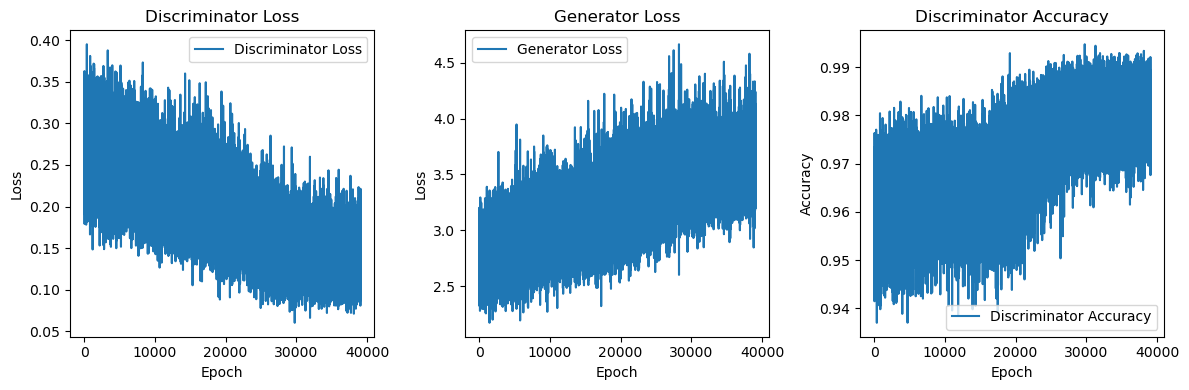

In [68]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Platting the values again

In [70]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [71]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [72]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [73]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

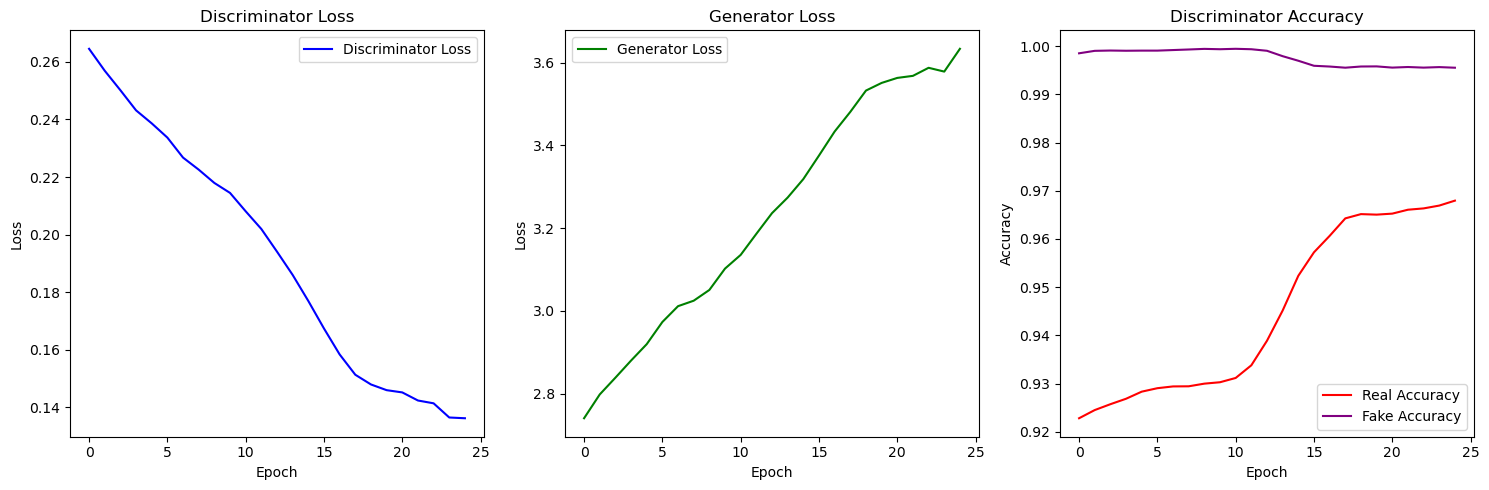

In [74]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
